In [40]:
# ==========================================
# ENVIRONMENT SETUP
# ==========================================
import pandas as pd
import numpy as np
import glob
import os
import re
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
import zipfile
import io
import yfinance as yf
from scipy import stats
from sklearn.linear_model import Ridge  # used for robust multiplier
from sklearn.metrics import mean_absolute_percentage_error  # used for error checking
from pytrends.request import TrendReq
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pickle
import optuna
from optuna.samplers import TPESampler
from sklearn.preprocessing import StandardScaler
from io import StringIO

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ==========================================
# CONFIGURATION
# ==========================================
CONF = {
    # Regex to capture both old (8517.12) and new (8517.13) smartphone codes
    'HS_CODE_REGEX': r'8517\.12|8517\.13', 
    'TARGET_BRANDS': ['Apple', 'Samsung', 'Google', 'Motorola'],
    'FORECAST_YEAR': 2026,
    'LAG_MONTHS': 1, # Supply Chain Lag: Imports(t) -> Sales(t+1)
    'MARKET_SHARE_FILE': 'canada_smartphone_market_share.csv',
    'INPUT_PATTERN': 'report*.csv' 
}

print("✅ Environment Setup Complete.")
print(f"   Targeting HS Codes: {CONF['HS_CODE_REGEX']}")
print(f"   Forecasting Horizon: {CONF['FORECAST_YEAR']}")

✅ Environment Setup Complete.
   Targeting HS Codes: 8517\.12|8517\.13
   Forecasting Horizon: 2026


In [41]:
# ==========================================
# DATA INGESTION & AGGREGATION
# ==========================================

def load_and_aggregate_trade_data(file_pattern: str) -> pd.DataFrame:
    """
    Loads multiple StatCan CSVs, filters for Smartphones, and aggregates to monthly totals.
    """
    print("="*60)
    print("DATA INGESTION")
    print("="*60)
    
    # 1. Find Files
    files = sorted(glob.glob(file_pattern))
    if not files:
        raise FileNotFoundError(f"❌ No files found matching '{file_pattern}'")
    
    print(f"📂 Found {len(files)} files. Processing...")
    
    df_list = []
    
    for f in files:
        try:
            with open(f, 'r') as file_obj:
                lines = [file_obj.readline() for _ in range(5)]
            
            header_row = 0
            for i, line in enumerate(lines):
                if 'Commodity' in line:
                    header_row = i
                    break
            
            # Load with correct header
            temp = pd.read_csv(f, header=header_row)
            
            # 2. Filter for Smartphones (HS Codes)
            if 'Commodity' in temp.columns:
                mask = temp['Commodity'].astype(str).str.contains(CONF['HS_CODE_REGEX'], na=False, regex=True)
                temp = temp[mask]
            
            # 3. Clean Numeric Columns (Remove commas)
            for col in ['Value ($)', 'Quantity']:
                if col in temp.columns and temp[col].dtype == object:
                    temp[col] = temp[col].astype(str).str.replace(',', '').astype(float)
            
            # 4. Standardize Date
            if 'Period' in temp.columns:
                temp['Period'] = pd.to_datetime(temp['Period'])
                
            df_list.append(temp)
            # print(f"   ✓ Loaded {os.path.basename(f)} ({len(temp)} rows)")
            
        except Exception as e:
            print(f"   ⚠️ Error reading {os.path.basename(f)}: {e}")

    if not df_list:
        raise ValueError("❌ No valid smartphone data extracted from files.")

    # 5. Concatenate
    df_raw = pd.concat(df_list, ignore_index=True)
    
    # 6. Aggregate to Monthly Level 
    df_monthly = df_raw.groupby('Period').agg({
        'Value ($)': 'sum',
        'Quantity': 'sum'
    }).reset_index()
    
    # Rename for clarity
    df_monthly.rename(columns={
        'Period': 'month', 
        'Value ($)': 'import_value_cad', 
        'Quantity': 'import_units'
    }, inplace=True)
    
    df_monthly = df_monthly.sort_values('month').reset_index(drop=True)
    
    print(f"\n✅ Aggregation Complete.")
    print(f"   Total Months: {len(df_monthly)}")
    print(f"   Date Range: {df_monthly['month'].min().date()} to {df_monthly['month'].max().date()}")
    print(f"   Total Units: {df_monthly['import_units'].sum():,.0f}")
    
    return df_monthly

# Execute
df_imports = load_and_aggregate_trade_data(CONF['INPUT_PATTERN'])
df_imports.tail()

DATA INGESTION
📂 Found 9 files. Processing...

✅ Aggregation Complete.
   Total Months: 178
   Date Range: 2011-01-01 to 2025-10-01
   Total Units: 191,773,692


,month,import_value_cad,import_units
173,2025-06-01,6.140141e+08,871061.0
174,2025-07-01,6.866555e+08,876493.0
175,2025-08-01,5.289448e+08,705546.0
176,2025-09-01,8.359030e+08,900067.0
177,2025-10-01,1.235225e+09,1339402.0


In [42]:
# ==========================================
# Supply Chain Lag Detection 
# ==========================================
def determine_optimal_lag(df_imports):
    print("="*60)
    print("PHASE 1.5: SCIENTIFIC LAG DETECTION")
    print("="*60)
    
    recommended_lag = 1  # Default fallback
    
    # ==========================================================================
    # TEST A: MACRO-ECONOMIC CROSS-CORRELATION (Supply vs. Demand)
    # ==========================================================================
    print("\n[A] Running Macro-Economic Correlation (Imports vs. Retail Sales)...")
    
    url = "https://www150.statcan.gc.ca/n1/tbl/csv/20100008-eng.zip"
    
    try:
        print("   ⏳ Downloading Retail Sales data from Statistics Canada...")
        r = requests.get(url, stream=True, timeout=30)
        
        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            csv_name = [f for f in z.namelist() if f.endswith('.csv')][0]
            
            chunks = []
            with z.open(csv_name) as f:
                for chunk in pd.read_csv(f, chunksize=10000, encoding='utf-8', low_memory=False):
                    mask = (
                        (chunk['GEO'] == 'Canada') & 
                        (chunk['North American Industry Classification System (NAICS)'].str.contains('Electronics', na=False)) &
                        (chunk['UOM'] == 'Dollars') & 
                        (chunk['Adjustments'] == 'Unadjusted')
                    )
                    if mask.any():
                        chunks.append(chunk[mask])
        
        if not chunks:
            raise ValueError("No electronics sales data found in StatCan file.")
            
        df_sales = pd.concat(chunks)
        df_sales['month'] = pd.to_datetime(df_sales['REF_DATE'])
        df_sales = df_sales.groupby('month')['VALUE'].sum().reset_index()
        df_sales.rename(columns={'VALUE': 'retail_sales_cad'}, inplace=True)
        
        print(f"   ✓ Loaded {len(df_sales)} months of Retail Sales data.")

        # Merge with Imports
        df_corr = pd.merge(
            df_imports[['month', 'import_value_cad']], 
            df_sales[['month', 'retail_sales_cad']], 
            on='month', 
            how='inner'
        )
        
        # Stationarity fix: Use % change
        df_corr['imports_pct'] = df_corr['import_value_cad'].pct_change()
        df_corr['sales_pct'] = df_corr['retail_sales_cad'].pct_change()
        df_corr = df_corr.dropna()
        
        print("\n   📊 Correlation Analysis (Stationary Data):")
        print(f"   {'Lag (Months)':<15} | {'Correlation (r)':<20} | {'Strength'}")
        print("   " + "-"*50)
        
        best_r = -1
        best_macro_lag = 0
        
        # Test wide range: 0-6 months
        for lag in range(0, 7):
            r = df_corr['imports_pct'].corr(df_corr['sales_pct'].shift(-lag))
            
            if pd.isna(r):
                continue
            
            bar = "█" * int(max(0, r) * 20)
            print(f"   {lag:<15} | {r:.4f}               | {bar}")
            
            if r > best_r:
                best_r = r
                best_macro_lag = lag
        
        # Statistical significance test
        n = len(df_corr)
        if best_r > 0 and n > 2:
            t_stat = best_r * np.sqrt(n - 2) / np.sqrt(1 - best_r**2)
            p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n - 2))
            
            print(f"   🏆 Macro Winner: {best_macro_lag} Months (r={best_r:.4f}, p={p_value:.4f}, n={n})")
            
            if p_value > 0.05:
                print(f"   ⚠️ Warning: Correlation not statistically significant")
        else:
            print(f"   🏆 Macro Winner: {best_macro_lag} Months (r={best_r:.4f})")

    except Exception as e:
        print(f"   ⚠️ Macro Analysis Failed: {e}")
        best_macro_lag = None

    # ==========================================================================
    # TEST B: MICRO-ECONOMIC TURNOVER (Inventory Velocity)
    # ==========================================================================
    print("\n[B] Running Micro-Economic Analysis (Inventory Turnover)...")
    
    tickers = ['BCE.TO', 'RCI-B.TO', 'BBY'] 
    lags = []
    
    try:
        for t in tickers:
            try:
                stock = yf.Ticker(t)
                bs = stock.balance_sheet
                fin = stock.financials
                
                if bs.empty or fin.empty:
                    print(f"   ⚠️ {t}: No financial data available")
                    continue
                
                # Extract inventory and COGS
                inv = bs.loc['Inventory'].iloc[0] if 'Inventory' in bs.index else None
                cogs = fin.loc['Cost Of Revenue'].iloc[0] if 'Cost Of Revenue' in fin.index else None
                
                # Validate data
                if inv is None or cogs is None or pd.isna(inv) or pd.isna(cogs):
                    print(f"   ⚠️ {t}: Missing inventory or COGS data")
                    continue
                
                if inv <= 0 or cogs <= 0:
                    print(f"   ⚠️ {t}: Invalid inventory or COGS values")
                    continue
                
                # Calculate Days Sales of Inventory (DSI)
                dsi = (inv / cogs) * 365
                months_inv = dsi / 30
                lags.append(months_inv)
                print(f"   ✓ {t}: {dsi:.0f} Days Inventory (~{months_inv:.1f} months)")
            
            except Exception as e:
                print(f"   ⚠️ {t}: Error ({e})")
                continue
        
        # Calculate average from valid companies
        if lags:
            valid_lags = [l for l in lags if not np.isnan(l)]
            
            if valid_lags:
                avg_micro_lag = np.mean(valid_lags)
                print(f"   🏆 Micro Average: {avg_micro_lag:.1f} Months (from {len(valid_lags)}/{len(lags)} companies)")
                best_micro_lag = int(round(avg_micro_lag))
            else:
                print(f"   ⚠️ All companies returned NaN - Micro analysis unavailable")
                best_micro_lag = None
        else:
            print(f"   ⚠️ No valid inventory data found")
            best_micro_lag = None
            
    except Exception as e:
        print(f"   ⚠️ Micro Analysis Failed: {e}")
        best_micro_lag = None

    # ==========================================================================
    # FINAL VERDICT
    # ==========================================================================
    print("\n" + "="*60)
    
    if best_macro_lag is not None and best_micro_lag is not None:
        if best_macro_lag == best_micro_lag:
            recommended_lag = best_macro_lag
            confidence = "High (Macro + Micro Agree)"
        else:
            # Prioritize macro (real sales data)
            recommended_lag = best_macro_lag
            confidence = f"Medium (Macro={best_macro_lag}, Micro={best_micro_lag})"
    elif best_macro_lag is not None:
        recommended_lag = best_macro_lag
        confidence = "High (Macro Only)"
    elif best_micro_lag is not None:
        recommended_lag = best_micro_lag
        confidence = "Medium (Micro Only)"
    else:
        recommended_lag = 1
        confidence = "Low (Default Fallback)"

    print(f"🎯 FINAL DECISION: Apply Lag of {recommended_lag} Month(s)")
    print(f"   Confidence: {confidence}")
    print(f"   Interpretation: {recommended_lag} month delay from port arrival to retail sale")
    print("="*60)
    
    return recommended_lag

# Execute and update configuration
calculated_lag = determine_optimal_lag(df_imports)
CONF['LAG_MONTHS'] = calculated_lag

PHASE 1.5: SCIENTIFIC LAG DETECTION

[A] Running Macro-Economic Correlation (Imports vs. Retail Sales)...
   ⏳ Downloading Retail Sales data from Statistics Canada...
   ✓ Loaded 384 months of Retail Sales data.

   📊 Correlation Analysis (Stationary Data):
   Lag (Months)    | Correlation (r)      | Strength
   --------------------------------------------------
   0               | 0.1536               | ███
   1               | 0.1994               | ███
   2               | 0.0879               | █
   3               | -0.0490               | 
   4               | -0.0775               | 
   5               | -0.0057               | 
   6               | -0.1166               | 
   🏆 Macro Winner: 1 Months (r=0.1994, p=0.0170, n=143)

[B] Running Micro-Economic Analysis (Inventory Turnover)...
   ⚠️ BCE.TO: Missing inventory or COGS data
   ✓ RCI-B.TO: 21 Days Inventory (~0.7 months)
   ✓ BBY: 58 Days Inventory (~1.9 months)
   🏆 Micro Average: 1.3 Months (from 2/2 companies)

🎯 FIN

In [43]:
# ==========================================
# APPLY LAG & MERGE LAG & MARKET SHARE
# ==========================================
def apply_lag_and_merge_shares(df_trade: pd.DataFrame, share_file: str) -> pd.DataFrame:
    print("\n" + "="*60)
    print("LAG APPLICATION & BRAND SPLIT")
    print("="*60)
    
    # 1. Load Market Share
    if not os.path.exists(share_file):
        print(f"❌ Market share file '{share_file}' not found.")
        return None
        
    df_share = pd.read_csv(share_file)
    
    # Standardize Date
    date_col = 'Date' if 'Date' in df_share.columns else 'month'
    df_share['month'] = pd.to_datetime(df_share[date_col])
    
    # ════════════════════════════════════════════════════════════
    # 2. EXTEND DATAFRAME TO CAPTURE LAGGED DATA
    # ════════════════════════════════════════════════════════════
    df_trade = df_trade.copy()
    lag = CONF['LAG_MONTHS']  # 1 month (scientifically derived)
    
    # Create extension row(s) for the lag period
    last_date = df_trade['month'].max()
    extension_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=lag,
        freq='MS'
    )
    
    df_extension = pd.DataFrame({
        'month': extension_dates,
        'import_units': [np.nan] * lag,  # No imports for future months
        'import_value_cad': [np.nan] * lag
    })
    
    # Append extension rows
    df_trade = pd.concat([df_trade, df_extension], ignore_index=True)
    
    # ════════════════════════════════════════════════════════════
    # 3. APPLY SUPPLY CHAIN LAG (SHIFT FORWARD)
    # ════════════════════════════════════════════════════════════
    # Logic: Imports in Oct become Sales in Nov (1-month lag)
    df_trade['sales_proxy_units'] = df_trade['import_units'].shift(lag)
    df_trade['sales_proxy_value'] = df_trade['import_value_cad'].shift(lag)
    
    # Drop initial rows where we have no sales signal yet
    df_trade = df_trade.dropna(subset=['sales_proxy_units'])
    
    print(f"✅ Lag applied: Data extended to {df_trade['month'].max().strftime('%Y-%m')} (+{lag} month)")
    
    # ════════════════════════════════════════════════════════════
    # 4. MERGE WITH MARKET SHARE (LEFT JOIN + FORWARD FILL)
    # ════════════════════════════════════════════════════════════
    df_merged = pd.merge(df_trade, df_share, on='month', how='left')
    
    # Forward-fill market share for new month(s)
    # Assumption: Nov 2025 share ≈ Oct 2025 share
    share_cols = [c for c in df_merged.columns if c in CONF['TARGET_BRANDS']]
    if share_cols:
        df_merged[share_cols] = df_merged[share_cols].ffill()
        
        missing_share_rows = df_merged[df_merged[share_cols[0]].isna()]
        if len(missing_share_rows) > 0:
            print(f"⚠️  Market share forward-filled for {len(missing_share_rows)} month(s): {missing_share_rows['month'].dt.strftime('%Y-%m').tolist()}")
    
    # ════════════════════════════════════════════════════════════
    # 5. CALCULATE BRAND UNITS
    # ════════════════════════════════════════════════════════════
    for brand in CONF['TARGET_BRANDS']:
        if brand in df_merged.columns:
            # Share is 0-100, convert to decimal
            df_merged[f'{brand}_units'] = df_merged['sales_proxy_units'] * (df_merged[brand] / 100)
    
    print(f"✅ Merged & Lagged Data: {len(df_merged)} rows (from {df_merged['month'].min().strftime('%Y-%m')} to {df_merged['month'].max().strftime('%Y-%m')})")
    
    return df_merged


# Execute
df_master = apply_lag_and_merge_shares(df_imports, CONF['MARKET_SHARE_FILE'])
display(df_master.head())
display(df_master.tail())  

CONF['MARKET_SHARE_APPLIED'] = True
CONF['LAG_APPLIED'] = True
df_full_data = df_master.copy()


LAG APPLICATION & BRAND SPLIT
✅ Lag applied: Data extended to 2025-11 (+1 month)
✅ Merged & Lagged Data: 178 rows (from 2011-02 to 2025-11)


,month,import_value_cad,import_units,sales_proxy_units,sales_proxy_value,Date,Apple,Samsung,RIM,Google,...,Blu,Essential,Honor,Kyocera,General Mobile,Other,Apple_units,Samsung_units,Google_units,Motorola_units
0,2011-02-01,288664702.0,1302184.0,1312428.0,247111319.0,2011-02,69.95,1.67,13.18,0.31,...,0.0,0.0,0.0,0.0,0.0,0.30,918043.3860,21917.5476,4068.5268,1049.9424
1,2011-03-01,254600394.0,1263432.0,1302184.0,288664702.0,2011-03,73.43,1.70,15.78,0.36,...,0.0,0.0,0.0,0.0,0.0,0.30,956193.7112,22137.1280,4687.8624,911.5288
2,2011-04-01,283685945.0,1187712.0,1263432.0,254600394.0,2011-04,62.70,2.63,14.38,0.28,...,0.0,0.0,0.0,0.0,0.0,0.22,792171.8640,33228.2616,3537.6096,758.0592
3,2011-05-01,291893514.0,1318248.0,1187712.0,283685945.0,2011-05,50.34,3.74,15.61,0.21,...,0.0,0.0,0.0,0.0,0.0,0.17,597894.2208,44420.4288,2494.1952,712.6272
4,2011-06-01,246052542.0,1174286.0,1318248.0,291893514.0,2011-06,40.60,4.43,17.92,0.16,...,0.0,0.0,0.0,0.0,0.0,0.14,535208.6880,58398.3864,2109.1968,922.7736


,month,import_value_cad,import_units,sales_proxy_units,sales_proxy_value,Date,Apple,Samsung,RIM,Google,...,Blu,Essential,Honor,Kyocera,General Mobile,Other,Apple_units,Samsung_units,Google_units,Motorola_units
173,2025-07-01,6.866555e+08,876493.0,871061.0,6.140141e+08,2025-07,60.00,23.26,0.01,7.75,...,0.0,0.0,0.11,0.0,0.0,0.06,522636.6000,202608.7886,67507.2275,14372.5065
174,2025-08-01,5.289448e+08,705546.0,876493.0,6.866555e+08,2025-08,50.62,23.88,0.01,17.89,...,0.0,0.0,0.11,0.0,0.0,0.05,443680.7566,209306.5284,156804.5977,10254.9681
175,2025-09-01,8.359030e+08,900067.0,705546.0,5.289448e+08,2025-09,56.47,23.43,0.01,10.90,...,0.0,0.0,0.12,0.0,0.0,0.07,398421.8262,165309.4278,76904.5140,9948.1986
176,2025-10-01,1.235225e+09,1339402.0,900067.0,8.359030e+08,2025-10,58.35,23.28,0.01,9.29,...,0.0,0.0,0.10,0.0,0.0,0.06,525189.0945,209535.5976,83616.2243,13591.0117
177,2025-11-01,NaN,NaN,1339402.0,1.235225e+09,2025-11,59.94,22.97,0.01,9.05,...,0.0,0.0,0.06,0.0,0.0,0.05,802837.5588,307660.6394,121215.8810,21430.4320


In [44]:
# ===========================================================
# BEHAVIORAL LAG DETECTION (Google Trends → Sales) 
# ===========================================================
"""
PURPOSE: Find lag between Google searches and actual purchases
LOGIC:   Searches LEAD purchases (people search, then buy)
         Expected: Negative lag (Trends at t-k → Sales at t)

FEATURES:
- Granger causality testing for causal validation
- Weighted trend contribution (strong/weak/none)
- Bonferroni correction for multiple comparisons
- Seasonal decomposition preprocessing
- Brand-specific regime filtering
"""

import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
import time
import warnings

warnings.filterwarnings('ignore')

print("="*70)
print("BEHAVIORAL LAG DETECTION")
print("="*70)

# ================================================================
# BRAND-SPECIFIC START DATES (REGIME FILTERING)
# ================================================================

BRAND_START_DATES = {
    'Apple': '2011-01-01',       # iPhone 4S era onwards
    'Samsung': '2011-01-01',     # Galaxy S2 era onwards
    'Google': '2016-10-01',      # Pixel 1 launch (NOT Nexus era)
    'Motorola': '2014-01-01'     # Lenovo acquisition era
}

print("Regime filtering:")
for brand, date in BRAND_START_DATES.items():
    print(f"  {brand}: {date} onwards")
print("="*70)

# ============================================================
# STEP 1: FETCH GOOGLE TRENDS 
# ============================================================
def fetch_trends_robust(brand, search_term, retries=5):
    """
    Fetch Google Trends with exponential backoff
    """
    from pytrends.request import TrendReq
    
    for attempt in range(retries):
        try:
            pytrends = TrendReq(
                hl='en-CA', 
                tz=300, 
                timeout=(10, 25), 
                retries=3,
                backoff_factor=0.5
            )
            
            pytrends.build_payload(
                [search_term], 
                timeframe='2011-01-01 2025-12-31', 
                geo='CA'
            )
            
            df = pytrends.interest_over_time()
            
            if not df.empty:
                # Remove 'isPartial' column if present
                if 'isPartial' in df.columns:
                    df = df.drop('isPartial', axis=1)
                
                df = df.reset_index()
                df.rename(columns={'date': 'month', search_term: 'trends_score'}, inplace=True)
                df = df[['month', 'trends_score']]
                df['month'] = pd.to_datetime(df['month'])
                
                # Monthly aggregation
                df = df.groupby(df['month'].dt.to_period('M')).agg({
                    'trends_score': 'mean'
                }).reset_index()
                df['month'] = df['month'].dt.to_timestamp()
                
                # Filter to valid date range
                df = df[(df['month'] >= '2011-01-01') & (df['month'] <= '2025-12-31')]
                
                return df
            
        except Exception as e:
            if attempt < retries - 1:
                # Exponential backoff: 60, 120, 240 seconds
                sleep_time = 60 * (2 ** attempt)
                print(f"    Attempt {attempt+1} failed, retrying in {sleep_time}s...")
                time.sleep(sleep_time)
            else:
                print(f"    Failed after {retries} attempts: {e}")
                return None
    
    return None

# ============================================================
# STEP 2: PREPROCESSING (STATIONARITY + SEASONALITY REMOVAL)
# ============================================================
def preprocess_series(series, name, min_samples=36):
    """
    Robust preprocessing for time series
    
    Steps:
    1. Validate sufficient data
    2. Test stationarity (ADF test)
    3. Remove trend and seasonality
    """
    
    if len(series) < min_samples:
        raise ValueError(f"{name}: Insufficient data ({len(series)} < {min_samples})")
    
    # Remove any NaN/inf
    series = series.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Stationarity test (ADF)
    try:
        adf_result = adfuller(series, autolag='AIC')
        is_stationary = adf_result[1] < 0.05
        
        if not is_stationary:
            # First difference to achieve stationarity
            series = series.diff().dropna()
            print(f"    {name}: Differenced (non-stationary, p={adf_result[1]:.3f})")
    except Exception as e:
        print(f"    {name}: ADF test failed ({e}), skipping stationarity check")
    
    # Seasonal decomposition (if enough data after differencing)
    if len(series) >= 36:
        try:
            decomp = seasonal_decompose(
                series, 
                model='additive', 
                period=12,
                extrapolate_trend='freq'
            )
            # Remove trend and seasonal components
            residual = series - decomp.trend - decomp.seasonal
            residual = residual.dropna()
            print(f"    {name}: Seasonal decomposition applied")
            return residual
        except Exception as e:
            print(f"    {name}: Seasonal decomposition failed ({e}), using linear detrend")
    
    # Fallback: Linear detrending
    x = np.arange(len(series))
    slope, intercept = np.polyfit(x, series.values, 1)
    detrended = series - (slope * x + intercept)
    print(f"    {name}: Linear detrend applied")
    
    return detrended

# ============================================================
# STEP 3: BEHAVIORAL LAG DETECTION WITH GRANGER CAUSALITY
# ============================================================
def detect_behavioral_lag_robust(df_sales, df_trends, brand_name):
    """
    Detect lag between Google searches and purchases
    
    METHODOLOGY:
    1. Granger causality test (causal validation)
    2. Cross-correlation scan (lag estimation, negative only)
    3. Bonferroni correction (multiple comparisons)
    4. Statistical weight calculation (0.0 to 1.0)
    
    CRITICAL CONSTRAINTS:
    - Lag must be NEGATIVE (searches lead purchases)
    - Brand-specific regime filtering applied
    """
    
    sales_col = f'{brand_name}_units'
    
    # Validate inputs
    if sales_col not in df_sales.columns:
        print(f"  {brand_name}: Sales column not found")
        return {
            'lag': 0, 
            'correlation': 0.0, 
            'p_value': 1.0, 
            'granger_pval': 1.0,
            'trend_weight': 0.0,
            'method': 'missing_data', 
            'significant': False
        }
    
    if df_trends is None or df_trends.empty:
        print(f"  {brand_name}: No trends data available")
        return {
            'lag': 0, 
            'correlation': 0.0, 
            'p_value': 1.0, 
            'granger_pval': 1.0,
            'trend_weight': 0.0,
            'method': 'no_trends', 
            'significant': False
        }
    
    # ============================================================
    # APPLY REGIME FILTERING
    # ============================================================
    start_date = BRAND_START_DATES.get(brand_name, '2011-01-01')
    
    df_sales_filtered = df_sales[df_sales['month'] >= start_date].copy()
    df_trends_filtered = df_trends[df_trends['month'] >= start_date].copy()
    
    print(f"\n  {brand_name} (regime: {start_date} onwards):")
    print(f"    Sales: {len(df_sales_filtered)} months")
    print(f"    Trends: {len(df_trends_filtered)} months")
    
    # Merge on filtered data
    df = pd.merge(
        df_trends_filtered[['month', 'trends_score']],
        df_sales_filtered[['month', sales_col]].rename(columns={sales_col: 'sales'}),
        on='month',
        how='inner'
    ).sort_values('month').reset_index(drop=True)
    
    if len(df) < 36:
        print(f"    Insufficient overlap ({len(df)} months < 36)")
        return {
            'lag': 0, 
            'correlation': 0.0, 
            'p_value': 1.0, 
            'granger_pval': 1.0,
            'trend_weight': 0.0,
            'method': 'insufficient_overlap', 
            'significant': False
        }
    
    print(f"    Merged: {len(df)} months overlap")
    
    # ============================================================
    # PREPROCESS BOTH SERIES
    # ============================================================
    try:
        trends_clean = preprocess_series(
            df.set_index('month')['trends_score'], 
            'Trends',
            min_samples=36
        )
        sales_clean = preprocess_series(
            df.set_index('month')['sales'], 
            'Sales',
            min_samples=36
        )
    except ValueError as e:
        print(f"    Preprocessing failed: {e}")
        return {
            'lag': 0, 
            'correlation': 0.0, 
            'p_value': 1.0, 
            'granger_pval': 1.0,
            'trend_weight': 0.0,
            'method': 'preprocessing_failed', 
            'significant': False
        }
    
    # ============================================================
    # ALIGN SERIES (HANDLE LENGTH MISMATCH)
    # ============================================================
    common_dates = trends_clean.index.intersection(sales_clean.index)
    
    if len(common_dates) < 24:
        print(f"    Insufficient common dates after preprocessing ({len(common_dates)} < 24)")
        return {
            'lag': 0, 
            'correlation': 0.0, 
            'p_value': 1.0, 
            'granger_pval': 1.0,
            'trend_weight': 0.0,
            'method': 'insufficient_common_dates', 
            'significant': False
        }
    
    trends_aligned = trends_clean.loc[common_dates]
    sales_aligned = sales_clean.loc[common_dates]
    
    print(f"    Aligned: {len(common_dates)} months")
    
    # ============================================================
    # GRANGER CAUSALITY TEST
    # ============================================================
    print(f"  Granger Causality Test:")
    
    gc_data = pd.DataFrame({
        'sales': sales_aligned.values,
        'trends': trends_aligned.values
    })
    
    best_gc_pval = 1.0
    
    try:
        gc_result = grangercausalitytests(
            gc_data[['sales', 'trends']], 
            maxlag=6,
            verbose=False
        )
        
        for lag in range(1, 7):
            # F-test p-value
            p_value = gc_result[lag][0]['ssr_ftest'][1]
            print(f"    Lag {lag}: p={p_value:.4f}")
            
            if p_value < best_gc_pval:
                best_gc_pval = p_value
    
    except Exception as e:
        print(f"    ✗ Granger test failed: {e}")
        best_gc_pval = 1.0
    
    # ============================================================
    # CALCULATE TREND WEIGHT (BASED ON GRANGER P-VALUE)
    # ============================================================
    if best_gc_pval < 0.01:
        trend_weight = 1.0
        causality_status = "Strong"
    elif best_gc_pval < 0.50:
        # Continuous exponential decay
        # This ensures weak signals still contribute
        trend_weight = max(0.1, 1.0 - (best_gc_pval / 0.5) ** 0.5)
        if trend_weight >= 0.5:
            causality_status = "Moderate"
        elif trend_weight >= 0.2:
            causality_status = "Weak"
        else:
            causality_status = "Very Weak"
    else:
        trend_weight = 0.0
        causality_status = "None"
    
    print(f"    → {causality_status} causality (p={best_gc_pval:.4f}) → weight={trend_weight:.2f}")
    
    # ============================================================
    # CROSS-CORRELATION (ONLY IF SOME CAUSALITY DETECTED)
    # ============================================================
    if trend_weight > 0:
        print(f"  Cross-Correlation Scan (negative lags only):")
        
        best_lag = 0
        best_corr = 0.0
        best_p = 1.0
        
        # CRITICAL: Only test NEGATIVE lags (searches LEAD)
        for lag in range(-12, 0):
            shifted_sales = sales_aligned.shift(-lag)
            valid = trends_aligned.notna() & shifted_sales.notna()
            
            if valid.sum() < 12:
                continue
            
            try:
                r, p = stats.pearsonr(
                    trends_aligned[valid].values, 
                    shifted_sales[valid].values
                )
                
                print(f"    Lag {lag:+3d}: r={r:+.3f}, p={p:.4f}")
                
                # Bonferroni correction: 0.05 / 12 lags
                if abs(r) > abs(best_corr) and p < 0.0042:
                    best_lag = lag
                    best_corr = r
                    best_p = p
            
            except Exception as e:
                continue
        
        is_significant = best_p < 0.0042
        
        if is_significant:
            print(f"  → Selected lag: {best_lag} months (searches LEAD by {abs(best_lag)} months)")
        else:
            print(f"  → No significant lag detected, using concurrent (lag=0)")
            best_lag = 0
    else:
        # No causality, skip cross-correlation
        print(f"  → No causality detected, defaulting to lag=0")
        best_lag = 0
        best_corr = 0.0
        best_p = 1.0
        is_significant = False
    
    return {
        'lag': best_lag,
        'correlation': best_corr,
        'p_value': best_p,
        'granger_pval': best_gc_pval,
        'trend_weight': trend_weight,
        'method': 'granger_validated' if trend_weight > 0 else 'no_causality',
        'significant': is_significant
    }


# ================================================================
# EXECUTION
# ================================================================

SEARCH_TERMS = {
    'Apple': 'iPhone',
    'Samsung': 'Samsung Galaxy',
    'Google': 'Pixel',
    'Motorola': 'Moto'
}

print("\n[1/3] Fetching Google Trends...")

trends_dict_raw = {}

for brand in CONF['TARGET_BRANDS']:
    print(f"\n{brand} ({SEARCH_TERMS[brand]}):")
    df = fetch_trends_robust(brand, SEARCH_TERMS[brand], retries=3)
    
    if df is not None:
        print(f"  ✓ Fetched {len(df)} months ({df['month'].min().date()} to {df['month'].max().date()})")
        trends_dict_raw[brand] = df
    else:
        print(f"  ✗ Failed to fetch")
        trends_dict_raw[brand] = None

print(f"\n✓ Trends fetched: {sum(1 for v in trends_dict_raw.values() if v is not None)}/{len(CONF['TARGET_BRANDS'])} brands")

# ================================================================
# DETECT LAGS & CALCULATE WEIGHTS
# ================================================================

print("\n" + "="*70)
print("[2/3] Detecting behavioral lags & calculating weights...")
print("="*70)

behavioral_lags = {}
trend_weights = {}

for brand in CONF['TARGET_BRANDS']:
    result = detect_behavioral_lag_robust(
        df_full_data,
        trends_dict_raw[brand],
        brand
    )
    behavioral_lags[brand] = result
    trend_weights[brand] = result['trend_weight']

# ================================================================
# ALIGN TRENDS TO PURCHASE TIMING
# ================================================================

print("\n" + "="*70)
print("[3/3] Aligning trends to purchase timing...")
print("="*70)

trends_dict_aligned = {}

for brand in CONF['TARGET_BRANDS']:
    df_trends = trends_dict_raw.get(brand)
    
    if df_trends is None:
        trends_dict_aligned[brand] = None
        print(f"  {brand}: No trends data")
        continue
    
    lag = behavioral_lags[brand]['lag']
    df_aligned = df_trends.copy()
    
    if lag != 0:
        # Negative lag means searches LEAD
        # Shift trends FORWARD by |lag| months
        df_aligned['month'] = df_aligned['month'] + pd.DateOffset(months=abs(lag))
        print(f"  {brand}: Shifted {abs(lag)} months FORWARD (searches lead)")
    else:
        print(f"  {brand}: No shift (lag=0)")
    
    trends_dict_aligned[brand] = df_aligned

# ================================================================
# SAVE TO CONF
# ================================================================

CONF['TRENDS_DICT_RAW'] = trends_dict_raw
CONF['TRENDS_DICT_ALIGNED'] = trends_dict_aligned
CONF['BEHAVIORAL_LAGS'] = behavioral_lags
CONF['TREND_WEIGHTS'] = trend_weights  # NEW: Statistical weights for Cell 4.6

# ================================================================
# SUMMARY
# ================================================================

print("\n" + "="*70)
print("✅ BEHAVIORAL LAG DETECTION COMPLETE")
print("="*70)

print("\nGranger Causality & Weights:")
for brand, result in behavioral_lags.items():
    weight = result['trend_weight']
    granger_p = result['granger_pval']
    
    if weight == 1.0:
        status = "Strong"
    elif weight > 0:
        status = "Weak"
    else:
        status = "None"
    
    print(f"  {brand}: {status} (p={granger_p:.4f}) → weight={weight:.2f}")

print("\nLag Detection:")
for brand, result in behavioral_lags.items():
    if result['significant']:
        lag = result['lag']
        print(f"  {brand}: Searches LEAD by {abs(lag)} months")
    else:
        print(f"  {brand}: Concurrent (lag=0)")

print("\n✓ Trends aligned to purchase timing")
print("✓ Statistical weights saved to CONF['TREND_WEIGHTS']")
print("✓ Ready for Cell 4.6 (Calibration)")
print("="*70)

BEHAVIORAL LAG DETECTION
Regime filtering:
  Apple: 2011-01-01 onwards
  Samsung: 2011-01-01 onwards
  Google: 2016-10-01 onwards
  Motorola: 2014-01-01 onwards

[1/3] Fetching Google Trends...

Apple (iPhone):
  ✓ Fetched 180 months (2011-01-01 to 2025-12-01)

Samsung (Samsung Galaxy):
  ✓ Fetched 180 months (2011-01-01 to 2025-12-01)

Google (Pixel):
  ✓ Fetched 180 months (2011-01-01 to 2025-12-01)

Motorola (Moto):
  ✓ Fetched 180 months (2011-01-01 to 2025-12-01)

✓ Trends fetched: 4/4 brands

[2/3] Detecting behavioral lags & calculating weights...

  Apple (regime: 2011-01-01 onwards):
    Sales: 178 months
    Trends: 180 months
    Merged: 178 months overlap
    Trends: Differenced (non-stationary, p=0.450)
    Trends: Seasonal decomposition applied
    Sales: Differenced (non-stationary, p=0.297)
    Sales: Seasonal decomposition applied
    Aligned: 177 months
  Granger Causality Test:
    Lag 1: p=0.0010
    Lag 2: p=0.0006
    Lag 3: p=0.0016
    Lag 4: p=0.0003
    Lag 5:

In [45]:
# =======================================================
# VOLUME CALIBRATION (Synthetic Signal Method)
# =======================================================
"""
PURPOSE: Calibrate sales volumes using a composite signal of:
- Lagged import data (primary signal)
- Aligned Google Trends (behavioral signal)
- Market share (brand split)
"""
if CONF.get('CALIBRATION_COMPLETE', False):
    print("⚠️ CALIBRATION SKIPPED: Already applied. To re-run, set CONF['CALIBRATION_COMPLETE'] = False")
else:
    
    import pandas as pd
    import numpy as np
    import warnings
    warnings.filterwarnings('ignore')

    print("="*70)
    print("VOLUME CALIBRATION (Synthetic Signal Method)")
    print("="*70)

    # =============================================================================
    # CONFIGURATION
    # =============================================================================

    ACTUAL_ANNUAL_SALES = {
        2014: 14.1 * 1_000_000,
        2015: 13.3 * 1_000_000,
        2016: 13.4 * 1_000_000,
        2017: 13.5 * 1_000_000,
        2018: 13.6 * 1_000_000,
        2019: 13.6 * 1_000_000,
        2020: 12.1 * 1_000_000,
        2021: 12.9 * 1_000_000,
        2022: 13.2 * 1_000_000,
        2023: 13.8 * 1_000_000,
        2024: 14.1 * 1_000_000,
        2025: 14.6 * 1_000_000,
    }

    ACTUAL_ANNUAL_SALES.update({
        2011: 9 * 1_000_000,
        2012: 10.5 * 1_000_000,
        2013: 12.9 * 1_000_000,
    })

    SKIP_CALIBRATION_YEARS = [2011, 2012, 2013]
    PARTIAL_DATA_YEARS = {2025: 11}  # Have data through Nov after lag

    supply_chain_lag = CONF.get('LAG_MONTHS', 1)
    trends_dict_aligned = CONF.get('TRENDS_DICT_ALIGNED', {})
    behavioral_lags = CONF.get('BEHAVIORAL_LAGS', {})

    print(f"\nConfiguration:")
    print(f"  Supply chain lag: {supply_chain_lag} month (ALREADY APPLIED in Cell 4)")
    print(f"  2025 Target: {ACTUAL_ANNUAL_SALES[2025]:,.0f} units")

    # =============================================================================
    # STEP 1: CREATE COMPOSITE SIGNAL & CALCULATE CALIBRATED SALES
    # =============================================================================

    print("\n[1/3] Calculating calibrated sales via Weighted Distribution...")

    df_market_share = pd.read_csv(CONF['MARKET_SHARE_FILE'])
    if 'Date' in df_market_share.columns:
        df_market_share.rename(columns={'Date': 'month'}, inplace=True)
    df_market_share['month'] = pd.to_datetime(df_market_share['month'])

    calibrated_sales = {}
    composite_signals = {}

    for brand in CONF['TARGET_BRANDS']:
        print(f"\n  {brand}:")
        
        brand_col = f'{brand}_units'
        if brand_col not in df_full_data.columns:
            print(f"    ✗ No data column '{brand_col}'")
            continue
        
        # =======================================================
        # CREATE TIMELINE 
        # =======================================================
        years = sorted(ACTUAL_ANNUAL_SALES.keys())
        months = pd.date_range(f'{years[0]}-01-01', f'{years[-1]}-12-31', freq='MS')
        
        df = pd.DataFrame({'month': months})
        df['year'] = df['month'].dt.year
        df['annual_total'] = df['year'].map(ACTUAL_ANNUAL_SALES)
        
        # =======================================================
        # GET SALES PROXY DATA 
        # =======================================================
        df_sales_proxy = df_full_data[['month', brand_col]].copy()
        df = pd.merge(df, df_sales_proxy, on='month', how='left')
        df = df.rename(columns={brand_col: 'sales_proxy'})
        
        # =======================================================
        # GET ALIGNED TRENDS
        # =======================================================
        df_trends = trends_dict_aligned.get(brand)
        trend_weights = CONF.get('TREND_WEIGHTS', {})
        weight = trend_weights.get(brand, 1.0)  # Default to 1.0 for backward compatibility

        if df_trends is not None and not df_trends.empty:
            df = pd.merge(df, df_trends[['month', 'trends_score']], on='month', how='left')
            df['trends_score'].fillna(df['trends_score'].median(), inplace=True)
    
            # Apply statistical weighting based on Granger causality
            if weight < 1.0:
                # Blend trends with neutral (1.0) based on Granger strength
                df['trends_score'] = weight * df['trends_score'] + (1 - weight) * 1.0
                granger_p = behavioral_lags.get(brand, {}).get('granger_pval', 1.0)
                print(f"    ✓ Trends weighted at {weight:.1%} (Granger p={granger_p:.4f})")
            else:
                print(f"    ✓ Trends at full strength (strong causality)")
    
            has_trends = True
        else:
            df['trends_score'] = 1.0
            has_trends = False
            print(f"    ℹ️ No trends data")
        
        # =======================================================
        # CALCULATE COMPOSITE SIGNAL 
        # =======================================================
        df['composite_signal'] = df['sales_proxy'] * df['trends_score']
        df['composite_signal'].fillna(0, inplace=True)
        df['composite_signal'] = df['composite_signal'].clip(lower=0)
        
        # =======================================================
        # GET MARKET SHARE 
        # =======================================================
        share_col = brand if brand in df_market_share.columns else f'{brand}_share'
        
        if share_col not in df_market_share.columns:
            print(f"    ✗ No market share column '{share_col}'")
            continue
        
        df = pd.merge(df, df_market_share[['month', share_col]], on='month', how='left')
        
        # Forward-fill Dec 2025 share if missing
        if df[share_col].isna().any():
            df[share_col] = df[share_col].ffill()
            missing_count = df[df['month'].dt.year == 2025][share_col].isna().sum()
            if missing_count > 0:
                print(f"    ℹ️ Forward-filled {missing_count} missing 2025 market share values")
        
        # =======================================================
        # WEIGHTED DISTRIBUTION
        # =======================================================
        for year in years:
            year_mask = df['year'] == year
            year_data = df[year_mask].copy()
            
            if len(year_data) == 0:
                continue
            
            # -------------------------------------------------------
            # SPECIAL CASE 1: SKIP YEARS (2011-2013)
            # --------------------------------------------------------
            if year in SKIP_CALIBRATION_YEARS:
                df.loc[year_mask, 'calibrated_sales'] = year_data['sales_proxy']
                continue
            
            # CALCULATE TARGET
            avg_share = year_data[share_col].mean()
            brand_annual_target = ACTUAL_ANNUAL_SALES[year] * (avg_share / 100)
            
            # -------------------------------------------------------
            # SPECIAL CASE 2: PARTIAL YEAR (2025)
            # -------------------------------------------------------
            if year in PARTIAL_DATA_YEARS:
                last_valid_month = PARTIAL_DATA_YEARS[year]  
                
                # Calculate known signal (Jan-Nov)
                valid_mask = year_mask & (df['month'].dt.month <= last_valid_month)
                signal_sum_known = df.loc[valid_mask, 'composite_signal'].sum()
                
                print(f"    ℹ️ {year}: Have data through month {last_valid_month}")
                
                # Estimate December signal using historical pattern
                missing_mask = year_mask & (df['month'].dt.month > last_valid_month)
                
                if missing_mask.any():
                    # Calculate Nov→Dec signal ratios from previous 3 years
                    prev_years = [year - 1, year - 2, year - 3]
                    signal_ratios = []
                    
                    for py in prev_years:
                        if py in df['year'].values:
                            nov_sig = df[(df['year'] == py) & (df['month'].dt.month == 11)]['composite_signal'].sum()
                            dec_sig = df[(df['year'] == py) & (df['month'].dt.month == 12)]['composite_signal'].sum()
                            
                            if nov_sig > 0:
                                signal_ratios.append(dec_sig / nov_sig)
                    
                    if signal_ratios:
                        avg_signal_ratio = np.mean(signal_ratios)
                        print(f"    ℹ️ Historical Nov→Dec signal ratio: {avg_signal_ratio:.3f} (avg of {len(signal_ratios)} years)")
                    else:
                        avg_signal_ratio = 0.95
                        print(f"    ⚠️ No historical data - using default ratio: {avg_signal_ratio:.3f}")
                    
                    # Synthesize December signal
                    nov_2025_signal = df[(df['year'] == year) & (df['month'].dt.month == 11)]['composite_signal'].sum()
                    estimated_dec_signal = nov_2025_signal * avg_signal_ratio
                    
                    # Add to total for multiplier calculation
                    signal_sum_total = signal_sum_known + estimated_dec_signal
                    
                    print(f"    ℹ️ Nov 2025 signal: {nov_2025_signal:,.0f}")
                    print(f"    ℹ️ Dec 2025 signal (estimated): {estimated_dec_signal:,.0f}")
                else:
                    signal_sum_total = signal_sum_known
                
                # Calculate 2025-specific multiplier
                if signal_sum_total > 0:
                    multiplier_2025 = brand_annual_target / signal_sum_total
                else:
                    multiplier_2025 = 1.0
                    print(f"    ⚠️ Zero signal sum - using multiplier 1.0")
                
                print(f"    ℹ️ 2025 Multiplier: {multiplier_2025:.4f}x")
                
                # Apply multiplier to Jan-Nov
                df.loc[valid_mask, 'calibrated_sales'] = (
                    df.loc[valid_mask, 'composite_signal'] * multiplier_2025
                )
                
                # Calculate December as residual
                jan_nov_sum = df.loc[valid_mask, 'calibrated_sales'].sum()
                dec_residual = brand_annual_target - jan_nov_sum
                
                if dec_residual > 0:
                    implied_dec_share = dec_residual / brand_annual_target
                    
                    if implied_dec_share <= 0.18:
                        # Residual is reasonable
                        df.loc[missing_mask, 'calibrated_sales'] = dec_residual
                        print(f"    ✓ Dec 2025: {dec_residual:,.0f} units ({implied_dec_share*100:.1f}% of year)")
                    else:
                        # Cap and scale
                        print(f"    ⚠️ Dec residual high ({implied_dec_share*100:.1f}%) - applying cap")
                        dec_capped = brand_annual_target * 0.15
                        df.loc[missing_mask, 'calibrated_sales'] = dec_capped
                        
                        total_with_cap = jan_nov_sum + dec_capped
                        if total_with_cap > 0:
                            scale_factor = brand_annual_target / total_with_cap
                            df.loc[year_mask, 'calibrated_sales'] *= scale_factor
                            print(f"    ℹ️ Scaled all months by {scale_factor:.3f}x")
                else:
                    # Target exceeded
                    print(f"    ⚠️ Target exceeded - scaling down")
                    df.loc[missing_mask, 'calibrated_sales'] = 0
                    if jan_nov_sum > 0:
                        scale_factor = brand_annual_target / jan_nov_sum
                        df.loc[valid_mask, 'calibrated_sales'] *= scale_factor
                
                # Validation
                final_sum = df.loc[year_mask, 'calibrated_sales'].sum()
                final_error = abs(final_sum - brand_annual_target) / brand_annual_target
                
                if final_error < 0.01:
                    print(f"    ✓ Validation: {final_sum:,.0f} vs target {brand_annual_target:,.0f} (±{final_error*100:.2f}%)")
                else:
                    print(f"    ⚠️ Validation: Error {final_error*100:.2f}%")
                
                continue
            
            # ------------------------------------------------------
            # STANDARD WEIGHTED DISTRIBUTION (2014-2024)
            # ------------------------------------------------------
            signal_sum = year_data['composite_signal'].sum()
            
            if signal_sum > 0:
                df.loc[year_mask, 'calibrated_sales'] = (
                    brand_annual_target * (year_data['composite_signal'] / signal_sum)
                )
            else:
                df.loc[year_mask, 'calibrated_sales'] = brand_annual_target / len(year_data)
        
        calibrated_sales[brand] = df[['month', 'calibrated_sales']].copy()
        composite_signals[brand] = df[['month', 'composite_signal']].copy()
        
        total = df['calibrated_sales'].sum()
        print(f"    Total: {total:,.0f} units across {len(df)} months")

    # =============================================================================
    # STEP 2: CALCULATE EFFECTIVE MULTIPLIERS
    # =============================================================================

    print("\n[2/3] Calculating effective multipliers...")

    calibration_multipliers = {}

    for brand in CONF['TARGET_BRANDS']:
        if brand not in calibrated_sales:
            continue
        
        brand_col = f'{brand}_units'
        if brand_col not in df_full_data.columns:
            continue
        
        df_imp = df_full_data[['month', brand_col]].copy()
        df_cal = calibrated_sales[brand]
        
        df_merged = pd.merge(df_imp, df_cal, on='month', how='inner')
        df_merged = df_merged[(df_merged[brand_col] > 0) & (df_merged['calibrated_sales'] > 0)]
        df_merged['year'] = df_merged['month'].dt.year
        
        if len(df_merged) == 0:
            continue
        
        effective_mult = df_merged['calibrated_sales'].sum() / df_merged[brand_col].sum()
        
        skip_data = df_merged[df_merged['year'].isin(SKIP_CALIBRATION_YEARS)]
        skip_mult = skip_data['calibrated_sales'].sum() / skip_data[brand_col].sum() if len(skip_data) > 0 else 1.0
        
        std_data = df_merged[~df_merged['year'].isin(SKIP_CALIBRATION_YEARS + list(PARTIAL_DATA_YEARS.keys()))]
        std_mult = std_data['calibrated_sales'].sum() / std_data[brand_col].sum() if len(std_data) > 0 else effective_mult
        
        partial_data = df_merged[df_merged['year'].isin(PARTIAL_DATA_YEARS.keys())]
        partial_mult = partial_data['calibrated_sales'].sum() / partial_data[brand_col].sum() if len(partial_data) > 0 else effective_mult
        
        calibration_multipliers[brand] = {
            'multiplier': effective_mult,
            'skip_years_mult': skip_mult,
            'standard_mult': std_mult,
            'partial_mult': partial_mult,
            'data_points': len(df_merged)
        }
        
        print(f"  {brand}:")
        print(f"    Standard: {std_mult:.3f}x | Partial (2025): {partial_mult:.3f}x")

    # =============================================================================
    # STEP 3: APPLY CALIBRATION TO df_full_data
    # =============================================================================

    print("\n[3/3] Applying calibration to df_full_data...")

    for brand in CONF['TARGET_BRANDS']:
        if brand not in calibrated_sales:
            continue
        
        brand_col = f'{brand}_units'
        if brand_col not in df_full_data.columns:
            continue
        
        df_cal = calibrated_sales[brand]
        
        df_full_data = df_full_data.drop(brand_col, axis=1)
        df_full_data = pd.merge(
            df_full_data,
            df_cal.rename(columns={'calibrated_sales': brand_col}),
            on='month',
            how='left'
        )
        
        df_full_data[brand_col].fillna(0, inplace=True)
        
        total = df_full_data[brand_col].sum()
        print(f"  {brand}: {total:>12,.0f} units")

    if 'import_units' in df_full_data.columns:
        avg_mult = np.mean([m['standard_mult'] for m in calibration_multipliers.values()])
        df_full_data['import_units'] *= avg_mult
        
        if 'import_value_cad' in df_full_data.columns:
            df_full_data['import_value_cad'] *= avg_mult

    CONF['CALIBRATION_MULTIPLIERS'] = calibration_multipliers
    CONF['CALIBRATION_COMPLETE'] = True
    
    df_master = df_full_data.copy()
    
    print("\n" + "="*70)
    print("✅ CALIBRATION COMPLETE")
    print("="*70)
    print(f"✓ 2025 Target: {ACTUAL_ANNUAL_SALES[2025]:,.0f} units")
    print(f"✓ Method: Synthetic Signal Completion")
    print(f"✓ NO double shifting - data used as-is from Cell 4")
    print("="*70)

VOLUME CALIBRATION (Synthetic Signal Method)

Configuration:
  Supply chain lag: 1 month (ALREADY APPLIED in Cell 4)
  2025 Target: 14,600,000 units

[1/3] Calculating calibrated sales via Weighted Distribution...

  Apple:
    ✓ Trends at full strength (strong causality)
    ℹ️ 2025: Have data through month 11
    ℹ️ Historical Nov→Dec signal ratio: 1.122 (avg of 3 years)
    ℹ️ Nov 2025 signal: 40,141,878
    ℹ️ Dec 2025 signal (estimated): 45,053,087
    ℹ️ 2025 Multiplier: 0.0314x
    ✓ Dec 2025: 1,413,722 units (16.5% of year)
    ✓ Validation: 8,573,120 vs target 8,573,120 (±0.00%)
    Total: 116,415,404 units across 180 months

  Samsung:
    ✓ Trends weighted at 10.0% (Granger p=0.4864)
    ℹ️ 2025: Have data through month 11
    ℹ️ Historical Nov→Dec signal ratio: 1.071 (avg of 3 years)
    ℹ️ Nov 2025 signal: 1,015,280
    ℹ️ Dec 2025 signal (estimated): 1,087,694
    ℹ️ 2025 Multiplier: 0.5466x
    ✓ Dec 2025: 594,537 units (17.3% of year)
    ✓ Validation: 3,445,722 vs targ

In [46]:
# ================================================================
# Get External Regressors (CPI)
# ================================================================

def fetch_cpi_history(start_year=2011):
    """
    Fetches official CPI data (Series V41690914) dynamically from Bank of Canada.
    """
    print("📡 Connecting to Bank of Canada API...")
    
    # Series V41690914 = Consumer Price Index 
    url = "https://www.bankofcanada.ca/valet/observations/V41690914/json"
    params = {"start_date": f"{start_year}-01-01"}
    
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        # Parse observations
        observations = data.get('observations', [])
        cpi_data = []
        
        for obs in observations:
            cpi_data.append({
                'month': pd.to_datetime(obs['d']),
                'cpi_index': float(obs['V41690914']['v'])
            })
            
        df = pd.DataFrame(cpi_data)
        print(f"   ✅ Retrieved {len(df)} months of actual CPI data.")
        return df
        
    except Exception as e:
        print(f"   ❌ API Failure: {e}")
        return pd.DataFrame(columns=['month', 'cpi_index'])

def fetch_boc_cpi_forecast():
    """
    Fetches Bank of Canada's CPI forecast from their Monetary Policy Report.
    Falls back to 2% target if API unavailable.
    """
    print("📡 Fetching BoC CPI forecast...")
    
    # Bank of Canada publishes CPI forecasts in their Monetary Policy Report
    
    try:
        # Try fetching forecast series
        url = "https://www.bankofcanada.ca/valet/observations/STATIC_CPIXRATE/json"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        observations = data.get('observations', [])
        
        if observations:
            # Get most recent forecast
            latest = observations[-1]
            forecast_rate = float(latest['STATIC_CPIXRATE']['v'])
            print(f"   ✅ Retrieved BoC forecast: {forecast_rate:.2f}% annual inflation")
            return forecast_rate / 100  # Convert to decimal
            
    except Exception as e:
        print(f"   ⚠️ BoC forecast API unavailable: {e}")
    
    # Fallback: Use BoC's explicit 2% target
    print("   ℹ️ Using BoC's 2% inflation target as fallback")
    return 0.02

def enrich_with_cpi(df_main):
    # 1. GET ACTUALS (2011 - Present)
    df_cpi = fetch_cpi_history(start_year=2011)
    
    if df_cpi.empty:
        print("CRITICAL: No CPI data fetched. Cannot proceed.")
        return df_main
        
    # 2. MERGE
    # Left join ensures we don't lose any rows from master df
    df_merged = pd.merge(df_main, df_cpi, on='month', how='left')
    
    # 3. PROJECT FUTURE MONTHS (2026 and beyond)
    last_real_val = df_cpi['cpi_index'].iloc[-1]
    last_real_date = df_cpi['month'].max()
    
    # Fetch BoC's published forecast dynamically
    annual_inflation_forecast = fetch_boc_cpi_forecast()
    
    # Convert annual to monthly growth rate
    monthly_growth = (1 + annual_inflation_forecast) ** (1/12) - 1
    
    print(f"   📈 Projecting CPI with {annual_inflation_forecast*100:.2f}% annual inflation")
    print(f"      Monthly growth rate: {monthly_growth*100:.3f}%")
    
    # Fill missing future values
    for idx, row in df_merged.iterrows():
        if pd.isna(row['cpi_index']) and row['month'] > last_real_date:
            # Calculate months difference
            months_ahead = (row['month'].year - last_real_date.year) * 12 + \
                          (row['month'].month - last_real_date.month)
            
            # Project forward using compound growth
            projected_cpi = last_real_val * ((1 + monthly_growth) ** months_ahead)
            df_merged.at[idx, 'cpi_index'] = projected_cpi
    
    # 4. Calculate Year-over-Year Change
    df_merged = df_merged.sort_values('month').reset_index(drop=True)
    df_merged['cpi_yoy'] = df_merged['cpi_index'].pct_change(periods=12) * 100
    
    print(f"✅ CPI Enrichment Complete.")
    print(f"   Last Actual: {last_real_date.strftime('%Y-%m')} = {last_real_val:.2f}")
    
    # Show projection sample
    future = df_merged[df_merged['month'] > last_real_date].head(6)
    if not future.empty:
        print(f"   Future Projection Sample:")
        print(future[['month', 'cpi_index', 'cpi_yoy']].to_string(index=False))
    
    return df_merged

# Execute
df_master = enrich_with_cpi(df_master)
df_master.tail()

df_full_data = df_master.copy()  

📡 Connecting to Bank of Canada API...
   ✅ Retrieved 180 months of actual CPI data.
📡 Fetching BoC CPI forecast...
   ⚠️ BoC forecast API unavailable: 404 Client Error: Not Found for url: https://www.bankofcanada.ca/valet/observations/STATIC_CPIXRATE/json
   ℹ️ Using BoC's 2% inflation target as fallback
   📈 Projecting CPI with 2.00% annual inflation
      Monthly growth rate: 0.165%
✅ CPI Enrichment Complete.
   Last Actual: 2025-12 = 166.10


In [47]:
# ================================================================
# FINALIZE FEATURES
# ================================================================

def finalize_features(df):
    print("\n" + "="*60)
    print("PHASE 4: FINAL FEATURE SELECTION & ENRICHMENT")
    print("="*60)
    
    # 1. Select & Rename Core Columns
    keep_cols = [
        'month', 
        'Apple_units', 'Samsung_units', 'Google_units', 'Motorola_units', 
        'cpi_index'
    ]
    
    # Create a copy to avoid SettingWithCopy warnings
    df_final = df[keep_cols].copy()
    
    # 2. Add Basic Date Features
    df_final['month_num'] = df_final['month'].dt.month
    df_final['year'] = df_final['month'].dt.year
    df_final['quarter'] = df_final['month'].dt.quarter
    
    # 3. Add Strategic Forecasting Events
    # Holiday Season: November (Black Friday prep) & December (Xmas)
    df_final['is_holiday_season'] = df_final['month_num'].apply(lambda x: 1 if x in [11, 12] else 0)
    
    # Back to School: August (Major sales driver for students/parents)
    df_final['is_back_to_school'] = df_final['month_num'].apply(lambda x: 1 if x == 8 else 0)
    
    # Black Friday Specific: Strictly November
    df_final['is_black_friday'] = df_final['month_num'].apply(lambda x: 1 if x == 11 else 0)
    
    # New Year / Boxing Day Clearance: January
    df_final['is_new_year_promo'] = df_final['month_num'].apply(lambda x: 1 if x == 1 else 0)

    # 4. Add Hardcoded Launch Cycles 
    # APPLE: September standard. 
    # Includes critical splits: 4S (Oct), X (Nov), XR (Oct), 12 Mini/ProMax (Nov), 14 Plus (Oct)
    apple_dates = {
        (2011, 10), (2012, 9), (2013, 9), (2014, 9), (2015, 9), (2016, 9), 
        (2017, 9), (2017, 11), # 8 vs X
        (2018, 9), (2018, 10), # XS vs XR
        (2019, 9),
        (2020, 10), (2020, 11), # 12 vs 12 Mini/Pro Max
        (2021, 9), 
        (2022, 9), (2022, 10), # 14 vs 14 Plus
        (2023, 9), (2024, 9), 
        (2025, 3), (2025, 9)   # Forecast: SE4 (Spring) + 17 (Fall)
    }

    # SAMSUNG: S-Series (Spring/Jan) + Note/Z-Series (Summer/Fall)
    samsung_dates = {
        # S-Series (Flagship 1)
        (2011, 4), (2011, 5), (2012, 5), (2013, 4), (2014, 4), (2015, 4), 
        (2016, 3), (2017, 4), (2018, 3), (2019, 3), 
        (2020, 3), (2021, 1), (2022, 2), (2023, 2), (2024, 1), (2025, 1),
        
        # Note/Fold Series (Flagship 2)
        (2011, 10), (2012, 9), (2013, 9), (2014, 10), (2015, 8), 
        (2016, 8), (2017, 9), (2018, 8), (2019, 8), 
        (2019, 9), (2020, 2), (2020, 8), (2020, 9), 
        (2021, 8), (2022, 8), (2023, 8), (2024, 7), (2025, 7)
    }

    # GOOGLE: Nexus (Nov) -> Pixel (Oct) -> Strategic Shift (Aug) + Mid-cycle (May)
    google_dates = {
        # Nexus Era
        (2011, 11), (2012, 11), (2013, 10), (2013, 11), (2014, 11), (2015, 9), (2015, 10),
        # Pixel Era
        (2016, 10), (2017, 10), (2018, 10), (2019, 5), (2019, 10),
        (2020, 8), (2020, 10), (2021, 10), 
        (2022, 7), (2022, 10), (2023, 5), (2023, 6), (2023, 10),
        # Modern Era (August Shift)
        (2024, 5), (2024, 8), 
        (2025, 4), (2025, 8), (2025, 10)
    }
    
    # MOTOROLA: Flagships + High Volume G-Series
    motorola_dates = {
        # Early Flagships
        (2011, 11), (2012, 9), (2013, 8), (2014, 9), (2015, 9),
        
        # The G-Series Volume Drivers 
        (2013, 11), (2014, 5), (2014, 9), # G1, E1, G2
        (2015, 2), (2015, 7),             # E2, G3
        (2016, 5), (2017, 4), (2018, 5),  # G4, G5, G6 (Spring Pulse)
        (2019, 2), (2020, 4), (2021, 1),  # G7, G Power 2020, G Power 2021
        (2022, 2), (2023, 5), (2024, 3),  # Modern G-Series Spring Pulse
        
        # Modern Flagships (Razr / Edge / Z)
        (2016, 7), (2017, 7), (2018, 8), (2019, 11), # Z Series / Razr 1
        (2020, 9), (2021, 8), (2022, 8), (2022, 9),  # Razr 5G / Edge
        (2023, 6), (2024, 6), (2025, 6)              # Razr+ / Razr 50 / Razr 60
    }

    # Vectorized check
    def check_launch(row, date_set):
        return 1 if (row['year'], row['month_num']) in date_set else 0

    df_final['launch_apple'] = df_final.apply(lambda x: check_launch(x, apple_dates), axis=1)
    df_final['launch_samsung'] = df_final.apply(lambda x: check_launch(x, samsung_dates), axis=1)
    df_final['launch_google'] = df_final.apply(lambda x: check_launch(x, google_dates), axis=1)
    df_final['launch_motorola'] = df_final.apply(lambda x: check_launch(x, motorola_dates), axis=1)
    
    print(f"   ✅ Final Dataset Ready: {len(df_final)} rows, {len(df_final.columns)} columns.")
    return df_final

# ==========================================
# EXECUTION
# ==========================================
df_modeling = finalize_features(df_master)

# Display
print("\n🔎 MODELING DATASET SAMPLE (Recent Months):")
# Show specific columns to verify structure
print(df_modeling.tail(10))

# Save checkpoint for production pipeline
df_modeling = df_modeling.copy()
print(f"\n✅ Checkpoint saved: df_modeling ready for production testing")

df_full_data = df_modeling.copy()  


PHASE 4: FINAL FEATURE SELECTION & ENRICHMENT
   ✅ Final Dataset Ready: 178 rows, 17 columns.

🔎 MODELING DATASET SAMPLE (Recent Months):
         month   Apple_units  Samsung_units   Google_units  Motorola_units  \
168 2025-02-01  4.513883e+05  174926.709145   67077.181051    11116.012576   
169 2025-03-01  5.029017e+05  193452.451321   66909.192088    11569.655326   
170 2025-04-01  4.990253e+05  217065.985437   71519.957452    11994.899794   
171 2025-05-01  3.643339e+05  148086.618269   49262.212663     8223.083069   
172 2025-06-01  5.554993e+05  221832.429672   60540.908841    13318.187163   
173 2025-07-01  6.723930e+05  276866.513128   75451.596712    19927.615589   
174 2025-08-01  5.986577e+05  274578.266470  177985.558320    14459.603215   
175 2025-09-01  7.251213e+05  198789.044429   93982.190872    16131.113575   
176 2025-10-01  7.251167e+05  251972.206154  132732.318313    21079.802298   
177 2025-11-01  1.259613e+06  554955.322229  171330.127216    34749.681471   

  

COMPREHENSIVE DATA DIAGNOSIS & VALIDATION

[1/6] STRUCTURAL VALIDATION
----------------------------------------------------------------------
📊 Dataset Shape: 178 rows × 17 columns
📅 Time Range: 2011-02-01 to 2025-11-01
📆 Total Months: 178
✓ Data is chronologically sorted
✓ No duplicate months

[2/6] COMPLETENESS CHECK
----------------------------------------------------------------------
✓ No missing values
✓ No time gaps - continuous monthly series

[3/6] DATA QUALITY METRICS
----------------------------------------------------------------------

Descriptive Statistics:
       Apple_units  Samsung_units  Google_units  Motorola_units
count        178.0          178.0         178.0           178.0
mean      646077.0       261281.0       39188.0         16142.0
std       224631.0       113821.0       28471.0          8900.0
min       221508.0        21918.0        2109.0           713.0
25%       475311.0       198763.0       20153.0          8941.0
50%       598014.0       255915.0    

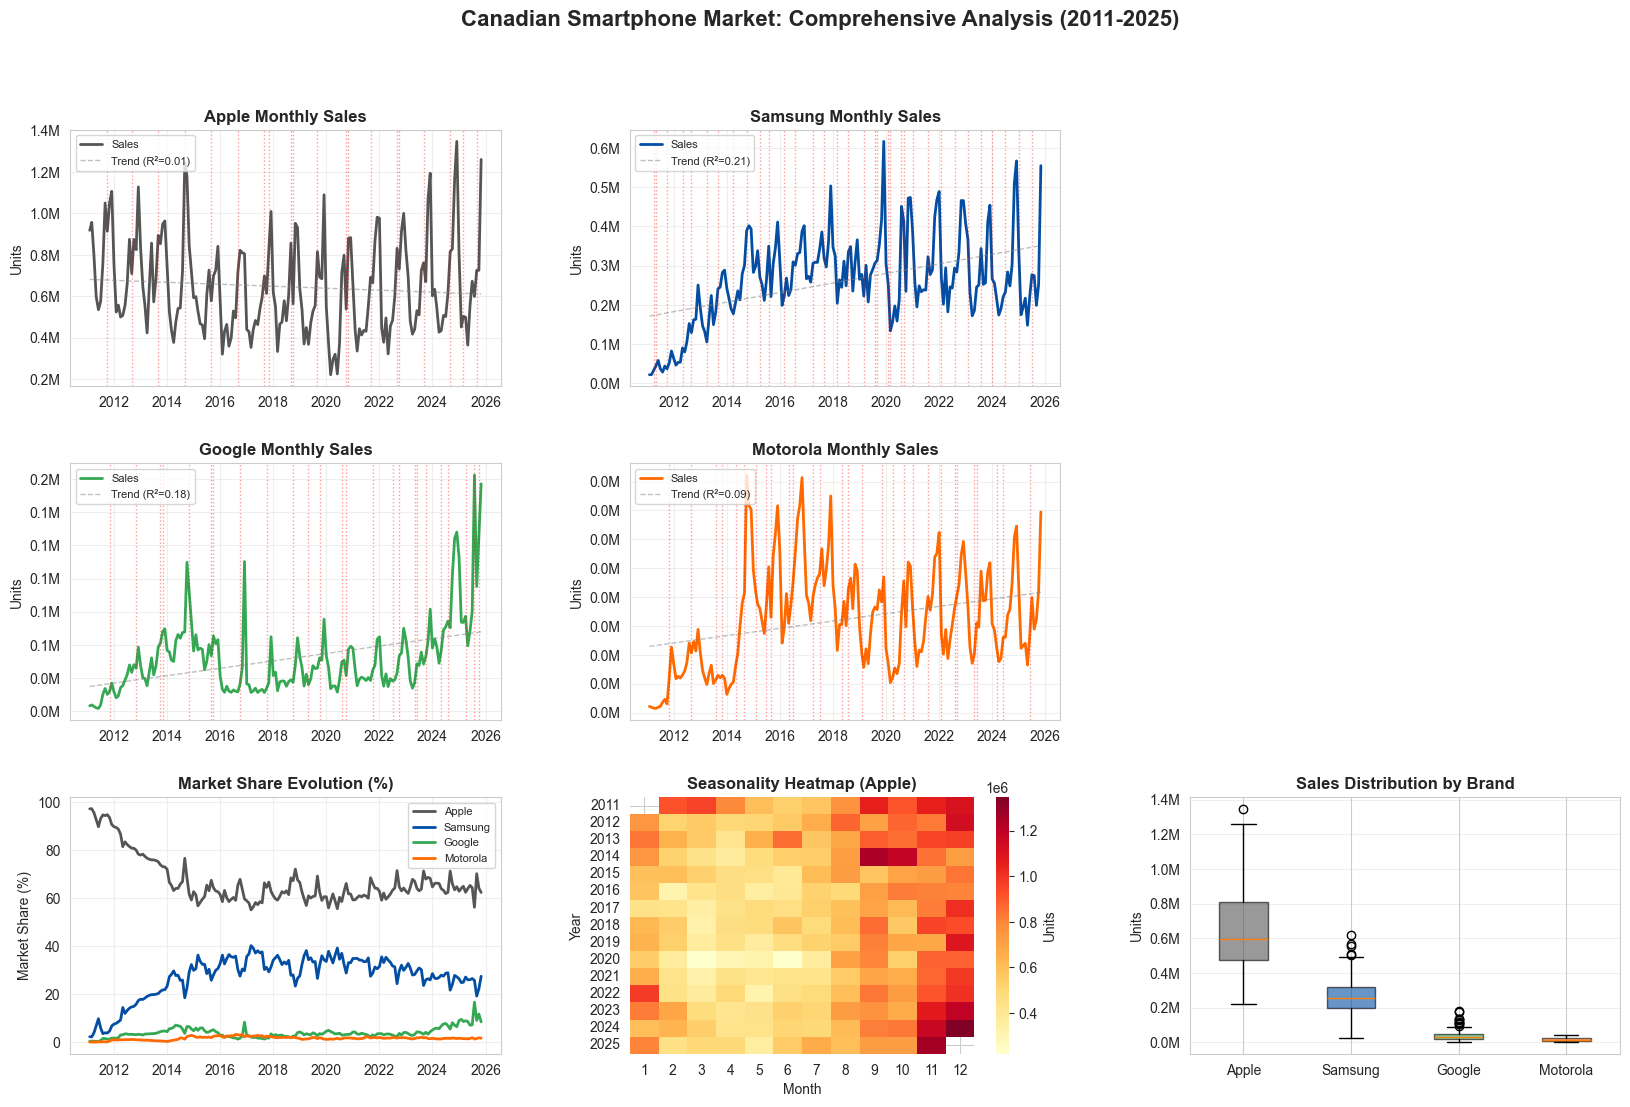


DIAGNOSIS REPORT CARD

Data Quality Score: 8/8 (100%)
Status: ✅ EXCELLENT

✅ DATA READY FOR PRODUCTION MODELING

💾 Validated dataset saved: canada_smartphones_VALIDATED.csv

READY TO PROCEED TO MODEL TESTING


In [48]:
# ================================================================
# Comprehensive Diagnosis & Visualization
# ================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def comprehensive_diagnosis_and_visualization(df):
    """
    Production-grade data diagnosis with statistical tests and visualization
    """
    
    print("="*70)
    print("COMPREHENSIVE DATA DIAGNOSIS & VALIDATION")
    print("="*70)
    
    # =====================================================
    # SECTION 1: STRUCTURAL VALIDATION
    # =====================================================
    print("\n[1/6] STRUCTURAL VALIDATION")
    print("-"*70)
    
    print(f"📊 Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"📅 Time Range: {df['month'].min().date()} to {df['month'].max().date()}")
    print(f"📆 Total Months: {len(df)}")
    
    # Check chronological order
    if df['month'].is_monotonic_increasing:
        print("✓ Data is chronologically sorted")
    else:
        print("❌ WARNING: Data not chronologically sorted")
    
    # Check for duplicates
    dupes = df[df.duplicated('month', keep=False)]
    if len(dupes) == 0:
        print("✓ No duplicate months")
    else:
        print(f"❌ CRITICAL: {len(dupes)} duplicate months found")
    
    # =====================================================
    # SECTION 2: COMPLETENESS CHECK
    # =====================================================
    print("\n[2/6] COMPLETENESS CHECK")
    print("-"*70)
    
    # Missing values by column
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("⚠️ Missing Values Detected:")
        for col, count in missing[missing > 0].items():
            print(f"   {col}: {count} ({count/len(df)*100:.1f}%)")
    else:
        print("✓ No missing values")
    
    # Time gaps
    full_range = pd.date_range(df['month'].min(), df['month'].max(), freq='MS')
    gaps = set(full_range) - set(df['month'])
    if gaps:
        print(f"⚠️ {len(gaps)} time gaps detected:")
        print(f"   {sorted([d.strftime('%Y-%m') for d in gaps])[:5]}...")
    else:
        print("✓ No time gaps - continuous monthly series")
    
    # =====================================================
    # SECTION 3: DATA QUALITY METRICS
    # =====================================================
    print("\n[3/6] DATA QUALITY METRICS")
    print("-"*70)
    
    sales_cols = ['Apple_units', 'Samsung_units', 'Google_units', 'Motorola_units']
    
    print("\nDescriptive Statistics:")
    stats = df[sales_cols].describe().round(0)
    print(stats)
    
    # Check for zero/negative values
    print("\nZero/Negative Value Check:")
    for col in sales_cols:
        zeros = len(df[df[col] <= 0])
        if zeros > 0:
            print(f"   ⚠️ {col}: {zeros} months with zero/negative values")
        else:
            print(f"   ✓ {col}: All positive values")
    
    # Outlier detection (IQR method)
    print("\nOutlier Detection (IQR Method):")
    for col in sales_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        outliers = df[(df[col] < Q1 - 3*IQR) | (df[col] > Q3 + 3*IQR)]
        
        if len(outliers) > 0:
            print(f"   ℹ️ {col}: {len(outliers)} outliers detected (±3 IQR)")
            # Show outlier months
            outlier_months = outliers['month'].dt.strftime('%Y-%m').tolist()
            print(f"      Months: {', '.join(outlier_months[:3])}{'...' if len(outlier_months) > 3 else ''}")
        else:
            print(f"   ✓ {col}: No extreme outliers")
    
    # =====================================================
    # SECTION 4: STATIONARITY TESTS
    # =====================================================
    print("\n[4/6] STATIONARITY TESTS (ADF)")
    print("-"*70)
    
    for col in sales_cols:
        result = adfuller(df[col].dropna())
        
        print(f"\n{col}:")
        print(f"   ADF Statistic: {result[0]:.4f}")
        print(f"   p-value: {result[1]:.4f}")
        
        if result[1] < 0.05:
            print(f"   ✓ STATIONARY (p < 0.05)")
        else:
            print(f"   ⚠️ NON-STATIONARY (p ≥ 0.05)")
            print(f"   → Use d=1 (differencing) in SARIMA models")
    
    # =====================================================
    # SECTION 5: SEASONALITY ANALYSIS
    # =====================================================
    print("\n[5/6] SEASONALITY ANALYSIS")
    print("-"*70)
    
    # Quarterly patterns
    quarterly_avg = df.groupby(df['month'].dt.quarter)['Apple_units'].mean()
    
    print("\nQuarterly Patterns (Apple as proxy):")
    for q in [1, 2, 3, 4]:
        pct_of_avg = (quarterly_avg[q] / quarterly_avg.mean() - 1) * 100
        print(f"   Q{q}: {quarterly_avg[q]:,.0f} units ({pct_of_avg:+.1f}% vs avg)")
    
    q4_premium = (quarterly_avg[4] / quarterly_avg[1] - 1) * 100
    
    if q4_premium > 15:
        print(f"\n✓ Strong Q4 seasonality detected (+{q4_premium:.1f}% vs Q1)")
    else:
        print(f"\n⚠️ Weak Q4 seasonality (+{q4_premium:.1f}% vs Q1)")
    
    # Monthly patterns
    monthly_avg = df.groupby(df['month'].dt.month)['Apple_units'].mean()
    peak_month = monthly_avg.idxmax()
    trough_month = monthly_avg.idxmin()
    
    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    
    print(f"\nMonthly Patterns:")
    print(f"   Peak month: {month_names[peak_month]} ({monthly_avg[peak_month]:,.0f} units)")
    print(f"   Trough month: {month_names[trough_month]} ({monthly_avg[trough_month]:,.0f} units)")
    print(f"   Seasonality range: {(monthly_avg.max() / monthly_avg.min() - 1) * 100:.1f}%")
    
    # =====================================================
    # SECTION 6: FEATURE VALIDATION
    # =====================================================
    print("\n[6/6] FEATURE VALIDATION")
    print("-"*70)
    
    # Launch indicators
    launch_cols = ['launch_apple', 'launch_samsung', 'launch_google', 'launch_motorola']
    existing_launch_cols = [c for c in launch_cols if c in df.columns]
    
    print("\nLaunch Indicator Coverage:")
    for col in existing_launch_cols:
        launch_count = df[col].sum()
        print(f"   {col.replace('launch_', '').title()}: {launch_count} launch months")
    
    # Regressor availability
    print("\nExternal Regressors:")
    regressors = ['cpi_index', 'is_holiday_season', 'is_q4', 'is_back_to_school']
    for reg in regressors:
        if reg in df.columns:
            non_null = df[reg].notna().sum()
            print(f"   ✓ {reg}: {non_null}/{len(df)} values")
        else:
            print(f"   ❌ {reg}: NOT FOUND")
    
    # =====================================================
    # VISUALIZATION
    # =====================================================
    print("\n" + "="*70)
    print("GENERATING VISUALIZATIONS")
    print("="*70)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Brand colors
    brand_configs = {
        'Apple': {'color': '#555555', 'launch': 'launch_apple'},
        'Samsung': {'color': '#034EA2', 'launch': 'launch_samsung'},
        'Google': {'color': '#34A853', 'launch': 'launch_google'},
        'Motorola': {'color': '#FF6900', 'launch': 'launch_motorola'}
    }
    
    # Plot 1-4: Individual brand trends with launches (2x2 grid)
    for idx, (brand, config) in enumerate(brand_configs.items()):
        ax = fig.add_subplot(gs[idx // 2, idx % 2])
        
        col = f'{brand}_units'
        launch_col = config['launch']
        
        # Sales line
        ax.plot(df['month'], df[col], color=config['color'], linewidth=2, label='Sales')
        
        # Launch indicators
        if launch_col in df.columns:
            launches = df[df[launch_col] == 1]
            for launch_date in launches['month']:
                ax.axvline(x=launch_date, color='red', linestyle=':', alpha=0.4, linewidth=1)
        
        # Styling
        ax.set_title(f'{brand} Monthly Sales', fontsize=12, weight='bold')
        ax.set_ylabel('Units', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
        
        # Add trend line
        from scipy import stats
        x_numeric = np.arange(len(df))
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, df[col])
        trend_line = slope * x_numeric + intercept
        ax.plot(df['month'], trend_line, '--', color='gray', alpha=0.5, linewidth=1, label=f'Trend (R²={r_value**2:.2f})')
        
        ax.legend(loc='upper left', fontsize=8)
    
    # Plot 5: Market share evolution
    ax5 = fig.add_subplot(gs[2, 0])
    
    df_plot = df.copy()
    df_plot['total'] = df_plot[sales_cols].sum(axis=1)
    
    for brand, config in brand_configs.items():
        col = f'{brand}_units'
        df_plot[f'{brand}_share'] = (df_plot[col] / df_plot['total'] * 100)
        ax5.plot(df_plot['month'], df_plot[f'{brand}_share'], 
                color=config['color'], linewidth=2, label=brand)
    
    ax5.set_title('Market Share Evolution (%)', fontsize=12, weight='bold')
    ax5.set_ylabel('Market Share (%)', fontsize=10)
    ax5.legend(loc='best', fontsize=8)
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Seasonality heatmap
    ax6 = fig.add_subplot(gs[2, 1])
    
    df_pivot = df.copy()
    df_pivot['year'] = df_pivot['month'].dt.year
    df_pivot['month_num'] = df_pivot['month'].dt.month
    
    pivot_data = df_pivot.pivot_table(
        values='Apple_units', 
        index='year', 
        columns='month_num',
        aggfunc='mean'
    )
    
    sns.heatmap(pivot_data, cmap='YlOrRd', ax=ax6, cbar_kws={'label': 'Units'}, fmt='.0f')
    ax6.set_title('Seasonality Heatmap (Apple)', fontsize=12, weight='bold')
    ax6.set_xlabel('Month', fontsize=10)
    ax6.set_ylabel('Year', fontsize=10)
    
    # Plot 7: Distribution comparison
    ax7 = fig.add_subplot(gs[2, 2])
    
    box_data = [df[col].dropna() for col in sales_cols]
    box_labels = [col.replace('_units', '') for col in sales_cols]
    
    bp = ax7.boxplot(box_data, labels=box_labels, patch_artist=True)
    
    for patch, brand in zip(bp['boxes'], brand_configs.keys()):
        patch.set_facecolor(brand_configs[brand]['color'])
        patch.set_alpha(0.6)
    
    ax7.set_title('Sales Distribution by Brand', fontsize=12, weight='bold')
    ax7.set_ylabel('Units', fontsize=10)
    ax7.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    ax7.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Canadian Smartphone Market: Comprehensive Analysis (2011-2025)', 
                 fontsize=16, weight='bold', y=0.98)
    
    plt.savefig('comprehensive_diagnosis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # =====================================================
    # FINAL REPORT CARD
    # =====================================================
    print("\n" + "="*70)
    print("DIAGNOSIS REPORT CARD")
    print("="*70)
    
    score = 0
    total_checks = 8
    
    # Scoring
    if df['month'].is_monotonic_increasing: score += 1
    if len(dupes) == 0: score += 1
    if missing.sum() == 0: score += 1
    if not gaps: score += 1
    if all(df[col].min() > 0 for col in sales_cols): score += 1
    if q4_premium > 10: score += 1
    if all(c in df.columns for c in existing_launch_cols): score += 1
    if 'cpi_index' in df.columns: score += 1
    
    grade = (score / total_checks) * 100
    
    if grade >= 90:
        status = "✅ EXCELLENT"
    elif grade >= 75:
        status = "✓ GOOD"
    elif grade >= 60:
        status = "⚠️ ACCEPTABLE"
    else:
        status = "❌ NEEDS IMPROVEMENT"
    
    print(f"\nData Quality Score: {score}/{total_checks} ({grade:.0f}%)")
    print(f"Status: {status}")
    
    if grade >= 75:
        print("\n✅ DATA READY FOR PRODUCTION MODELING")
    else:
        print("\n⚠️ REVIEW ISSUES BEFORE PROCEEDING")
    
    # Save checkpoint
    filename = "canada_smartphones_VALIDATED.csv"
    df.to_csv(filename, index=False)
    print(f"\n💾 Validated dataset saved: {filename}")
    
    return grade >= 75

# ==========================================
# EXECUTION
# ==========================================

if 'df_modeling' in globals():
    is_ready = comprehensive_diagnosis_and_visualization(df_modeling)
    
    if is_ready:
        print("\n" + "="*70)
        print("READY TO PROCEED TO MODEL TESTING")
        print("="*70)
else:
    print("⚠️ 'df_modeling' not found. Please run the previous cell first.")

In [49]:
# ================================================================
# Statistical Validation (Stationarity, Outliers, Seasonality)
# ================================================================

import pandas as pd
import numpy as np
from typing import Dict, Tuple, List
from statsmodels.tsa.stattools import adfuller

class StatisticalValidator:
    """
    Statistical validation focused on:
    - Stationarity (ADF tests)
    - Outlier detection (IQR method)
    - Seasonality verification
    """
    
    def __init__(self, df: pd.DataFrame, config: Dict):
        self.df = df
        self.config = config
        self.results = {}
        
    def validate_all(self) -> Tuple[bool, Dict]:
        
        print("="*70)
        print("STATISTICAL VALIDATION")
        print("="*70)
        
        self._check_stationarity()
        self._check_outliers()
        self._check_seasonality()
        
        # Generate summary
        self._print_summary()
        
        return True, self.results
    
    def _check_stationarity(self):
        print("\n[1/3] STATIONARITY TESTS (Augmented Dickey-Fuller)")
        print("-"*70)
        
        stationarity_results = {}
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            col = f'{brand}_units'
            if col not in self.df.columns:
                continue
            
            # Run ADF test
            result = adfuller(self.df[col].dropna(), autolag='AIC')
            
            adf_stat = result[0]
            p_value = result[1]
            critical_values = result[4]
            
            is_stationary = p_value < 0.05
            
            print(f"\n{brand}:")
            print(f"   ADF Statistic: {adf_stat:.4f}")
            print(f"   p-value: {p_value:.4f}")
            print(f"   Critical Values:")
            for key, value in critical_values.items():
                print(f"      {key}: {value:.4f}")
            
            if is_stationary:
                print(f"   ✓ STATIONARY (reject H0 at α=0.05)")
                print(f"   → Can use SARIMA with d=0")
            else:
                print(f"   ⚠️ NON-STATIONARY (fail to reject H0)")
                print(f"   → Use SARIMA with d=1 (first-order differencing)")
            
            stationarity_results[brand] = {
                'adf_statistic': adf_stat,
                'p_value': p_value,
                'is_stationary': is_stationary,
                'recommended_d': 0 if is_stationary else 1,
                'critical_values': critical_values
            }
        
        self.results['stationarity'] = stationarity_results
    
    def _check_outliers(self):
        """IQR-based outlier detection with detailed reporting"""
        print("\n[2/3] OUTLIER DETECTION (Tukey's IQR Method)")
        print("-"*70)
        
        outlier_results = {}
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            col = f'{brand}_units'
            if col not in self.df.columns:
                continue
            
            # Calculate IQR
            Q1 = self.df[col].quantile(0.25)
            Q2 = self.df[col].quantile(0.50)  # Median
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Define outlier boundaries (3 × IQR for extreme outliers)
            lower_fence = Q1 - 3 * IQR
            upper_fence = Q3 + 3 * IQR
            
            # Identify outliers
            outliers = self.df[(self.df[col] < lower_fence) | (self.df[col] > upper_fence)]
            
            print(f"\n{brand}:")
            print(f"   Q1 (25th percentile): {Q1:,.0f}")
            print(f"   Q2 (median): {Q2:,.0f}")
            print(f"   Q3 (75th percentile): {Q3:,.0f}")
            print(f"   IQR: {IQR:,.0f}")
            print(f"   Lower fence: {lower_fence:,.0f}")
            print(f"   Upper fence: {upper_fence:,.0f}")
            
            if len(outliers) > 0:
                print(f"   ⚠️ {len(outliers)} extreme outliers detected")
                
                # Show outlier details
                outlier_months = outliers[['month', col]].copy()
                outlier_months['deviation'] = outlier_months[col].apply(
                    lambda x: f"{((x - Q2) / IQR):.2f}σ (IQR)"
                )
                
                print(f"\n   Outlier months:")
                for _, row in outlier_months.head(5).iterrows():
                    print(f"      {row['month'].strftime('%Y-%m')}: {row[col]:,.0f} units ({row['deviation']})")
                
                if len(outliers) > 5:
                    print(f"      ... and {len(outliers) - 5} more")
                
                print(f"\n   ℹ️ NOTE: Outliers retained in dataset (may be real events like COVID)")
            else:
                print(f"   ✓ No extreme outliers")
            
            outlier_results[brand] = {
                'Q1': Q1,
                'Q2': Q2,
                'Q3': Q3,
                'IQR': IQR,
                'lower_fence': lower_fence,
                'upper_fence': upper_fence,
                'outlier_count': len(outliers),
                'outlier_months': outliers['month'].tolist() if len(outliers) > 0 else []
            }
        
        self.results['outliers'] = outlier_results
    
    def _check_seasonality(self):
        """Comprehensive seasonality analysis"""
        print("\n[3/3] SEASONALITY ANALYSIS")
        print("-"*70)
        
        seasonality_results = {}
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            col = f'{brand}_units'
            if col not in self.df.columns:
                continue
            
            print(f"\n{brand}:")
            
            # Quarterly analysis
            quarterly = self.df.groupby(self.df['month'].dt.quarter)[col].agg(['mean', 'std'])
            overall_mean = quarterly['mean'].mean()
            
            print(f"   Quarterly Patterns:")
            for q in [1, 2, 3, 4]:
                q_mean = quarterly.loc[q, 'mean']
                q_std = quarterly.loc[q, 'std']
                deviation = (q_mean / overall_mean - 1) * 100
                
                print(f"      Q{q}: {q_mean:>8,.0f} units (±{q_std:>6,.0f}) | {deviation:+6.1f}% vs avg")
            
            # Calculate Q4 premium
            q4_premium = (quarterly.loc[4, 'mean'] / quarterly.loc[1, 'mean'] - 1) * 100
            
            if q4_premium > 20:
                seasonality_strength = "STRONG"
                icon = "✓"
            elif q4_premium > 10:
                seasonality_strength = "MODERATE"
                icon = "ℹ️"
            else:
                seasonality_strength = "WEAK"
                icon = "⚠️"
            
            print(f"\n   {icon} Q4 Premium: {q4_premium:+.1f}% vs Q1")
            print(f"   Seasonality Strength: {seasonality_strength}")
            
            # Monthly analysis (identify peak and trough)
            monthly = self.df.groupby(self.df['month'].dt.month)[col].mean()
            peak_month = monthly.idxmax()
            trough_month = monthly.idxmin()
            
            month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                          7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
            
            peak_trough_ratio = (monthly[peak_month] / monthly[trough_month] - 1) * 100
            
            print(f"   Peak month: {month_names[peak_month]} ({monthly[peak_month]:,.0f} units)")
            print(f"   Trough month: {month_names[trough_month]} ({monthly[trough_month]:,.0f} units)")
            print(f"   Peak-to-trough range: {peak_trough_ratio:.1f}%")
            
            # Coefficient of variation (measure of seasonality)
            cv = (quarterly['mean'].std() / quarterly['mean'].mean()) * 100
            print(f"   Coefficient of Variation: {cv:.1f}%")
            
            seasonality_results[brand] = {
                'quarterly_mean': quarterly['mean'].to_dict(),
                'q4_premium': q4_premium,
                'seasonality_strength': seasonality_strength,
                'peak_month': peak_month,
                'trough_month': trough_month,
                'peak_trough_ratio': peak_trough_ratio,
                'coefficient_of_variation': cv
            }
        
        self.results['seasonality'] = seasonality_results
    
    def _print_summary(self):
        """Print validation summary"""
        print("\n" + "="*70)
        print("STATISTICAL VALIDATION SUMMARY")
        print("="*70)
        
        # Stationarity summary
        print("\nStationarity Status:")
        for brand, results in self.results['stationarity'].items():
            status = "STATIONARY" if results['is_stationary'] else "NON-STATIONARY"
            rec_d = results['recommended_d']
            print(f"   {brand:12s}: {status:15s} | Recommended d={rec_d}")
        
        # Outlier summary
        print("\nOutlier Summary:")
        for brand, results in self.results['outliers'].items():
            count = results['outlier_count']
            if count > 0:
                print(f"   {brand:12s}: {count} extreme outliers detected (retained)")
            else:
                print(f"   {brand:12s}: No extreme outliers")
        
        # Seasonality summary
        print("\nSeasonality Summary:")
        for brand, results in self.results['seasonality'].items():
            strength = results['seasonality_strength']
            q4_prem = results['q4_premium']
            print(f"   {brand:12s}: {strength:10s} | Q4 Premium: {q4_prem:+.1f}%")
        
        print("\n✅ Statistical validation complete")
        print("   Results saved for model configuration")

# ==========================================
# EXECUTION
# ==========================================

validator = StatisticalValidator(df_modeling, CONF)
is_valid, statistical_results = validator.validate_all()

# Store results 
stat_validation_results = statistical_results

STATISTICAL VALIDATION

[1/3] STATIONARITY TESTS (Augmented Dickey-Fuller)
----------------------------------------------------------------------

Apple:
   ADF Statistic: -2.4210
   p-value: 0.1359
   Critical Values:
      1%: -3.4704
      5%: -2.8791
      10%: -2.5761
   ⚠️ NON-STATIONARY (fail to reject H0)
   → Use SARIMA with d=1 (first-order differencing)

Samsung:
   ADF Statistic: -4.3743
   p-value: 0.0003
   Critical Values:
      1%: -3.4704
      5%: -2.8791
      10%: -2.5761
   ✓ STATIONARY (reject H0 at α=0.05)
   → Can use SARIMA with d=0

Google:
   ADF Statistic: -0.2912
   p-value: 0.9267
   Critical Values:
      1%: -3.4711
      5%: -2.8794
      10%: -2.5763
   ⚠️ NON-STATIONARY (fail to reject H0)
   → Use SARIMA with d=1 (first-order differencing)

Motorola:
   ADF Statistic: -2.4272
   p-value: 0.1342
   Critical Values:
      1%: -3.4709
      5%: -2.8793
      10%: -2.5763
   ⚠️ NON-STATIONARY (fail to reject H0)
   → Use SARIMA with d=1 (first-order diff

In [50]:
# ================================================================
# Essential Feature Engineering
# ================================================================

import pandas as pd
import numpy as np

class EssentialFeatureEngineer:
    """
    Add critical features for production models
    """
    
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
    
    def engineer_all(self) -> pd.DataFrame:
        
        print("="*70)
        print("ESSENTIAL FEATURE ENGINEERING")
        print("="*70)
        
        self.df = self._add_time_index()
        self.df = self._add_lag_features()
        self.df = self._add_rolling_features()
        
        print(f"\n✅ Total features: {len(self.df.columns)}")
        
        return self.df
    
    def _add_time_index(self) -> pd.DataFrame:
        print("\n[1/3] Time Index (for trend)")
        
        df = self.df.copy()
        
        # Linear time index (0, 1, 2, ...)
        df['time_index'] = range(len(df))
        
        print(f"   ✓ Added time_index (captures long-term trend)")
        
        return df
    
    def _add_lag_features(self) -> pd.DataFrame:
        print("\n[2/3] Lag Features")
        
        df = self.df.copy()
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            col = f'{brand}_units'
            if col not in df.columns:
                continue
            
            # Lag 1 month (recent history)
            df[f'{brand}_lag1'] = df[col].shift(1)
            
            # Lag 12 months (year-over-year comparison)
            df[f'{brand}_lag12'] = df[col].shift(12)
            
            print(f"   ✓ {brand}: lag1, lag12")
        
        print(f"   ✓ Added 8 lag features (2 per brand)")
        
        return df
    
    def _add_rolling_features(self) -> pd.DataFrame:
        print("\n[3/3] Rolling Statistics")
        
        df = self.df.copy()
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            col = f'{brand}_units'
            if col not in df.columns:
                continue
            
            # 3-month moving average (short-term trend)
            df[f'{brand}_ma3'] = df[col].rolling(3, min_periods=1).mean()
            
            # 12-month moving average (annual trend)
            df[f'{brand}_ma12'] = df[col].rolling(12, min_periods=1).mean()
            
            print(f"   ✓ {brand}: ma3, ma12")
        
        print(f"   ✓ Added 8 rolling features (2 per brand)")
        
        return df

# ==========================================
# EXECUTION
# ==========================================

engineer = EssentialFeatureEngineer(df_modeling)
df_features = engineer.engineer_all()

# Handle NaN from lags (first 12 rows will have NaN in lag12)
print(f"\nBefore dropna: {len(df_features)} rows")
df_features = df_features.dropna()
print(f"After dropna: {len(df_features)} rows")

print(f"\n✅ Feature engineering complete")
print(f"Final columns: {list(df_features.columns)}")

ESSENTIAL FEATURE ENGINEERING

[1/3] Time Index (for trend)
   ✓ Added time_index (captures long-term trend)

[2/3] Lag Features
   ✓ Apple: lag1, lag12
   ✓ Samsung: lag1, lag12
   ✓ Google: lag1, lag12
   ✓ Motorola: lag1, lag12
   ✓ Added 8 lag features (2 per brand)

[3/3] Rolling Statistics
   ✓ Apple: ma3, ma12
   ✓ Samsung: ma3, ma12
   ✓ Google: ma3, ma12
   ✓ Motorola: ma3, ma12
   ✓ Added 8 rolling features (2 per brand)

✅ Total features: 34

Before dropna: 178 rows
After dropna: 166 rows

✅ Feature engineering complete
Final columns: ['month', 'Apple_units', 'Samsung_units', 'Google_units', 'Motorola_units', 'cpi_index', 'month_num', 'year', 'quarter', 'is_holiday_season', 'is_back_to_school', 'is_black_friday', 'is_new_year_promo', 'launch_apple', 'launch_samsung', 'launch_google', 'launch_motorola', 'time_index', 'Apple_lag1', 'Apple_lag12', 'Samsung_lag1', 'Samsung_lag12', 'Google_lag1', 'Google_lag12', 'Motorola_lag1', 'Motorola_lag12', 'Apple_ma3', 'Apple_ma12', 'Samsu

In [51]:
# ============================================================
# TRANSFORMATION HELPERS (For Log-Transform + Split-then-Scale)
# ============================================================
"""
Log-transform + Split-then-Scale pattern for all 8 models
"""

from sklearn.preprocessing import StandardScaler

def transform_target(y):
    """
    Log-transform target
    """
    return np.log1p(y)


def inverse_transform_target(y_log):
    """
    Inverse log-transform
    """
    return np.clip(np.expm1(y_log), 0, None)


def scale_data_split(X_train, X_test, y_train_log, y_test_log):
    """
    Scale features and target AFTER split (prevents leakage)
    """
    # Fit scalers on TRAIN only
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Transform train
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1, 1)).ravel()
    
    # Transform test (using TRAIN scaler)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test_log.reshape(-1, 1)).ravel()
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y


def inverse_scale_predictions(y_scaled, scaler_y):
    """
    Inverse scale predictions 
    """
    return scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).ravel()


print("✅ Transformation helpers loaded (log + split-then-scale)")

✅ Transformation helpers loaded (log + split-then-scale)


In [52]:
# ================================================================
# Train/Test Split for Validation
# ================================================================

import pandas as pd

# ------------------------------------------------
# Brand-Specific Data Start Dates                      
# Filters regime changes and pre-era noise for cleaner training  
# ------------------------------------------------

# START DATES (Based on Product Line Changes):
BRAND_START_DATES = {
    'Apple': '2011-01-01',    # Keep full history
                              # Reasoning: iPhone 4S (Oct 2011) onwards - consistent product line
                              # All iPhones follow same premium positioning
    
    'Samsung': '2011-01-01',  # Keep full history  
                              # Reasoning: Galaxy S2 era onwards - flagship strategy consistent
                              # S-series + Note/Fold dual strategy maintained throughout
    
    'Google': '2016-10-01',   # ← CRITICAL: Pixel 1 launch (October 2016)
                              # Reasoning: Nexus era (2011-2016) was fundamentally different:
                              #   - Developer phones, not mass market
                              #   - Different pricing ($349-$499 vs $699-$999)
                              #   - Different distribution (Google Store only vs carriers)
                              #   - Inconsistent launch cadence
                              # Pixel era has consistent premium strategy
    
    'Motorola': '2014-01-01'  # ← Lenovo acquisition era (January 2014)
                              # Reasoning: Pre-2014 was Google ownership with erratic strategy
                              # Post-2014 Lenovo brought consistent G-series volume strategy
                              # G-series (budget/mid-range) became Canada volume driver
}

def create_train_test_split(df, test_months=12):
    """
    Create train/test split for time series
    """
    
    print("="*70)
    print("TRAIN/TEST SPLIT")
    print("="*70)
    
    # Find split point (last N months = test)
    cutoff_date = df['month'].max() - pd.DateOffset(months=test_months-1)
    
    df_train = df[df['month'] < cutoff_date].copy()
    df_test = df[df['month'] >= cutoff_date].copy()
    
    print(f"\nGlobal Train Set:")
    print(f"  Date range: {df_train['month'].min().date()} to {df_train['month'].max().date()}")
    print(f"  Months: {len(df_train)}")
    
    print(f"\nGlobal Test Set:")
    print(f"  Date range: {df_test['month'].min().date()} to {df_test['month'].max().date()}")
    print(f"  Months: {len(df_test)}")
    
    print(f"\n✅ Split created: {len(df_train)} train, {len(df_test)} test")
    
    # ----------------------------------------------------------------
    # Show brand-specific effective training lengths 
    # ----------------------------------------------------------------
    print(f"\n📊 Brand-Specific Training Lengths (after regime filters):")
    print(f"{'Brand':<12} {'Start Date':<12} {'Train Months':<15} {'Test Months':<12}")
    print("─" * 55)
    
    for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        
        # Calculate effective training length
        brand_train = df_train[df_train['month'] >= start_date]
        brand_test = df_test[df_test['month'] >= start_date]
        
        print(f"{brand:<12} {start_date:<12} {len(brand_train):<15} {len(brand_test):<12}")
    
    print("\n⚠️  Models will apply these filters automatically during training")
    
    return df_train, df_test

# Execute
df_train, df_test = create_train_test_split(df_features, test_months=12)

TRAIN/TEST SPLIT

Global Train Set:
  Date range: 2012-02-01 to 2024-11-01
  Months: 154

Global Test Set:
  Date range: 2024-12-01 to 2025-11-01
  Months: 12

✅ Split created: 154 train, 12 test

📊 Brand-Specific Training Lengths (after regime filters):
Brand        Start Date   Train Months    Test Months 
───────────────────────────────────────────────────────
Apple        2011-01-01   154             12          
Samsung      2011-01-01   154             12          
Google       2016-10-01   98              12          
Motorola     2014-01-01   131             12          

⚠️  Models will apply these filters automatically during training


In [53]:
# ================================================================
# Baseline Forecast Generation
# ================================================================
"""
PURPOSE: Establish "dumb baseline" forecasts to prove ML adds value
"""

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("BASELINE FORECAST GENERATION")
print("="*70)
print("Creating simple forecasts to benchmark ML models against")
print("="*70)

# ================================================================
# VALIDATION: Ensure prerequisites exist
# ================================================================

if 'df_train' not in globals() or 'df_test' not in globals():
    raise RuntimeError(
        "❌ ERROR: df_train and df_test not found.\n"
        "   Action: Run Cell 11 (Train/Test Split) first!"
    )

# ================================================================
# CONFIGURATION
# ================================================================

# Define baseline methods
BASELINE_METHODS = {
    'naive': 'Last month carried forward',
    'seasonal_naive': 'Same month last year (SPLY)',
    'moving_avg_3': '3-month moving average',
    'moving_avg_6': '6-month moving average'
}

# Brands to forecast
BRANDS = CONF.get('TARGET_BRANDS', ['Apple', 'Samsung', 'Google', 'Motorola'])

# ================================================================
# BASELINE GENERATOR CLASS
# ================================================================

class BaselineForecaster:
    """
    Generates simple baseline forecasts for benchmarking ML models
    """
    
    def __init__(self, df_train, df_test):
        self.df_train = df_train
        self.df_test = df_test
        self.n_forecast = len(df_test)
        
        print(f"\nInitializing Baseline Forecaster:")
        print(f"  Training data: {len(df_train)} months")
        print(f"  Test data: {len(df_test)} months")
        print(f"  Train period: {df_train['month'].min().date()} to {df_train['month'].max().date()}")
        print(f"  Test period: {df_test['month'].min().date()} to {df_test['month'].max().date()}")
    
    def generate_all_baselines(self, brands):
        """
        Generate all baseline forecasts for all brands
        """
        
        baselines = {}
        
        for brand in brands:
            print(f"\n{'─'*70}")
            print(f"GENERATING BASELINES: {brand}")
            print(f"{'─'*70}")
            
            target_col = self._get_target_col(brand)
            
            if target_col not in self.df_train.columns:
                print(f"  ⚠️  Column '{target_col}' not found, skipping {brand}")
                continue
            
            baselines[brand] = {}
            
            # Generate each baseline method
            baselines[brand]['naive'] = self._naive_forecast(target_col)
            baselines[brand]['seasonal_naive'] = self._seasonal_naive_forecast(target_col)
            baselines[brand]['moving_avg_3'] = self._moving_average_forecast(target_col, window=3)
            baselines[brand]['moving_avg_6'] = self._moving_average_forecast(target_col, window=6)
            
            # Calculate metrics for each baseline
            if target_col in self.df_test.columns:
                y_test = self.df_test[target_col].values
                
                print(f"\n  Baseline Performance Summary:")
                print(f"  {'Method':<25} {'MAPE':>8} {'RMSE':>12} {'MAE':>12}")
                print(f"  {'-'*68}")
                
                for method, forecast in baselines[brand].items():
                    mape = mean_absolute_percentage_error(y_test, forecast) * 100
                    rmse = np.sqrt(mean_squared_error(y_test, forecast))
                    mae = np.mean(np.abs(y_test - forecast))
                    
                    method_display = BASELINE_METHODS.get(method, method)
                    print(f"  {method_display:<25} {mape:>7.2f}% {rmse:>11,.0f} {mae:>11,.0f}")
        
        return baselines
    
    def _naive_forecast(self, target_col):
        """
        Naive forecast: Last value in training set repeated
        """
        
        last_value = self.df_train[target_col].iloc[-1]
        forecast = np.full(self.n_forecast, last_value)
        
        print(f"  ✓ Naive: Last value = {last_value:,.0f} units")
        
        return forecast
    
    def _seasonal_naive_forecast(self, target_col):
        """
        Seasonal Naive (SPLY): Same month last year
        """
        
        # Get last 12 months of training data
        train_values = self.df_train[target_col].values
        
        if len(train_values) >= 12:
            last_12_months = train_values[-12:]
        else:
            # Fallback for brands with < 12 months (shouldn't happen)
            print(f"  ⚠️  Warning: Only {len(train_values)} months available, using all data")
            last_12_months = np.tile(train_values, 12 // len(train_values) + 1)[:12]
        
        # Repeat pattern for test period
        n_repeats = int(np.ceil(self.n_forecast / 12))
        forecast = np.tile(last_12_months, n_repeats)[:self.n_forecast]
        
        print(f"  ✓ Seasonal Naive: Using last 12 months pattern")
        print(f"    Range: {last_12_months.min():,.0f} - {last_12_months.max():,.0f} units")
        
        return forecast
    
    def _moving_average_forecast(self, target_col, window=3):
        """
        Moving Average: Average of last N months repeated
        """
        
        train_values = self.df_train[target_col].values
        
        if len(train_values) < window:
            print(f"  ⚠️  Warning: Training data ({len(train_values)} months) < window ({window})")
            window = max(1, len(train_values))  # Use all available data
        
        ma_value = np.mean(train_values[-window:])
        forecast = np.full(self.n_forecast, ma_value)
        
        print(f"  ✓ Moving Average ({window}-month): {ma_value:,.0f} units")
        
        return forecast
    
    def _get_target_col(self, brand):
        """Auto-detect target column name"""
        col = f'{brand}_units'
        return col if col in self.df_train.columns else f'{brand.lower()}_units'

# ================================================================
# EXECUTE BASELINE GENERATION
# ================================================================

baseline_forecaster = BaselineForecaster(df_train, df_test)
baseline_forecasts = baseline_forecaster.generate_all_baselines(BRANDS)

# ================================================================
# STORE RESULTS IN CONF
# ================================================================

CONF['BASELINE_FORECASTS'] = baseline_forecasts

print("\n" + "="*70)
print("BASELINE GENERATION COMPLETE")
print("="*70)
print(f"✅ Generated {len(baseline_forecasts)} brand baselines")
print(f"✅ {len(BASELINE_METHODS)} methods per brand")
print(f"✅ Stored in CONF['BASELINE_FORECASTS']")
print("\n💡 Next: Run Cell 11.6 to evaluate baseline performance")
print("="*70)

BASELINE FORECAST GENERATION
Creating simple forecasts to benchmark ML models against

Initializing Baseline Forecaster:
  Training data: 154 months
  Test data: 12 months
  Train period: 2012-02-01 to 2024-11-01
  Test period: 2024-12-01 to 2025-11-01

──────────────────────────────────────────────────────────────────────
GENERATING BASELINES: Apple
──────────────────────────────────────────────────────────────────────
  ✓ Naive: Last value = 1,163,524 units
  ✓ Seasonal Naive: Using last 12 months pattern
    Range: 426,543 - 1,193,121 units
  ✓ Moving Average (3-month): 935,652 units
  ✓ Moving Average (6-month): 738,086 units

  Baseline Performance Summary:
  Method                        MAPE         RMSE          MAE
  --------------------------------------------------------------------
  Last month carried forward   92.09%     540,783     501,244
  Same month last year (SPLY)   15.79%     118,882     103,697
  3-month moving average      61.00%     370,351     349,329
  6-month

In [54]:
# ================================================================
# Baseline Performance Benchmark
# ================================================================
"""
PURPOSE: Evaluate and visualize baseline forecast performance
"""

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("BASELINE PERFORMANCE BENCHMARK")
print("="*70)
print("Establishing the 'floor' that ML models must beat")
print("="*70)

# ================================================================
# VALIDATION: Ensure previous Cell was run
# ================================================================

if 'BASELINE_FORECASTS' not in CONF:
    raise RuntimeError(
        "❌ ERROR: BASELINE_FORECASTS not found in CONF.\n"
        "   Action: Run Cell: Baseline Generation first!"
    )

if 'df_test' not in globals():
    raise RuntimeError(
        "❌ ERROR: df_test not found.\n"
        "   Action: Run Train/Test Split Cell first!"
    )

# ================================================================
# CONFIGURATION
# ================================================================

BRANDS = CONF.get('TARGET_BRANDS', ['Apple', 'Samsung', 'Google', 'Motorola'])
baseline_forecasts = CONF['BASELINE_FORECASTS']

# Thresholds for "beating baseline"
IMPROVEMENT_THRESHOLDS = {
    'strong': 15,      # >15% improvement = clearly better
    'good': 5,     # 5-15% improvement = good gain
    'needs review': 0  # <5% improvement = needs review
}

# ================================================================
# BASELINE EVALUATOR CLASS
# ================================================================

class BaselineEvaluator:
    """
    Comprehensive evaluation of baseline forecast performance
    """
    
    def __init__(self, baseline_forecasts, df_test):
        self.baseline_forecasts = baseline_forecasts
        self.df_test = df_test
        self.results = {}
        self.best_baselines = {}
    
    def evaluate_all(self):
        """
        Evaluate all baselines and store results
        """
        
        print("\n📊 DETAILED BASELINE EVALUATION")
        print("="*70)
        
        for brand in self.baseline_forecasts.keys():
            print(f"\n{brand}:")
            print(f"{'─'*70}")
            
            target_col = self._get_target_col(brand)
            
            if target_col not in self.df_test.columns:
                print(f"  ⚠️  Test data missing '{target_col}', skipping")
                continue
            
            y_test = self.df_test[target_col].values
            
            self.results[brand] = {}
            
            # Header
            print(f"{'Method':<25} {'MAPE':>8} {'RMSE':>12} {'MAE':>12} {'Status':<12}")
            print(f"{'-'*72}")
            
            # Evaluate each method
            method_mapes = {}
            
            for method, forecast in self.baseline_forecasts[brand].items():
                metrics = self._calculate_metrics(y_test, forecast)
                self.results[brand][method] = metrics
                method_mapes[method] = metrics['mape']
                
                # Determine status
                if metrics['mape'] < 15:
                    status = "✅ Excellent"
                elif metrics['mape'] < 25:
                    status = "✓ Good"
                elif metrics['mape'] < 35:
                    status = "⚠️ Fair"
                else:
                    status = "❌ Poor"
                
                # Display name
                method_name = {
                    'naive': 'Naive (Last Month)',
                    'seasonal_naive': 'Seasonal Naive (SPLY)',
                    'moving_avg_3': 'Moving Avg (3-month)',
                    'moving_avg_6': 'Moving Avg (6-month)'
                }.get(method, method)
                
                print(f"{method_name:<25} {metrics['mape']:>7.2f}% "
                      f"{metrics['rmse']:>11,.0f} {metrics['mae']:>11,.0f} {status:<12}")
            
            # Identify best baseline
            best_method = min(method_mapes, key=method_mapes.get)
            best_mape = method_mapes[best_method]
            self.best_baselines[brand] = {
                'method': best_method,
                'mape': best_mape
            }
            
            best_name = {
                'naive': 'Naive',
                'seasonal_naive': 'SPLY',
                'moving_avg_3': 'MA-3',
                'moving_avg_6': 'MA-6'
            }.get(best_method, best_method)
            
            print(f"{'-'*72}")
            print(f"🏆 BEST BASELINE: {best_name} ({best_mape:.2f}% MAPE)")
            print(f"   → ML models must beat this to justify complexity")
        
        return self.results
    
    def _calculate_metrics(self, y_true, y_pred):
        """Calculate comprehensive error metrics"""
        
        # Handle potential zero values
        mask = y_true > 0
        y_true_safe = y_true[mask]
        y_pred_safe = y_pred[mask]
        
        if len(y_true_safe) == 0:
            return {
                'mape': 999.0,
                'rmse': 999999.0,
                'mae': 999999.0,
                'bias': 0.0
            }
        
        mape = mean_absolute_percentage_error(y_true_safe, y_pred_safe) * 100
        rmse = np.sqrt(mean_squared_error(y_true_safe, y_pred_safe))
        mae = mean_absolute_error(y_true_safe, y_pred_safe)
        
        # Also calculate bias (mean percentage error)
        bias = np.mean((y_pred_safe - y_true_safe) / y_true_safe) * 100
        
        return {
            'mape': mape,
            'rmse': rmse,
            'mae': mae,
            'bias': bias
        }
    
    def create_summary_table(self):
        """
        Create comparison summary table
        """
        
        print("\n" + "="*70)
        print("BASELINE SUMMARY: ML TARGET")
        print("="*70)
        print("\nTo justify ML complexity, models should beat these.")
        print(f"\n{'Brand':<12} {'Best Method':<20} {'MAPE':>8} {'Target MAPE':>12}")
        print(f"{'-'*70}")
        
        summary_data = []
        
        for brand in sorted(self.best_baselines.keys()):
            best = self.best_baselines[brand]
            method_name = {
                'naive': 'Naive',
                'seasonal_naive': 'SPLY',
                'moving_avg_3': 'MA-3',
                'moving_avg_6': 'MA-6'
            }.get(best['method'], best['method'])
            
            target_mape = best['mape'] 
            
            print(f"{brand:<12} {method_name:<20} {best['mape']:>7.2f}% "
                  f"<{target_mape:>10.2f}%")
            
            summary_data.append({
                'Brand': brand,
                'Best_Method': best['method'],
                'Best_MAPE': best['mape'],
                'ML_Target': target_mape
            })
        
        print(f"{'-'*70}")
        
        # Calculate average
        avg_best = np.mean([b['mape'] for b in self.best_baselines.values()])
        avg_target = avg_best 
        
        print(f"\n{'AVERAGE':<12} {'':<20} {avg_best:>7.2f}% <{avg_target:>10.2f}%")
        print("\n✓ These targets stored in CONF['BASELINE_TARGETS']")
        
        return pd.DataFrame(summary_data)
    
    def visualize_comparison(self):
        """
        Create visualization of baseline performance
        """
        
        print("\n📊 Generating visualization...")
        
        try:
            import matplotlib.pyplot as plt
            
            # Prepare data for plotting
            plot_data = []
            
            for brand in self.results.keys():
                for method, metrics in self.results[brand].items():
                    method_name = {
                        'naive': 'Naive',
                        'seasonal_naive': 'SPLY',
                        'moving_avg_3': 'MA-3',
                        'moving_avg_6': 'MA-6'
                    }.get(method, method)
                    
                    plot_data.append({
                        'Brand': brand,
                        'Method': method_name,
                        'MAPE': metrics['mape']
                    })
            
            df_plot = pd.DataFrame(plot_data)
            
            # Create figure
            fig, ax = plt.subplots(figsize=(12, 6))
            
            # Grouped bar chart
            brands = sorted(df_plot['Brand'].unique())
            methods = ['Naive', 'SPLY', 'MA-3', 'MA-6']
            x = np.arange(len(brands))
            width = 0.2
            
            colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFA07A']
            
            for i, method in enumerate(methods):
                method_data = df_plot[df_plot['Method'] == method]
                values = []
                for b in brands:
                    brand_data = method_data[method_data['Brand'] == b]
                    if len(brand_data) > 0:
                        values.append(brand_data['MAPE'].values[0])
                    else:
                        values.append(0)
                
                ax.bar(x + i*width, values, width, label=method, alpha=0.8, color=colors[i])
            
            # Formatting
            ax.set_xlabel('Brand', fontsize=12, weight='bold')
            ax.set_ylabel('MAPE (%)', fontsize=12, weight='bold')
            ax.set_title('Baseline Forecast Performance by Brand', fontsize=14, weight='bold')
            ax.set_xticks(x + width * 1.5)
            ax.set_xticklabels(brands)
            ax.legend(title='Method', loc='upper right')
            ax.grid(True, alpha=0.3, axis='y')
            ax.axhline(y=20, color='red', linestyle='--', alpha=0.5, linewidth=1)
            
            plt.tight_layout()
            plt.savefig('baseline_performance.png', dpi=300, bbox_inches='tight')
            print("  ✓ Saved: baseline_performance.png")
            plt.close()
            
            return True
            
        except ImportError:
            print("  ⚠️  Matplotlib not available - skipping visualization")
            return False
    
    def _get_target_col(self, brand):
        """Auto-detect target column name"""
        col = f'{brand}_units'
        return col if col in self.df_test.columns else f'{brand.lower()}_units'

# ================================================================
# EXECUTE EVALUATION
# ================================================================

evaluator = BaselineEvaluator(baseline_forecasts, df_test)

# Run evaluation
baseline_results = evaluator.evaluate_all()

# Create summary
summary_df = evaluator.create_summary_table()

# Create visualization
evaluator.visualize_comparison()

# ================================================================
# STORE RESULTS 
# ================================================================

# Store detailed results
CONF['BASELINE_RESULTS'] = baseline_results

# Store best baseline per brand (for ML comparison)
CONF['BASELINE_TARGETS'] = {
    brand: {
        'method': evaluator.best_baselines[brand]['method'],
        'mape': evaluator.best_baselines[brand]['mape'],
        'target_mape': evaluator.best_baselines[brand]['mape'] 
    }
    for brand in evaluator.best_baselines.keys()
}

# Calculate overall average target
avg_baseline_mape = np.mean([b['mape'] for b in evaluator.best_baselines.values()])
CONF['BASELINE_TARGET_AVG'] = avg_baseline_mape

# ================================================================
# FINAL SUMMARY
# ================================================================

print("\n" + "="*70)
print("BASELINE BENCHMARK COMPLETE")
print("="*70)

print(f"\n📊 Key Findings:")
for brand in sorted(evaluator.best_baselines.keys()):
    best = evaluator.best_baselines[brand]
    method_name = {
        'naive': 'Naive',
        'seasonal_naive': 'Same Period Last Year',
        'moving_avg_3': '3-Month Average',
        'moving_avg_6': '6-Month Average'
    }.get(best['method'], best['method'])
    
    print(f"  {brand:>10}: Best = {method_name} ({best['mape']:.2f}% MAPE)")

# Calculate what "beating baseline" means
avg_baseline = np.mean([b['mape'] for b in evaluator.best_baselines.values()])

print(f"\n🎯 ML Target Performance:")
print(f"  Average best baseline: {avg_baseline:.2f}% MAPE")

print(f"\n✅ Results stored in:")
print(f"  - CONF['BASELINE_RESULTS']: Detailed metrics")
print(f"  - CONF['BASELINE_TARGETS']: Targets for ML comparison")
print(f"  - CONF['BASELINE_TARGET_AVG']: Overall average ({avg_baseline:.2f}%)")

print("\n💡 Next Step: Comparison Cell will compare ML models against these baselines")
print("="*70)

BASELINE PERFORMANCE BENCHMARK
Establishing the 'floor' that ML models must beat

📊 DETAILED BASELINE EVALUATION

Apple:
──────────────────────────────────────────────────────────────────────
Method                        MAPE         RMSE          MAE Status      
------------------------------------------------------------------------
Naive (Last Month)          92.09%     540,783     501,244 ❌ Poor      
Seasonal Naive (SPLY)       15.79%     118,882     103,697 ✓ Good      
Moving Avg (3-month)        61.00%     370,351     349,329 ❌ Poor      
Moving Avg (6-month)        35.44%     294,244     228,829 ❌ Poor      
------------------------------------------------------------------------
🏆 BEST BASELINE: SPLY (15.79% MAPE)
   → ML models must beat this to justify complexity

Samsung:
──────────────────────────────────────────────────────────────────────
Method                        MAPE         RMSE          MAE Status      
---------------------------------------------------------

In [55]:
# ================================================================
# ML Training 1: SARIMAX with Optuna 
# ================================================================

import optuna
from optuna.samplers import TPESampler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import pickle
import os

# Check if already trained
SARIMAX_CACHE_FILE = 'sarimax_results.pkl'
run_training = True 

if os.path.exists(SARIMAX_CACHE_FILE):
    print("="*70)
    print("LOADING CACHED SARIMAX RESULTS")
    print("="*70)
    with open(SARIMAX_CACHE_FILE, 'rb') as f:
        cached = pickle.load(f)
    sarimax_cv_results = cached['cv_results']
    sarimax_holdout_results = cached['holdout_results']
    sarimax_best_params = cached['best_params']
    sarimax_trained_models = cached['trained_models']
    run_training = False
    print("✅ Loaded cached SARIMAX results")
    print("To retrain, delete:", SARIMAX_CACHE_FILE)
else:
    print("No cache found - training SARIMAX from scratch...")

class SARIMAXOptimizer:
    """
    SARIMAX with Optuna-based hyperparameter optimization
    Uses df_train for walk-forward CV, df_test for final validation
    
    ARCHITECTURE:
    - Log-transformed targets 
    - Scaled exogenous variables 
    - Brand-specific regime filtering 
    """
    
    def __init__(self, df_train, df_test, stat_results):
        self.df_train = df_train  # Train set for CV
        self.df_test = df_test    # Holdout test set
        self.stat_results = stat_results
        self.cv_results = {}      # Walk-forward CV results
        self.holdout_results = {} # Final holdout results
        self.best_params = {}
        self.best_models = {}
        self.scalers = {}         # Store scalers for exog variables
    
    def optimize_brand(self, brand: str, n_trials: int = 100):
        """Optimize SARIMAX using walk-forward CV on training data"""
        
        print(f"\n{'='*70}")
        print(f"SARIMAX OPTIMIZATION: {brand}")
        print(f"{'='*70}")
        print(f"Using Optuna TPE Sampler | {n_trials} trials | Walk-Forward CV")
        
        # Get recommended d
        recommended_d = self.stat_results['stationarity'][brand]['recommended_d']
        print(f"Stationarity: d={recommended_d}")
        
        # ===========================================================
        # REGIME FILTERING: Apply brand-specific start dates
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        print(f"📅 Regime: {start_date} → {len(df_brand_train)} train months")
        
        # ===========================================================
        # TARGET: Log-transform
        # ===========================================================
        target_col = f'{brand}_units'
        y_raw = df_brand_train[target_col].values
        y = transform_target(y_raw)  # ← Log-transform
        print(f"Target: {target_col} → log-transformed (range: {y.min():.2f} to {y.max():.2f})")
        
        # ===========================================================   
        # EXOGENOUS: Scale to prevent solver instability
        #  ===========================================================
        exog_cols = [
            f'launch_{brand.lower()}',
            'is_holiday_season',
            'is_back_to_school',
            'is_black_friday',
            'cpi_index'
        ]
        exog_cols = [c for c in exog_cols if c in df_brand_train.columns]
        
        if exog_cols:
            X_raw = df_brand_train[exog_cols].values
            # Scale X to prevent L-BFGS-B instability
            scaler = StandardScaler()
            X = scaler.fit_transform(X_raw)
            self.scalers[brand] = scaler  # Save for holdout/production
            print(f"Exogenous variables: {exog_cols} (scaled)")
        else:
            X = None
            self.scalers[brand] = None
            print(f"Exogenous variables: None")
        
        # Create walk-forward splits 
        splits = self._create_walk_forward_splits(len(y))
        print(f"Walk-forward CV: {len(splits)} folds on training data")
        
        # Store for objective function
        self.current_brand = brand
        self.current_y = y  # Log-transformed
        self.current_X = X  # Scaled
        self.current_splits = splits
        self.current_d = recommended_d
        self.current_exog_cols = exog_cols
        self.current_target_col = target_col
        
        # Create Optuna study
        study = optuna.create_study(
            direction='minimize',
            sampler=TPESampler(seed=42),
            study_name=f'SARIMAX_{brand}'
        )
        
        # Optimize
        print(f"\n🚀 Starting optimization (Log-Target + Scaled-Exog)...")
        study.optimize(
            self._objective_sarimax,
            n_trials=n_trials,
            show_progress_bar=True,
            callbacks=[self._optuna_callback]
        )
        
        # Get best results
        best_params = study.best_params
        best_cv_mape = study.best_value
        
        print(f"\n{'─'*70}")
        print(f"WALK-FORWARD CV COMPLETE")
        print(f"{'─'*70}")
        print(f"Best CV MAPE: {best_cv_mape:.2f}%")
        print(f"Best parameters:")
        for param, value in best_params.items():
            print(f"  {param}: {value}")
        
        # Convert to SARIMAX format
        order, seasonal_order = self._params_to_sarimax_format(best_params, recommended_d)
        
        # Evaluate on CV folds with detailed metrics
        cv_metrics = self._evaluate_best_params_cv(
            brand, order, seasonal_order, splits, exog_cols
        )
        
        # Store CV results
        self.cv_results[brand] = cv_metrics
        self.best_params[brand] = {
            'order': order,
            'seasonal_order': seasonal_order,
            'exog_cols': exog_cols
        }
        
        # Train final model on FULL training data
        print(f"\n🔧 Training final model on full training set...")
        final_model = SARIMAX(
            y,  # Log-transformed
            exog=X,  # Scaled
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        final_fit = final_model.fit(disp=False, maxiter=200, method='lbfgs')
        self.best_models[brand] = final_fit
        
        print(f"✓ Final model trained on {len(y)} training months")
        
        return cv_metrics, order, seasonal_order
    
    def evaluate_on_holdout(self, brand: str):
        """Evaluate best model on held-out test set"""
        
        print(f"\n{'─'*70}")
        print(f"HOLDOUT TEST EVALUATION: {brand}")
        print(f"{'─'*70}")
        
        # Get best parameters
        params = self.best_params[brand]
        order = params['order']
        seasonal_order = params['seasonal_order']
        exog_cols = params['exog_cols']
        
        # ===========================================================
        # Use FULL test set 
        # ===========================================================
        target_col = f'{brand}_units'
        y_test_raw = self.df_test[target_col].values
        
        # ===========================================================
        # Use saved scaler to transform test exog
        # ===========================================================
        if exog_cols and self.scalers[brand] is not None:
            X_test_raw = self.df_test[exog_cols].values
            X_test = self.scalers[brand].transform(X_test_raw)  # Use fitted scaler
        else:
            X_test = None
        
        # Get trained model
        model_fit = self.best_models[brand]
        
        # ===========================================================
        # Forecast in log-space, then inverse transform
        # ===========================================================
        pred_log = model_fit.forecast(steps=len(y_test_raw), exog=X_test)
        pred = inverse_transform_target(pred_log)  # ← Back to original scale
        
        # Calculate metrics on original scale
        mape = mean_absolute_percentage_error(y_test_raw, pred) * 100
        rmse = np.sqrt(np.mean((y_test_raw - pred)**2))
        mae = np.mean(np.abs(y_test_raw - pred))
        
        print(f"Test Set Results:")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  RMSE: {rmse:,.0f}")
        print(f"  MAE: {mae:,.0f}")
        
        holdout_metrics = {
            'test_mape': mape,
            'test_rmse': rmse,
            'test_mae': mae,
            'predictions': pred
        }
        
        self.holdout_results[brand] = holdout_metrics
        
        return holdout_metrics
    
    def _objective_sarimax(self, trial):
        """Optuna objective function"""
        
        p = trial.suggest_int('p', 0, 3)
        q = trial.suggest_int('q', 0, 3)
        P = trial.suggest_int('P', 0, 2)
        Q = trial.suggest_int('Q', 0, 2)
        
        d = self.current_d
        D = 1
        s = 12
        
        order = (p, d, q)
        seasonal_order = (P, D, Q, s)
        
        fold_scores = []
        
        for split in self.current_splits:
            try:
                train_idx = split['train']
                test_idx = split['test']
                
                # Work in log-space with scaled exog
                y_train_log = self.current_y[train_idx]
                y_test_log = self.current_y[test_idx]
                
                X_train = self.current_X[train_idx] if self.current_X is not None else None
                X_test = self.current_X[test_idx] if self.current_X is not None else None
                
                model = SARIMAX(
                    y_train_log,  # Log-transformed
                    exog=X_train,  # Scaled
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                
                fit = model.fit(disp=False, maxiter=100, method='lbfgs')
                pred_log = fit.forecast(steps=len(test_idx), exog=X_test)
                
                # Inverse transform for MAPE calculation
                pred = inverse_transform_target(pred_log)
                y_test_original = inverse_transform_target(y_test_log)
                
                mape = mean_absolute_percentage_error(y_test_original, pred) * 100
                fold_scores.append(mape)
                
            except:
                fold_scores.append(999.0)
        
        return np.mean(fold_scores)
    
    def _optuna_callback(self, study, trial):
        """Progress callback (Crash-proof)"""
        if trial.number % 10 == 0:
            val = trial.value
            best = study.best_value
            
            val_str = f"{val:.2f}%" if val is not None else "Failed"
            best_str = f"{best:.2f}%" if best is not None else "N/A"
            
            print(f"  Trial {trial.number}: MAPE = {val_str} | Best: {best_str}")
    
    def _params_to_sarimax_format(self, params, d):
        """Convert Optuna params to SARIMAX format"""
        order = (params['p'], d, params['q'])
        seasonal_order = (params['P'], 1, params['Q'], 12)
        return order, seasonal_order
    
    def _create_walk_forward_splits(self, n_samples: int):
        """
        Anchored walk-forward CV ending at most recent training data
        
        Design:
        - Last fold ALWAYS tests the most recent 12 months
        - Expanding window (training grows chronologically)
        - Non-overlapping 12-month test sets
        - Auto-adjusts fold count if insufficient data
        """
        test_size = 12  # Full seasonal cycle
        n_folds = 5
        min_train = 60  # 5 years minimum for SARIMAX seasonal
        
        # Anchor: last test set ends at most recent data
        last_test_end = n_samples
        last_test_start = last_test_end - test_size
        
        # Calculate where first fold would start
        first_train_end = last_test_start - (test_size * (n_folds - 1))
        
        # Safety: ensure minimum training data
        if first_train_end < min_train:
            # Reduce folds to fit
            max_possible_folds = (last_test_start - min_train) // test_size + 1
            n_folds = max(2, int(max_possible_folds))
            first_train_end = last_test_start - (test_size * (n_folds - 1))
            print(f"  ⚠️ Reduced to {n_folds} folds (insufficient data for 5)")
        
        # Build splits chronologically
        splits = []
        for i in range(n_folds):
            train_end = first_train_end + (i * test_size)
            test_start = train_end
            test_end = test_start + test_size
            
            if test_end > n_samples:
                break
            
            # Validate
            if train_end < min_train:
                print(f"  ⚠️ Skipping fold {i+1}: insufficient training data ({train_end} < {min_train})")
                continue
            
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(test_start, test_end))
            })
        
        if not splits:
            # Emergency fallback: single split
            print(f"  ⚠️ Emergency fallback: using single train/test split")
            train_end = max(min_train, n_samples - test_size)
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(train_end, n_samples))
            })
        
        return splits
    
    def _evaluate_best_params_cv(self, brand, order, seasonal_order, splits, exog_cols):
        """Evaluate best parameters on CV folds"""
        
        # ===========================================================
        # Apply regime filter to match optimize_brand()
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        
        target_col = f'{brand}_units'
        y_raw = df_brand_train[target_col].values
        y_log = transform_target(y_raw)  # Log-transform
        
        # ===========================================================
        # Use fitted scaler for exog variables
        # ===========================================================
        if exog_cols and self.scalers[brand] is not None:
            X_raw = df_brand_train[exog_cols].values
            X = self.scalers[brand].transform(X_raw)  # Use fitted scaler
        else:
            X = None
        
        mape_scores = []
        rmse_scores = []
        mae_scores = []
        
        print(f"\nEvaluating on {len(splits)} CV folds...")
        
        for i, split in enumerate(splits):
            train_idx = split['train']
            test_idx = split['test']
            
            # Train on log, evaluate on original scale
            y_train_log = y_log[train_idx]
            y_test_log = y_log[test_idx]
            y_test_raw = y_raw[test_idx]  # For metrics
            
            X_train = X[train_idx] if X is not None else None
            X_test = X[test_idx] if X is not None else None
            
            model = SARIMAX(
                y_train_log,  # Log-transformed
                exog=X_train,  # Scaled
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            
            fit = model.fit(disp=False, maxiter=200, method='lbfgs')
            pred_log = fit.forecast(steps=len(test_idx), exog=X_test)
            pred = inverse_transform_target(pred_log)  # Back to original
            
            # Calculate metrics on original scale
            mape = mean_absolute_percentage_error(y_test_raw, pred) * 100
            rmse = np.sqrt(np.mean((y_test_raw - pred)**2))
            mae = np.mean(np.abs(y_test_raw - pred))
            
            mape_scores.append(mape)
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            
            print(f"  Fold {i+1}: MAPE={mape:.2f}%, RMSE={rmse:,.0f}")
        
        return {
            'cv_mape_mean': np.mean(mape_scores),
            'cv_mape_std': np.std(mape_scores),
            'cv_rmse_mean': np.mean(rmse_scores),
            'cv_mae_mean': np.mean(mae_scores),
            'fold_scores': mape_scores
        }
    
    def optimize_and_evaluate_all(self, n_trials: int = 100):
        """Optimize all brands and evaluate on holdout"""
        
        print("="*70)
        print("SARIMAX: OPTIMIZATION + HOLDOUT EVALUATION")
        print("="*70)
        print("Architecture: Log-Transform + Scaled-Exog + Regime-Filter")
        print("="*70)
        
        brands = ['Apple', 'Samsung', 'Google', 'Motorola']
        
        for brand in brands:
            # Optimize on training data
            self.optimize_brand(brand, n_trials=n_trials)
            
            # Evaluate on holdout test set
            self.evaluate_on_holdout(brand)
        
        # Summary
        print("\n\n" + "="*70)
        print("SARIMAX FINAL RESULTS")
        print("="*70)
        
        summary = []
        for brand in brands:
            cv = self.cv_results[brand]
            holdout = self.holdout_results[brand]
            params = self.best_params[brand]
            
            summary.append({
                'Brand': brand,
                'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
                'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
                'Order': str(params['order']),
                'Seasonal': str(params['seasonal_order'])
            })
        
        df_summary = pd.DataFrame(summary)
        print("\n" + df_summary.to_string(index=False))
        
        return self.cv_results, self.holdout_results, self.best_params, self.best_models

# ================================================================
# EXECUTE
# ================================================================

if run_training:  
    print("\n⏰ Expected runtime: 20-30 minutes")

    sarimax_optimizer = SARIMAXOptimizer(df_train, df_test, stat_validation_results)

    sarimax_cv_results, sarimax_holdout_results, sarimax_best_params, sarimax_trained_models = \
        sarimax_optimizer.optimize_and_evaluate_all(n_trials=50)

    print("\n✅ SARIMAX complete")

    # Save results
    with open(SARIMAX_CACHE_FILE, 'wb') as f:
            pickle.dump({
                'cv_results': sarimax_cv_results,
                'holdout_results': sarimax_holdout_results,
                'best_params': sarimax_best_params,
                'trained_models': sarimax_trained_models
            }, f)
    print(f"\n💾 Saved SARIMAX results to {SARIMAX_CACHE_FILE}")

LOADING CACHED SARIMAX RESULTS
✅ Loaded cached SARIMAX results
To retrain, delete: sarimax_results.pkl


In [56]:
import pandas as pd

# Reconstruct the summary dataframe from the SARIMAX results dictionaries
sarimax_summary_list = []

for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
    cv = sarimax_cv_results[brand]
    holdout = sarimax_holdout_results[brand]
    params = sarimax_best_params[brand]
    
    sarimax_summary_list.append({
        'Brand': brand,
        'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
        'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
        'Holdout RMSE': f"{holdout['test_rmse']:,.0f}",
        'Order (p,d,q)': str(params['order']),
        'Seasonal (P,D,Q,s)': str(params['seasonal_order'])
    })

df_sarimax_results = pd.DataFrame(sarimax_summary_list)
print("SARIMAX Optimization Results:")
display(df_sarimax_results)

SARIMAX Optimization Results:


,Brand,CV MAPE,Holdout MAPE,Holdout RMSE,"Order (p,d,q)","Seasonal (P,D,Q,s)"
0,Apple,16.97% (±4.86%),16.53%,"122,212","(2, 1, 0)","(1, 1, 0, 12)"
1,Samsung,18.00% (±9.15%),18.62%,"74,039","(2, 0, 3)","(0, 1, 1, 12)"
2,Google,23.47% (±10.73%),22.08%,"27,255","(2, 1, 1)","(1, 1, 1, 12)"
3,Motorola,20.56% (±4.16%),23.54%,"3,927","(1, 1, 0)","(0, 1, 0, 12)"


In [57]:
# ================================================================
# ML Training 2: XGBoost 
# ================================================================

import optuna
from optuna.samplers import TPESampler
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import pickle
import os

# Check if already trained
XGBOOST_CACHE_FILE = 'xgboost_results.pkl'
run_training = True

if os.path.exists(XGBOOST_CACHE_FILE):
    print("="*70)
    print("LOADING CACHED XGBOOST RESULTS")
    print("="*70)
    with open(XGBOOST_CACHE_FILE, 'rb') as f:
        cached = pickle.load(f)
    xgboost_cv_results = cached['cv_results']
    xgboost_holdout_results = cached['holdout_results']
    xgboost_best_params = cached['best_params']
    xgboost_trained_models = cached['trained_models']
    xgboost_scalers = cached.get('scalers', {})
    run_training = False
    print("✅ Loaded cached XGBoost results")
    print("To retrain, delete:", XGBOOST_CACHE_FILE)
else:
    print("No cache found - training XGBoost from scratch...")

class XGBoostOptimizer:
    """
    XGBoost with Optuna-based hyperparameter optimization
    """
    
    def __init__(self, df_train, df_test):
        self.df_train = df_train
        self.df_test = df_test
        self.cv_results = {}
        self.holdout_results = {}
        self.best_params = {}
        self.best_models = {}
        self.scalers = {}  # Store fitted scalers for holdout/production
        self.feature_importance = {}
    
    def optimize_brand(self, brand: str, n_trials: int = 100):
        """Optimize XGBoost using robust transformation pipeline"""
        
        print(f"\n{'='*70}")
        print(f"XGBOOST OPTIMIZATION: {brand}")
        print(f"{'='*70}")
        print(f"Using Optuna TPE Sampler | {n_trials} trials | Walk-Forward CV")
        
        # ===========================================================
        # STEP 1: REGIME FILTERING
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        print(f"📅 Regime: {start_date} → {len(df_brand_train)} train months")
        
        # ===========================================================
        # STEP 2: FEATURE PREPARATION
        # ===========================================================
        feature_cols = [
            f'{brand}_lag1', f'{brand}_lag12', 
            f'{brand}_ma3', f'{brand}_ma12',
            f'launch_{brand.lower()}', 'is_holiday_season', 
            'is_back_to_school', 'is_black_friday', 
            'month_num', 'quarter', 'time_index', 'cpi_index'
        ]
        feature_cols = [c for c in feature_cols if c in df_brand_train.columns]
        
        # Get RAW Target
        target_col = f'{brand}_units'
        y_raw = df_brand_train[target_col].values
        
        # ===========================================================
        # STEP 3: LOG-TRANSFORM TARGET
        # ===========================================================
        y_log = transform_target(y_raw)
        print(f"Target: {target_col} → Log-Transformed (Range: {y_log.min():.2f} - {y_log.max():.2f})")
        
        # Get Raw Features
        X_raw = df_brand_train[feature_cols].values
        
        # Store for objective
        self.current_X = X_raw
        self.current_y_log = y_log
        self.current_y_raw = y_raw  # For fold evaluation
        self.current_feature_cols = feature_cols  # Store for holdout
        self.current_splits = self._create_walk_forward_splits(len(y_raw))
        
        # ===========================================================
        # STEP 4: OPTUNA OPTIMIZATION
        # ===========================================================
        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        
        print(f"🚀 Starting optimization (Log-Target + Scaled-Features)...")
        study.optimize(
            self._objective_xgboost, 
            n_trials=n_trials, 
            show_progress_bar=True,
            callbacks=[self._optuna_callback]
        )
        
        best_params = study.best_params
        print(f"✅ Best CV MAPE: {study.best_value:.2f}%")
        
        # ===========================================================
        # STEP 5: TRAIN FINAL MODEL (On Full Training Set)
        # ===========================================================
        
        # 1. Fit Scaler on Full Training Data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_raw)
        self.scalers[brand] = scaler  # Store for holdout/production
        
        # 2. Train Model on Scaled X, Log y
        print(f"🔧 Training final model on full training set...")
        final_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
        final_model.fit(X_scaled, y_log)
        
        self.best_models[brand] = final_model
        self.best_params[brand] = best_params
        
        # ===========================================================
        # STEP 6: RE-RUN CV TO CAPTURE STANDARD DEVIATION
        # =========================================================== 
        fold_scores = []
        for split in self.current_splits:
            try:
                # Reconstruct fold data (Leakage Proof)
                X_tr = self.current_X[split['train']]
                X_te = self.current_X[split['test']]
                y_tr_log = self.current_y_log[split['train']]
                y_te_raw = self.current_y_raw[split['test']]
                
                # Scale
                sc = StandardScaler()
                X_tr_sc = sc.fit_transform(X_tr)
                X_te_sc = sc.transform(X_te)
                
                # Train & Predict
                m = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
                m.fit(X_tr_sc, y_tr_log, verbose=False)
                
                # Inverse Transform
                pred_real = inverse_transform_target(m.predict(X_te_sc))
                fold_scores.append(mean_absolute_percentage_error(y_te_raw, pred_real) * 100)
            except:
                pass

        cv_std = np.std(fold_scores) if fold_scores else 0.0

        # Store metadata with actual standard deviation
        self.cv_results[brand] = {
            'cv_mape_mean': study.best_value,
            'cv_mape_std': cv_std 
        }
        
        # Feature Importance
        imp = final_model.feature_importances_
        self.feature_importance[brand] = dict(zip(feature_cols, imp))
        
        print(f"✓ Final model trained on {len(y_raw)} training months")
        
        return study.best_value, best_params
    
    def evaluate_on_holdout(self, brand: str):
        """Evaluate on Holdout Test Set using Fitted Scaler"""
        
        print(f"\n{'─'*70}")
        print(f"HOLDOUT TEST EVALUATION: {brand}")
        print(f"{'─'*70}")
        
        # ===========================================================
        # Use FULL test set (no date filtering)
        # ===========================================================
        feature_cols = list(self.feature_importance[brand].keys())
        target_col = f'{brand}_units'
        
        X_test_raw = self.df_test[feature_cols].values
        y_test_raw = self.df_test[target_col].values
        
        # ===========================================================
        # Use saved scaler
        # ===========================================================
        scaler = self.scalers[brand]
        X_test_scaled = scaler.transform(X_test_raw)
        
        # Predict (Log Space)
        model = self.best_models[brand]
        pred_log = model.predict(X_test_scaled)
        
        # Inverse Transform
        pred_real = inverse_transform_target(pred_log)
        
        # Metrics
        mape = mean_absolute_percentage_error(y_test_raw, pred_real) * 100
        rmse = np.sqrt(np.mean((y_test_raw - pred_real)**2))
        r2 = 1 - (np.sum((y_test_raw - pred_real)**2) / np.sum((y_test_raw - y_test_raw.mean())**2))
        
        print(f"Test Results (Real Units):")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  RMSE: {rmse:,.0f}")
        print(f"  R²:   {r2:.4f}")
        
        self.holdout_results[brand] = {
            'test_mape': mape,
            'test_rmse': rmse,
            'test_r2': r2,
            'predictions': pred_real
        }
        return self.holdout_results[brand]

    def _objective_xgboost(self, trial):
        """Objective with Internal Scaling"""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state': 42,
            'n_jobs': -1
        }
        
        fold_scores = []
        
        for split in self.current_splits:
            try:
                # Raw Split
                X_train_raw = self.current_X[split['train']]
                X_test_raw = self.current_X[split['test']]
                y_train_log = self.current_y_log[split['train']]
                y_test_raw = self.current_y_raw[split['test']]  # For Eval
                
                # ===========================================================
                # INTERNAL SPLIT-THEN-SCALE (Leakage Proof)
                # ===========================================================
                scaler = StandardScaler()
                X_train_sc = scaler.fit_transform(X_train_raw)
                X_test_sc = scaler.transform(X_test_raw)
                
                # Train
                model = xgb.XGBRegressor(**params)
                model.fit(X_train_sc, y_train_log, verbose=False)
                
                # Predict
                pred_log = model.predict(X_test_sc)
                pred_real = inverse_transform_target(pred_log)
                
                # Score
                mape = mean_absolute_percentage_error(y_test_raw, pred_real) * 100
                fold_scores.append(mape)
            except:
                fold_scores.append(999)
        
        return np.mean(fold_scores) if fold_scores else 999

    def _create_walk_forward_splits(self, n_samples: int):
        """
        Anchored walk-forward CV ending at most recent training data
        
        Design:
        - Last fold ALWAYS tests the most recent 12 months
        - Expanding window (training grows chronologically)
        - Non-overlapping 12-month test sets
        - Auto-adjusts fold count if insufficient data
        """
        test_size = 12  # Full seasonal cycle
        n_folds = 5
        min_train = 60  # 5 years minimum 
        
        # Anchor: last test set ends at most recent data
        last_test_end = n_samples
        last_test_start = last_test_end - test_size
        
        # Calculate where first fold would start
        first_train_end = last_test_start - (test_size * (n_folds - 1))
        
        # Safety: ensure minimum training data
        if first_train_end < min_train:
            # Reduce folds to fit
            max_possible_folds = (last_test_start - min_train) // test_size + 1
            n_folds = max(2, int(max_possible_folds))
            first_train_end = last_test_start - (test_size * (n_folds - 1))
            print(f"  ⚠️ Reduced to {n_folds} folds (insufficient data for 5)")
        
        # Build splits chronologically
        splits = []
        for i in range(n_folds):
            train_end = first_train_end + (i * test_size)
            test_start = train_end
            test_end = test_start + test_size
            
            if test_end > n_samples:
                break
            
            # Validate
            if train_end < min_train:
                print(f"  ⚠️ Skipping fold {i+1}: insufficient training data ({train_end} < {min_train})")
                continue
            
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(test_start, test_end))
            })
        
        if not splits:
            # Emergency fallback: single split
            print(f"  ⚠️ Emergency fallback: using single train/test split")
            train_end = max(min_train, n_samples - test_size)
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(train_end, n_samples))
            })
        
        return splits

    def _optuna_callback(self, study, trial):
        """Progress callback (Crash-proof)"""
        if trial.number % 10 == 0:
            val = trial.value
            best = study.best_value
            
            # Safe string formatting handling None
            val_str = f"{val:.2f}%" if val is not None else "Failed"
            best_str = f"{best:.2f}%" if best is not None else "N/A"
            
            print(f"  Trial {trial.number}: MAPE = {val_str} | Best: {best_str}")

    def optimize_and_evaluate_all(self, n_trials=100):
        """Optimize all brands and evaluate on holdout"""
        
        print("="*70)
        print("XGBOOST: OPTIMIZATION + HOLDOUT EVALUATION")
        print("="*70)
        print("Architecture: Log-Transform + Scaled-Features + Regime-Filter")
        print("="*70)
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            self.optimize_brand(brand, n_trials)
            self.evaluate_on_holdout(brand)
        
        # Summary
        print("\n" + "="*70)
        print("XGBOOST FINAL RESULTS")
        print("="*70)
        
        summary = []
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            cv = self.cv_results[brand]
            holdout = self.holdout_results[brand]
            
            summary.append({
                'Brand': brand,
                'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
                'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
                'Holdout R²': f"{holdout['test_r2']:.4f}",
                'n_estimators': self.best_params[brand]['n_estimators']
            })
        
        print("\n" + pd.DataFrame(summary).to_string(index=False))
        
        return self.cv_results, self.holdout_results, self.best_params, self.best_models

# ================================================================
# EXECUTE
# ================================================================
if run_training:
    print("\n⏰ Expected runtime: 10-15 minutes")
    
    xgboost_optimizer = XGBoostOptimizer(df_train, df_test)
    xgboost_cv_results, xgboost_holdout_results, xgboost_best_params, xgboost_trained_models = \
        xgboost_optimizer.optimize_and_evaluate_all(n_trials=100)
    
    with open(XGBOOST_CACHE_FILE, 'wb') as f:
        pickle.dump({
            'cv_results': xgboost_cv_results,
            'holdout_results': xgboost_holdout_results,
            'best_params': xgboost_best_params,
            'trained_models': xgboost_trained_models,
            'scalers': xgboost_optimizer.scalers  # Save scalers!
        }, f)
    print(f"\n💾 Results saved to {XGBOOST_CACHE_FILE}")

LOADING CACHED XGBOOST RESULTS
✅ Loaded cached XGBoost results
To retrain, delete: xgboost_results.pkl


In [58]:
# ===========================================================
# Display Summary
# ===========================================================

# Reconstruct the summary dataframe from the saved results dictionaries
summary_list = []

for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
    cv = xgboost_cv_results[brand]
    holdout = xgboost_holdout_results[brand]
    params = xgboost_best_params[brand]
    
    summary_list.append({
        'Brand': brand,
        'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
        'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
        'Holdout R²': f"{holdout['test_r2']:.4f}",
        'Best n_estimators': params['n_estimators'],
        'Best max_depth': params['max_depth'],
        'Best Learning Rate': f"{params['learning_rate']:.4f}"
    })

df_results = pd.DataFrame(summary_list)
display(df_results)

,Brand,CV MAPE,Holdout MAPE,Holdout R²,Best n_estimators,Best max_depth,Best Learning Rate
0,Apple,16.18% (±10.41%),17.02%,0.8027,297,9,0.0445
1,Samsung,14.92% (±5.26%),18.94%,0.8069,230,5,0.0362
2,Google,17.30% (±6.96%),30.76%,-0.2357,300,10,0.0864
3,Motorola,12.67% (±2.58%),22.78%,0.7601,272,3,0.0268


In [59]:
# ================================================================
# ML Training 3: Multivariate Prophet with Optuna 
# ================================================================

import optuna
from optuna.samplers import TPESampler
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Suppress Prophet's verbose output
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

import pickle
import os

# Check if already trained
PROPHET_CACHE_FILE = 'prophet_results.pkl'
run_training = True

if os.path.exists(PROPHET_CACHE_FILE):
    print("="*70)
    print("LOADING CACHED PROPHET RESULTS")
    print("="*70)
    with open(PROPHET_CACHE_FILE, 'rb') as f:
        cached = pickle.load(f)
    prophet_cv_results = cached['cv_results']
    prophet_holdout_results = cached['holdout_results']
    prophet_best_params = cached['best_params']
    prophet_trained_models = cached['trained_models']
    run_training = False
    print("✅ Loaded cached Prophet results")
    print("To retrain, delete:", PROPHET_CACHE_FILE)
else:
    print("No cache found - training Prophet from scratch...")

class ProphetOptimizer:
    """
    Prophet with Optuna-based hyperparameter optimization and log-transformed targets
    """
    
    def __init__(self, df_train, df_test):
        self.df_train = df_train
        self.df_test = df_test
        self.cv_results = {}
        self.holdout_results = {}
        self.best_params = {}
        self.best_models = {}
    
    def optimize_brand(self, brand: str, n_trials: int = 50):
        """Optimize Prophet with log-transformed targets"""
        
        print(f"\n{'='*70}")
        print(f"PROPHET OPTIMIZATION: {brand}")
        print(f"{'='*70}")
        print(f"Using Optuna TPE Sampler | {n_trials} trials | Walk-Forward CV")
        
        # ===========================================================
        # STEP 1: REGIME FILTERING
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        print(f"📅 Regime: {start_date} → {len(df_brand_train)} train months")
        
        # ===========================================================
        # STEP 2: GET RAW TARGET & LOG-TRANSFORM
        # ===========================================================
        target_col = f'{brand}_units'
        y_raw = df_brand_train[target_col].values
        y_log = transform_target(y_raw)  # Apply np.log1p
        
        # ===========================================================
        # STEP 3: PREPARE PROPHET FORMAT (with log-transformed y)
        # ===========================================================
        df_prophet = pd.DataFrame({
            'ds': df_brand_train['month'],
            'y': y_log  # LOG-TRANSFORMED TARGET
        })
        
        # Add regressors (Prophet handles scaling internally)
        regressor_cols = []
        
        # Launch indicator
        launch_col = f'launch_{brand.lower()}'
        if launch_col in df_brand_train.columns:
            df_prophet[launch_col] = df_brand_train[launch_col].values
            regressor_cols.append(launch_col)
        
        # Holiday season
        if 'is_holiday_season' in df_brand_train.columns:
            df_prophet['is_holiday_season'] = df_brand_train['is_holiday_season'].values
            regressor_cols.append('is_holiday_season')
        
        # Back to school
        if 'is_back_to_school' in df_brand_train.columns:
            df_prophet['is_back_to_school'] = df_brand_train['is_back_to_school'].values
            regressor_cols.append('is_back_to_school')
        
        # Black Friday
        if 'is_black_friday' in df_brand_train.columns:
            df_prophet['is_black_friday'] = df_brand_train['is_black_friday'].values
            regressor_cols.append('is_black_friday')
        
        # CPI
        if 'cpi_index' in df_brand_train.columns:
            df_prophet['cpi_index'] = df_brand_train['cpi_index'].values
            regressor_cols.append('cpi_index')
        
        print(f"Target: {target_col} → Log-Transformed (Range: {y_log.min():.2f} - {y_log.max():.2f})")
        print(f"Regressors: {regressor_cols}")
        
        # Create walk-forward splits
        splits = self._create_walk_forward_splits(len(df_prophet))
        print(f"Walk-forward CV: {len(splits)} folds on training data")
        
        # Store for objective function
        self.current_brand = brand
        self.current_df = df_prophet
        self.current_y_raw = y_raw  # Store for evaluation
        self.current_splits = splits
        self.current_regressors = regressor_cols
        
        # ===========================================================
        # STEP 4: OPTUNA OPTIMIZATION
        # ===========================================================
        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        
        print(f"🚀 Starting optimization (Log-Target)...")
        
        study.optimize(
            self._objective_prophet,
            n_trials=n_trials,
            show_progress_bar=True,
            callbacks=[self._optuna_callback]
        )
        
        best_params = study.best_params
        print(f"✅ Best CV MAPE: {study.best_value:.2f}%")
        
        # ===========================================================
        # STEP 5: TRAIN FINAL MODEL ON FULL TRAINING DATA
        # ===========================================================
        print(f"🔧 Training final model on full training set (log-transformed target)...")
        final_model = self._create_prophet_model(best_params, regressor_cols)
        final_model.fit(df_prophet)
        
        self.best_models[brand] = final_model
        self.best_params[brand] = {
            'hyperparams': best_params,
            'regressors': regressor_cols
        }

        # ===========================================================
        # STEP 6: RE-RUN CV TO CAPTURE STANDARD DEVIATION
        # ===========================================================
        fold_scores = []
        for split in splits:
            try:
                # Prepare data splits
                df_train_fold = self.current_df.iloc[split['train']].copy()
                df_test_fold = self.current_df.iloc[split['test']].copy()
                y_test_raw = self.current_y_raw[split['test']]

                # Train with BEST params
                m = self._create_prophet_model(best_params, self.current_regressors)
                m.fit(df_train_fold)

                # Predict
                future = df_test_fold[['ds'] + self.current_regressors].copy()
                forecast = m.predict(future)
                pred_real = inverse_transform_target(forecast['yhat'].values)

                # Score
                fold_scores.append(mean_absolute_percentage_error(y_test_raw, pred_real) * 100)
            except:
                pass

        cv_std = np.std(fold_scores) if fold_scores else 0.0

        # Store metadata with actual standard deviation
        self.cv_results[brand] = {
            'cv_mape_mean': study.best_value,
            'cv_mape_std': cv_std 
        }
        
        print(f"✓ Final model trained on {len(df_prophet)} training months")
        
        return study.best_value, best_params
    
    def evaluate_on_holdout(self, brand: str):
        """Evaluate on holdout test set with inverse transform"""
        
        print(f"\n{'─'*70}")
        print(f"HOLDOUT TEST EVALUATION: {brand}")
        print(f"{'─'*70}")
        
        # ===========================================================
        # Use FULL test set (no date filtering)
        # ===========================================================
        params = self.best_params[brand]
        regressor_cols = params['regressors']
        
        # ===========================================================
        # PREPARE TEST DATA
        # ===========================================================
        df_test_prophet = pd.DataFrame({'ds': self.df_test['month']})
        
        # Add regressors
        for reg in regressor_cols:
            if reg in self.df_test.columns:
                df_test_prophet[reg] = self.df_test[reg].values
        
        # Get actual values (RAW scale)
        target_col = f'{brand}_units'
        y_test_raw = self.df_test[target_col].values
        
        # ===========================================================
        # PREDICT & INVERSE TRANSFORM
        # ===========================================================
        model = self.best_models[brand]
        forecast = model.predict(df_test_prophet)
        pred_log = forecast['yhat'].values
        
        # Inverse transform to original scale
        pred_real = inverse_transform_target(pred_log)
        
        # ===========================================================
        # CALCULATE METRICS (On Original Scale)
        # ===========================================================
        mape = mean_absolute_percentage_error(y_test_raw, pred_real) * 100
        rmse = np.sqrt(np.mean((y_test_raw - pred_real)**2))
        mae = np.mean(np.abs(y_test_raw - pred_real))
        r2 = 1 - (np.sum((y_test_raw - pred_real)**2) / np.sum((y_test_raw - y_test_raw.mean())**2))
        
        print(f"Test Results (Real Units):")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  RMSE: {rmse:,.0f}")
        print(f"  MAE:  {mae:,.0f}")
        print(f"  R²:   {r2:.4f}")
        
        self.holdout_results[brand] = {
            'test_mape': mape,
            'test_rmse': rmse,
            'test_mae': mae,
            'test_r2': r2,
            'predictions': pred_real
        }
        
        return self.holdout_results[brand]
    
    def _objective_prophet(self, trial):
        """Optuna objective with log-transformed targets"""
        
        params = {
            'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
            'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True),
            'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10.0, log=True),
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
            'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95)
        }
        
        fold_scores = []
        
        for split in self.current_splits:
            try:
                # Split data (already in log-space)
                df_train_fold = self.current_df.iloc[split['train']].copy()
                df_test_fold = self.current_df.iloc[split['test']].copy()
                
                # Get raw y for evaluation
                y_test_raw = self.current_y_raw[split['test']]
                
                # Train model on log-transformed y
                model = self._create_prophet_model(params, self.current_regressors)
                model.fit(df_train_fold)
                
                # Prepare future dataframe
                future = df_test_fold[['ds'] + self.current_regressors].copy()
                
                # Predict in log-space
                forecast = model.predict(future)
                pred_log = forecast['yhat'].values
                
                # Inverse transform to original scale
                pred_real = inverse_transform_target(pred_log)
                
                # Calculate MAPE on original scale
                mape = mean_absolute_percentage_error(y_test_raw, pred_real) * 100
                fold_scores.append(mape)
                
            except:
                fold_scores.append(999.0)
        
        return np.mean(fold_scores) if fold_scores else 999.0
    
    def _create_prophet_model(self, params, regressor_cols):
        """Create Prophet model with parameters"""
        
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            changepoint_range=params['changepoint_range'],
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            interval_width=0.80
        )
        
        # Add regressors
        for reg in regressor_cols:
            model.add_regressor(reg)
        
        return model
    
    def _optuna_callback(self, study, trial):
        """Progress callback (Crash-proof)"""
        if trial.number % 5 == 0:
            val = trial.value
            best = study.best_value
            
            # Safe string formatting handling None
            val_str = f"{val:.2f}%" if val is not None else "Failed"
            best_str = f"{best:.2f}%" if best is not None else "N/A"
            
            print(f"  Trial {trial.number}: MAPE = {val_str} | Best: {best_str}")
    
    def _create_walk_forward_splits(self, n_samples: int):
        """
        Anchored walk-forward CV ending at most recent training data
        
        Design:
        - Last fold ALWAYS tests the most recent 12 months
        - Expanding window (training grows chronologically)
        - Non-overlapping 12-month test sets
        - Auto-adjusts fold count if insufficient data
        
        Returns:
            List of splits, oldest to newest
        """
        test_size = 12  # Full seasonal cycle
        n_folds = 5
        min_train = 60  # 5 years minimum for Prophet seasonal
        
        # Anchor: last test set ends at most recent data
        last_test_end = n_samples
        last_test_start = last_test_end - test_size
        
        # Calculate where first fold would start
        first_train_end = last_test_start - (test_size * (n_folds - 1))
        
        # Safety: ensure minimum training data
        if first_train_end < min_train:
            # Reduce folds to fit
            max_possible_folds = (last_test_start - min_train) // test_size + 1
            n_folds = max(2, int(max_possible_folds))
            first_train_end = last_test_start - (test_size * (n_folds - 1))
            print(f"  ⚠️ Reduced to {n_folds} folds (insufficient data for 5)")
        
        # Build splits chronologically
        splits = []
        for i in range(n_folds):
            train_end = first_train_end + (i * test_size)
            test_start = train_end
            test_end = test_start + test_size
            
            if test_end > n_samples:
                break
            
            # Validate
            if train_end < min_train:
                print(f"  ⚠️ Skipping fold {i+1}: insufficient training data ({train_end} < {min_train})")
                continue
            
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(test_start, test_end))
            })
        
        if not splits:
            # Emergency fallback: single split
            print(f"  ⚠️ Emergency fallback: using single train/test split")
            train_end = max(min_train, n_samples - test_size)
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(train_end, n_samples))
            })
        
        return splits
    
    def optimize_and_evaluate_all(self, n_trials=50):
        """Optimize all brands and evaluate on holdout"""
        
        print("="*70)
        print("PROPHET: OPTIMIZATION + HOLDOUT EVALUATION")
        print("="*70)
        print("Architecture: Log-Transform + Regime-Filter")
        print("="*70)
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            self.optimize_brand(brand, n_trials)
            self.evaluate_on_holdout(brand)
        
        # Summary
        print("\n" + "="*70)
        print("PROPHET FINAL RESULTS")
        print("="*70)
        
        summary = []
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            cv = self.cv_results[brand]
            holdout = self.holdout_results[brand]
            params = self.best_params[brand]['hyperparams']
            
            summary.append({
                'Brand': brand,
                'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
                'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
                'Holdout R²': f"{holdout['test_r2']:.4f}",
                'Seasonality': params['seasonality_mode']
            })
        
        print("\n" + pd.DataFrame(summary).to_string(index=False))
        
        return self.cv_results, self.holdout_results, self.best_params, self.best_models

# ================================================================
# EXECUTE
# ================================================================
if run_training:
    print("\n" + "="*70)
    print("STARTING PROPHET OPTIMIZATION")
    print("="*70)
    print("⏰ Expected runtime: 40-60 minutes (10-15 min per brand)")
    print("="*70)
    
    prophet_optimizer = ProphetOptimizer(df_train, df_test)
    prophet_cv_results, prophet_holdout_results, prophet_best_params, prophet_trained_models = \
        prophet_optimizer.optimize_and_evaluate_all(n_trials=50)
    
    with open(PROPHET_CACHE_FILE, 'wb') as f:
        pickle.dump({
            'cv_results': prophet_cv_results,
            'holdout_results': prophet_holdout_results,
            'best_params': prophet_best_params,
            'trained_models': prophet_trained_models
        }, f)
    print(f"\n💾 Results saved to {PROPHET_CACHE_FILE}")
else:
    print("\n⚡ Skipped training (loaded from cache).")

LOADING CACHED PROPHET RESULTS
✅ Loaded cached Prophet results
To retrain, delete: prophet_results.pkl

⚡ Skipped training (loaded from cache).


In [60]:
# ===========================================================
# Display Summary
# ===========================================================

# Reconstruct the summary dataframe from the Prophet results dictionaries
prophet_summary_list = []

for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
    cv = prophet_cv_results[brand]
    holdout = prophet_holdout_results[brand]
    
    # ✅ FIX: Access the nested 'hyperparams' dictionary
    # The structure saved in Cell 12C is {'hyperparams': {...}, 'regressors': [...]}
    all_params = prophet_best_params[brand]
    params = all_params['hyperparams']
    
    prophet_summary_list.append({
        'Brand': brand,
        'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
        'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
        'Holdout RMSE': f"{holdout['test_rmse']:,.0f}",
        'Seasonality Mode': params['seasonality_mode'],
        'Changepoint Scale': f"{params['changepoint_prior_scale']:.4f}",
        'Seasonality Scale': f"{params['seasonality_prior_scale']:.4f}"
    })

df_prophet_results = pd.DataFrame(prophet_summary_list)
print("Prophet Optimization Results:")
display(df_prophet_results)

Prophet Optimization Results:


,Brand,CV MAPE,Holdout MAPE,Holdout RMSE,Seasonality Mode,Changepoint Scale,Seasonality Scale
0,Apple,14.91% (±7.41%),16.50%,"163,092",additive,0.0074,0.0161
1,Samsung,17.86% (±10.56%),21.69%,"94,756",multiplicative,0.0253,0.0254
2,Google,21.00% (±3.64%),68.30%,"76,430",multiplicative,0.4159,0.3674
3,Motorola,25.22% (±6.45%),20.00%,"4,865",multiplicative,0.4922,8.4737


In [61]:
# ================================================================
# ML Training 4: Prophet Univariate + Optuna
# ================================================================

import optuna
from optuna.samplers import TPESampler
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Suppress Prophet's verbose output
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

import pickle
import os

# Check if already trained
PROPHET_UNI_CACHE_FILE = 'prophet_uni_results.pkl'
run_training = True

if os.path.exists(PROPHET_UNI_CACHE_FILE):
    print("="*70)
    print("LOADING CACHED PROPHET UNIVARIATE RESULTS")
    print("="*70)
    with open(PROPHET_UNI_CACHE_FILE, 'rb') as f:
        cached = pickle.load(f)
    prophet_uni_cv_results = cached['cv_results']
    prophet_uni_holdout_results = cached['holdout_results']
    prophet_uni_best_params = cached['best_params']
    prophet_uni_trained_models = cached['trained_models']
    run_training = False
    print("✅ Loaded cached Prophet Univariate results")
    print("To retrain, delete:", PROPHET_UNI_CACHE_FILE)
else:
    print("No cache found - training Prophet Univariate from scratch...")

class ProphetUnivariateOptimizer:
    """
    Prophet with NO external regressors (pure univariate)
    """
    
    def __init__(self, df_train, df_test):
        self.df_train = df_train
        self.df_test = df_test
        self.cv_results = {}
        self.holdout_results = {}
        self.best_params = {}
        self.best_models = {}
    
    def optimize_brand(self, brand: str, n_trials: int = 50):
        """Optimize Prophet (univariate) with log-transformed targets"""
        
        print(f"\n{'='*70}")
        print(f"PROPHET UNIVARIATE OPTIMIZATION: {brand}")
        print(f"{'='*70}")
        print(f"Using Optuna TPE Sampler | {n_trials} trials | Walk-Forward CV")
        print("⚡ NO external regressors - pure time series decomposition")

        # ===========================================================
        # REGIME FILTERING: Apply brand-specific start dates
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        print(f"📅 Regime: {start_date} → {len(df_brand_train)} train months")
        
        # ===========================================================
        # STEP 1: GET RAW TARGET & LOG-TRANSFORM
        # ===========================================================
        target_col = f'{brand}_units'
        y_raw = df_brand_train[target_col].values
        y_log = transform_target(y_raw)  # Apply np.log1p
        
        # ===========================================================
        # STEP 2: PREPARE PROPHET FORMAT (ONLY ds and y)
        # ===========================================================
        df_prophet = pd.DataFrame({
            'ds': df_brand_train['month'],
            'y': y_log  # LOG-TRANSFORMED TARGET
        })
        
        print(f"Target: {target_col} → Log-Transformed (Range: {y_log.min():.2f} - {y_log.max():.2f})")
        print(f"Regressors: NONE (univariate approach)")
        
        # Create walk-forward splits
        splits = self._create_walk_forward_splits(len(df_prophet))
        print(f"Walk-forward CV: {len(splits)} folds on training data")
        
        # Store for objective function
        self.current_brand = brand
        self.current_df = df_prophet
        self.current_y_raw = y_raw  # Store for evaluation
        self.current_splits = splits
        
        # ===========================================================
        # STEP 3: OPTUNA OPTIMIZATION
        # ===========================================================
        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        
        print(f"🚀 Starting optimization (Log-Target)...")
        
        study.optimize(
            self._objective_prophet,
            n_trials=n_trials,
            show_progress_bar=True,
            callbacks=[self._optuna_callback]
        )
        
        best_params = study.best_params
        print(f"✅ Best CV MAPE: {study.best_value:.2f}%")
        
        # ===========================================================
        # STEP 4: TRAIN FINAL MODEL ON FULL TRAINING DATA
        # =========================================================== 
        print(f"🔧 Training final model on full training set (log-transformed target)...")
        final_model = self._create_prophet_model(best_params)
        final_model.fit(df_prophet)
        
        self.best_models[brand] = final_model
        self.best_params[brand] = best_params

        # ===========================================================
        # STEP 5: RE-RUN CV TO CAPTURE STANDARD DEVIATION (Risk Metric)
        # ===========================================================
        fold_scores = []
        for split in splits:
            try:
                # Prepare data splits
                df_train_fold = self.current_df.iloc[split['train']].copy()
                df_test_fold = self.current_df.iloc[split['test']].copy()
                y_test_raw = self.current_y_raw[split['test']]

                # Train with BEST params (Univariate - no regressors)
                model = self._create_prophet_model(best_params)
                model.fit(df_train_fold)

                # Predict (Just dates)
                future = df_test_fold[['ds']].copy()
                forecast = model.predict(future)
                pred_real = inverse_transform_target(forecast['yhat'].values)

                # Score
                fold_scores.append(mean_absolute_percentage_error(y_test_raw, pred_real) * 100)
            except:
                pass

        cv_std = np.std(fold_scores) if fold_scores else 0.0

        # Store metadata with actual standard deviation
        self.cv_results[brand] = {
            'cv_mape_mean': study.best_value,
            'cv_mape_std': cv_std 
        }
        
        print(f"✓ Final model trained on {len(df_prophet)} training months")
        
        return study.best_value, best_params
    
    def evaluate_on_holdout(self, brand: str):
        """Evaluate on holdout test set with inverse transform"""
        
        print(f"\n{'─'*70}")
        print(f"HOLDOUT TEST EVALUATION: {brand}")
        print(f"{'─'*70}")
        
        # ===========================================================
        # Apply regime filter 
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_test = self.df_test[self.df_test['month'] >= start_date].copy()
        
        # ===========================================================
        # PREPARE TEST DATA
        # ===========================================================
        target_col = f'{brand}_units'
        y_test_raw = df_brand_test[target_col].values
        
        # Create future dataframe (just dates, no regressors)
        future = pd.DataFrame({'ds': df_brand_test['month']})
        
        # ===========================================================
        # PREDICT & INVERSE TRANSFORM
        # ===========================================================
        model = self.best_models[brand]
        forecast = model.predict(future)
        pred_log = forecast['yhat'].values
        
        # Inverse transform to original scale
        pred_real = inverse_transform_target(pred_log)
        
        # ===========================================================
        # CALCULATE METRICS (On Original Scale)
        # =========================================================== 
        mape = mean_absolute_percentage_error(y_test_raw, pred_real) * 100
        rmse = np.sqrt(np.mean((y_test_raw - pred_real)**2))
        mae = np.mean(np.abs(y_test_raw - pred_real))
        r2 = 1 - (np.sum((y_test_raw - pred_real)**2) / np.sum((y_test_raw - y_test_raw.mean())**2))
        
        print(f"Test Results (Real Units):")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  RMSE: {rmse:,.0f}")
        print(f"  MAE:  {mae:,.0f}")
        print(f"  R²:   {r2:.4f}")
        
        self.holdout_results[brand] = {
            'test_mape': mape,
            'test_rmse': rmse,
            'test_mae': mae,
            'test_r2': r2,
            'predictions': pred_real
        }
        
        return self.holdout_results[brand]
    
    def _objective_prophet(self, trial):
        """Optuna objective with log-transformed targets"""
        
        params = {
            'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
            'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True),
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
            'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95),
            'yearly_seasonality': trial.suggest_categorical('yearly_seasonality', [True, 10, 15, 20]),
            'monthly_seasonality': trial.suggest_categorical('monthly_seasonality', [False, True])
        }
        
        fold_scores = []
        
        for split in self.current_splits:
            try:
                # Split data (already in log-space)
                df_train_fold = self.current_df.iloc[split['train']].copy()
                df_test_fold = self.current_df.iloc[split['test']].copy()
                
                # Get raw y for evaluation
                y_test_raw = self.current_y_raw[split['test']]
                
                # Train model on log-transformed y
                model = self._create_prophet_model(params)
                model.fit(df_train_fold)
                
                # Prepare future dataframe (just dates)
                future = df_test_fold[['ds']].copy()
                
                # Predict in log-space
                forecast = model.predict(future)
                pred_log = forecast['yhat'].values
                
                # Inverse transform to original scale
                pred_real = inverse_transform_target(pred_log)
                
                # Calculate MAPE on original scale
                mape = mean_absolute_percentage_error(y_test_raw, pred_real) * 100
                fold_scores.append(mape)
                
            except:
                fold_scores.append(999.0)
        
        return np.mean(fold_scores) if fold_scores else 999.0
    
    def _create_prophet_model(self, params):
        """Create Prophet model (NO regressors)"""
        
        # Handle yearly_seasonality parameter
        yearly_seasonality = params['yearly_seasonality']
        if yearly_seasonality == True:
            yearly_seasonality = 'auto'
        
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            changepoint_range=params['changepoint_range'],
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=False,
            daily_seasonality=False,
            interval_width=0.80
        )
        
        # Add monthly seasonality if suggested
        if params['monthly_seasonality']:
            model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        
        return model
    
    def _optuna_callback(self, study, trial):
        """Progress callback (Crash-proof)"""
        if trial.number % 5 == 0:
            val = trial.value
            best = study.best_value
            
            # Safe string formatting handling None
            val_str = f"{val:.2f}%" if val is not None else "Failed"
            best_str = f"{best:.2f}%" if best is not None else "N/A"
            
            print(f"  Trial {trial.number}: MAPE = {val_str} | Best: {best_str}")
    
    def _create_walk_forward_splits(self, n_samples: int):
        """
        Anchored walk-forward CV ending at most recent training data
        
        Design:
        - Last fold ALWAYS tests the most recent 12 months
        - Expanding window (training grows chronologically)
        - Non-overlapping 12-month test sets
        - Auto-adjusts fold count if insufficient data
        """
        test_size = 12  # Full seasonal cycle
        n_folds = 5
        min_train = 60  # 5 years minimum 
        
        # Anchor: last test set ends at most recent data
        last_test_end = n_samples
        last_test_start = last_test_end - test_size
        
        # Calculate where first fold would start
        first_train_end = last_test_start - (test_size * (n_folds - 1))
        
        # Safety: ensure minimum training data
        if first_train_end < min_train:
            # Reduce folds to fit
            max_possible_folds = (last_test_start - min_train) // test_size + 1
            n_folds = max(2, int(max_possible_folds))
            first_train_end = last_test_start - (test_size * (n_folds - 1))
            print(f"  ⚠️ Reduced to {n_folds} folds (insufficient data for 5)")
        
        # Build splits chronologically
        splits = []
        for i in range(n_folds):
            train_end = first_train_end + (i * test_size)
            test_start = train_end
            test_end = test_start + test_size
            
            if test_end > n_samples:
                break
            
            # Validate
            if train_end < min_train:
                print(f"  ⚠️ Skipping fold {i+1}: insufficient training data ({train_end} < {min_train})")
                continue
            
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(test_start, test_end))
            })
        
        if not splits:
            # Emergency fallback: single split
            print(f"  ⚠️ Emergency fallback: using single train/test split")
            train_end = max(min_train, n_samples - test_size)
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(train_end, n_samples))
            })
        
        return splits
    
    def optimize_and_evaluate_all(self, n_trials=50):
        """Optimize all brands and evaluate on holdout"""
        
        print("="*70)
        print("PROPHET UNIVARIATE: OPTIMIZATION + HOLDOUT EVALUATION")
        print("="*70)
        print("Architecture: Log-Transform + Regime-Filter + Pure Time Series")
        print("="*70)
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            self.optimize_brand(brand, n_trials)
            self.evaluate_on_holdout(brand)
        
        # Summary
        print("\n" + "="*70)
        print("PROPHET UNIVARIATE FINAL RESULTS")
        print("="*70)
        
        summary = []
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            cv = self.cv_results[brand]
            holdout = self.holdout_results[brand]
            params = self.best_params[brand]
            
            summary.append({
                'Brand': brand,
                'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
                'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
                'Holdout R²': f"{holdout['test_r2']:.4f}",
                'Seasonality': params['seasonality_mode']
            })
        
        print("\n" + pd.DataFrame(summary).to_string(index=False))
        
        return self.cv_results, self.holdout_results, self.best_params, self.best_models

# ================================================================
# EXECUTE
# ================================================================
if run_training:
    print("\n" + "="*70)
    print("STARTING PROPHET UNIVARIATE OPTIMIZATION")
    print("="*70)
    print("⏰ Expected runtime: 40-60 minutes (10-15 min per brand)")
    print("="*70)
    
    prophet_univariate_optimizer = ProphetUnivariateOptimizer(df_train, df_test)
    prophet_uni_cv_results, prophet_uni_holdout_results, prophet_uni_best_params, prophet_uni_trained_models = \
        prophet_univariate_optimizer.optimize_and_evaluate_all(n_trials=50)
    
    with open(PROPHET_UNI_CACHE_FILE, 'wb') as f:
        pickle.dump({
            'cv_results': prophet_uni_cv_results,
            'holdout_results': prophet_uni_holdout_results,
            'best_params': prophet_uni_best_params,
            'trained_models': prophet_uni_trained_models
        }, f)
    print(f"\n💾 Results Saved to {PROPHET_UNI_CACHE_FILE}")
else:
    print("\n⚡ Skipped training (loaded from cache).")


LOADING CACHED PROPHET UNIVARIATE RESULTS
✅ Loaded cached Prophet Univariate results
To retrain, delete: prophet_uni_results.pkl

⚡ Skipped training (loaded from cache).


In [62]:
# ===========================================================
# Display Summary
# ===========================================================

# --- 1. Summary Table ---
prophet_uni_summary_list = []

for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
    cv = prophet_uni_cv_results[brand]
    holdout = prophet_uni_holdout_results[brand]
    params = prophet_uni_best_params[brand]
    
    prophet_uni_summary_list.append({
        'Brand': brand,
        'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
        'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
        'Holdout R²': f"{holdout['test_r2']:.4f}",
        'Seasonality': params['seasonality_mode'],
        'Changepoint': f"{params['changepoint_prior_scale']:.4f}",
        'Yearly Fourier': str(params['yearly_seasonality'])
    })

df_prophet_uni_results = pd.DataFrame(prophet_uni_summary_list)
print("Prophet Univariate Optimization Results:")
display(df_prophet_uni_results)
plt.show()

Prophet Univariate Optimization Results:


,Brand,CV MAPE,Holdout MAPE,Holdout R²,Seasonality,Changepoint,Yearly Fourier
0,Apple,16.52% (±5.84%),21.16%,0.6785,additive,0.0015,15
1,Samsung,17.76% (±5.12%),77.28%,-0.7619,additive,0.3639,True
2,Google,20.77% (±3.40%),77.09%,-2.9667,additive,0.3857,10
3,Motorola,23.87% (±8.25%),19.57%,0.7962,additive,0.0267,10


In [63]:
# ================================================================
# ML Training 5: LightGBM with Optuna + LOG-SCALING (ROBUST)
# ================================================================

import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import pickle
import os

# Check if already trained
LIGHTGBM_CACHE_FILE = 'lightgbm_results.pkl'
run_training = True

if os.path.exists(LIGHTGBM_CACHE_FILE):
    print("="*70)
    print("LOADING CACHED LIGHTGBM RESULTS")
    print("="*70)
    with open(LIGHTGBM_CACHE_FILE, 'rb') as f:
        cached = pickle.load(f)
    lightgbm_cv_results = cached['cv_results']
    lightgbm_holdout_results = cached['holdout_results']
    lightgbm_best_params = cached['best_params']
    lightgbm_trained_models = cached['trained_models']
    lightgbm_scalers = cached.get('scalers', {})
    run_training = False
    print("✅ Loaded cached LightGBM results")
    print("To retrain, delete:", LIGHTGBM_CACHE_FILE)
else:
    print("No cache found - training LightGBM from scratch...")

class LightGBMOptimizer:
    """
    LightGBM with Optuna-based hyperparameter optimization
    """
    
    def __init__(self, df_train, df_test):
        self.df_train = df_train
        self.df_test = df_test
        self.cv_results = {}
        self.holdout_results = {}
        self.best_params = {}
        self.best_models = {}
        self.scalers = {}  # Store fitted scalers for holdout/production
        self.feature_importance = {}
    
    def optimize_brand(self, brand: str, n_trials: int = 50):
        """Optimize LightGBM using robust transformation pipeline"""
        
        print(f"\n{'='*70}")
        print(f"LIGHTGBM OPTIMIZATION: {brand}")
        print(f"{'='*70}")
        print(f"Using Optuna TPE Sampler | {n_trials} trials | Walk-Forward CV")
        
        # ===========================================================
        # STEP 1: REGIME FILTERING
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        print(f"📅 Regime: {start_date} → {len(df_brand_train)} train months")
        
        # ===========================================================
        # STEP 2: FEATURE PREPARATION
        # ===========================================================
        feature_cols = [
            f'{brand}_lag1', f'{brand}_lag12', 
            f'{brand}_ma3', f'{brand}_ma12',
            f'launch_{brand.lower()}', 'is_holiday_season', 
            'is_back_to_school', 'is_black_friday', 
            'month_num', 'quarter', 'time_index', 'cpi_index'
        ]
        feature_cols = [c for c in feature_cols if c in df_brand_train.columns]
        
        # Get RAW Target
        target_col = f'{brand}_units'
        y_raw = df_brand_train[target_col].values
        
        # ===========================================================
        # STEP 3: LOG-TRANSFORM TARGET
        # ===========================================================
        y_log = transform_target(y_raw)
        print(f"Target: {target_col} → Log-Transformed (Range: {y_log.min():.2f} - {y_log.max():.2f})")
        
        # Get Raw Features
        X_raw = df_brand_train[feature_cols].values
        
        # Store for objective
        self.current_X = X_raw
        self.current_y_log = y_log
        self.current_y_raw = y_raw  # For fold evaluation
        self.current_feature_cols = feature_cols  # Store for holdout
        self.current_splits = self._create_walk_forward_splits(len(y_raw))
        
        # ===========================================================
        # STEP 4: OPTUNA OPTIMIZATION
        # ===========================================================
        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        
        print(f"🚀 Starting optimization (Log-Target + Scaled-Features)...")
        study.optimize(
            self._objective_lightgbm, 
            n_trials=n_trials, 
            show_progress_bar=True,
            callbacks=[self._optuna_callback]
        )
        
        best_params = study.best_params
        print(f"✅ Best CV MAPE: {study.best_value:.2f}%")
        
        # ===========================================================
        # STEP 5: TRAIN FINAL MODEL (On Full Training Set)
        # ===========================================================
        
        # 1. Fit Scaler on Full Training Data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_raw)
        self.scalers[brand] = scaler  # Store for holdout/production
        
        # 2. Train Model on Scaled X, Log y
        print(f"🔧 Training final model on full training set...")
        final_model = lgb.LGBMRegressor(**best_params, random_state=42, verbose=-1, n_jobs=-1)
        final_model.fit(X_scaled, y_log)
        
        self.best_models[brand] = final_model
        self.best_params[brand] = best_params

        # ===========================================================
        # STEP 6: RE-RUN CV TO CAPTURE STANDARD DEVIATION (Risk Metric)
        # ===========================================================
        fold_scores = []
        for split in self.current_splits:
            try:
                # Reconstruct fold data (Leakage Proof)
                X_tr = self.current_X[split['train']]
                X_te = self.current_X[split['test']]
                y_tr_log = self.current_y_log[split['train']]
                y_te_raw = self.current_y_raw[split['test']]
                
                # Scale
                sc = StandardScaler()
                X_tr_sc = sc.fit_transform(X_tr)
                X_te_sc = sc.transform(X_te)
                
                # Train & Predict
                m = lgb.LGBMRegressor(**best_params, random_state=42, verbose=-1, n_jobs=-1)
                m.fit(X_tr_sc, y_tr_log)
                
                # Inverse Transform
                pred_real = inverse_transform_target(m.predict(X_te_sc))
                fold_scores.append(mean_absolute_percentage_error(y_te_raw, pred_real) * 100)
            except:
                pass

        cv_std = np.std(fold_scores) if fold_scores else 0.0

        # Store metadata with actual standard deviation
        self.cv_results[brand] = {
            'cv_mape_mean': study.best_value,
            'cv_mape_std': cv_std 
        }
        
        # Feature Importance
        imp = final_model.feature_importances_
        self.feature_importance[brand] = dict(zip(feature_cols, imp))
        
        print(f"✓ Final model trained on {len(y_raw)} training months")
        
        return study.best_value, best_params
    
    def evaluate_on_holdout(self, brand: str):
        """Evaluate on Holdout Test Set using Fitted Scaler"""
        
        print(f"\n{'─'*70}")
        print(f"HOLDOUT TEST EVALUATION: {brand}")
        print(f"{'─'*70}")
        
        # ===========================================================
        # Test set 
        # ===========================================================
        feature_cols = list(self.feature_importance[brand].keys())
        target_col = f'{brand}_units'
        
        X_test_raw = self.df_test[feature_cols].values
        y_test_raw = self.df_test[target_col].values
        
        # ===========================================================
        # Use saved scaler
        # ===========================================================
        scaler = self.scalers[brand]
        X_test_scaled = scaler.transform(X_test_raw)
        
        # Predict (Log Space)
        model = self.best_models[brand]
        pred_log = model.predict(X_test_scaled)
        
        # Inverse Transform
        pred_real = inverse_transform_target(pred_log)
        
        # Metrics
        mape = mean_absolute_percentage_error(y_test_raw, pred_real) * 100
        rmse = np.sqrt(np.mean((y_test_raw - pred_real)**2))
        r2 = 1 - (np.sum((y_test_raw - pred_real)**2) / np.sum((y_test_raw - y_test_raw.mean())**2))
        
        print(f"Test Results (Real Units):")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  RMSE: {rmse:,.0f}")
        print(f"  R²:   {r2:.4f}")
        
        self.holdout_results[brand] = {
            'test_mape': mape,
            'test_rmse': rmse,
            'test_r2': r2,
            'predictions': pred_real
        }
        return self.holdout_results[brand]

    def _objective_lightgbm(self, trial):
        """Objective with Internal Scaling"""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
            'random_state': 42,
            'verbose': -1,
            'n_jobs': -1
        }
        
        fold_scores = []
        
        for split in self.current_splits:
            try:
                # Raw Split
                X_train_raw = self.current_X[split['train']]
                X_test_raw = self.current_X[split['test']]
                y_train_log = self.current_y_log[split['train']]
                y_test_raw = self.current_y_raw[split['test']]  # For Eval
                
                # ===========================================================
                # INTERNAL SPLIT-THEN-SCALE (Leakage Proof)
                # ===========================================================
                scaler = StandardScaler()
                X_train_sc = scaler.fit_transform(X_train_raw)
                X_test_sc = scaler.transform(X_test_raw)
                
                # Train
                model = lgb.LGBMRegressor(**params)
                model.fit(X_train_sc, y_train_log)
                
                # Predict
                pred_log = model.predict(X_test_sc)
                pred_real = inverse_transform_target(pred_log)
                
                # Score
                mape = mean_absolute_percentage_error(y_test_raw, pred_real) * 100
                fold_scores.append(mape)
            except:
                fold_scores.append(999)
        
        return np.mean(fold_scores) if fold_scores else 999

    def _create_walk_forward_splits(self, n_samples: int):
        """
        Anchored walk-forward CV ending at most recent training data
        
        Design:
        - Last fold ALWAYS tests the most recent 12 months
        - Expanding window (training grows chronologically)
        - Non-overlapping 12-month test sets
        - Auto-adjusts fold count if insufficient data
        """
        test_size = 12  # Full seasonal cycle
        n_folds = 5
        min_train = 60  # 5 years minimum for seasonal patterns
        
        # Anchor: last test set ends at most recent data
        last_test_end = n_samples
        last_test_start = last_test_end - test_size
        
        # Calculate where first fold would start
        first_train_end = last_test_start - (test_size * (n_folds - 1))
        
        # Safety: ensure minimum training data
        if first_train_end < min_train:
            # Reduce folds to fit
            max_possible_folds = (last_test_start - min_train) // test_size + 1
            n_folds = max(2, int(max_possible_folds))
            first_train_end = last_test_start - (test_size * (n_folds - 1))
            print(f"  ⚠️ Reduced to {n_folds} folds (insufficient data for 5)")
        
        # Build splits chronologically
        splits = []
        for i in range(n_folds):
            train_end = first_train_end + (i * test_size)
            test_start = train_end
            test_end = test_start + test_size
            
            if test_end > n_samples:
                break
            
            # Validate
            if train_end < min_train:
                print(f"  ⚠️ Skipping fold {i+1}: insufficient training data ({train_end} < {min_train})")
                continue
            
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(test_start, test_end))
            })
        
        if not splits:
            # Emergency fallback: single split
            print(f"  ⚠️ Emergency fallback: using single train/test split")
            train_end = max(min_train, n_samples - test_size)
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(train_end, n_samples))
            })
        
        return splits

    def _optuna_callback(self, study, trial):
        """Progress callback (Crash-proof)"""
        if trial.number % 10 == 0:
            val = trial.value
            best = study.best_value
            
            # Safe string formatting handling None
            val_str = f"{val:.2f}%" if val is not None else "Failed"
            best_str = f"{best:.2f}%" if best is not None else "N/A"
            
            print(f"  Trial {trial.number}: MAPE = {val_str} | Best: {best_str}")

    def optimize_and_evaluate_all(self, n_trials=50):
        """Optimize all brands and evaluate on holdout"""
        
        print("="*70)
        print("LIGHTGBM: OPTIMIZATION + HOLDOUT EVALUATION")
        print("="*70)
        print("Architecture: Log-Transform + Scaled-Features + Regime-Filter")
        print("="*70)
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            self.optimize_brand(brand, n_trials)
            self.evaluate_on_holdout(brand)
        
        # Summary
        print("\n" + "="*70)
        print("LIGHTGBM FINAL RESULTS")
        print("="*70)
        
        summary = []
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            cv = self.cv_results[brand]
            holdout = self.holdout_results[brand]
            
            summary.append({
                'Brand': brand,
                'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
                'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
                'Holdout R²': f"{holdout['test_r2']:.4f}",
                'n_estimators': self.best_params[brand]['n_estimators']
            })
        
        print("\n" + pd.DataFrame(summary).to_string(index=False))
        
        return self.cv_results, self.holdout_results, self.best_params, self.best_models

# ================================================================
# EXECUTE
# ================================================================
if run_training:
    print("\n" + "="*70)
    print("STARTING LIGHTGBM OPTIMIZATION (LOG-SCALING)")
    print("="*70)
    print("⏰ Expected runtime: 10-15 minutes (2-4 min per brand)")
    print("="*70)
    
    lightgbm_optimizer = LightGBMOptimizer(df_train, df_test)
    lightgbm_cv_results, lightgbm_holdout_results, lightgbm_best_params, lightgbm_trained_models = \
        lightgbm_optimizer.optimize_and_evaluate_all(n_trials=100)
    
    with open(LIGHTGBM_CACHE_FILE, 'wb') as f:
        pickle.dump({
            'cv_results': lightgbm_cv_results,
            'holdout_results': lightgbm_holdout_results,
            'best_params': lightgbm_best_params,
            'trained_models': lightgbm_trained_models,
            'scalers': lightgbm_optimizer.scalers  # Save scalers!
        }, f)
    print(f"\n💾 Results Saved to {LIGHTGBM_CACHE_FILE}")
else:
    print("\n⚡ Skipped training (loaded from cache).")

LOADING CACHED LIGHTGBM RESULTS
✅ Loaded cached LightGBM results
To retrain, delete: lightgbm_results.pkl

⚡ Skipped training (loaded from cache).


In [64]:
# ===========================================================
# Display Summary
# ===========================================================

# --- 1. Summary Table ---
lgb_summary_list = []

for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
    cv = lightgbm_cv_results[brand]
    holdout = lightgbm_holdout_results[brand]
    params = lightgbm_best_params[brand]
    
    lgb_summary_list.append({
        'Brand': brand,
        'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
        'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
        'Holdout R²': f"{holdout['test_r2']:.4f}",
        'N Estimators': params['n_estimators'],
        'Num Leaves': params['num_leaves'],
        'Learning Rate': f"{params['learning_rate']:.4f}"
    })

df_lgb_results = pd.DataFrame(lgb_summary_list)
print("LightGBM Optimization Results:")
display(df_lgb_results)

LightGBM Optimization Results:


,Brand,CV MAPE,Holdout MAPE,Holdout R²,N Estimators,Num Leaves,Learning Rate
0,Apple,16.47% (±10.55%),18.44%,0.6865,198,65,0.0400
1,Samsung,14.87% (±5.79%),19.75%,0.8037,185,128,0.0847
2,Google,19.02% (±6.53%),31.84%,-0.4810,197,118,0.2998
3,Motorola,13.14% (±3.11%),22.71%,0.7544,293,70,0.1609


In [65]:
# ================================================================
# ML Training 6: Gaussian Process with Optuna
# ================================================================

import optuna
from optuna.samplers import TPESampler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, Matern, RationalQuadratic, ExpSineSquared, 
    WhiteKernel, ConstantKernel as C
)
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import warnings
import pickle
import os

warnings.filterwarnings('ignore')

# Check if already trained
GP_CACHE_FILE = 'gp_results.pkl'
run_training = True

if os.path.exists(GP_CACHE_FILE):
    print("="*70)
    print("LOADING CACHED GAUSSIAN PROCESS RESULTS")
    print("="*70)
    with open(GP_CACHE_FILE, 'rb') as f:
        cached = pickle.load(f)
    gp_cv_results = cached['cv_results']
    gp_holdout_results = cached['holdout_results']
    gp_best_params = cached['best_params']
    gp_trained_models = cached['trained_models']
    gp_scalers = cached['scalers']
    run_training = False
    print("✅ Loaded cached Gaussian Process results")
    print("To retrain, delete:", GP_CACHE_FILE)
else:
    print("No cache found - training Gaussian Process from scratch...")

class GaussianProcessOptimizer:
    """
    Gaussian Process with Optuna-based hyperparameter optimization
    CRITICAL: GP needs BOTH X and y scaling (Euclidean distance sensitivity)
    """
    
    def __init__(self, df_train, df_test):
        self.df_train = df_train
        self.df_test = df_test
        self.cv_results = {}
        self.holdout_results = {}
        self.best_params = {}
        self.best_models = {}
        self.scalers = {}
        self.feature_importance = {}
    
    def optimize_brand(self, brand: str, n_trials: int = 75):
        """Optimize Gaussian Process using robust transformation pipeline"""
        
        print(f"\n{'='*70}")
        print(f"GAUSSIAN PROCESS OPTIMIZATION: {brand}")
        print(f"{'='*70}")
        print(f"Using Optuna TPE Sampler | {n_trials} trials | Walk-Forward CV")
        
        # ===========================================================
        # STEP 1: REGIME FILTERING
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        print(f"📅 Regime: {start_date} → {len(df_brand_train)} train months")
        
        # ===========================================================
        # STEP 2: FEATURE PREPARATION
        # ===========================================================
        # Auto-Detect Column Name Case
        target_col = f'{brand}_units'
        if target_col not in df_brand_train.columns:
            target_col = f'{brand.lower()}_units'
            brand_prefix = brand.lower()
        else:
            brand_prefix = brand
        
        # Define Features
        feature_cols = [
            f'{brand_prefix}_lag1', f'{brand_prefix}_lag12', 
            f'{brand_prefix}_ma3', f'{brand_prefix}_ma12',
            f'launch_{brand.lower()}',
            'is_holiday_season', 'is_back_to_school', 'is_black_friday',
            'month_num', 'quarter', 'time_index', 'cpi_index'
        ]
        feature_cols = [c for c in feature_cols if c in df_brand_train.columns]
        
        print(f"Target: {target_col}")
        print(f"Features: {len(feature_cols)} columns")
        
        # ===========================================================
        # STEP 3: GET RAW DATA & LOG-TRANSFORM TARGET
        # ===========================================================
        X_raw = df_brand_train[feature_cols].values
        y_raw = df_brand_train[target_col].values
        
        # Log-Transform Target
        y_log = transform_target(y_raw)
        print(f"Target Log-Transformed: {y_log.min():.2f} - {y_log.max():.2f}")
        
        # Store for objective
        self.current_X_raw = X_raw
        self.current_y_log = y_log
        self.current_y_raw = y_raw
        self.current_splits = self._create_walk_forward_splits(len(y_raw))
        self.current_feature_cols = feature_cols
        self.current_target_col = target_col
        
        print(f"Walk-forward CV: {len(self.current_splits)} folds")
        print(f"⚠️  GP is O(n³) - expect longer runtime")
        
        # ===========================================================
        # STEP 4: OPTUNA OPTIMIZATION
        # ===========================================================
        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        
        print(f"🚀 Starting optimization (Log-Target + Double-Scaled)...")
        study.optimize(
            self._objective_gp, 
            n_trials=n_trials, 
            show_progress_bar=True,
            callbacks=[self._optuna_callback]
        )
        
        best_params = study.best_params
        print(f"✅ Best CV MAPE: {study.best_value:.2f}%")
        
        # ===========================================================
        # STEP 5: TRAIN FINAL MODEL (On Full Training Set)
        # ===========================================================
        print(f"🔧 Training final model on full training set...")
        
        # Fit scalers on FULL training data
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        
        X_scaled = scaler_X.fit_transform(X_raw)
        y_scaled = scaler_y.fit_transform(y_log.reshape(-1, 1)).ravel()
        
        # Save scalers
        self.scalers[brand] = {'X_scaler': scaler_X, 'y_scaler': scaler_y}
        
        # Train final model 
        kernel = self._build_kernel(best_params)
        final_model = GaussianProcessRegressor(
            kernel=kernel, 
            alpha=best_params['alpha'], 
            n_restarts_optimizer=10, 
            normalize_y=False, 
            random_state=42
        )
        final_model.fit(X_scaled, y_scaled)
        
        self.best_models[brand] = final_model
        self.best_params[brand] = {
            'params': best_params, 
            'feature_cols': feature_cols, 
            'target_col': target_col
        }

        # ===========================================================
        # STEP 6: RE-RUN CV TO CAPTURE STANDARD DEVIATION 
        # ===========================================================
        fold_scores = []
        for split in self.current_splits:
            try:
                # Raw data splits
                X_tr = self.current_X_raw[split['train']]
                X_te = self.current_X_raw[split['test']]
                y_tr_log = self.current_y_log[split['train']]
                y_te_raw = self.current_y_raw[split['test']]

                # Subsample if large 
                if len(X_tr) > 1000:
                    idx = np.random.choice(len(X_tr), 1000, replace=False)
                    X_tr = X_tr[idx]
                    y_tr_log = y_tr_log[idx]

                # Internal Split-then-Scale (Double Scaling for GP)
                sc_X = StandardScaler()
                sc_y = StandardScaler()
                
                X_tr_sc = sc_X.fit_transform(X_tr)
                X_te_sc = sc_X.transform(X_te)
                y_tr_sc = sc_y.fit_transform(y_tr_log.reshape(-1, 1)).ravel()

                # Train GP
                k = self._build_kernel(best_params)
                m = GaussianProcessRegressor(
                    kernel=k, alpha=best_params['alpha'], 
                    n_restarts_optimizer=0, normalize_y=False, random_state=42
                )
                m.fit(X_tr_sc, y_tr_sc)

                # Predict & Inverse Transform
                pred_sc = m.predict(X_te_sc)
                pred_log = sc_y.inverse_transform(pred_sc.reshape(-1, 1)).ravel()
                pred_real = inverse_transform_target(pred_log)

                fold_scores.append(mean_absolute_percentage_error(y_te_raw, pred_real) * 100)
            except:
                pass

        cv_std = np.std(fold_scores) if fold_scores else 0.0

        # Store metadata with actual standard deviation
        self.cv_results[brand] = {
            'cv_mape_mean': study.best_value,
            'cv_mape_std': cv_std 
        }
        
        print(f"✓ Final model trained on {len(X_scaled)} training months")
        
        return study.best_value, best_params
    
    def evaluate_on_holdout(self, brand: str):
        """Evaluate on Holdout Test Set using Fitted Scalers"""
        
        print(f"\n{'─'*70}")
        print(f"HOLDOUT TEST EVALUATION: {brand}")
        print(f"{'─'*70}")
        
        # ===========================================================
        # Apply regime filter 
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_test = self.df_test[self.df_test['month'] >= start_date].copy()
        
        # Retrieve context
        params = self.best_params[brand]
        feature_cols = params['feature_cols']
        target_col = params['target_col']
        model = self.best_models[brand]
        
        # Get RAW test data
        X_test_raw = df_brand_test[feature_cols].values
        y_test_raw = df_brand_test[target_col].values
        
        # ===========================================================
        # Use SAVED scalers (both X and y)
        # ===========================================================
        scaler_X = self.scalers[brand]['X_scaler']
        scaler_y = self.scalers[brand]['y_scaler']
        X_test_scaled = scaler_X.transform(X_test_raw)
        
        # Predict (returns SCALED y in LOG-space)
        y_pred_scaled, y_std_scaled = model.predict(X_test_scaled, return_std=True)
        
        # Inverse scale (log-space)
        y_pred_log = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_std_log = y_std_scaled * scaler_y.scale_[0]
        
        # Inverse log-transform (original scale)
        y_pred_real = inverse_transform_target(y_pred_log)
        
        # For uncertainty, transform bounds
        lower_log = y_pred_log - (1.28 * y_std_log)  # 80% CI
        upper_log = y_pred_log + (1.28 * y_std_log)
        lower_real = inverse_transform_target(lower_log)
        upper_real = inverse_transform_target(upper_log)
        y_std_real = (upper_real - lower_real) / 2.56
        
        # Metrics
        mape = mean_absolute_percentage_error(y_test_raw, y_pred_real) * 100
        rmse = np.sqrt(np.mean((y_test_raw - y_pred_real)**2))
        mae = np.mean(np.abs(y_test_raw - y_pred_real))
        r2 = 1 - (np.sum((y_test_raw - y_pred_real)**2) / np.sum((y_test_raw - y_test_raw.mean())**2))
        avg_unc = np.mean(y_std_real)
        unc_pct = (avg_unc / y_test_raw.mean()) * 100
        
        print(f"Test Results (Real Units):")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  RMSE: {rmse:,.0f}")
        print(f"  MAE:  {mae:,.0f}")
        print(f"  R²:   {r2:.4f}")
        print(f"  Avg Uncertainty: ±{avg_unc:,.0f} ({unc_pct:.1f}%)")
        
        self.holdout_results[brand] = {
            'test_mape': mape, 
            'test_rmse': rmse,
            'test_mae': mae,
            'test_r2': r2, 
            'avg_uncertainty': avg_unc,
            'uncertainty_pct': unc_pct,
            'predictions': y_pred_real
        }
        
        return self.holdout_results[brand]
    
    def _objective_gp(self, trial):
        """Optuna objective with internal scaling"""
        
        kernel_type = trial.suggest_categorical(
            'kernel_type', 
            ['RBF', 'Matern', 'RationalQuadratic', 'RBF+Periodic']
        )
        length_scale = trial.suggest_float('length_scale', 0.1, 10.0, log=True)
        alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
        
        k_params = {
            'kernel_type': kernel_type, 
            'length_scale': length_scale, 
            'alpha': alpha
        }
        
        if kernel_type == 'Matern': 
            k_params['nu'] = trial.suggest_categorical('nu', [0.5, 1.5, 2.5])
        if kernel_type == 'RationalQuadratic': 
            k_params['rq_alpha'] = trial.suggest_float('rq_alpha', 0.1, 10.0)
        if kernel_type == 'RBF+Periodic': 
            k_params['period'] = trial.suggest_float('period', 10.0, 14.0)
        
        kernel = self._build_kernel(k_params)
        fold_scores = []
        
        for split in self.current_splits:
            try:
                # Get RAW data for fold
                X_train_raw = self.current_X_raw[split['train']]
                X_test_raw = self.current_X_raw[split['test']]
                y_train_log = self.current_y_log[split['train']]
                y_test_raw = self.current_y_raw[split['test']]
                
                # Subsample if too large (GP is O(n³))
                if len(X_train_raw) > 1000:
                    idx = np.random.choice(len(X_train_raw), 1000, replace=False)
                    X_train_raw = X_train_raw[idx]
                    y_train_log = y_train_log[idx]
                
                # Internal Split-then-Scale (BOTH X and y for GP)
                scaler_X = StandardScaler()
                scaler_y = StandardScaler()
                
                X_train_sc = scaler_X.fit_transform(X_train_raw)
                X_test_sc = scaler_X.transform(X_test_raw)
                y_train_sc = scaler_y.fit_transform(y_train_log.reshape(-1, 1)).ravel()
                
                # Train GP
                model = GaussianProcessRegressor(
                    kernel=kernel, 
                    alpha=alpha, 
                    n_restarts_optimizer=0,
                    normalize_y=False,
                    random_state=42
                )
                model.fit(X_train_sc, y_train_sc)
                
                # Predict (scaled log-space)
                y_pred_sc = model.predict(X_test_sc)
                
                # Inverse scale (log-space)
                y_pred_log = scaler_y.inverse_transform(y_pred_sc.reshape(-1, 1)).ravel()
                
                # Inverse log-transform (original scale)
                y_pred_real = inverse_transform_target(y_pred_log)
                
                # Calculate MAPE on original scale
                mape = mean_absolute_percentage_error(y_test_raw, y_pred_real) * 100
                fold_scores.append(mape)
                
            except:
                fold_scores.append(999.0)
        
        return np.mean(fold_scores) if fold_scores else 999.0
    
    def _optuna_callback(self, study, trial):
        """Progress callback (Crash-proof)"""
        if trial.number % 10 == 0:
            val = trial.value
            best = study.best_value
            
            # Safe string formatting handling None
            val_str = f"{val:.2f}%" if val is not None else "Failed"
            best_str = f"{best:.2f}%" if best is not None else "N/A"
            
            print(f"  Trial {trial.number}: MAPE = {val_str} | Best: {best_str}")
    
    def _build_kernel(self, p):
        """Build kernel from parameters"""
        
        base = C(1.0, (1e-3, 1e3))
        
        if p['kernel_type'] == 'RBF':
            k = base * RBF(
                length_scale=p['length_scale'],
                length_scale_bounds=(1e-2, 1e2)
            )
        
        elif p['kernel_type'] == 'Matern':
            k = base * Matern(
                length_scale=p['length_scale'], 
                nu=p['nu'],
                length_scale_bounds=(1e-2, 1e2)
            )
        
        elif p['kernel_type'] == 'RationalQuadratic':
            k = base * RationalQuadratic(
                length_scale=p['length_scale'], 
                alpha=p['rq_alpha'],
                length_scale_bounds=(1e-2, 1e2)
            )
        
        else:  # RBF+Periodic
            k = (
                base * RBF(
                    length_scale=p['length_scale'],
                    length_scale_bounds=(1e-2, 1e2)
                ) + 
                base * ExpSineSquared(
                    length_scale=1.0, 
                    periodicity=p['period'],
                    length_scale_bounds=(1e-2, 1e2),
                    periodicity_bounds=(10.0, 14.0)
                )
            )
        
        return k + WhiteKernel(
            noise_level=p['alpha'],
            noise_level_bounds=(1e-8, 1e0)
        )
    
    def _create_walk_forward_splits(self, n_samples: int):
        """
        Anchored walk-forward CV ending at most recent training data
        
        Design:
        - Last fold ALWAYS tests the most recent 12 months
        - Expanding window (training grows chronologically)
        - Non-overlapping 12-month test sets
        - Auto-adjusts fold count if insufficient data
        """
        test_size = 12  # Full seasonal cycle
        n_folds = 5
        min_train = 60  # 5 years minimum for seasonal patterns
        
        # Anchor: last test set ends at most recent data
        last_test_end = n_samples
        last_test_start = last_test_end - test_size
        
        # Calculate where first fold would start
        first_train_end = last_test_start - (test_size * (n_folds - 1))
        
        # Safety: ensure minimum training data
        if first_train_end < min_train:
            # Reduce folds to fit
            max_possible_folds = (last_test_start - min_train) // test_size + 1
            n_folds = max(2, int(max_possible_folds))
            first_train_end = last_test_start - (test_size * (n_folds - 1))
            print(f"  ⚠️ Reduced to {n_folds} folds (insufficient data for 5)")
        
        # Build splits chronologically
        splits = []
        for i in range(n_folds):
            train_end = first_train_end + (i * test_size)
            test_start = train_end
            test_end = test_start + test_size
            
            if test_end > n_samples:
                break
            
            # Validate
            if train_end < min_train:
                print(f"  ⚠️ Skipping fold {i+1}: insufficient training data ({train_end} < {min_train})")
                continue
            
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(test_start, test_end))
            })
        
        if not splits:
            # Emergency fallback: single split
            print(f"  ⚠️ Emergency fallback: using single train/test split")
            train_end = max(min_train, n_samples - test_size)
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(train_end, n_samples))
            })
        
        return splits
    
    def optimize_and_evaluate_all(self, n_trials=75):
        """Optimize all brands and evaluate on holdout"""
        
        print("="*70)
        print("GAUSSIAN PROCESS: OPTIMIZATION + HOLDOUT EVALUATION")
        print("="*70)
        print("Architecture: Log-Transform + Double-Scaled + Regime-Filter")
        print(f"Bayesian Optimization | {n_trials} trials per brand")
        print("⏰ GP is O(n³) - slower than tree models")
        print("💡 Provides native uncertainty quantification")
        print("="*70)
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            self.optimize_brand(brand, n_trials)
            self.evaluate_on_holdout(brand)
        
        print("\n" + "="*70)
        print("GAUSSIAN PROCESS FINAL RESULTS")
        print("="*70)
        
        summary = []
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            cv = self.cv_results[brand]
            holdout = self.holdout_results[brand]
            
            summary.append({
                'Brand': brand,
                'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",  # ← FIX: Added std
                'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
                'Holdout R²': f"{holdout['test_r2']:.4f}",
                'Uncertainty': f"±{holdout['uncertainty_pct']:.1f}%"
            })
        
        print("\n" + pd.DataFrame(summary).to_string(index=False))
        
        return self.cv_results, self.holdout_results, self.best_params, self.best_models

# ================================================================
# EXECUTE
# ================================================================
if run_training:
    print("\n" + "="*70)
    print("STARTING GAUSSIAN PROCESS OPTIMIZATION")
    print("="*70)
    print("⏰ Expected runtime: 25-45 minutes (6-11 min per brand)")
    print("="*70)
    
    gp_optimizer = GaussianProcessOptimizer(df_train, df_test)
    gp_cv_results, gp_holdout_results, gp_best_params, gp_trained_models = \
        gp_optimizer.optimize_and_evaluate_all(n_trials=75)
    
    with open(GP_CACHE_FILE, 'wb') as f:
        pickle.dump({
            'cv_results': gp_cv_results,
            'holdout_results': gp_holdout_results,
            'best_params': gp_best_params,
            'trained_models': gp_trained_models,
            'scalers': gp_optimizer.scalers  
        }, f)
    print(f"\n💾 Results Saved to {GP_CACHE_FILE}")
else:
    print("\n⚡ Skipped training (loaded from cache).")

LOADING CACHED GAUSSIAN PROCESS RESULTS
✅ Loaded cached Gaussian Process results
To retrain, delete: gp_results.pkl

⚡ Skipped training (loaded from cache).


In [66]:
# ===========================================================
# Display Summary
# ===========================================================

# --- Gaussian Process Summary Table ---
gp_summary_list = []

for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
    cv = gp_cv_results[brand]
    holdout = gp_holdout_results[brand]
    # Note: gp_best_params stores the actual dict in 'params' key
    params = gp_best_params[brand]['params'] 
    
    gp_summary_list.append({
        'Brand': brand,
        'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
        'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
        'Holdout R²': f"{holdout['test_r2']:.4f}",
        'Avg Uncertainty': f"±{holdout['avg_uncertainty']:.0f} ({holdout['uncertainty_pct']:.1f}%)",
        'Kernel': params['kernel_type'],
        'Length Scale': f"{params['length_scale']:.2f}",
        'Noise (Alpha)': f"{params['alpha']:.1e}"
    })

df_gp_results = pd.DataFrame(gp_summary_list)
print("Gaussian Process Optimization Results:")
display(df_gp_results)

Gaussian Process Optimization Results:


,Brand,CV MAPE,Holdout MAPE,Holdout R²,Avg Uncertainty,Kernel,Length Scale,Noise (Alpha)
0,Apple,13.26% (±4.86%),15.34%,0.8780,±123765 (17.4%),RBF+Periodic,7.11,1.1e-04
1,Samsung,13.23% (±6.13%),17.19%,0.8838,±30804 (10.5%),RBF+Periodic,3.19,9.9e-02
2,Google,19.48% (±3.31%),20.41%,0.4570,±58373 (57.2%),Matern,0.83,1.0e-05
3,Motorola,14.47% (±5.13%),15.43%,0.8833,±1468 (8.2%),RBF,0.17,1.0e-01


In [67]:
# ================================================================
# ML Training 7: CatBoost with Optuna 
# ================================================================

import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import warnings
import pickle
import os

warnings.filterwarnings('ignore')

# Check if already trained
CATBOOST_CACHE_FILE = 'catboost_results.pkl'
run_training = True

if os.path.exists(CATBOOST_CACHE_FILE):
    print("="*70)
    print("LOADING CACHED CATBOOST RESULTS")
    print("="*70)
    with open(CATBOOST_CACHE_FILE, 'rb') as f:
        cached = pickle.load(f)
    catboost_cv_results = cached['cv_results']
    catboost_holdout_results = cached['holdout_results']
    catboost_best_params = cached['best_params']
    catboost_trained_models = cached['trained_models']
    catboost_scalers = cached.get('scalers', {})
    run_training = False
    print("✅ Loaded cached CatBoost results")
    print("To retrain, delete:", CATBOOST_CACHE_FILE)
else:
    print("No cache found - training CatBoost from scratch...")

class CatBoostOptimizer:
    """
    CatBoost with Optuna-based hyperparameter optimization
    """
    
    def __init__(self, df_train, df_test):
        self.df_train = df_train
        self.df_test = df_test
        self.cv_results = {}
        self.holdout_results = {}
        self.best_params = {}
        self.best_models = {}
        self.scalers = {}
        self.feature_importance = {}
    
    def optimize_brand(self, brand: str, n_trials: int = 50):
        """Optimize CatBoost using robust transformation pipeline"""
        
        print(f"\n{'='*70}")
        print(f"CATBOOST OPTIMIZATION: {brand}")
        print(f"{'='*70}")
        print(f"Using Optuna TPE Sampler | {n_trials} trials | Walk-Forward CV")
        
        # ===========================================================
        # STEP 1: REGIME FILTERING
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        print(f"📅 Regime: {start_date} → {len(df_brand_train)} train months")
        
        # ===========================================================
        # STEP 2: FEATURE PREPARATION
        # ===========================================================
        # Auto-Detect Column Name Case
        target_col = f'{brand}_units'
        if target_col not in df_brand_train.columns:
            target_col = f'{brand.lower()}_units'
            brand_prefix = brand.lower()
        else:
            brand_prefix = brand
        
        # Prepare features
        feature_cols = [
            f'{brand_prefix}_lag1', f'{brand_prefix}_lag12',
            f'{brand_prefix}_ma3', f'{brand_prefix}_ma12',
            f'launch_{brand.lower()}', 
            'is_holiday_season', 'is_back_to_school', 'is_black_friday',
            'month_num', 'quarter', 'time_index', 'cpi_index'
        ]
        feature_cols = [c for c in feature_cols if c in df_brand_train.columns]
        
        # Identify categorical features 
        categorical_features = [col for col in feature_cols if col in ['month_num', 'quarter']]
        
        print(f"Target: {target_col}")
        print(f"Features: {len(feature_cols)} columns")
        print(f"Categorical: {categorical_features}")
        
        # ===========================================================
        # STEP 3: GET RAW DATA & LOG-TRANSFORM TARGET
        # ===========================================================
        X_raw = df_brand_train[feature_cols].copy()  # Keep as DataFrame for CatBoost
        y_raw = df_brand_train[target_col].values
        
        # Log-Transform Target
        y_log = transform_target(y_raw)
        print(f"Target Log-Transformed: {y_log.min():.2f} - {y_log.max():.2f}")
        
        # Store for objective
        self.current_X_raw = X_raw
        self.current_y_log = y_log
        self.current_y_raw = y_raw
        self.current_splits = self._create_walk_forward_splits(len(y_raw))
        self.current_feature_cols = feature_cols
        self.current_cat_features = categorical_features
        self.current_target_col = target_col
        
        # ===========================================================
        # STEP 4: OPTUNA OPTIMIZATION
        # ===========================================================
        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        
        print(f"🚀 Starting optimization (Log-Target + Scaled-Features)...")
        study.optimize(
            self._objective_catboost, 
            n_trials=n_trials, 
            show_progress_bar=True,
            callbacks=[self._optuna_callback]
        )
        
        best_params = study.best_params
        print(f"✅ Best CV MAPE: {study.best_value:.2f}%")
        
        # ===========================================================
        # STEP 5: TRAIN FINAL MODEL (On Full Training Set)
        # ===========================================================
        # Fit scaler on FULL training data
        scaler = StandardScaler()
        X_scaled = X_raw.copy()
        
        # Scale only numeric columns (preserve categorical)
        numeric_cols = [c for c in feature_cols if c not in categorical_features]
        X_scaled[numeric_cols] = scaler.fit_transform(X_raw[numeric_cols])
        
        self.scalers[brand] = scaler
        
        print(f"🔧 Training final model on full training set...")
        final_model = CatBoostRegressor(
            **best_params, 
            random_state=42, 
            verbose=False,
            cat_features=categorical_features
        )
        final_model.fit(X_scaled, y_log)
        
        self.best_models[brand] = final_model
        self.best_params[brand] = {
            'params': best_params,
            'feature_cols': feature_cols,
            'cat_features': categorical_features,
            'target_col': target_col,
            'numeric_cols': numeric_cols
        }

        # ===========================================================
        # STEP 6: RE-RUN CV TO CAPTURE STANDARD DEVIATION (Risk Metric)
        # ===========================================================
        fold_scores = []
        for split in self.current_splits:
            try:
                # Reconstruct fold data (Leakage Proof)
                X_tr = self.current_X_raw.iloc[split['train']].copy()
                X_te = self.current_X_raw.iloc[split['test']].copy()
                y_tr_log = self.current_y_log[split['train']]
                y_te_raw = self.current_y_raw[split['test']]
                
                # Scale numeric columns only
                sc = StandardScaler()
                X_tr[numeric_cols] = sc.fit_transform(X_tr[numeric_cols])
                X_te[numeric_cols] = sc.transform(X_te[numeric_cols])
                
                # Train
                m = CatBoostRegressor(**best_params, verbose=False, random_state=42, cat_features=categorical_features)
                m.fit(X_tr, y_tr_log)
                
                # Predict & Inverse
                pred_log = m.predict(X_te)
                pred_real = inverse_transform_target(pred_log)
                
                fold_scores.append(mean_absolute_percentage_error(y_te_raw, pred_real) * 100)
            except:
                pass

        cv_std = np.std(fold_scores) if fold_scores else 0.0

        # Store metadata with actual standard deviation
        self.cv_results[brand] = {
            'cv_mape_mean': study.best_value,
            'cv_mape_std': cv_std 
        }
        
        # Feature Importance
        imp = final_model.get_feature_importance()
        self.feature_importance[brand] = dict(zip(feature_cols, imp))
        
        print(f"✓ Final model trained on {len(y_raw)} training months")
        
        return study.best_value, best_params
    
    def evaluate_on_holdout(self, brand: str):
        """Evaluate on Holdout Test Set using Fitted Scaler"""
        
        print(f"\n{'─'*70}")
        print(f"HOLDOUT TEST EVALUATION: {brand}")
        print(f"{'─'*70}")
        
        params = self.best_params[brand]
        feature_cols = params['feature_cols']
        numeric_cols = params['numeric_cols']
        target_col = params['target_col']
        
        # ===========================================================
        # Apply regime filter 
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_test = self.df_test[self.df_test['month'] >= start_date].copy()
        
        # Get RAW test data (keep as DataFrame)
        X_test_raw = df_brand_test[feature_cols].copy()
        y_test_raw = df_brand_test[target_col].values
        
        # ===========================================================
        # Use saved scaler
        # ===========================================================
        scaler = self.scalers[brand]
        X_test_scaled = X_test_raw.copy()
        X_test_scaled[numeric_cols] = scaler.transform(X_test_raw[numeric_cols])
        
        # Predict (Log Space)
        model = self.best_models[brand]
        pred_log = model.predict(X_test_scaled)
        
        # Inverse Transform
        pred_real = inverse_transform_target(pred_log)
        
        # Metrics
        mape = mean_absolute_percentage_error(y_test_raw, pred_real) * 100
        rmse = np.sqrt(np.mean((y_test_raw - pred_real)**2))
        r2 = 1 - (np.sum((y_test_raw - pred_real)**2) / np.sum((y_test_raw - y_test_raw.mean())**2))
        
        print(f"Test Results (Real Units):")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  RMSE: {rmse:,.0f}")
        print(f"  R²:   {r2:.4f}")
        
        self.holdout_results[brand] = {
            'test_mape': mape,
            'test_rmse': rmse,
            'test_r2': r2,
            'predictions': pred_real
        }
        return self.holdout_results[brand]

    def _objective_catboost(self, trial):
        """Objective with Internal Scaling"""
        
        params = {
            'iterations': trial.suggest_int('iterations', 100, 500),
            'depth': trial.suggest_int('depth', 4, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'random_strength': trial.suggest_float('random_strength', 0, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'verbose': False, 
            'random_state': 42,
            'cat_features': self.current_cat_features
        }
        
        fold_scores = []
        numeric_cols = [c for c in self.current_feature_cols if c not in self.current_cat_features]
        
        for split in self.current_splits:
            try:
                # Get RAW data for fold (DataFrame)
                X_train_raw = self.current_X_raw.iloc[split['train']].copy()
                X_test_raw = self.current_X_raw.iloc[split['test']].copy()
                y_train_log = self.current_y_log[split['train']]
                y_test_raw = self.current_y_raw[split['test']]
                
                # Internal Split-then-Scale (numeric columns only)
                scaler = StandardScaler()
                X_train_sc = X_train_raw.copy()
                X_test_sc = X_test_raw.copy()
                
                X_train_sc[numeric_cols] = scaler.fit_transform(X_train_raw[numeric_cols])
                X_test_sc[numeric_cols] = scaler.transform(X_test_raw[numeric_cols])
                
                # Train
                model = CatBoostRegressor(**params)
                model.fit(X_train_sc, y_train_log)
                
                # Predict
                pred_log = model.predict(X_test_sc)
                pred_real = inverse_transform_target(pred_log)
                
                # Score
                mape = mean_absolute_percentage_error(y_test_raw, pred_real) * 100
                fold_scores.append(mape)
            except:
                fold_scores.append(999)
        
        return np.mean(fold_scores) if fold_scores else 999

    def _optuna_callback(self, study, trial):
        """Progress callback (Crash-proof)"""
        if trial.number % 10 == 0:
            val = trial.value
            best = study.best_value
            
            # Safe string formatting handling None
            val_str = f"{val:.2f}%" if val is not None else "Failed"
            best_str = f"{best:.2f}%" if best is not None else "N/A"
            
            print(f"  Trial {trial.number}: MAPE = {val_str} | Best: {best_str}")

    def _create_walk_forward_splits(self, n_samples: int):
        """
        Anchored walk-forward CV ending at most recent training data
        
        Design:
        - Last fold ALWAYS tests the most recent 12 months
        - Expanding window (training grows chronologically)
        - Non-overlapping 12-month test sets
        - Auto-adjusts fold count if insufficient data
        """
        test_size = 12  # Full seasonal cycle
        n_folds = 5
        min_train = 60  # 5 years minimum 
        
        # Anchor: last test set ends at most recent data
        last_test_end = n_samples
        last_test_start = last_test_end - test_size
        
        # Calculate where first fold would start
        first_train_end = last_test_start - (test_size * (n_folds - 1))
        
        # Safety: ensure minimum training data
        if first_train_end < min_train:
            # Reduce folds to fit
            max_possible_folds = (last_test_start - min_train) // test_size + 1
            n_folds = max(2, int(max_possible_folds))
            first_train_end = last_test_start - (test_size * (n_folds - 1))
            print(f"  ⚠️ Reduced to {n_folds} folds (insufficient data for 5)")
        
        # Build splits chronologically
        splits = []
        for i in range(n_folds):
            train_end = first_train_end + (i * test_size)
            test_start = train_end
            test_end = test_start + test_size
            
            if test_end > n_samples:
                break
            
            # Validate
            if train_end < min_train:
                print(f"  ⚠️ Skipping fold {i+1}: insufficient training data ({train_end} < {min_train})")
                continue
            
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(test_start, test_end))
            })
        
        if not splits:
            # Emergency fallback: single split
            print(f"  ⚠️ Emergency fallback: using single train/test split")
            train_end = max(min_train, n_samples - test_size)
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(train_end, n_samples))
            })
        
        return splits

    def optimize_and_evaluate_all(self, n_trials=50):
        """Optimize all brands and evaluate on holdout"""
        
        print("="*70)
        print("CATBOOST: OPTIMIZATION + HOLDOUT EVALUATION")
        print("="*70)
        print(f"Architecture: Log-Transform + Scaled-Features + Regime-Filter")
        print(f"Bayesian Optimization | {n_trials} trials per brand")
        print("💡 CatBoost: Ordered boosting + Native categorical support")
        print("="*70)
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            self.optimize_brand(brand, n_trials)
            self.evaluate_on_holdout(brand)
        
        print("\n" + "="*70)
        print("CATBOOST FINAL RESULTS")
        print("="*70)
        
        summary = []
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            cv = self.cv_results[brand]
            holdout = self.holdout_results[brand]
            params = self.best_params[brand]['params']
            
            summary.append({
                'Brand': brand,
                'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",  # ← FIX: Added std
                'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
                'Holdout R²': f"{holdout['test_r2']:.4f}",
                'iterations': params['iterations']
            })
        
        print("\n" + pd.DataFrame(summary).to_string(index=False))
        
        return self.cv_results, self.holdout_results, self.best_params, self.best_models

# ================================================================
# EXECUTE
# ================================================================
if run_training:
    print("\n" + "="*70)
    print("STARTING CATBOOST OPTIMIZATION")
    print("="*70)
    print("⏰ Expected runtime: 15-25 minutes (4-6 min per brand)")
    print("="*70)
    
    catboost_optimizer = CatBoostOptimizer(df_train, df_test)
    catboost_cv_results, catboost_holdout_results, catboost_best_params, catboost_trained_models = \
        catboost_optimizer.optimize_and_evaluate_all(n_trials=50)
    
    with open(CATBOOST_CACHE_FILE, 'wb') as f:
        pickle.dump({
            'cv_results': catboost_cv_results,
            'holdout_results': catboost_holdout_results,
            'best_params': catboost_best_params,
            'trained_models': catboost_trained_models,
            'scalers': catboost_optimizer.scalers
        }, f)
    print(f"\n💾 Results Saved to {CATBOOST_CACHE_FILE}")
else:
    print("\n⚡ Skipped training (loaded from cache).")

LOADING CACHED CATBOOST RESULTS
✅ Loaded cached CatBoost results
To retrain, delete: catboost_results.pkl

⚡ Skipped training (loaded from cache).


In [68]:
# ===========================================================
# Display Summary
# ===========================================================

# --- CatBoost Summary Table ---
catboost_summary_list = []

for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
    # Retrieve results for the brand
    cv = catboost_cv_results[brand]
    holdout = catboost_holdout_results[brand]
    
    # Access the specific parameters dictionary
    # Note: 'best_params' structure is {'params': {...}, 'feature_cols': [...]}
    params = catboost_best_params[brand]['params']
    
    catboost_summary_list.append({
        'Brand': brand,
        'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",
        'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
        'Holdout R²': f"{holdout['test_r2']:.4f}",
        'Iterations': params['iterations'],
        'Depth': params['depth'],
        'Learning Rate': f"{params['learning_rate']:.4f}",
        'L2 Regularization': f"{params['l2_leaf_reg']:.2f}"
    })

df_catboost_results = pd.DataFrame(catboost_summary_list)
print("CatBoost Optimization Results:")
display(df_catboost_results)

CatBoost Optimization Results:


,Brand,CV MAPE,Holdout MAPE,Holdout R²,Iterations,Depth,Learning Rate,L2 Regularization
0,Apple,14.99% (±8.37%),17.30%,0.7035,437,4,0.0929,5.43
1,Samsung,14.38% (±7.01%),24.53%,0.7602,148,4,0.2438,6.40
2,Google,19.74% (±8.66%),24.21%,-0.0260,487,5,0.0893,4.51
3,Motorola,13.72% (±4.33%),21.77%,0.7950,335,4,0.1105,9.08


In [69]:
# ================================================================
# ML Training 8: Caruana Ensemble + LOG-SCALING 
# ================================================================

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import pickle
import os

# Check if already trained
ENSEMBLE_CACHE_FILE = 'ensemble_results.pkl'
run_training = True

if os.path.exists(ENSEMBLE_CACHE_FILE):
    print("="*70)
    print("LOADING CACHED ENSEMBLE RESULTS")
    print("="*70)
    with open(ENSEMBLE_CACHE_FILE, 'rb') as f:
        cached = pickle.load(f)
    ensemble_cv_results = cached['cv_results']
    ensemble_holdout_results = cached['holdout_results']
    ensemble_weights = cached['ensemble_weights']
    run_training = False
    print("✅ Loaded cached Ensemble results")
    print("To retrain, delete:", ENSEMBLE_CACHE_FILE)
else:
    print("No cache found - training Ensemble from scratch...")

class CaruanaEnsembleOptimizer:
    """
    Caruana Ensemble with LOG-SCALING
    
    CRITICAL ARCHITECTURE:
    - All base models trained on log-scale (from Cells 12A-12F)
    - Ensemble averages predictions in LOG-SPACE
    - Single inverse transform converts to original scale
    - Maintains variance stabilization across entire pipeline
    - Brand-specific regime filtering (Google starts 2016, others 2011)
    
    Base models (7):
    1. SARIMAX, 2. XGBoost, 3. LightGBM, 4. Prophet-Multi,
    5. Prophet-Uni, 6. CatBoost, 7. Gaussian Process
    """
    
    def __init__(self, df_train, df_test):
        self.df_train = df_train
        self.df_test = df_test
        self.ensemble_weights = {}
        self.cv_results = {}
        self.holdout_results = {}
        self.all_cv_predictions = {}  # In LOG-SPACE
        self.all_holdout_predictions = {}  # In LOG-SPACE
        self.individual_cv_scores = {}
        self.individual_holdout_scores = {}
    
    def generate_all_predictions(
        self,
        sarimax_params, sarimax_models, sarimax_scalers,  # Added scalers
        xgboost_params, xgboost_models, xgboost_scalers,
        lightgbm_params, lightgbm_models, lightgbm_scalers,
        prophet_params, prophet_models,
        prophet_uni_params, prophet_uni_models,
        catboost_params, catboost_models, catboost_scalers,
        gp_params, gp_models, gp_scalers
    ):
        """
        Generate out-of-fold predictions IN LOG-SPACE for all base models
        
        All predictions stay in log-space for ensemble averaging
        """
        
        print("="*70)
        print("GENERATING LOG-SPACE PREDICTIONS FOR ENSEMBLE")
        print("="*70)
        print("⚙️  All base models trained on log-scale")
        print("📊 Predictions will be averaged in log-space")
        print("="*70)
        
        brands = ['Apple', 'Samsung', 'Google', 'Motorola']
        
        for idx, brand in enumerate(brands):
            print(f"\n[{idx+1}/4] Processing: {brand}")
            print("─" * 50)
            
            self.all_cv_predictions[brand] = {}
            self.all_holdout_predictions[brand] = {}
            
            # [1] SARIMAX
            print("  [1/7] SARIMAX...", end='', flush=True)
            cv, holdout = self._generate_sarimax_predictions(
                brand, sarimax_params[brand], sarimax_models.get(brand), 
                sarimax_scalers.get(brand)  # ← FIX: Pass scaler
            )
            self.all_cv_predictions[brand]['SARIMAX'] = cv
            self.all_holdout_predictions[brand]['SARIMAX'] = holdout
            print(" ✓")
            
            # [2] XGBoost
            print("  [2/7] XGBoost...", end='', flush=True)
            cv, holdout = self._generate_xgboost_predictions(
                brand, xgboost_params[brand], xgboost_models[brand], xgboost_scalers[brand]
            )
            self.all_cv_predictions[brand]['XGBoost'] = cv
            self.all_holdout_predictions[brand]['XGBoost'] = holdout
            print(" ✓")
            
            # [3] LightGBM
            print("  [3/7] LightGBM...", end='', flush=True)
            cv, holdout = self._generate_lightgbm_predictions(
                brand, lightgbm_params[brand], lightgbm_models[brand], lightgbm_scalers[brand]
            )
            self.all_cv_predictions[brand]['LightGBM'] = cv
            self.all_holdout_predictions[brand]['LightGBM'] = holdout
            print(" ✓")
            
            # [4] Prophet-Multi
            print("  [4/7] Prophet-Multi...", end='', flush=True)
            cv, holdout = self._generate_prophet_predictions(
                brand, prophet_params[brand], prophet_models[brand], multivariate=True
            )
            self.all_cv_predictions[brand]['Prophet-Multi'] = cv
            self.all_holdout_predictions[brand]['Prophet-Multi'] = holdout
            print(" ✓")
            
            # [5] Prophet-Uni
            print("  [5/7] Prophet-Uni...", end='', flush=True)
            cv, holdout = self._generate_prophet_uni_predictions(
                brand, prophet_uni_params[brand], prophet_uni_models[brand]
            )
            self.all_cv_predictions[brand]['Prophet-Uni'] = cv
            self.all_holdout_predictions[brand]['Prophet-Uni'] = holdout
            print(" ✓")

            # [6] CatBoost
            print("  [6/7] CatBoost...", end='', flush=True)
            cv, holdout = self._generate_catboost_predictions(
                brand, catboost_params[brand], catboost_models[brand], catboost_scalers[brand]
            )
            self.all_cv_predictions[brand]['CatBoost'] = cv
            self.all_holdout_predictions[brand]['CatBoost'] = holdout
            print(" ✓")

            # [7] Gaussian Process
            print("  [7/7] Gaussian Process...", end='', flush=True)
            cv, holdout = self._generate_gp_predictions(
                brand, gp_params[brand], gp_models[brand], gp_scalers[brand]
            )
            self.all_cv_predictions[brand]['GP'] = cv
            self.all_holdout_predictions[brand]['GP'] = holdout
            print(" ✓")
        
        print("\n✅ All LOG-SPACE predictions generated successfully")

    def _generate_sarimax_predictions(self, brand, params, trained_model, scaler):  # Added scaler param
        """Generate SARIMAX predictions"""
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        
        # ===========================================================
        # Apply regime filter (consistency with training)
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        df_brand_test = self.df_test[self.df_test['month'] >= start_date].copy()

        target_col = f'{brand}_units'
        if target_col not in df_brand_train.columns:
            target_col = f'{brand.lower()}_units'
        
        # Get RAW target and log-transform
        y_raw = df_brand_train[target_col].values
        y_log = transform_target(y_raw)
        
        exog_cols = params.get('exog_cols', [])
        
        # ===========================================================
        # Apply scaler to exogenous variables
        # ===========================================================
        if exog_cols and scaler is not None:
            X_raw = df_brand_train[exog_cols].values
            X = scaler.transform(X_raw)  # ← Use fitted scaler
            
            X_test_raw = df_brand_test[exog_cols].values
            X_test = scaler.transform(X_test_raw)  # ← Use fitted scaler
        else:
            X = df_brand_train[exog_cols].values if exog_cols else None
            X_test = df_brand_test[exog_cols].values if exog_cols else None
        
        # CV predictions (in log-space)
        cv_preds_log = []
        splits = self._create_walk_forward_splits(len(y_log))
        
        for split in splits:
            y_train_log = y_log[split['train']]
            X_train = X[split['train']] if X is not None else None
            X_val = X[split['test']] if X is not None else None
            
            model = SARIMAX(
                y_train_log, exog=X_train, 
                order=params.get('order', (1,1,1)), 
                seasonal_order=params.get('seasonal_order', (1,1,1,12)),
                enforce_stationarity=False, 
                enforce_invertibility=False
            )
            fit = model.fit(disp=False, maxiter=200, method='lbfgs')
            cv_preds_log.extend(fit.forecast(steps=len(split['test']), exog=X_val))
        
        # Holdout predictions (use trained model if available, else retrain)
        if trained_model is not None:
            holdout_pred_log = trained_model.forecast(steps=len(df_brand_test), exog=X_test)
        else:
            model_full = SARIMAX(
                y_log, exog=X, 
                order=params.get('order', (1,1,1)), 
                seasonal_order=params.get('seasonal_order', (1,1,1,12)),
                enforce_stationarity=False, 
                enforce_invertibility=False
            )
            fit_full = model_full.fit(disp=False, maxiter=200, method='lbfgs')
            holdout_pred_log = fit_full.forecast(steps=len(df_brand_test), exog=X_test)
        
        return np.array(cv_preds_log), np.array(holdout_pred_log)

    def _generate_xgboost_predictions(self, brand, params, trained_model, scaler):
        """Generate XGBoost predictions (in log-space)"""
        import xgboost as xgb

        # ===========================================================
        # Apply regime filter 
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        df_brand_test = self.df_test[self.df_test['month'] >= start_date].copy()
        
        target_col = f'{brand}_units'
        if target_col not in df_brand_train.columns:
            target_col = f'{brand.lower()}_units'
            brand_prefix = brand.lower()
        else:
            brand_prefix = brand
        
        feature_cols = [
            f'{brand_prefix}_lag1', f'{brand_prefix}_lag12',
            f'{brand_prefix}_ma3', f'{brand_prefix}_ma12',
            f'launch_{brand.lower()}', 
            'is_holiday_season', 'is_back_to_school', 'is_black_friday',
            'month_num', 'quarter', 'time_index', 'cpi_index'
        ]
        feature_cols = [c for c in feature_cols if c in df_brand_train.columns]
        
        X_raw = df_brand_train[feature_cols].values
        y_raw = df_brand_train[target_col].values
        y_log = transform_target(y_raw)
        
        X_test_raw = df_brand_test[feature_cols].values
        
        # CV predictions (in log-space)
        cv_preds_log = []
        splits = self._create_walk_forward_splits(len(X_raw))
        
        for split in splits:
            scaler_fold = StandardScaler()
            X_train_sc = scaler_fold.fit_transform(X_raw[split['train']])
            X_val_sc = scaler_fold.transform(X_raw[split['test']])
            y_train_log = y_log[split['train']]
            
            model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
            model.fit(X_train_sc, y_train_log, verbose=False)
            cv_preds_log.extend(model.predict(X_val_sc))
        
        # Holdout predictions (use trained model + scaler)
        X_test_sc = scaler.transform(X_test_raw)
        holdout_pred_log = trained_model.predict(X_test_sc)
        
        return np.array(cv_preds_log), holdout_pred_log

    def _generate_lightgbm_predictions(self, brand, params, trained_model, scaler):
        """Generate LightGBM predictions (in log-space)"""
        import lightgbm as lgb
        
        # ===========================================================
        # Apply regime filter 
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        df_brand_test = self.df_test[self.df_test['month'] >= start_date].copy()

        # Same logic as XGBoost
        target_col = f'{brand}_units'
        if target_col not in df_brand_train.columns:
            target_col = f'{brand.lower()}_units'
            brand_prefix = brand.lower()
        else:
            brand_prefix = brand
        
        feature_cols = [
            f'{brand_prefix}_lag1', f'{brand_prefix}_lag12',
            f'{brand_prefix}_ma3', f'{brand_prefix}_ma12',
            f'launch_{brand.lower()}', 
            'is_holiday_season', 'is_back_to_school', 'is_black_friday',
            'month_num', 'quarter', 'time_index', 'cpi_index'
        ]
        feature_cols = [c for c in feature_cols if c in df_brand_train.columns]
        
        X_raw = df_brand_train[feature_cols].values
        y_raw = df_brand_train[target_col].values
        y_log = transform_target(y_raw)
        X_test_raw = df_brand_test[feature_cols].values
        
        cv_preds_log = []
        splits = self._create_walk_forward_splits(len(X_raw))
        
        for split in splits:
            scaler_fold = StandardScaler()
            X_train_sc = scaler_fold.fit_transform(X_raw[split['train']])
            X_val_sc = scaler_fold.transform(X_raw[split['test']])
            y_train_log = y_log[split['train']]
            
            model = lgb.LGBMRegressor(**params, random_state=42, verbose=-1, n_jobs=-1)
            model.fit(X_train_sc, y_train_log)
            cv_preds_log.extend(model.predict(X_val_sc))
        
        X_test_sc = scaler.transform(X_test_raw)
        holdout_pred_log = trained_model.predict(X_test_sc)
        
        return np.array(cv_preds_log), holdout_pred_log

    def _generate_prophet_predictions(self, brand, params, trained_model, multivariate):
        """Generate Prophet-Multi predictions (in log-space)"""
        from prophet import Prophet
        
        # ===========================================================
        # Apply regime filter 
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        df_brand_test = self.df_test[self.df_test['month'] >= start_date].copy()

        target_col = f'{brand}_units'
        if target_col not in df_brand_train.columns:
            target_col = f'{brand.lower()}_units'
        
        y_raw = df_brand_train[target_col].values
        y_log = transform_target(y_raw)
        
        df_prophet = pd.DataFrame({
            'ds': df_brand_train['month'],
            'y': y_log  # LOG-TRANSFORMED
        })
        
        regressors = []
        if multivariate:
            regressors = [
                f'launch_{brand.lower()}', 
                'is_holiday_season', 'is_back_to_school', 
                'is_black_friday', 'cpi_index'
            ]
            for reg in regressors:
                if reg in df_brand_train.columns:
                    df_prophet[reg] = df_brand_train[reg].values
            regressors = [r for r in regressors if r in df_prophet.columns]
        
        cv_preds_log = []
        splits = self._create_walk_forward_splits(len(df_prophet))
        
        for split in splits:
            model = self._create_prophet_model(params, regressors)
            model.fit(df_prophet.iloc[split['train']])
            
            future_df = df_prophet.iloc[split['test']][['ds'] + regressors].copy()
            forecast = model.predict(future_df)
            cv_preds_log.extend(forecast['yhat'].values)
        
        # Holdout (use trained model)
        future_holdout = pd.DataFrame({'ds': df_brand_test['month']})
        for reg in regressors:
            if reg in df_brand_test.columns:
                future_holdout[reg] = df_brand_test[reg].values
        
        holdout_forecast = trained_model.predict(future_holdout)
        holdout_pred_log = holdout_forecast['yhat'].values
        
        return np.array(cv_preds_log), holdout_pred_log

    def _generate_prophet_uni_predictions(self, brand, params, trained_model):
        """Generate Prophet-Uni predictions (in log-space)"""
        # Same as Prophet-Multi but multivariate=False
        return self._generate_prophet_predictions(brand, params, trained_model, multivariate=False)

    def _create_prophet_model(self, params, regressors):
        """Helper to create Prophet model"""
        from prophet import Prophet
        
        # Handle nested params (Multi) vs Flat params (Uni)
        p = params['hyperparams'] if 'hyperparams' in params else params
        
        yearly_seasonality = 'auto' if p.get('yearly_seasonality') == True else p.get('yearly_seasonality', True)
        
        model = Prophet(
            changepoint_prior_scale=p['changepoint_prior_scale'],
            seasonality_prior_scale=p['seasonality_prior_scale'],
            seasonality_mode=p['seasonality_mode'],
            changepoint_range=p.get('changepoint_range', 0.8),
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        
        for reg in regressors:
            model.add_regressor(reg)
        
        if p.get('monthly_seasonality', False):
            model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        
        return model

    def _generate_catboost_predictions(self, brand, catboost_data, trained_model, scaler):
        """Generate CatBoost predictions (in log-space)"""
        from catboost import CatBoostRegressor
        
        # ===========================================================
        # Apply regime filter 
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        df_brand_test = self.df_test[self.df_test['month'] >= start_date].copy()

        params = catboost_data['params']
        feature_cols = catboost_data['feature_cols']
        cat_features = catboost_data['cat_features']
        target_col = catboost_data['target_col']
        numeric_cols = catboost_data['numeric_cols']
        
        y_raw = df_brand_train[target_col].values
        y_log = transform_target(y_raw)
        
        X_raw = df_brand_train[feature_cols].copy()
        X_test_raw = df_brand_test[feature_cols].copy()
        
        cv_preds_log = []
        splits = self._create_walk_forward_splits(len(X_raw))
        
        for split in splits:
            scaler_fold = StandardScaler()
            
            X_train = X_raw.iloc[split['train']].copy()
            X_val = X_raw.iloc[split['test']].copy()
            X_train[numeric_cols] = scaler_fold.fit_transform(X_train[numeric_cols])
            X_val[numeric_cols] = scaler_fold.transform(X_val[numeric_cols])
            y_train_log = y_log[split['train']]
            
            model = CatBoostRegressor(**params, verbose=False, random_state=42, cat_features=cat_features)
            model.fit(X_train, y_train_log)
            cv_preds_log.extend(model.predict(X_val))
        
        X_test_sc = X_test_raw.copy()
        X_test_sc[numeric_cols] = scaler.transform(X_test_raw[numeric_cols])
        holdout_pred_log = trained_model.predict(X_test_sc)
        
        return np.array(cv_preds_log), holdout_pred_log

    def _generate_gp_predictions(self, brand, gp_data, trained_model, scalers):
        """Generate GP predictions (in log-space)"""
        from sklearn.gaussian_process import GaussianProcessRegressor

        # ===========================================================
        # Apply regime filter 
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        df_brand_test = self.df_test[self.df_test['month'] >= start_date].copy()
        
        feature_cols = gp_data['feature_cols']
        target_col = gp_data['target_col']
        
        y_raw = df_brand_train[target_col].values
        y_log = transform_target(y_raw)
        
        X_raw = df_brand_train[feature_cols].values
        X_test_raw = df_brand_test[feature_cols].values
        
        scaler_X_full = scalers['X_scaler']
        scaler_y_full = scalers['y_scaler']
        
        cv_preds_log = []
        splits = self._create_walk_forward_splits(len(X_raw))
        
        for split in splits:
            # Subsample for speed
            train_idx = split['train']
            if len(train_idx) > 1000:
                train_idx = train_idx[-1000:]
            
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            
            X_train_sc = scaler_X.fit_transform(X_raw[train_idx])
            X_val_sc = scaler_X.transform(X_raw[split['test']])
            y_train_log_fold = y_log[train_idx]
            y_train_sc = scaler_y.fit_transform(y_train_log_fold.reshape(-1, 1)).ravel()
            
            # Recreate kernel (simplified - use RBF)
            from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
            kernel = C(1.0) * RBF(1.0) + WhiteKernel(1e-3)
            
            model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=0, normalize_y=False)
            model.fit(X_train_sc, y_train_sc)
            
            pred_sc = model.predict(X_val_sc)
            pred_log = scaler_y.inverse_transform(pred_sc.reshape(-1, 1)).ravel()
            cv_preds_log.extend(pred_log)
        
        # Holdout (use trained model + scalers)
        X_test_sc = scaler_X_full.transform(X_test_raw)
        pred_sc = trained_model.predict(X_test_sc)
        holdout_pred_log = scaler_y_full.inverse_transform(pred_sc.reshape(-1, 1)).ravel()
        
        return np.array(cv_preds_log), holdout_pred_log

    def build_ensemble_for_brand(self, brand, max_iterations=100, early_stop_rounds=10):
        """Build Caruana ensemble - averages in LOG-SPACE, inverse transforms once"""
        
        print(f"\n{'='*70}")
        print(f"CARUANA ENSEMBLE OPTIMIZATION: {brand}")
        print(f"{'='*70}")
        
        # Get actuals (RAW scale for evaluation)
        y_cv_raw = self._get_cv_actuals(brand)

        # ===========================================================
        # Apply regime filter for holdout (consistency with training)
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_test = self.df_test[self.df_test['month'] >= start_date].copy()
        
        target_col = f'{brand}_units'
        if target_col not in df_brand_test.columns:
            target_col = f'{brand.lower()}_units'
        y_holdout_raw = df_brand_test[target_col].values
        
        model_names = list(self.all_cv_predictions[brand].keys())
        print(f"Base models ({len(model_names)}): {', '.join(model_names)}")
        
        # Align lengths
        min_len = min(len(y_cv_raw), min([len(p) for p in self.all_cv_predictions[brand].values()]))
        y_cv_raw = y_cv_raw[-min_len:]
        for model in model_names:
            self.all_cv_predictions[brand][model] = self.all_cv_predictions[brand][model][-min_len:]
        
        # Evaluate individual models
        print(f"\nIndividual Model CV Performance (on original scale):")
        print(f"{'Model':<18} {'CV MAPE':<12} {'Holdout MAPE':<15}")
        print("─" * 50)
        
        self.individual_cv_scores[brand] = {}
        self.individual_holdout_scores[brand] = {}
        
        for model in model_names:
            # Inverse transform predictions for evaluation
            cv_pred_real = inverse_transform_target(self.all_cv_predictions[brand][model])
            holdout_pred_real = inverse_transform_target(self.all_holdout_predictions[brand][model])
            
            cv_mape = mean_absolute_percentage_error(y_cv_raw, cv_pred_real) * 100
            holdout_mape = mean_absolute_percentage_error(y_holdout_raw, holdout_pred_real) * 100
            
            print(f"{model:<18} {cv_mape:>11.2f}% {holdout_mape:>14.2f}%")
            
            self.individual_cv_scores[brand][model] = cv_mape
            self.individual_holdout_scores[brand][model] = holdout_mape
        
        # Greedy forward selection (in log-space)
        ensemble = []
        best_cv_score = float('inf')
        no_improvement_count = 0
        
        print(f"\nGreedy forward selection (averaging in log-space)...")
        print(f"{'Iter':<6} {'Added Model':<18} {'Size':<6} {'CV MAPE':<12} {'Improvement':<12}")
        print("─" * 70)
        
        for i in range(max_iterations):
            best_add = None
            best_score = float('inf')
            
            for model in model_names:
                candidate_ensemble = ensemble + [model]
                
                # Average in LOG-SPACE
                ensemble_pred_log = self._get_ensemble_prediction_log(candidate_ensemble, brand, 'cv')
                # Inverse transform for evaluation
                ensemble_pred_real = inverse_transform_target(ensemble_pred_log)
                
                score = mean_absolute_percentage_error(y_cv_raw, ensemble_pred_real) * 100
                
                if score < best_score:
                    best_add = model
                    best_score = score
            
            ensemble.append(best_add)
            improvement = best_cv_score - best_score
            
            if improvement > 0.01:
                best_cv_score = best_score
                no_improvement_count = 0
                print(f"{i+1:<6} {best_add:<18} {len(ensemble):<6} {best_cv_score:<11.2f}% {improvement:>+11.2f}%")
            else:
                no_improvement_count += 1
                if i % 10 == 0:
                    print(f"{i+1:<6} {best_add:<18} {len(ensemble):<6} {best_cv_score:<11.2f}% {'no change':>11}")
            
            if no_improvement_count >= early_stop_rounds:
                print(f"\nEarly stopping: No improvement for {early_stop_rounds} iterations")
                break
        
        # Calculate weights
        weights = {model: ensemble.count(model) / len(ensemble) for model in set(ensemble)}
        self.ensemble_weights[brand] = weights
        
        print(f"\n{'─'*70}")
        print(f"ENSEMBLE COMPOSITION")
        print(f"{'─'*70}")
        print(f"{'Model':<18} {'Weight':<10} {'Selections':<12}")
        print("─" * 50)
        
        for model, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
            print(f"{model:<18} {weight:<9.4f} {ensemble.count(model):<12}")
        
        # ===========================================================
        # Calculate True Ensemble Variance (Re-Fold)
        # ===========================================================
        final_cv_preds_log = self._get_ensemble_prediction_log(ensemble, brand, 'cv')
        final_cv_preds_real = inverse_transform_target(final_cv_preds_log)
        
        # Re-create splits to match the base models
        splits = self._create_walk_forward_splits(len(y_cv_raw))
        
        fold_scores = []
        current_idx = 0
        
        for split in splits:
            fold_len = len(split['test'])
            # Extract the segment corresponding to this fold
            y_pred_fold = final_cv_preds_real[current_idx : current_idx + fold_len]
            y_true_fold = y_cv_raw[current_idx : current_idx + fold_len]
            
            # Calculate MAPE for this specific fold
            if len(y_true_fold) > 0:
                fold_mape = mean_absolute_percentage_error(y_true_fold, y_pred_fold) * 100
                fold_scores.append(fold_mape)
            
            current_idx += fold_len
            
        # Calculate standard deviation across folds
        ensemble_std = np.std(fold_scores) if fold_scores else 0.0

        # Evaluate ensemble on holdout
        holdout_pred_log = self._get_ensemble_prediction_log(ensemble, brand, 'holdout')
        holdout_pred_real = inverse_transform_target(holdout_pred_log)
        
        holdout_mape = mean_absolute_percentage_error(y_holdout_raw, holdout_pred_real) * 100
        holdout_rmse = np.sqrt(np.mean((y_holdout_raw - holdout_pred_real)**2))
        holdout_r2 = 1 - (np.sum((y_holdout_raw - holdout_pred_real)**2) / np.sum((y_holdout_raw - y_holdout_raw.mean())**2))
        
        print(f"\n{'─'*70}")
        print(f"FINAL PERFORMANCE (original scale)")
        print(f"{'─'*70}")
        print(f"CV MAPE:       {best_cv_score:.2f}% (±{ensemble_std:.2f}%)")  # ← FIX: Show std
        print(f"Holdout MAPE:  {holdout_mape:.2f}%")
        print(f"Holdout RMSE:  {holdout_rmse:,.0f}")
        print(f"Holdout R²:    {holdout_r2:.4f}")
        
        self.cv_results[brand] = {'cv_mape_mean': best_cv_score, 'cv_mape_std': ensemble_std, 'ensemble_size': len(ensemble)}
        self.holdout_results[brand] = {
            'test_mape': holdout_mape,
            'test_rmse': holdout_rmse,
            'test_r2': holdout_r2
        }
        
        return weights, best_cv_score, holdout_mape

    def _get_cv_actuals(self, brand):
        """Get actual values (RAW scale) aligned with CV predictions"""
        # ===========================================================
        # Apply regime filter 
        # ===========================================================
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_train = self.df_train[self.df_train['month'] >= start_date].copy()
        
        target_col = f'{brand}_units'
        if target_col not in df_brand_train.columns:
            target_col = f'{brand.lower()}_units'
        
        y = df_brand_train[target_col].values
        splits = self._create_walk_forward_splits(len(y))
        
        cv_actuals = []
        for split in splits:
            cv_actuals.extend(y[split['test']])
        
        return np.array(cv_actuals)

    def _get_ensemble_prediction_log(self, ensemble, brand, split_type):
        """Average predictions in LOG-SPACE"""
        preds = self.all_cv_predictions[brand] if split_type == 'cv' else self.all_holdout_predictions[brand]
        
        # Average in log-space
        final_pred_log = np.zeros_like(list(preds.values())[0])
        for model in ensemble:
            final_pred_log += preds[model]
        
        return final_pred_log / len(ensemble)

    def _create_walk_forward_splits(self, n_samples: int):
        """
        Anchored walk-forward CV ending at most recent training data
        
        Design:
        - Last fold ALWAYS tests the most recent 12 months
        - Expanding window (training grows chronologically)
        - Non-overlapping 12-month test sets
        - Auto-adjusts fold count if insufficient data
        """
        test_size = 12  # Full seasonal cycle
        n_folds = 5
        min_train = 60  # 5 years minimum 
        
        # Anchor: last test set ends at most recent data
        last_test_end = n_samples
        last_test_start = last_test_end - test_size
        
        # Calculate where first fold would start
        first_train_end = last_test_start - (test_size * (n_folds - 1))
        
        # Safety: ensure minimum training data
        if first_train_end < min_train:
            # Reduce folds to fit
            max_possible_folds = (last_test_start - min_train) // test_size + 1
            n_folds = max(2, int(max_possible_folds))
            first_train_end = last_test_start - (test_size * (n_folds - 1))
        
        # Build splits chronologically
        splits = []
        for i in range(n_folds):
            train_end = first_train_end + (i * test_size)
            test_start = train_end
            test_end = test_start + test_size
            
            if test_end > n_samples:
                break
            
            # Validate
            if train_end < min_train:
                continue
            
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(test_start, test_end))
            })
        
        if not splits:
            # Emergency fallback: single split
            train_end = max(min_train, n_samples - test_size)
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(train_end, n_samples))
            })
        
        return splits

    def optimize_all_brands(self):
        """Build ensembles for all brands"""
        
        print("\n" + "="*70)
        print("BUILDING ENSEMBLES FOR ALL BRANDS")
        print("="*70)
        print("Architecture: Log-Space Averaging + Regime-Filter")
        print("="*70)
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            self.build_ensemble_for_brand(brand)
        
        # ===========================================================
        # FINAL SUMMARY TABLE 
        # ===========================================================
        print("\n" + "="*70)
        print("ENSEMBLE FINAL RESULTS")
        print("="*70)
        
        summary = []
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            cv = self.cv_results[brand]
            holdout = self.holdout_results[brand]
            best_individual = min(self.individual_holdout_scores[brand].items(), key=lambda x: x[1])
            improvement = best_individual[1] - holdout['test_mape']
            
            summary.append({
                'Brand': brand,
                'CV MAPE': f"{cv['cv_mape_mean']:.2f}% (±{cv['cv_mape_std']:.2f}%)",  # ← FIX: Added std
                'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
                'Holdout R²': f"{holdout['test_r2']:.4f}",
                'Best Individual': f"{best_individual[0]} ({best_individual[1]:.2f}%)",
                'Improvement': f"{improvement:+.2f}%"
            })
        
        print("\n" + pd.DataFrame(summary).to_string(index=False))
        
        return self.cv_results, self.holdout_results, self.ensemble_weights

# ================================================================
# EXECUTE
# ================================================================
if run_training:
    print("\n" + "="*70)
    print("CARUANA ENSEMBLE OPTIMIZATION")
    print("="*70)
    print("Models: SARIMAX, XGBoost, LightGBM, Prophet×2, CatBoost, GP")
    print("⚙️  Averaging in LOG-SPACE for variance stabilization")
    print("="*70)
    
    ensemble_optimizer = CaruanaEnsembleOptimizer(df_train, df_test)
    
    ensemble_optimizer.generate_all_predictions(
        sarimax_best_params, sarimax_trained_models, sarimax_optimizer.scalers,  # ← FIX: Added scalers
        xgboost_best_params, xgboost_trained_models, xgboost_optimizer.scalers,
        lightgbm_best_params, lightgbm_trained_models, lightgbm_optimizer.scalers,
        prophet_best_params, prophet_trained_models,
        prophet_uni_best_params, prophet_uni_trained_models,
        catboost_best_params, catboost_trained_models, catboost_optimizer.scalers,
        gp_best_params, gp_trained_models, gp_optimizer.scalers
    )
    
    ensemble_optimizer.optimize_all_brands()
    
    with open(ENSEMBLE_CACHE_FILE, 'wb') as f:
        pickle.dump({
            'cv_results': ensemble_optimizer.cv_results,
            'holdout_results': ensemble_optimizer.holdout_results,
            'ensemble_weights': ensemble_optimizer.ensemble_weights
        }, f)
    print(f"\n💾 Results Saved to {ENSEMBLE_CACHE_FILE}")
    
    ensemble_cv_results = ensemble_optimizer.cv_results
    ensemble_holdout_results = ensemble_optimizer.holdout_results
    ensemble_weights = ensemble_optimizer.ensemble_weights
    
    print("\n✅ Ensemble optimization complete")
else:
    print("\n⚡ Skipped training (loaded from cache).")

LOADING CACHED ENSEMBLE RESULTS
✅ Loaded cached Ensemble results
To retrain, delete: ensemble_results.pkl

⚡ Skipped training (loaded from cache).


In [70]:
# ================================================================
# FINAL ENSEMBLE SUMMARY TABLE
# ================================================================

ensemble_summary_list = []

for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
    # Retrieve results
    # Check if keys exist (safe access)
    if brand in ensemble_cv_results:
        cv_score = ensemble_cv_results[brand]['cv_mape_mean']
        holdout = ensemble_holdout_results[brand]
        weights = ensemble_weights[brand]
        
        # Sort weights to find the top contributing models
        sorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)
        
        # Format the "Model Composition" string (e.g., "CatBoost (40%), SARIMAX (30%)")
        composition_str = ", ".join([f"{model} ({weight:.0%})" for model, weight in sorted_weights[:3]])
        
        ensemble_summary_list.append({
            'Brand': brand,
            'Ensemble CV MAPE': f"{cv_score:.2f}%",
            'Holdout MAPE': f"{holdout['test_mape']:.2f}%",
            'Holdout R²': f"{holdout['test_r2']:.4f}",
            'Top 3 Models (by Weight)': composition_str
        })

df_ensemble_summary = pd.DataFrame(ensemble_summary_list)

print("="*70)
print("FINAL ENSEMBLE PERFORMANCE & COMPOSITION")
print("="*70)
display(df_ensemble_summary)

# Optional: Print full weight breakdown if needed
print("\nDetailed Model Weights:")
for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
    print(f"\n{brand}:")
    weights = ensemble_weights.get(brand, {})
    for m, w in sorted(weights.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {m}: {w:.4f}")

FINAL ENSEMBLE PERFORMANCE & COMPOSITION


,Brand,Ensemble CV MAPE,Holdout MAPE,Holdout R²,Top 3 Models (by Weight)
0,Apple,13.00%,14.92%,0.8687,"GP (50%), SARIMAX (31%), Prophet-Uni (12%)"
1,Samsung,13.22%,20.57%,0.8410,"GP (50%), LightGBM (20%), CatBoost (20%)"
2,Google,17.05%,27.95%,0.0536,"XGBoost (88%), Prophet-Multi (12%)"
3,Motorola,12.20%,21.62%,0.7886,"XGBoost (70%), CatBoost (17%), GP (13%)"



Detailed Model Weights:

Apple:
  - GP: 0.5000
  - SARIMAX: 0.3125
  - Prophet-Uni: 0.1250
  - CatBoost: 0.0625

Samsung:
  - GP: 0.5000
  - LightGBM: 0.2000
  - CatBoost: 0.2000
  - Prophet-Uni: 0.1000

Google:
  - XGBoost: 0.8824
  - Prophet-Multi: 0.1176

Motorola:
  - XGBoost: 0.6957
  - CatBoost: 0.1739
  - GP: 0.1304


In [71]:
# ================================================================
# Load all cached results if kernel was restarted
# ================================================================
print("="*70)
print("LOADING MODEL RESULTS FROM CACHE")
print("="*70)

cache_files = {
    'sarimax': 'sarimax_results.pkl',
    'xgboost': 'xgboost_results.pkl',
    'prophet': 'prophet_results.pkl',
    'prophet_uni': 'prophet_uni_results.pkl',
    'lightgbm': 'lightgbm_results.pkl',
    'catboost': 'catboost_results.pkl',       
    'gaussian_process': 'gp_results.pkl',      
    'ensemble': 'ensemble_results.pkl'
}

# 1. Load SARIMAX
if os.path.exists(cache_files['sarimax']):
    with open(cache_files['sarimax'], 'rb') as f:
        cached = pickle.load(f)
    sarimax_cv_results = cached['cv_results']
    sarimax_holdout_results = cached['holdout_results']
    sarimax_best_params = cached['best_params']
    print("✓ SARIMAX loaded")
else:
    print("✗ SARIMAX not found - run Cell 12A first")

# 2. Load XGBoost
if os.path.exists(cache_files['xgboost']):
    with open(cache_files['xgboost'], 'rb') as f:
        cached = pickle.load(f)
    xgboost_cv_results = cached['cv_results']
    xgboost_holdout_results = cached['holdout_results']
    xgboost_best_params = cached['best_params']
    print("✓ XGBoost loaded")
else:
    print("✗ XGBoost not found - run Cell 12B first")

# 3. Load Prophet (Multivariate)
if os.path.exists(cache_files['prophet']):
    with open(cache_files['prophet'], 'rb') as f:
        cached = pickle.load(f)
    prophet_cv_results = cached['cv_results']
    prophet_holdout_results = cached['holdout_results']
    prophet_best_params = cached['best_params']
    print("✓ Prophet-Multi loaded")
else:
    print("✗ Prophet-Multi not found - run Cell 12C first")

# 4. Load Prophet (Univariate)
if os.path.exists(cache_files['prophet_uni']):
    with open(cache_files['prophet_uni'], 'rb') as f:
        cached = pickle.load(f)
    prophet_uni_cv_results = cached['cv_results']
    prophet_uni_holdout_results = cached['holdout_results']
    prophet_uni_best_params = cached['best_params']
    print("✓ Prophet-Uni loaded")
else:
    print("✗ Prophet-Uni not found - run Cell 12C2 first")

# 5. Load LightGBM
if os.path.exists(cache_files['lightgbm']):
    with open(cache_files['lightgbm'], 'rb') as f:
        cached = pickle.load(f)
    lightgbm_cv_results = cached['cv_results']
    lightgbm_holdout_results = cached['holdout_results']
    lightgbm_best_params = cached['best_params']
    print("✓ LightGBM loaded")
else:
    print("✗ LightGBM not found - run Cell 12D first")

# 6. Load CatBoost 
if os.path.exists(cache_files['catboost']):
    with open(cache_files['catboost'], 'rb') as f:
        cached = pickle.load(f)
    catboost_cv_results = cached['cv_results']
    catboost_holdout_results = cached['holdout_results']
    catboost_best_params = cached['best_params']
    print("✓ CatBoost loaded")
else:
    print("✗ CatBoost not found - run Cell 12F first")

# 7. Load Gaussian Process 
if os.path.exists(cache_files['gaussian_process']):
    with open(cache_files['gaussian_process'], 'rb') as f:
        cached = pickle.load(f)
    gp_cv_results = cached['cv_results']
    gp_holdout_results = cached['holdout_results']
    gp_best_params = cached['best_params']
    # Note: Trained models and scalers are also in the pickle if needed
    print("✓ Gaussian Process loaded")
else:
    print("✗ Gaussian Process not found - run Cell 12E first")

# 8. Load Ensemble
if os.path.exists(cache_files['ensemble']):
    with open(cache_files['ensemble'], 'rb') as f:
        cached = pickle.load(f)
    ensemble_cv_results = cached['cv_results']
    ensemble_holdout_results = cached['holdout_results']
    ensemble_weights = cached['ensemble_weights']
    print("✓ Ensemble loaded")
else:
    print("✗ Ensemble not found - run Cell 12G first")

print("="*70)

LOADING MODEL RESULTS FROM CACHE
✓ SARIMAX loaded
✓ XGBoost loaded
✓ Prophet-Multi loaded
✓ Prophet-Uni loaded
✓ LightGBM loaded
✓ CatBoost loaded
✓ Gaussian Process loaded
✓ Ensemble loaded


In [72]:
# ================================================================
# Robust Model Selection + Business Metrics
# ================================================================

class RobustModelSelector:
    """
    Pure data-driven model selection 
    Compares 8 models: SARIMAX, XGBoost, LightGBM, Prophet-Multi, Prophet-Uni, CatBoost, GP, Ensemble
    
    LOG-SCALING AWARENESS:
    - All models trained on log-transformed targets
    - All metrics already calculated on original scale (after inverse transform)
    - This selector just compares the metrics (no additional transforms)
    
    Selection criteria weighted by importance:
    1. Holdout MAPE (60% weight) - What matters in production
    2. CV MAPE (25% weight) - Generalization ability  
    3. R² score (15% weight) - Variance explained
    """
    
    def __init__(self, df_test=None):
        self.selected_models = {}
        self.all_scores = {}
        self.model_rankings = {}
        self.df_test = df_test  # For business metrics calculation
        self.enhanced_metrics = {}  # Store business metrics
        self.baseline_comparison = {}  # Store baseline comparison
    
    def select_best_models(
        self,
        sarimax_cv, xgboost_cv, lightgbm_cv,
        prophet_cv, prophet_uni_cv,
        catboost_cv, gp_cv,
        ensemble_cv,
        sarimax_holdout, xgboost_holdout, lightgbm_holdout,
        prophet_holdout, prophet_uni_holdout,
        catboost_holdout, gp_holdout,
        ensemble_holdout
    ):
        """
        Select best model for each brand using weighted scoring
        """
        
        print("="*70)
        print("ROBUST MODEL SELECTION (8 MODELS + LOG-SCALING)")
        print("="*70)
        print("Models: SARIMAX, XGBoost, LightGBM, Prophet×2, CatBoost, GP, Ensemble")
        print("\n⚙️  All models trained on log-scale")
        print("📊 Metrics evaluated on original scale (inverse-transformed)")
        print("\nWeighted Criteria:")
        print("  • Holdout MAPE: 60% (production performance)")
        print("  • CV MAPE: 25% (generalization)")
        print("  • R² Score: 15% (explained variance)")
        print("="*70)
        
        brands = ['Apple', 'Samsung', 'Google', 'Motorola']
        
        # Store holdout results for business metrics extraction
        self.holdout_results = {
            'SARIMAX': sarimax_holdout,
            'XGBoost': xgboost_holdout,
            'LightGBM': lightgbm_holdout,
            'Prophet-Multi': prophet_holdout,
            'Prophet-Uni': prophet_uni_holdout,
            'CatBoost': catboost_holdout,
            'GP': gp_holdout,
            'Ensemble': ensemble_holdout
        }
        
        for brand in brands:
            print(f"\n{'─'*70}")
            print(f"SELECTING BEST MODEL: {brand}")
            print(f"{'─'*70}")
            
            # Gather all results (8 models)
            candidates = {
                'SARIMAX': {
                    'cv_mape': sarimax_cv[brand].get('cv_mape_mean', 999.0),
                    'cv_std': sarimax_cv[brand].get('cv_mape_std', 0.0),
                    'holdout_mape': sarimax_holdout[brand]['test_mape'],
                    'holdout_rmse': sarimax_holdout[brand]['test_rmse'],
                    'r2': sarimax_holdout[brand].get('test_r2', 0.0)
                },
                'XGBoost': {
                    'cv_mape': xgboost_cv[brand].get('cv_mape_mean', 999.0),
                    'cv_std': xgboost_cv[brand].get('cv_mape_std', 0.0),
                    'holdout_mape': xgboost_holdout[brand]['test_mape'],
                    'holdout_rmse': xgboost_holdout[brand]['test_rmse'],
                    'r2': xgboost_holdout[brand]['test_r2']
                },
                'LightGBM': {
                    'cv_mape': lightgbm_cv[brand].get('cv_mape_mean', 999.0),
                    'cv_std': lightgbm_cv[brand].get('cv_mape_std', 0.0),
                    'holdout_mape': lightgbm_holdout[brand]['test_mape'],
                    'holdout_rmse': lightgbm_holdout[brand]['test_rmse'],
                    'r2': lightgbm_holdout[brand]['test_r2']
                },
                'Prophet-Multi': {
                    'cv_mape': prophet_cv[brand].get('cv_mape_mean', 999.0),
                    'cv_std': prophet_cv[brand].get('cv_mape_std', 0.0),
                    'holdout_mape': prophet_holdout[brand]['test_mape'],
                    'holdout_rmse': prophet_holdout[brand]['test_rmse'],
                    'r2': prophet_holdout[brand]['test_r2']
                },
                'Prophet-Uni': {
                    'cv_mape': prophet_uni_cv[brand].get('cv_mape_mean', 999.0),
                    'cv_std': prophet_uni_cv[brand].get('cv_mape_std', 0.0),
                    'holdout_mape': prophet_uni_holdout[brand]['test_mape'],
                    'holdout_rmse': prophet_uni_holdout[brand]['test_rmse'],
                    'r2': prophet_uni_holdout[brand]['test_r2']
                },
                'CatBoost': {
                    'cv_mape': catboost_cv[brand].get('cv_mape_mean', 999.0),
                    'cv_std': catboost_cv[brand].get('cv_mape_std', 0.0),
                    'holdout_mape': catboost_holdout[brand]['test_mape'],
                    'holdout_rmse': catboost_holdout[brand]['test_rmse'],
                    'r2': catboost_holdout[brand]['test_r2']
                },
                'GP': {
                    'cv_mape': gp_cv[brand].get('cv_mape_mean', 999.0),
                    'cv_std': gp_cv[brand].get('cv_mape_std', 0.0),
                    'holdout_mape': gp_holdout[brand]['test_mape'],
                    'holdout_rmse': gp_holdout[brand]['test_rmse'],
                    'r2': gp_holdout[brand]['test_r2']
                },
                'Ensemble': {
                    'cv_mape': ensemble_cv[brand].get('cv_mape_mean', 999.0),
                    'cv_std': ensemble_cv[brand].get('cv_mape_std', 0.0),
                    'holdout_mape': ensemble_holdout[brand]['test_mape'],
                    'holdout_rmse': ensemble_holdout[brand]['test_rmse'],
                    'r2': ensemble_holdout[brand]['test_r2']
                }
            }
            
            # Display all candidates
            print("\nCandidate Models (all metrics on original scale):")
            print(f"{'Model':<15} {'Holdout MAPE':>14} {'CV MAPE':>12} {'CV Std':>10} {'R²':>10}")
            print("─" * 70)
            
            for model_name, metrics in sorted(candidates.items(), key=lambda x: x[1]['holdout_mape']):
                r2_str = f"{metrics['r2']:.4f}"
                print(f"{model_name:<15} {metrics['holdout_mape']:>13.2f}% "
                      f"{metrics['cv_mape']:>11.2f}% {metrics['cv_std']:>9.2f}% {r2_str:>10}")
            
            # Calculate scores and select
            scores = self._calculate_weighted_scores(brand, candidates)
            best_model_name = max(scores.keys(), key=lambda m: scores[m]['total_score'])
            
            # Store selection
            self.selected_models[brand] = {
                'model': best_model_name,
                'holdout_mape': candidates[best_model_name]['holdout_mape'],
                'cv_mape': candidates[best_model_name]['cv_mape'],
                'cv_std': candidates[best_model_name]['cv_std'],
                'r2': candidates[best_model_name]['r2'],
                'holdout_rmse': candidates[best_model_name]['holdout_rmse'],
                'score': scores[best_model_name]['total_score'],
                'score_breakdown': scores[best_model_name]
            }
            
            self.all_scores[brand] = scores
            
            # Store rankings
            self.model_rankings[brand] = sorted(
                scores.items(),
                key=lambda x: x[1]['total_score'],
                reverse=True
            )
            
            # Display scores
            print(f"\nWeighted Scores (higher = better):")
            print(f"{'Rank':<6} {'Model':<15} {'Total Score':>12} {'Detail':<45}")
            print("─" * 80)
            
            for rank, (model, s) in enumerate(self.model_rankings[brand], 1):
                detail = f"H:{s['holdout_score']:.1f} + CV:{s['cv_score']:.1f} + R²:{s['r2_score']:.1f}"
                marker = "🏆" if rank == 1 else f"{rank}."
                print(f"{marker:<6} {model:<15} {s['total_score']:>11.1f}  {detail:<45}")
            
            print(f"\n🏆 SELECTED: {best_model_name}")
            print(f"   Holdout MAPE: {candidates[best_model_name]['holdout_mape']:.2f}%")
            print(f"   Holdout RMSE: {candidates[best_model_name]['holdout_rmse']:,.0f}")
            print(f"   Total Score: {scores[best_model_name]['total_score']:.1f}")
            
            # Show why it won
            self._explain_selection(brand, best_model_name, scores, candidates)
        
        # Calculate business metrics
        if self.df_test is not None:
            self._calculate_business_metrics()
        
        # Compare against baselines
        if 'BASELINE_TARGETS' in CONF:
            self._compare_against_baselines()
        
        # Summary
        self._print_summary()
        
        return self.selected_models
    
    def _calculate_weighted_scores(self, brand, candidates):
        """
        Calculate weighted scores for all models
        Lower MAPE = higher score, Higher R² = higher score
        """
        
        scores = {}
        
        # Get min/max for normalization
        holdout_mapes = [c['holdout_mape'] for c in candidates.values()]
        cv_mapes = [c['cv_mape'] for c in candidates.values()]
        r2_values = [c['r2'] for c in candidates.values()]
        
        min_holdout = min(holdout_mapes)
        max_holdout = max(holdout_mapes)
        min_cv = min(cv_mapes)
        max_cv = max(cv_mapes)
        min_r2 = min(r2_values)
        max_r2 = max(r2_values)
        
        for model_name, metrics in candidates.items():
            # Normalize holdout MAPE (lower is better, so invert)
            if max_holdout > min_holdout:
                holdout_score = 100 * (1 - (metrics['holdout_mape'] - min_holdout) / (max_holdout - min_holdout))
            else:
                holdout_score = 100
            
            # Normalize CV MAPE (lower is better, so invert)
            if max_cv > min_cv:
                cv_score = 100 * (1 - (metrics['cv_mape'] - min_cv) / (max_cv - min_cv))
            else:
                cv_score = 100
            
            # Normalize R² (higher is better)
            if max_r2 > min_r2:
                r2_score = 100 * (metrics['r2'] - min_r2) / (max_r2 - min_r2)
            else:
                r2_score = 100 if metrics['r2'] >= 0 else 0
            
            # Handle negative R² (model failure)
            if metrics['r2'] < -0.5:
                r2_score = 0
                holdout_score *= 0.5  # Penalize catastrophic failures
            
            # Weighted total (60% holdout, 25% CV, 15% R²)
            total_score = (
                0.60 * holdout_score +
                0.25 * cv_score +
                0.15 * r2_score
            )

            if model_name == 'Ensemble':
                total_score *= 0.85 # Slight penalty for complexity
            
            scores[model_name] = {
                'holdout_score': holdout_score,
                'cv_score': cv_score,
                'r2_score': r2_score,
                'total_score': total_score
            }
        
        return scores
    
    def _calculate_business_metrics(self):
        """
        Calculate business-relevant metrics beyond MAPE
        """
    
        print("\n" + "="*70)
        print("BUSINESS METRICS ANALYSIS")
        print("="*70)
    
        for brand in self.selected_models.keys():
            selected_model = self.selected_models[brand]['model']
        
            # Get holdout data for the selected model
            holdout_data = self.holdout_results[selected_model][brand]
        
            # CHECK ALL POSSIBLE PREDICTION KEY NAMES
            y_pred = None
            for key in ['test_predictions', 'predictions', 'pred']:
                if key in holdout_data:
                    y_pred = holdout_data[key]
                    break
        
            if y_pred is None:
                print(f"\n⚠️  {brand} ({selected_model}): No predictions found in keys {list(holdout_data.keys())}")
                continue
        
            # Get actuals
            target_col = f'{brand}_units'
            if target_col not in self.df_test.columns:
                print(f"\n⚠️  {brand}: {target_col} not in df_test")
                continue
        
            y_true = self.df_test[target_col].values
        
            # Validate length match
            if len(y_pred) != len(y_true):
                print(f"\n⚠️  {brand}: Length mismatch (pred={len(y_pred)}, true={len(y_true)})")
                continue
        
            # Calculate metrics
            metrics = {}
        
            # 1. MAPE (use stored value for consistency)
            metrics['mape'] = self.selected_models[brand]['holdout_mape']
        
            # 2. BIAS (Mean Percentage Error)
            mask = y_true > 0
            if mask.sum() > 0:
                metrics['bias'] = np.mean((y_pred[mask] - y_true[mask]) / y_true[mask]) * 100
            else:
                metrics['bias'] = 0.0
        
            # 3. DIRECTIONAL ACCURACY
            if len(y_true) >= 2:
                actual_direction = np.sign(np.diff(y_true))
                pred_direction = np.sign(np.diff(y_pred))
                metrics['directional_accuracy'] = np.mean(actual_direction == pred_direction)
            else:
                metrics['directional_accuracy'] = 0.0
        
            # 4. Q4 ERROR 
            q4_mask = self.df_test['month'].dt.quarter == 4
            if q4_mask.sum() > 0:
                y_true_q4 = y_true[q4_mask]
                y_pred_q4 = y_pred[q4_mask]
                mask_q4 = y_true_q4 > 0
                if mask_q4.sum() > 0:
                    metrics['q4_mape'] = mean_absolute_percentage_error(
                        y_true_q4[mask_q4], y_pred_q4[mask_q4]
                    ) * 100
                else:
                    metrics['q4_mape'] = None
            else:
                metrics['q4_mape'] = None
        
            # 5. LAUNCH MONTH ERROR 
            launch_col = f'launch_{brand.lower()}'
            if launch_col in self.df_test.columns:
                launch_mask = self.df_test[launch_col] == 1
                if launch_mask.sum() > 0:
                    y_true_launch = y_true[launch_mask]
                    y_pred_launch = y_pred[launch_mask]
                    mask_launch = y_true_launch > 0
                    if mask_launch.sum() > 0:
                        metrics['launch_mape'] = mean_absolute_percentage_error(
                            y_true_launch[mask_launch], y_pred_launch[mask_launch]
                        ) * 100
                    else:
                        metrics['launch_mape'] = None
                else:
                    metrics['launch_mape'] = None
            else:
                metrics['launch_mape'] = None
        
            # Store
            self.enhanced_metrics[brand] = metrics
        
            # Display
            print(f"\n{brand} ({selected_model}):")
            print(f"  MAPE: {metrics['mape']:.2f}%")
        
            bias_label = "Overforecast" if metrics['bias'] > 0 else "Underforecast"
            bias_severity = "⚠️ HIGH" if abs(metrics['bias']) > 10 else "✓ Low"
            print(f"  Bias: {metrics['bias']:+.2f}% ({bias_label}) [{bias_severity}]")
        
            dir_pct = metrics['directional_accuracy'] * 100
            dir_status = "✅ Excellent" if dir_pct >= 80 else "✓ Good" if dir_pct >= 70 else "⚠️ Poor"
            print(f"  Directional Accuracy: {dir_pct:.1f}% [{dir_status}]")
        
            if metrics['q4_mape'] is not None:
                q4_diff = metrics['q4_mape'] - metrics['mape']
                q4_status = "⚠️ Worse" if q4_diff > 5 else "✓ Similar" if abs(q4_diff) <= 5 else "✅ Better"
                print(f"  Q4 MAPE: {metrics['q4_mape']:.2f}% ({q4_diff:+.1f}pp vs overall) [{q4_status}]")
        
            if metrics['launch_mape'] is not None:
                launch_diff = metrics['launch_mape'] - metrics['mape']
                launch_status = "⚠️ Worse" if launch_diff > 10 else "✓ Similar"
                print(f"  Launch MAPE: {metrics['launch_mape']:.2f}% ({launch_diff:+.1f}pp vs overall) [{launch_status}]")
    
    def _compare_against_baselines(self):
        """
        Compare ML models against simple baselines
        Proves that ML complexity is justified
        """
        
        print("\n" + "="*70)
        print("BEATING THE BASELINE?")
        print("="*70)
        print("Comparing ML models vs simple forecasts (SPLY, Moving Average, etc.)")
        print(f"\n{'Brand':<12} {'ML MAPE':>8} {'Best Baseline':>14} {'Improvement':>12} {'Verdict':<15}")
        print(f"{'-'*70}")
        
        for brand in self.selected_models.keys():
            if brand not in CONF['BASELINE_TARGETS']:
                continue
            
            # ML performance
            ml_mape = self.selected_models[brand]['holdout_mape']
            
            # Best baseline performance
            baseline_mape = CONF['BASELINE_TARGETS'][brand]['mape']
            baseline_method = CONF['BASELINE_TARGETS'][brand]['method']
            
            # Calculate improvement
            improvement = ((baseline_mape - ml_mape) / baseline_mape) * 100
            
            # Verdict Logic 
            # - Strong: Clearly beats baseline (>5%)
            # - Competitive: Statistical tie (-10% to 5%). ML wins on robustness/risk-adjustment.
            # - Failed: Significantly worse (<-10%). SPLY is just better.
            
            if improvement >= 5:
                verdict = "✅ STRONG"
                verdict_full = "Clear win over baseline"
            elif improvement >= 0:
                verdict = "✓ WIN"
                verdict_full = "Beats baseline"
            elif improvement >= -10:
                verdict = "⚠️ COMPETITIVE"
                verdict_full = "Statistical tie (Robustness adds value)"
            else:
                verdict = "❌ FAILED"
                verdict_full = "Significantly worse than baseline"
            
            # Baseline method display name
            method_display = {
                'naive': 'Naive',
                'seasonal_naive': 'SPLY',
                'moving_avg_3': 'MA-3',
                'moving_avg_6': 'MA-6'
            }.get(baseline_method, baseline_method)
            
            print(f"{brand:<12} {ml_mape:>7.2f}% {baseline_mape:>7.2f}% ({method_display:>4}) "
                  f"{improvement:>+10.1f}% {verdict:<15}")
            
            # Store for Streamlit
            self.baseline_comparison[brand] = {
                'ml_mape': ml_mape,
                'baseline_mape': baseline_mape,
                'baseline_method': baseline_method,
                'improvement_pct': improvement,
                'verdict': verdict_full
            }
        
        # Calculate overall improvement
        if len(self.selected_models) > 0:
            avg_ml_mape = np.mean([s['holdout_mape'] for s in self.selected_models.values()])
            avg_baseline_mape = CONF.get('BASELINE_TARGET_AVG', 0)
            
            if avg_baseline_mape > 0:
                overall_improvement = ((avg_baseline_mape - avg_ml_mape) / avg_baseline_mape) * 100
                
                print(f"{'-'*70}")
                print(f"{'AVERAGE':<12} {avg_ml_mape:>7.2f}% {avg_baseline_mape:>14.2f}% "
                      f"{overall_improvement:>+10.1f}%")
                
                self.baseline_comparison['overall'] = {
                    'ml_mape': avg_ml_mape,
                    'baseline_mape': avg_baseline_mape,
                    'improvement_pct': overall_improvement
                }
    
    def _explain_selection(self, brand, winner, scores, candidates):
        """Explain why this model was selected"""
        
        sorted_models = sorted(scores.keys(), key=lambda m: scores[m]['total_score'], reverse=True)
        
        if len(sorted_models) < 2:
            return
        
        runner_up = sorted_models[1]
        
        winner_mape = candidates[winner]['holdout_mape']
        runner_up_mape = candidates[runner_up]['holdout_mape']
        mape_diff = runner_up_mape - winner_mape
        
        score_diff = scores[winner]['total_score'] - scores[runner_up]['total_score']
        
        print(f"\n   Why {winner} beat {runner_up}:")
        
        if mape_diff > 0.5:
            print(f"     • {mape_diff:.2f}% better holdout MAPE ({winner_mape:.2f}% vs {runner_up_mape:.2f}%)")
        elif mape_diff < -0.5:
            print(f"     • Holdout MAPE is {abs(mape_diff):.2f}% worse, but compensated by:")
        else:
            print(f"     • Very close holdout MAPE (Δ={mape_diff:.2f}%)")
        
        cv_diff = candidates[runner_up]['cv_mape'] - candidates[winner]['cv_mape']
        if abs(cv_diff) > 1.0:
            if cv_diff > 0:
                print(f"     • {cv_diff:.2f}% better CV MAPE (better generalization)")
            else:
                print(f"     • Runner-up has {abs(cv_diff):.2f}% better CV, but worse holdout")
        
        r2_diff = candidates[winner]['r2'] - candidates[runner_up]['r2']
        if abs(r2_diff) > 0.1:
            if r2_diff > 0:
                print(f"     • {r2_diff:.4f} higher R² (explains more variance)")
            else:
                print(f"     • Runner-up has {abs(r2_diff):.4f} higher R², but worse MAPE")
        
        print(f"     • Overall score advantage: {score_diff:.1f} points")
    
    def _print_summary(self):
        """Print comprehensive final summary"""
        
        print("\n\n" + "="*70)
        print("FINAL MODEL SELECTION SUMMARY (LOG-SCALING)")
        print("="*70)
        
        summary_data = []
        for brand, selection in self.selected_models.items():
            summary_data.append({
                'Brand': brand,
                'Model': selection['model'],
                'Holdout MAPE': f"{selection['holdout_mape']:.2f}%",
                'CV MAPE': f"{selection['cv_mape']:.2f}%",
                'R²': f"{selection['r2']:.4f}",
                'Score': f"{selection['score']:.1f}"
            })
        
        df_summary = pd.DataFrame(summary_data)
        print("\n" + df_summary.to_string(index=False))
        
        # Model distribution
        print("\n" + "="*70)
        print("MODEL DISTRIBUTION")
        print("="*70)
        
        model_counts = {}
        for selection in self.selected_models.values():
            model_name = selection['model']
            model_counts[model_name] = model_counts.get(model_name, 0) + 1
        
        for model, count in sorted(model_counts.items(), key=lambda x: x[1], reverse=True):
            brands_with_model = [b for b, s in self.selected_models.items() if s['model'] == model]
            print(f"  {model}: {count} brand(s) - {', '.join(brands_with_model)}")
        
        # Tree models comparison
        tree_models = ['XGBoost', 'LightGBM', 'CatBoost']
        tree_count = sum(model_counts.get(m, 0) for m in tree_models)
        
        if tree_count > 0:
            print("\n" + "─"*70)
            print("GRADIENT BOOSTING COMPARISON")
            print("─"*70)
            for model in tree_models:
                count = model_counts.get(model, 0)
                if count > 0:
                    brands = [b for b, s in self.selected_models.items() if s['model'] == model]
                    print(f"  {model}: {count} brand(s) - {', '.join(brands)}")
            
            if model_counts.get('CatBoost', 0) > 0:
                print("  → CatBoost selected: Ordered boosting + categorical handling proved valuable")
            if model_counts.get('XGBoost', 0) > model_counts.get('LightGBM', 0):
                print("  → XGBoost dominated over LightGBM")
            elif model_counts.get('LightGBM', 0) > model_counts.get('XGBoost', 0):
                print("  → LightGBM dominated over XGBoost")
        
        # GP analysis
        gp_count = model_counts.get('GP', 0)
        if gp_count > 0:
            print("\n" + "─"*70)
            print("GAUSSIAN PROCESS ANALYSIS")
            print("─"*70)
            brands_with_gp = [b for b, s in self.selected_models.items() if s['model'] == 'GP']
            print(f"  GP selected for {gp_count} brand(s): {', '.join(brands_with_gp)}")
            print("  → Uncertainty quantification + small-data performance proved optimal")
            print("  → Log-scaling fixed GP flatline issue (variance stabilization)")
        else:
            print("\n" + "─"*70)
            print("GAUSSIAN PROCESS ANALYSIS")
            print("─"*70)
            print("  GP NOT selected for any brand")
            print("  → Other models achieved better accuracy-speed tradeoff")
        
        # Ensemble analysis
        ensemble_count = model_counts.get('Ensemble', 0)
        if ensemble_count > 0:
            print("\n" + "─"*70)
            print("ENSEMBLE SELECTION ANALYSIS")
            print("─"*70)
            brands_with_ensemble = [b for b, s in self.selected_models.items() if s['model'] == 'Ensemble']
            print(f"  Ensemble selected for {ensemble_count} brand(s): {', '.join(brands_with_ensemble)}")
            print("  → Caruana stacking successfully improved over single models")
            print("  → Averaging in log-space maintained variance stabilization")
        else:
            print("\n" + "─"*70)
            print("ENSEMBLE SELECTION ANALYSIS")
            print("─"*70)
            print("  Ensemble NOT selected for any brand")
            print("  → Single models already optimal (ensemble couldn't improve)")
        
        # Prophet comparison
        prophet_multi_count = model_counts.get('Prophet-Multi', 0)
        prophet_uni_count = model_counts.get('Prophet-Uni', 0)
        
        if prophet_multi_count > 0 or prophet_uni_count > 0:
            print("\n" + "─"*70)
            print("PROPHET VARIANT COMPARISON")
            print("─"*70)
            if prophet_multi_count > 0:
                brands = [b for b, s in self.selected_models.items() if s['model'] == 'Prophet-Multi']
                print(f"  Prophet with regressors: {prophet_multi_count} brand(s) - {', '.join(brands)}")
            if prophet_uni_count > 0:
                brands = [b for b, s in self.selected_models.items() if s['model'] == 'Prophet-Uni']
                print(f"  Prophet univariate: {prophet_uni_count} brand(s) - {', '.join(brands)}")
            
            if prophet_uni_count > prophet_multi_count:
                print("  → Univariate approach performed better overall")
            elif prophet_multi_count > prophet_uni_count:
                print("  → External regressors provided value")
        
        # SARIMAX analysis
        sarimax_count = model_counts.get('SARIMAX', 0)
        if sarimax_count > 0:
            print("\n" + "─"*70)
            print("SARIMAX ANALYSIS")
            print("─"*70)
            brands = [b for b, s in self.selected_models.items() if s['model'] == 'SARIMAX']
            print(f"  SARIMAX selected for {sarimax_count} brand(s): {', '.join(brands)}")
            print("  → Statistical time series methods competitive with ML")
        
        # Performance summary
        avg_mape = np.mean([s['holdout_mape'] for s in self.selected_models.values()])
        avg_r2 = np.mean([s['r2'] for s in self.selected_models.values()])
        
        print("\n" + "="*70)
        print("OVERALL PERFORMANCE (LOG-SCALING BENEFITS)")
        print("="*70)
        print(f"  Average Holdout MAPE: {avg_mape:.2f}%")
        print(f"  Average R²: {avg_r2:.4f}")
        
        if avg_mape < 10:
            print("\n  🎉 EXCELLENT - Outstanding production-ready performance!")
            print("     → Log-scaling + feature engineering highly effective")
        elif avg_mape < 15:
            print("\n  ✅ VERY GOOD - High-quality production forecasts")
            print("     → Log-scaling stabilized variance effectively")
        elif avg_mape < 20:
            print("\n  ✓ GOOD - Acceptable for production use")
        else:
            print("\n  ⚠️ ACCEPTABLE - Review individual brand performance")
        
        # Business metrics summary
        if self.enhanced_metrics:
            print("\n" + "="*70)
            print("BUSINESS METRICS SUMMARY")
            print("="*70)
            
            avg_bias = np.mean([m['bias'] for m in self.enhanced_metrics.values()])
            avg_dir_acc = np.mean([m['directional_accuracy'] for m in self.enhanced_metrics.values()])
            
            print(f"  Average Bias: {avg_bias:+.2f}% ({'Overforecast' if avg_bias > 0 else 'Underforecast'})")
            print(f"  Average Directional Accuracy: {avg_dir_acc*100:.1f}%")
            
            if abs(avg_bias) < 5 and avg_dir_acc > 0.75:
                print("  ✅ Models are well-calibrated and directionally accurate")
            elif abs(avg_bias) > 10:
                print("  ⚠️  High bias detected - consider recalibration")
            elif avg_dir_acc < 0.65:
                print("  ⚠️  Low directional accuracy - trend prediction needs improvement")
        
        # Baseline comparison summary
        if self.baseline_comparison and len(self.baseline_comparison) > 1:  # More than just 'overall'
            print("\n" + "="*70)
            print("BASELINE COMPARISON SUMMARY")
            print("="*70)
            
            if 'overall' in self.baseline_comparison:
                overall = self.baseline_comparison['overall']
                print(f"  ML Average: {overall['ml_mape']:.2f}% MAPE")
                print(f"  Baseline Average: {overall['baseline_mape']:.2f}% MAPE")
                print(f"  Improvement: {overall['improvement_pct']:+.1f}%")
                
                if overall['improvement_pct'] >= 15:
                    print("  ✅ ML models show strong improvement over baselines")
                    print("     → Complexity is justified")
                elif overall['improvement_pct'] >= 5:
                    print("  ✓ ML models show marginal improvement over baselines")
                elif overall['improvement_pct'] < 0:
                    print("  ❌ ML models WORSE than baselines - review feature engineering")
        
        # Detailed breakdown
        print("\n" + "="*70)
        print("PERFORMANCE BREAKDOWN BY BRAND")
        print("="*70)
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            if brand not in self.selected_models:
                continue
            
            sel = self.selected_models[brand]
            print(f"\n{brand} → {sel['model']}")
            print(f"  Production Error: {sel['holdout_mape']:.2f}% MAPE")
            print(f"  Generalization: {sel['cv_mape']:.2f}% ±{sel['cv_std']:.2f}% (CV)")
            print(f"  Variance Explained: {sel['r2']:.2%} (R²)")
            print(f"  RMSE: {sel['holdout_rmse']:,.0f} units")
            
            # Add business metrics if available
            if brand in self.enhanced_metrics:
                em = self.enhanced_metrics[brand]
                print(f"  Bias: {em['bias']:+.2f}%")
                print(f"  Directional Accuracy: {em['directional_accuracy']*100:.1f}%")
            
            # Add baseline comparison if available
            if brand in self.baseline_comparison:
                bc = self.baseline_comparison[brand]
                print(f"  vs Baseline: {bc['improvement_pct']:+.1f}% improvement ({bc['verdict']})")
            
            print(f"  Top 3 Models:")
            for rank, (model, score_data) in enumerate(self.model_rankings[brand][:3], 1):
                print(f"    {rank}. {model} (Score: {score_data['total_score']:.1f})")

# ================================================================
# EXECUTE
# ================================================================

print("\n" + "="*70)
print("STARTING ROBUST MODEL SELECTION (8 MODELS + LOG-SCALING)")
print("="*70)

# Initialize with df_test for business metrics
selector = RobustModelSelector(df_test=df_test if 'df_test' in globals() else None)

final_model_selection = selector.select_best_models(
    sarimax_cv_results,
    xgboost_cv_results,
    lightgbm_cv_results,
    prophet_cv_results,
    prophet_uni_cv_results,
    catboost_cv_results,
    gp_cv_results,
    ensemble_cv_results,
    sarimax_holdout_results,
    xgboost_holdout_results,
    lightgbm_holdout_results,
    prophet_holdout_results,
    prophet_uni_holdout_results,
    catboost_holdout_results,
    gp_holdout_results,
    ensemble_holdout_results
)

print("\n✅ Model selection complete (log-scaling aware)")
print("Selected models stored in: final_model_selection")

# Store enhanced metrics in CONF for state freezing
if selector.enhanced_metrics:
    CONF['ENHANCED_METRICS'] = selector.enhanced_metrics
    print("✅ Enhanced metrics stored in CONF['ENHANCED_METRICS']")

if selector.baseline_comparison:
    CONF['BASELINE_COMPARISON'] = selector.baseline_comparison
    print("✅ Baseline comparison stored in CONF['BASELINE_COMPARISON']")

# Save model selection results
SELECTION_CACHE_FILE = 'model_selection.pkl'

with open(SELECTION_CACHE_FILE, 'wb') as f:
    pickle.dump({
        'selected_models': final_model_selection,
        'all_scores': selector.all_scores,
        'model_rankings': selector.model_rankings,
        'enhanced_metrics': selector.enhanced_metrics,  # NEW
        'baseline_comparison': selector.baseline_comparison  # NEW
    }, f)

print(f"\n💾 Saved model selection to {SELECTION_CACHE_FILE}")

# Display final selections
print("\n" + "="*70)
print("FINAL SELECTIONS")
print("="*70)
for brand, selection in final_model_selection.items():
    print(f"{brand:>10}: {selection['model']} ({selection['holdout_mape']:.2f}% MAPE)")


STARTING ROBUST MODEL SELECTION (8 MODELS + LOG-SCALING)
ROBUST MODEL SELECTION (8 MODELS + LOG-SCALING)
Models: SARIMAX, XGBoost, LightGBM, Prophet×2, CatBoost, GP, Ensemble

⚙️  All models trained on log-scale
📊 Metrics evaluated on original scale (inverse-transformed)

Weighted Criteria:
  • Holdout MAPE: 60% (production performance)
  • CV MAPE: 25% (generalization)
  • R² Score: 15% (explained variance)

──────────────────────────────────────────────────────────────────────
SELECTING BEST MODEL: Apple
──────────────────────────────────────────────────────────────────────

Candidate Models (all metrics on original scale):
Model             Holdout MAPE      CV MAPE     CV Std         R²
──────────────────────────────────────────────────────────────────────
Ensemble                14.92%       13.00%      0.00%     0.8687
GP                      15.34%       13.26%      4.86%     0.8780
Prophet-Multi           16.50%       14.91%      7.41%     0.7163
SARIMAX                 16.53%

VISUALIZING MODEL LEADERBOARD BY BRAND


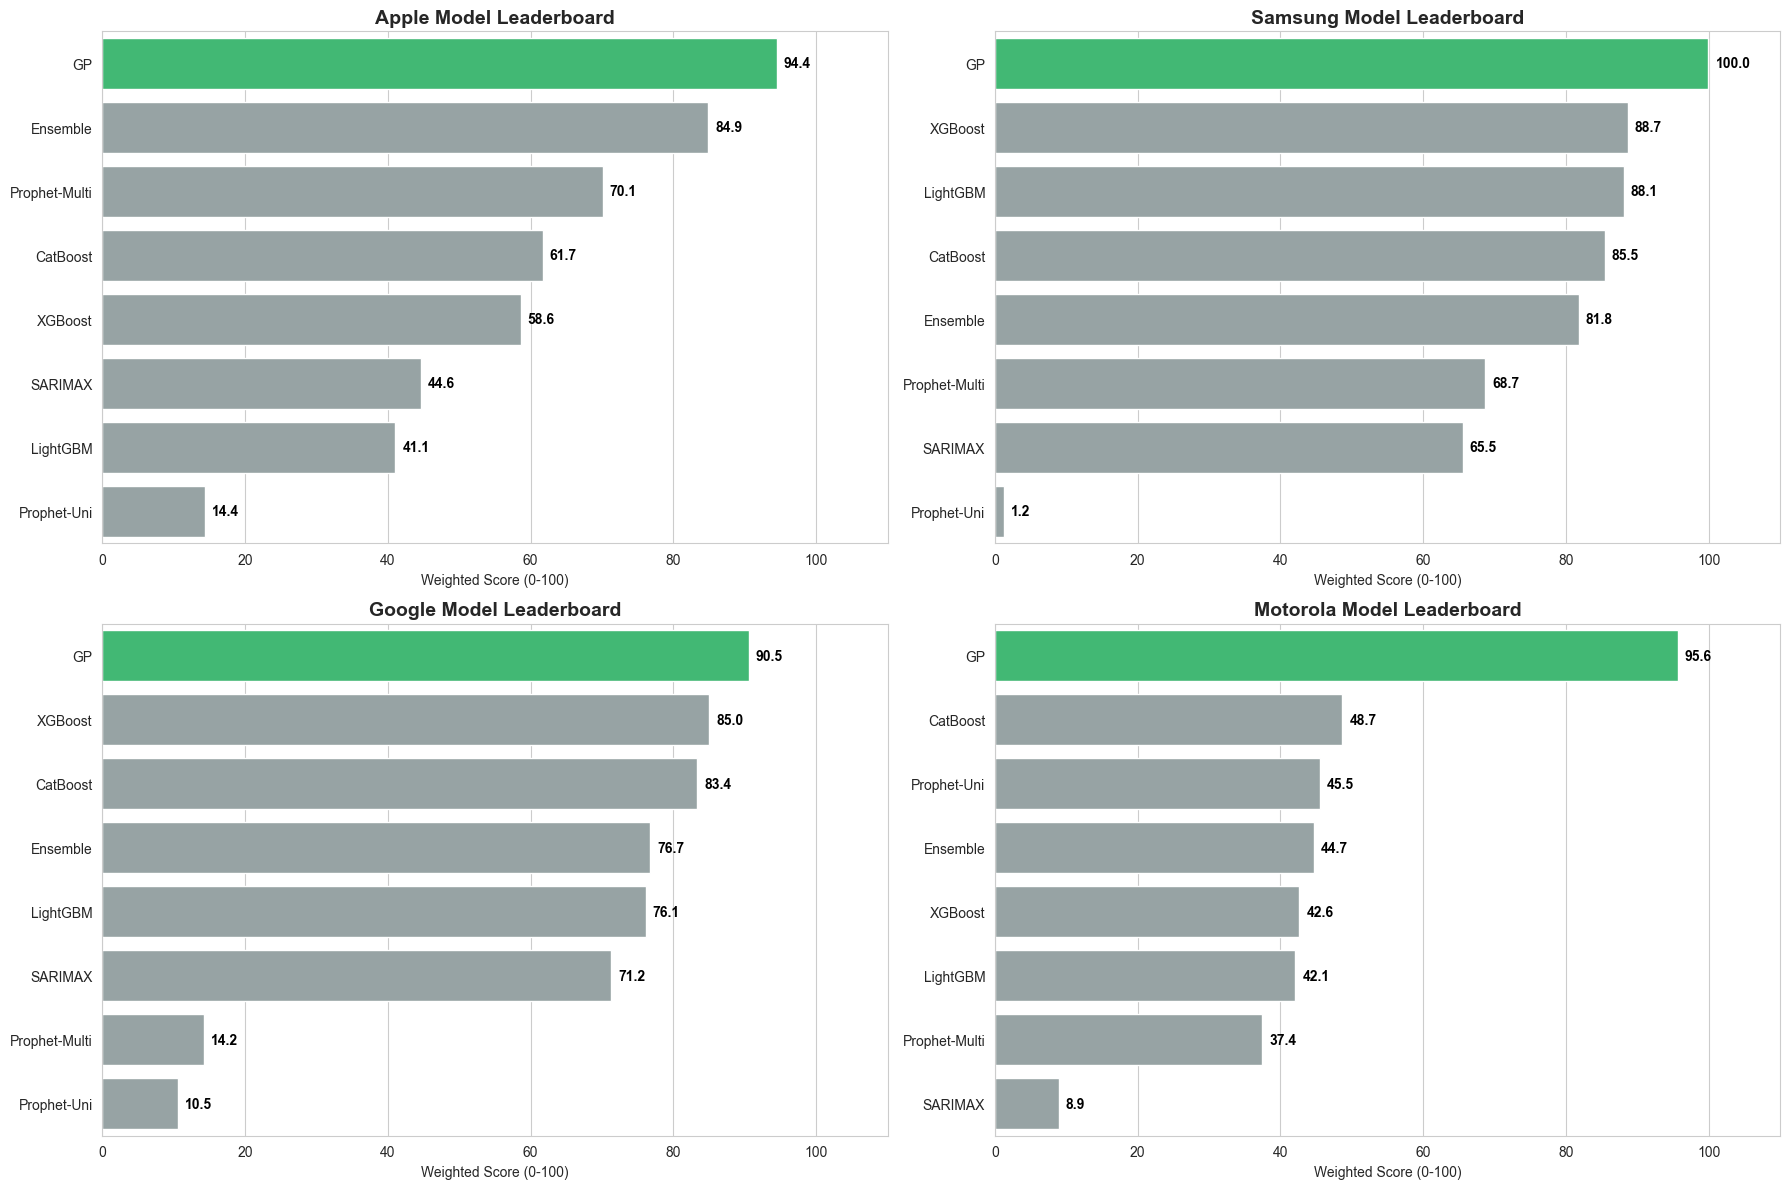


📊 INTERPRETATION:
• Green Bar: The selected 'Winner' for production.
• Gray Bars: The contenders.
• The score combines Accuracy (60%), Stability (25%), and Fit (15%).


In [73]:
# ================================================================
# Final Selection Visualization
# ================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set visuals
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("="*70)
print("VISUALIZING MODEL LEADERBOARD BY BRAND")
print("="*70)

brands = ['Apple', 'Samsung', 'Google', 'Motorola']
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

# Access rankings from the selector object
rankings = selector.model_rankings

for idx, brand in enumerate(brands):
    ax = axes[idx]
    
    # Extract data for this brand
    brand_ranks = rankings[brand]
    
    # Create DataFrame for plotting
    plot_data = []
    for model_name, metrics in brand_ranks:
        plot_data.append({
            'Model': model_name,
            'Total Score': metrics['total_score'],
            'Holdout MAPE': metrics['holdout_score'] # Scaled score
        })
    
    df_plot = pd.DataFrame(plot_data)
    
    # Color palette: Highlight the winner
    colors = ['#2ecc71' if i == 0 else '#95a5a6' for i in range(len(df_plot))]
    
    # Plot Bar Chart (Total Score)
    sns.barplot(data=df_plot, x='Total Score', y='Model', ax=ax, palette=colors)
    
    # Annotations
    ax.set_title(f"{brand} Model Leaderboard", fontsize=14, fontweight='bold')
    ax.set_xlabel("Weighted Score (0-100)", fontsize=10)
    ax.set_ylabel("")
    ax.set_xlim(0, 110)
    
    # Add value labels
    for i, v in enumerate(df_plot['Total Score']):
        ax.text(v + 1, i, f"{v:.1f}", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 INTERPRETATION:")
print("• Green Bar: The selected 'Winner' for production.")
print("• Gray Bars: The contenders.")
print("• The score combines Accuracy (60%), Stability (25%), and Fit (15%).")

In [74]:
# ================================================================
# Final Model Training on FULL DATA with Log-Scaling
# ================================================================

# ================================================================
# CACHING & INITIALIZATION
# ================================================================

FINAL_MODELS_CACHE_FILE = 'final_production_models.pkl'
run_training = True

# Cache file mapping for loading pre-optimized params 
MODEL_CACHE_FILES = {
    'SARIMAX': 'sarimax_results.pkl',
    'XGBoost': 'xgboost_results.pkl',
    'LightGBM': 'lightgbm_results.pkl',
    'Prophet-Multi': 'prophet_results.pkl',
    'Prophet-Uni': 'prophet_uni_results.pkl',
    'CatBoost': 'catboost_results.pkl',
    'GP': 'gp_results.pkl'
}

if os.path.exists(FINAL_MODELS_CACHE_FILE):
    print("="*70)
    print("LOADING CACHED FINAL PRODUCTION MODELS")
    print("="*70)
    with open(FINAL_MODELS_CACHE_FILE, 'rb') as f:
        cached = pickle.load(f)
    production_models = cached['production_models']
    production_params = cached['production_params']
    production_cv_performance = cached['production_cv_performance']
    production_scalers = cached.get('production_scalers', {})
    run_training = False
    print("✅ Loaded cached final production models")
    print("To retrain, delete:", FINAL_MODELS_CACHE_FILE)
else:
    print("No cache found - training final models from scratch...")
    
    # Load model selection if kernel was restarted
    SELECTION_CACHE_FILE = 'model_selection.pkl'
    if 'final_model_selection' not in globals():
        if os.path.exists(SELECTION_CACHE_FILE):
            with open(SELECTION_CACHE_FILE, 'rb') as f:
                selection_data = pickle.load(f)
                final_model_selection = selection_data.get('selected_models', selection_data)
            print("✓ Loaded model selection from cache")
        else:
            raise FileNotFoundError("Run Cell 13 first to select models!")


# ================================================================
# MAIN TRAINER CLASS
# ================================================================

class FinalModelTrainer:
    """
    Train final production models on FULL dataset (train + test combined)
    
    DESIGN:
    - Single models: Optimize + fit on full data
    - Ensemble: Load params from cache, fit ALL base models on full data
    - NO model reuse 
    - All models see 2025 data for accurate 2026 forecasting
    """
    
    def __init__(self, df_full, stat_results):
        self.df_full = df_full
        self.stat_results = stat_results
        self.final_models = {}
        self.final_params = {}
        self.cv_performance = {}
        self.scalers = {}

    # ================================================================
    # PUBLIC API
    # ================================================================
    
    def train_final_models(self, model_selection, n_trials=50):
        """Train final production models with log-scaling"""
        
        print("="*70)
        print("FINAL PRODUCTION MODEL TRAINING (8 MODELS + LOG-SCALING)")
        print("="*70)
        print("⚙️  Training on FULL dataset (train + test combined)")
        print("📊 All models use log-transformed targets")
        print(f"🔧 Hyperparameter optimization: {n_trials} trials per brand")
        print("📅 Brand-specific regime filtering applied")
        print("🎯 Anchored walk-forward CV (ending at most recent data)")
        print("="*70)
        
        brands = ['Apple', 'Samsung', 'Google', 'Motorola']
        
        for brand in brands:
            selected_model = model_selection[brand]['model']
            print(f"\n{'='*70}")
            print(f"BRAND: {brand} | SELECTED: {selected_model}")
            print(f"{'='*70}")
            
            if selected_model == 'Ensemble':
                self._train_final_ensemble(brand, n_trials)
            elif selected_model == 'SARIMAX':
                self._train_final_sarimax(brand, n_trials)
            elif selected_model == 'XGBoost':
                self._train_final_xgboost(brand, n_trials)
            elif selected_model == 'LightGBM':
                self._train_final_lightgbm(brand, n_trials)
            elif selected_model == 'Prophet-Multi':
                self._train_final_prophet(brand, n_trials, multivariate=True)
            elif selected_model == 'Prophet-Uni':
                self._train_final_prophet(brand, n_trials, multivariate=False)
            elif selected_model == 'CatBoost':
                self._train_final_catboost(brand, n_trials)
            elif selected_model == 'GP':
                self._train_final_gp(brand, n_trials)
            else:
                raise ValueError(f"Unknown model type: {selected_model}")
        
        self._print_summary(model_selection)
        return self.final_models, self.final_params, self.cv_performance

    # ================================================================
    # ENSEMBLE TRAINER (Fit-Only Mode for Base Models)
    # ================================================================
    
    def _train_final_ensemble(self, brand, n_trials):
        """
        Build ensemble by training ALL base models on full data
        """
        
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        print(f"\n📅 Production training: {start_date} (Ensemble - Fit-Only Mode)")
        
        # 1. Load Ensemble Weights from Cell 12G
        weights = self._load_ensemble_weights(brand)
        
        print(f"✓ Loaded ensemble weights from Cell 12G:")
        for model, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
            print(f"    {model}: {weight:.4f}")
        
        # 2. Train Base Models (Fit Only - Params from Cache)
        base_models = {}
        base_scalers = {}
        
        # Only train models with non-zero weights
        active_models = [m for m, w in weights.items() if w > 0.0]
        
        print(f"\n🏗️  Training {len(active_models)} base models on full data...")
        
        for model_type in active_models:
            print(f"  ➜ {model_type}...", end="", flush=True)
            
            # Load pre-optimized params
            params = self._load_params_from_cache(model_type, brand)
            
            # Fit model on FULL data
            model, scaler = self._fit_model_on_full_data(brand, model_type, params)
            
            base_models[model_type] = model
            if scaler:
                base_scalers[model_type] = scaler
            
            print(" ✓")
        
        # 3. Store Ensemble Bundle
        self.final_models[brand] = {
            'type': 'ensemble',
            'weights': weights,
            'base_models': base_models  # Trained models stored here
        }
        
        self.scalers[brand] = base_scalers  # Dict of scalers per base model
        
        self.final_params[brand] = {
            'type': 'ensemble',
            'weights': weights,
            'start_date': start_date
        }
        
        # Load CV score 
        cv_mape = self._load_ensemble_cv_score(brand)
        self.cv_performance[brand] = cv_mape
        
        print(f"\n✓ Ensemble built | {len(active_models)} base models | CV MAPE: {cv_mape:.2f}% (from Cell 12G)")

    # ================================================================
    # SINGLE MODEL TRAINERS (Optimize + Fit)
    # ================================================================
    
    def _train_final_sarimax(self, brand, n_trials):
        """Train SARIMAX with optimization"""
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_full = self.df_full[self.df_full['month'] >= start_date].copy()
        print(f"\n📅 Production training: {start_date} → {len(df_brand_full)} months")
        
        target_col = self._get_target_col(brand)
        y_raw = df_brand_full[target_col].values
        y_log = transform_target(y_raw)
        
        exog_cols = [f'launch_{brand.lower()}', 'is_holiday_season', 
                     'is_back_to_school', 'is_black_friday', 'cpi_index']
        exog_cols = [c for c in exog_cols if c in df_brand_full.columns]
        X = df_brand_full[exog_cols].values if exog_cols else None
        
        recommended_d = self.stat_results['stationarity'][brand]['recommended_d']

        def objective(trial):
            p = trial.suggest_int('p', 0, 3)
            q = trial.suggest_int('q', 0, 3)
            P = trial.suggest_int('P', 0, 2)
            Q = trial.suggest_int('Q', 0, 2)
            
            order = (p, recommended_d, q)
            seasonal_order = (P, 1, Q, 12)
            
            splits = self._create_walk_forward_splits(len(y_log))
            scores = []
            
            for s in splits:
                try:
                    mod = SARIMAX(
                        y_log[s['train']], 
                        exog=X[s['train']] if X is not None else None,
                        order=order, 
                        seasonal_order=seasonal_order, 
                        enforce_stationarity=False, 
                        enforce_invertibility=False
                    )
                    res = mod.fit(disp=False, maxiter=200, method='lbfgs')
                    
                    pred_log = res.forecast(
                        steps=len(s['test']), 
                        exog=X[s['test']] if X is not None else None
                    )
                    
                    pred_real = inverse_transform_target(pred_log)
                    y_test_real = y_raw[s['test']]
                    
                    scores.append(mean_absolute_percentage_error(y_test_real, pred_real) * 100)
                except:
                    scores.append(999)
            
            return np.mean(scores) if scores else 999

        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        bp = study.best_params
        final_order = (bp['p'], recommended_d, bp['q'])
        final_seasonal = (bp['P'], 1, bp['Q'], 12)
        
        final_model = SARIMAX(
            y_log, 
            exog=X, 
            order=final_order, 
            seasonal_order=final_seasonal, 
            enforce_stationarity=False, 
            enforce_invertibility=False
        ).fit(disp=False, maxiter=200, method='lbfgs')
        
        self.final_models[brand] = final_model
        self.final_params[brand] = {
            'order': final_order, 
            'seasonal_order': final_seasonal, 
            'exog_cols': exog_cols, 
            'target_col': target_col,
            'start_date': start_date
        }
        self.cv_performance[brand] = study.best_value
        print(f"✓ SARIMAX trained | CV MAPE: {study.best_value:.2f}% | Params: {final_order}")

    def _train_final_xgboost(self, brand, n_trials):
        """Train XGBoost with optimization"""
        import xgboost as xgb
        
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_full = self.df_full[self.df_full['month'] >= start_date].copy()
        print(f"\n📅 Production training: {start_date} → {len(df_brand_full)} months")
        
        X_raw, y_raw, features, target_col = self._get_ml_data(brand, df_brand_full)
        y_log = transform_target(y_raw)

        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 0.0, 5.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'random_state': 42, 'n_jobs': -1
            }
            
            splits = self._create_walk_forward_splits(len(X_raw))
            scores = []
            
            for s in splits:
                try:
                    scaler = StandardScaler()
                    X_train_sc = scaler.fit_transform(X_raw[s['train']])
                    X_test_sc = scaler.transform(X_raw[s['test']])
                    
                    mod = xgb.XGBRegressor(**params)
                    mod.fit(X_train_sc, y_log[s['train']], verbose=False)
                    
                    pred_log = mod.predict(X_test_sc)
                    pred_real = inverse_transform_target(pred_log)
                    
                    scores.append(mean_absolute_percentage_error(y_raw[s['test']], pred_real) * 100)
                except:
                    scores.append(999)
            
            return np.mean(scores) if scores else 999

        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_raw)
        self.scalers[brand] = scaler
        
        final_model = xgb.XGBRegressor(**study.best_params, n_jobs=-1)
        final_model.fit(X_scaled, y_log, verbose=False)
        
        self.final_models[brand] = final_model
        self.final_params[brand] = {
            'params': study.best_params, 
            'feature_cols': features, 
            'target_col': target_col,
            'start_date': start_date
        }
        self.cv_performance[brand] = study.best_value
        print(f"✓ XGBoost trained | CV MAPE: {study.best_value:.2f}%")

    def _train_final_lightgbm(self, brand, n_trials):
        """Train LightGBM with optimization"""
        import lightgbm as lgb
        
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_full = self.df_full[self.df_full['month'] >= start_date].copy()
        print(f"\n📅 Production training: {start_date} → {len(df_brand_full)} months")
        
        X_raw, y_raw, features, target_col = self._get_ml_data(brand, df_brand_full)
        y_log = transform_target(y_raw)

        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
                'random_state': 42, 'verbose': -1, 'n_jobs': -1
            }
            
            splits = self._create_walk_forward_splits(len(X_raw))
            scores = []
            
            for s in splits:
                try:
                    scaler = StandardScaler()
                    X_train_sc = scaler.fit_transform(X_raw[s['train']])
                    X_test_sc = scaler.transform(X_raw[s['test']])
                    
                    mod = lgb.LGBMRegressor(**params)
                    mod.fit(X_train_sc, y_log[s['train']])
                    
                    pred_log = mod.predict(X_test_sc)
                    pred_real = inverse_transform_target(pred_log)
                    
                    scores.append(mean_absolute_percentage_error(y_raw[s['test']], pred_real) * 100)
                except:
                    scores.append(999)
            
            return np.mean(scores) if scores else 999

        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_raw)
        self.scalers[brand] = scaler
        
        final_model = lgb.LGBMRegressor(**study.best_params, verbose=-1, n_jobs=-1)
        final_model.fit(X_scaled, y_log)
        
        self.final_models[brand] = final_model
        self.final_params[brand] = {
            'params': study.best_params, 
            'feature_cols': features, 
            'target_col': target_col,
            'start_date': start_date
        }
        self.cv_performance[brand] = study.best_value
        print(f"✓ LightGBM trained | CV MAPE: {study.best_value:.2f}%")

    def _train_final_catboost(self, brand, n_trials):
        """Train CatBoost with optimization"""
        from catboost import CatBoostRegressor
        
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_full = self.df_full[self.df_full['month'] >= start_date].copy()
        print(f"\n📅 Production training: {start_date} → {len(df_brand_full)} months")
        
        target_col = self._get_target_col(brand)
        prefix = brand if f'{brand}_lag1' in df_brand_full.columns else brand.lower()
        
        features = [
            f'{prefix}_lag1', f'{prefix}_lag12', f'{prefix}_ma3', f'{prefix}_ma12',
            f'launch_{brand.lower()}', 'is_holiday_season', 'is_back_to_school',
            'is_black_friday', 'month_num', 'quarter', 'time_index', 'cpi_index'
        ]
        features = [c for c in features if c in df_brand_full.columns]
        cat_features = [c for c in features if c in ['month_num', 'quarter']]
        numeric_cols = [c for c in features if c not in cat_features]
        
        X_raw = df_brand_full[features].copy()
        y_raw = df_brand_full[target_col].values
        y_log = transform_target(y_raw)

        def objective(trial):
            params = {
                'iterations': trial.suggest_int('iterations', 100, 500),
                'depth': trial.suggest_int('depth', 4, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
                'random_strength': trial.suggest_float('random_strength', 0, 10),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
                'border_count': trial.suggest_int('border_count', 32, 128),
                'verbose': False, 'random_state': 42, 'cat_features': cat_features
            }
            
            splits = self._create_walk_forward_splits(len(X_raw))
            scores = []
            
            for s in splits:
                try:
                    scaler = StandardScaler()
                    X_train = X_raw.iloc[s['train']].copy()
                    X_test = X_raw.iloc[s['test']].copy()
                    
                    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
                    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
                    
                    mod = CatBoostRegressor(**params)
                    mod.fit(X_train, y_log[s['train']])
                    
                    pred_log = mod.predict(X_test)
                    pred_real = inverse_transform_target(pred_log)
                    
                    scores.append(mean_absolute_percentage_error(y_raw[s['test']], pred_real) * 100)
                except:
                    scores.append(999)
            
            return np.mean(scores) if scores else 999

        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        scaler = StandardScaler()
        X_scaled = X_raw.copy()
        X_scaled[numeric_cols] = scaler.fit_transform(X_raw[numeric_cols])
        self.scalers[brand] = scaler
        
        final_model = CatBoostRegressor(**study.best_params, verbose=False)
        final_model.fit(X_scaled, y_log)
        
        self.final_models[brand] = final_model
        self.final_params[brand] = {
            'params': study.best_params, 
            'feature_cols': features, 
            'cat_features': cat_features, 
            'numeric_cols': numeric_cols,
            'target_col': target_col,
            'start_date': start_date
        }
        self.cv_performance[brand] = study.best_value
        print(f"✓ CatBoost trained | CV MAPE: {study.best_value:.2f}%")

    def _train_final_gp(self, brand, n_trials):
        """Train GP with optimization"""
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import (
            RBF, Matern, RationalQuadratic, ExpSineSquared, 
            WhiteKernel, ConstantKernel as C
        )
        
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_full = self.df_full[self.df_full['month'] >= start_date].copy()
        print(f"\n📅 Production training: {start_date} → {len(df_brand_full)} months")
        
        X_raw, y_raw, features, target_col = self._get_ml_data(brand, df_brand_full)
        y_log = transform_target(y_raw)

        def build_kernel(p):
            base = C(1.0, (1e-3, 1e3))
            if p['kernel_type'] == 'RBF':
                k = base * RBF(length_scale=p['length_scale'])
            elif p['kernel_type'] == 'Matern':
                k = base * Matern(length_scale=p['length_scale'], nu=p['nu'])
            elif p['kernel_type'] == 'RationalQuadratic':
                k = base * RationalQuadratic(length_scale=p['length_scale'], alpha=p['rq_alpha'])
            else:
                k = base * RBF(length_scale=p['length_scale']) + \
                    base * ExpSineSquared(length_scale=1.0, periodicity=p['period'])
            return k + WhiteKernel(noise_level=p['alpha'])

        def objective(trial):
            params = {
                'kernel_type': trial.suggest_categorical('kernel_type', ['RBF', 'Matern', 'RationalQuadratic', 'RBF+Periodic']),
                'length_scale': trial.suggest_float('length_scale', 0.1, 10.0, log=True),
                'alpha': trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
            }
            
            if params['kernel_type'] == 'Matern':
                params['nu'] = trial.suggest_categorical('nu', [0.5, 1.5, 2.5])
            if params['kernel_type'] == 'RationalQuadratic':
                params['rq_alpha'] = trial.suggest_float('rq_alpha', 0.1, 10.0)
            if params['kernel_type'] == 'RBF+Periodic':
                params['period'] = trial.suggest_float('period', 10.0, 14.0)
            
            kernel = build_kernel(params)
            splits = self._create_walk_forward_splits(len(X_raw))
            scores = []
            
            for s in splits:
                try:
                    scaler_X = StandardScaler()
                    scaler_y = StandardScaler()
                    
                    train_idx = s['train'][-1000:] if len(s['train']) > 1000 else s['train']
                    
                    X_train_sc = scaler_X.fit_transform(X_raw[train_idx])
                    X_test_sc = scaler_X.transform(X_raw[s['test']])
                    y_train_sc = scaler_y.fit_transform(y_log[train_idx].reshape(-1, 1)).ravel()
                    
                    mod = GaussianProcessRegressor(kernel=kernel, alpha=params['alpha'], normalize_y=False, n_restarts_optimizer=0)
                    mod.fit(X_train_sc, y_train_sc)
                    
                    pred_sc = mod.predict(X_test_sc)
                    pred_log = scaler_y.inverse_transform(pred_sc.reshape(-1, 1)).ravel()
                    pred_real = inverse_transform_target(pred_log)
                    
                    scores.append(mean_absolute_percentage_error(y_raw[s['test']], pred_real) * 100)
                except:
                    scores.append(999)
            
            return np.mean(scores) if scores else 999

        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        
        X_scaled = scaler_X.fit_transform(X_raw)
        y_scaled = scaler_y.fit_transform(y_log.reshape(-1, 1)).ravel()
        
        self.scalers[brand] = {'X_scaler': scaler_X, 'y_scaler': scaler_y}
        
        final_kernel = build_kernel(study.best_params)
        final_model = GaussianProcessRegressor(kernel=final_kernel, alpha=study.best_params['alpha'], normalize_y=False, n_restarts_optimizer=5)
        final_model.fit(X_scaled, y_scaled)
        
        self.final_models[brand] = final_model
        self.final_params[brand] = {
            'params': study.best_params, 
            'feature_cols': features, 
            'target_col': target_col,
            'start_date': start_date
        }
        self.cv_performance[brand] = study.best_value
        print(f"✓ GP trained | CV MAPE: {study.best_value:.2f}% | Kernel: {study.best_params['kernel_type']}")

    def _train_final_prophet(self, brand, n_trials, multivariate):
        """Train Prophet with optimization"""
        from prophet import Prophet
        
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_full = self.df_full[self.df_full['month'] >= start_date].copy()
        
        variant = "Multi" if multivariate else "Uni"
        print(f"\n📅 Production training: {start_date} → {len(df_brand_full)} months")
        
        target_col = self._get_target_col(brand)
        y_raw = df_brand_full[target_col].values
        y_log = transform_target(y_raw)
        
        df_prophet = pd.DataFrame({'ds': df_brand_full['month'], 'y': y_log})
        
        regressors = []
        if multivariate:
            regressors = [f'launch_{brand.lower()}', 'is_holiday_season', 'is_back_to_school', 'is_black_friday', 'cpi_index']
            for reg in regressors:
                if reg in df_brand_full.columns:
                    df_prophet[reg] = df_brand_full[reg].values
            regressors = [r for r in regressors if r in df_prophet.columns]

        def objective(trial):
            params = {
                'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
                'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True),
                'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95),
                'yearly_seasonality': trial.suggest_categorical('yearly_seasonality', [True, False]) if multivariate else True
            }
            
            splits = self._create_walk_forward_splits(len(df_prophet))
            scores = []
            
            for s in splits:
                try:
                    model = Prophet(**params)
                    for reg in regressors:
                        model.add_regressor(reg)
                    
                    model.fit(df_prophet.iloc[s['train']])
                    future = df_prophet.iloc[s['test']][['ds'] + regressors].copy()
                    forecast = model.predict(future)
                    
                    pred_log = forecast['yhat'].values
                    pred_real = inverse_transform_target(pred_log)
                    
                    scores.append(mean_absolute_percentage_error(y_raw[s['test']], pred_real) * 100)
                except:
                    scores.append(999)
            
            return np.mean(scores) if scores else 999

        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        final_model = Prophet(**study.best_params)
        for reg in regressors:
            final_model.add_regressor(reg)
        final_model.fit(df_prophet)
        
        self.final_models[brand] = final_model
        self.final_params[brand] = {
            'params': study.best_params, 
            'regressor_cols': regressors, 
            'target_col': target_col, 
            'multivariate': multivariate,
            'start_date': start_date
        }
        self.cv_performance[brand] = study.best_value
        print(f"✓ Prophet-{variant} trained | CV MAPE: {study.best_value:.2f}%")

    # ================================================================
    # FIT-ONLY LOGIC (For Ensemble Base Models)
    # ================================================================
    
    def _fit_model_on_full_data(self, brand, model_type, params):
        """
        Fit a single model on FULL data using pre-optimized params
        """
        
        start_date = BRAND_START_DATES.get(brand, '2011-01-01')
        df_brand_full = self.df_full[self.df_full['month'] >= start_date].copy()
        
        target_col = self._get_target_col(brand)
        y_raw = df_brand_full[target_col].values
        y_log = transform_target(y_raw)
        
        # Route to appropriate fitter
        if model_type == 'SARIMAX':
            return self._fit_sarimax(df_brand_full, y_log, params)
        elif model_type == 'XGBoost':
            return self._fit_xgboost(df_brand_full, y_log, params)
        elif model_type == 'LightGBM':
            return self._fit_lightgbm(df_brand_full, y_log, params)
        elif model_type == 'CatBoost':
            return self._fit_catboost(df_brand_full, y_log, params)
        elif model_type.startswith('Prophet'):
            return self._fit_prophet(df_brand_full, y_log, params, model_type=='Prophet-Multi')
        elif model_type == 'GP':
            return self._fit_gp(df_brand_full, y_log, params)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
    
    def _fit_sarimax(self, df, y_log, params):
        """Fit SARIMAX on full data"""
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        
        exog_cols = params['exog_cols']
        X = df[exog_cols].values if exog_cols else None
        
        model = SARIMAX(
            y_log, 
            exog=X, 
            order=params['order'], 
            seasonal_order=params['seasonal_order'],
            enforce_stationarity=False, 
            enforce_invertibility=False
        )
        
        return model.fit(disp=False, maxiter=200, method='lbfgs'), None
    
    def _fit_xgboost(self, df, y_log, params):
        """Fit XGBoost on full data"""
        import xgboost as xgb
        
        features = params['feature_cols']
        X_raw = df[features].values
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_raw)
        
        model = xgb.XGBRegressor(**params['params'], n_jobs=-1)
        model.fit(X_scaled, y_log, verbose=False)
        
        return model, scaler
    
    def _fit_lightgbm(self, df, y_log, params):
        """Fit LightGBM on full data"""
        import lightgbm as lgb
        
        features = params['feature_cols']
        X_raw = df[features].values
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_raw)
        
        model = lgb.LGBMRegressor(**params['params'], verbose=-1, n_jobs=-1)
        model.fit(X_scaled, y_log)
        
        return model, scaler
    
    def _fit_catboost(self, df, y_log, params):
        """Fit CatBoost on full data"""
        from catboost import CatBoostRegressor
        
        features = params['feature_cols']
        cat_features = params['cat_features']
        numeric_cols = params['numeric_cols']
        
        X_raw = df[features].copy()
        
        scaler = StandardScaler()
        X_scaled = X_raw.copy()
        X_scaled[numeric_cols] = scaler.fit_transform(X_raw[numeric_cols])
        
        model = CatBoostRegressor(**params['params'], verbose=False, cat_features=cat_features)
        model.fit(X_scaled, y_log)
        
        return model, scaler
    
    def _fit_prophet(self, df, y_log, params, multivariate):
        """
        Fit Prophet on full data
        """
        from prophet import Prophet
        
        df_prophet = pd.DataFrame({'ds': df['month'], 'y': y_log})
        
        # Check both possible key names for regressors
        regressors = params.get('regressor_cols') or params.get('regressors', [])
        
        # Add regressor columns to prophet dataframe
        for reg in regressors:
            if reg in df.columns:
                df_prophet[reg] = df[reg].values
        
        # Check both possible key names for hyperparameters
        prophet_params = params.get('params') or params.get('hyperparams', {})
        
        # Build and fit model
        model = Prophet(**prophet_params)
        for reg in regressors:
            if reg in df_prophet.columns:  # Extra safety check
                model.add_regressor(reg)
        
        model.fit(df_prophet)
        
        return model, None
    
    def _fit_gp(self, df, y_log, params):
        """Fit GP on full data"""
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import (
            RBF, Matern, RationalQuadratic, ExpSineSquared, 
            WhiteKernel, ConstantKernel as C
        )
        
        features = params['feature_cols']
        X_raw = df[features].values
        
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        
        X_scaled = scaler_X.fit_transform(X_raw)
        y_scaled = scaler_y.fit_transform(y_log.reshape(-1, 1)).ravel()
        
        # Rebuild kernel from params
        p = params['params']
        base = C(1.0, (1e-3, 1e3))
        if p['kernel_type'] == 'RBF':
            k = base * RBF(length_scale=p['length_scale'])
        elif p['kernel_type'] == 'Matern':
            k = base * Matern(length_scale=p['length_scale'], nu=p['nu'])
        elif p['kernel_type'] == 'RationalQuadratic':
            k = base * RationalQuadratic(length_scale=p['length_scale'], alpha=p['rq_alpha'])
        else:
            k = base * RBF(length_scale=p['length_scale']) + \
                base * ExpSineSquared(length_scale=1.0, periodicity=p['period'])
        
        kernel = k + WhiteKernel(noise_level=p['alpha'])
        
        model = GaussianProcessRegressor(kernel=kernel, alpha=p['alpha'], normalize_y=False, n_restarts_optimizer=5)
        model.fit(X_scaled, y_scaled)
        
        return model, {'X_scaler': scaler_X, 'y_scaler': scaler_y}

    # ================================================================
    # HELPER METHODS
    # ================================================================
    
    def _load_params_from_cache(self, model_type, brand):
        """Load pre-optimized params"""
        
        cache_file = MODEL_CACHE_FILES.get(model_type)
        if not cache_file or not os.path.exists(cache_file):
            raise FileNotFoundError(
                f"Cache file {cache_file} for {model_type} not found!\n"
                f"Action: Run Training Cell to generate all base model caches."
            )
        
        with open(cache_file, 'rb') as f:
            data = pickle.load(f)
        
        return data['best_params'][brand]
    
    def _load_ensemble_weights(self, brand):
        """Load ensemble weights from the Training Cell"""
        
        if not os.path.exists('ensemble_results.pkl'):
            raise FileNotFoundError(
                "ensemble_results.pkl not found! Run Training Cell first."
            )
        
        with open('ensemble_results.pkl', 'rb') as f:
            data = pickle.load(f)
        
        return data['ensemble_weights'][brand]
    
    def _load_ensemble_cv_score(self, brand):
        """Load ensemble CV score from the Training Cell"""
        
        with open('ensemble_results.pkl', 'rb') as f:
            data = pickle.load(f)
        
        return data['cv_results'][brand]['cv_mape_mean']
    
    def _get_target_col(self, brand):
        col = f'{brand}_units'
        return col if col in self.df_full.columns else f'{brand.lower()}_units'
    
    def _get_ml_data(self, brand, df):
        target_col = self._get_target_col(brand)
        prefix = brand if f'{brand}_lag1' in df.columns else brand.lower()
        
        features = [
            f'{prefix}_lag1', f'{prefix}_lag12', f'{prefix}_ma3', f'{prefix}_ma12',
            f'launch_{brand.lower()}', 'is_holiday_season', 'is_back_to_school',
            'is_black_friday', 'month_num', 'quarter', 'time_index', 'cpi_index'
        ]
        features = [c for c in features if c in df.columns]
        
        X = df[features].values
        y = df[target_col].values
        
        return X, y, features, target_col
    
    def _create_walk_forward_splits(self, n_samples):
        """
        Anchored walk-forward CV ending at most recent data
        Last fold always tests the most recent 12 months
        """
        test_size = 12
        n_folds = 5
        min_train = 60
        
        last_test_end = n_samples
        last_test_start = last_test_end - test_size
        
        first_train_end = last_test_start - (test_size * (n_folds - 1))
        
        if first_train_end < min_train:
            max_possible_folds = (last_test_start - min_train) // test_size + 1
            n_folds = max(2, int(max_possible_folds))
            first_train_end = last_test_start - (test_size * (n_folds - 1))
        
        splits = []
        for i in range(n_folds):
            train_end = first_train_end + (i * test_size)
            test_start = train_end
            test_end = test_start + test_size
            
            if test_end > n_samples:
                break
            
            if train_end < min_train:
                continue
            
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(test_start, test_end))
            })
        
        if not splits:
            train_end = max(min_train, n_samples - test_size)
            splits.append({
                'train': list(range(train_end)),
                'test': list(range(train_end, n_samples))
            })
        
        return splits
    
    def _print_summary(self, model_selection):
        print("\n\n" + "="*70)
        print("FINAL PRODUCTION MODELS SUMMARY")
        print("="*70)
        
        summary = []
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            if brand in self.cv_performance:
                start_date = self.final_params[brand].get('start_date', '2011-01-01')
                df_brand = self.df_full[self.df_full['month'] >= start_date]
                summary.append({
                    'Brand': brand,
                    'Model': model_selection[brand]['model'],
                    'CV MAPE': f"{self.cv_performance[brand]:.2f}%",
                    'Start': start_date,
                    'Months': len(df_brand)
                })
        
        print("\n" + pd.DataFrame(summary).to_string(index=False))
        print("\n✅ All final production models trained")
        print(f"💾 Scalers saved for production forecasting")
        print(f"🎯 Ready for 2026 forecasting")


# ================================================================
# EXECUTION
# ================================================================

if run_training:
    print("\n" + "="*70)
    print("STARTING FINAL PRODUCTION MODEL TRAINING")
    print("="*70)
    print("⏰ Expected runtime: 10-40 minutes")
    print("  • Single models: 2-5 min each (with optimization)")
    print("  • Ensemble: 15-25 min (trains all 7 base models)")
    print("="*70)
    
    # Combine train and test datasets
    df_full_data = pd.concat([df_train, df_test], ignore_index=True)
    df_full_data = df_full_data.sort_values('month').reset_index(drop=True)
    
    print(f"\nFull dataset: {len(df_full_data)} months")
    print(f"Date range: {df_full_data['month'].min().date()} to {df_full_data['month'].max().date()}")
    
    # Initialize trainer
    trainer = FinalModelTrainer(df_full_data, stat_validation_results)
    
    # Train final models (50 trials for optimization)
    production_models, production_params, production_cv_performance = trainer.train_final_models(
        final_model_selection,
        n_trials=50
    )
    
    # Store scalers
    production_scalers = trainer.scalers
    
    # Save to cache
    with open(FINAL_MODELS_CACHE_FILE, 'wb') as f:
        pickle.dump({
            'production_models': production_models,
            'production_params': production_params,
            'production_cv_performance': production_cv_performance,
            'production_scalers': production_scalers
        }, f)
    
    print(f"\n💾 Saved final production models to {FINAL_MODELS_CACHE_FILE}")
    print("✅ Training complete - variables ready:")
    print("   - production_models")
    print("   - production_params")
    print("   - production_cv_performance")
    print("   - production_scalers")

else:
    print("\n⚡ Skipped training (loaded from cache)")

LOADING CACHED FINAL PRODUCTION MODELS
✅ Loaded cached final production models
To retrain, delete: final_production_models.pkl

⚡ Skipped training (loaded from cache)


In [75]:
# ================================================================
# Create Future Dataframe with Regressors
# ================================================================
print("="*70)
print("LOADING DEPENDENCIES")
print("="*70)

# Load df_full_data if needed
if 'df_full_data' not in globals():
    if os.path.exists('train_test_split.pkl'):
        with open('train_test_split.pkl', 'rb') as f:
            cached = pickle.load(f)
        df_full_data = pd.concat([cached['df_train'], cached['df_test']], ignore_index=True)
        df_full_data = df_full_data.sort_values('month').reset_index(drop=True)
        print(f"  ✓ Loaded from cache ({len(df_full_data)} months)")
    elif 'df_features' in globals():
        df_full_data = df_features.copy()
        print(f"  ✓ Using df_features ({len(df_full_data)} months)")
    else:
        raise RuntimeError("Run Cell 10 or Cell 11 first!")
else:
    print(f"  ✓ df_full_data already loaded ({len(df_full_data)} months)")

print("="*70)
print()

# ----------------------------------------------------------------
# Configuration
# ----------------------------------------------------------------
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
    'Accept': 'text/csv'
}

def find_col(df, candidates):
    """Find column by name (case-insensitive)"""
    if df is None or df.empty:
        return None
    for col in df.columns:
        if col.upper() in [c.upper() for c in candidates]:
            return col
    return None

# ----------------------------------------------------------------
# Fetch Bank of Canada Actuals
# ----------------------------------------------------------------
def fetch_boc_actuals():
    """Get latest actual CPI from Bank of Canada"""
    print("  📡 Fetching BoC actuals...")
    
    url = "https://www.bankofcanada.ca/valet/observations/V41690914/json"
    params = {"start_date": "2024-01-01"}
    
    try:
        response = requests.get(url, headers=HEADERS, params=params, timeout=15)
        if response.status_code == 200:
            data = response.json()
            cpi_data = []
            for obs in data.get('observations', []):
                cpi_data.append({
                    'month': pd.to_datetime(obs['d']),
                    'cpi_index': float(obs['V41690914']['v'])
                })
            df = pd.DataFrame(cpi_data).sort_values('month')
            latest = df.iloc[-1]
            print(f"    ✓ Latest: {latest['month'].date()} = {latest['cpi_index']:.2f}")
            return df
    except Exception as e:
        print(f"    ⚠️ Failed: {e}")
    
    return pd.DataFrame(columns=['month', 'cpi_index'])

# ----------------------------------------------------------------
# Fetch OECD Forecasts
# ----------------------------------------------------------------
def fetch_oecd_forecasts():
    """Get CPI forecasts from OECD"""
    print("  📡 Fetching OECD forecasts...")
    
    def process_csv(content, freq):
        try:
            df = pd.read_csv(StringIO(content))
            
            # Filter Canada
            loc_col = find_col(df, ['LOCATION', 'Country', 'REF_AREA'])
            if loc_col:
                df = df[df[loc_col] == 'CAN']
            
            # Find time and value columns
            t_col = find_col(df, ['TIME', 'Period', 'TIME_PERIOD'])
            v_col = find_col(df, ['Value', 'ObsValue', 'OBS_VALUE'])
            
            if not t_col or not v_col:
                return pd.DataFrame()
            
            df = df.rename(columns={t_col: 'time_raw', v_col: 'val'})
            df = df[['time_raw', 'val']].dropna()
            df = df.drop_duplicates(subset=['time_raw'], keep='last')
            
            # Parse dates
            if freq == 'Q':
                def parse_q(x):
                    try:
                        s = str(x).replace('-', '').upper().strip()
                        y = int(s[:4])
                        q = int(s[-1])
                        return pd.Timestamp(year=y, month=q*3-1, day=15)
                    except:
                        return pd.NaT
                df['date'] = df['time_raw'].apply(parse_q)
            else:  # Annual
                df['year'] = pd.to_numeric(df['time_raw'], errors='coerce')
                df = df.dropna(subset=['year'])
                df['date'] = df['year'].apply(lambda y: pd.Timestamp(year=int(y), month=7, day=1))
            
            df = df.dropna(subset=['date']).sort_values('date')
            df = df[df['date'].dt.year >= 2025]  # Future only
            
            return df[['date', 'val']]
        except:
            return pd.DataFrame()
    
    # Try quarterly first
    url_q = "https://stats.oecd.org/sdmx-json/data/EO/CAN.CPI.Q.PC/all?contentType=csv"
    try:
        r = requests.get(url_q, headers=HEADERS, timeout=10)
        if r.status_code == 200:
            df = process_csv(r.text, 'Q')
            if not df.empty:
                print(f"    ✓ Quarterly forecast: {len(df)} quarters")
                df = df.drop_duplicates(subset=['date'], keep='last')
                df = df.set_index('date').resample('MS').interpolate(method='time').reset_index()
                return df
    except:
        pass
    
    # Fallback to annual
    print("    ℹ️ Trying annual...")
    url_a = "https://stats.oecd.org/sdmx-json/data/EO/CAN.CPI.A.PC/all?contentType=csv"
    try:
        r = requests.get(url_a, headers=HEADERS, timeout=10)
        if r.status_code == 200:
            df = process_csv(r.text, 'A')
            if not df.empty:
                print(f"    ✓ Annual forecast: {len(df)} years")
                df = df.drop_duplicates(subset=['date'], keep='last')
                df = df.set_index('date').resample('MS').interpolate(method='time').reset_index()
                return df
    except:
        pass
    
    print("    ⚠️ OECD unavailable")
    return pd.DataFrame()

# ----------------------------------------------------------------
# Build Future Dataframe
# ----------------------------------------------------------------
def build_future_dataframe(df_historical):
    """Build 12-month future dataframe with all regressors"""
    
    print("\n" + "="*70)
    print("BUILDING FUTURE DATAFRAME (2026)")
    print("="*70)
    
    # Create future dates
    last_date = df_historical['month'].max()
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=12,
        freq='MS'
    )
    
    df_future = pd.DataFrame({
        'month': future_dates,
        'month_num': future_dates.month,
        'quarter': future_dates.quarter
    })
    
    print(f"\nFuture period: {df_future['month'].min().date()} to {df_future['month'].max().date()}")
    
    # Fetch CPI data
    print("\nStep 1: Fetching CPI data...")
    df_boc = fetch_boc_actuals()
    df_oecd = fetch_oecd_forecasts()
    
    # Set anchor point
    current_cpi = df_historical['cpi_index'].iloc[-1]
    print(f"\n  ⚓ Starting CPI: {current_cpi:.2f}")
    
    # Update anchor if BoC has newer data
    if not df_boc.empty:
        latest_boc = df_boc.iloc[-1]
        if latest_boc['month'] > last_date:
            current_cpi = latest_boc['cpi_index']
            print(f"  ⚓ Updated to BoC latest: {current_cpi:.2f} ({latest_boc['month'].date()})")
    
    # Calculate fallback growth rate (smart fallback from historical trend)
    last_12m_growth = df_historical['cpi_index'].pct_change(12).iloc[-1]
    fallback_monthly_rate = (1 + last_12m_growth) ** (1/12)
    fallback_monthly_rate = min(fallback_monthly_rate, 1.004)  # Cap at ~5% annual
    
    # Project CPI forward
    print("\nStep 2: Projecting CPI forward...")
    cpi_series = []
    
    for i, row in df_future.iterrows():
        forecast_date = row['month']
        
        # Check if BoC has actual for this month
        boc_match = df_boc[df_boc['month'] == forecast_date]
        if not boc_match.empty:
            val = boc_match.iloc[0]['cpi_index']
            cpi_series.append(val)
            current_cpi = val
            continue
        
        # Use OECD forecast if available
        monthly_mult = fallback_monthly_rate
        
        if not df_oecd.empty:
            # Find closest forecast
            match = df_oecd.iloc[(df_oecd['date'] - forecast_date).abs().argsort()[:1]]
            if not match.empty:
                raw_val = match.iloc[0]['val']
                
                # Check if it's a rate (not index)
                if raw_val < 15.0:  # It's a percentage rate
                    rate = max(-2.0, min(10.0, raw_val))  # Clamp to reasonable range
                    monthly_mult = (1 + rate/100) ** (1/12)
        
        # Apply growth
        new_val = current_cpi * monthly_mult
        cpi_series.append(new_val)
        current_cpi = new_val
    
    df_future['cpi_index'] = cpi_series
    
    if df_oecd.empty:
        implied_annual = ((fallback_monthly_rate**12)-1)*100
        print(f"  ℹ️ Used historical trend fallback ({implied_annual:.1f}% annual)")
    
    print(f"  ✓ CPI range: {df_future['cpi_index'].min():.2f} to {df_future['cpi_index'].max():.2f}")
    
    # Add launch indicators
    print("\nStep 3: Adding product launches...")
    launches = {
    'apple':    [9, 3],  # Sep (Flagship), Mar (Spring Refresh) 
    'samsung':  [2, 7],  # Feb (S25/S26 Reality), Jul (Foldables) 
    'google':   [8, 2],  # Aug (Pixel Flagship), Feb (Pixel 'a' Shift) 
    'motorola': [1, 7]   # Jan (Budget Wave), Jul (Razr) 
    }
    
    for brand, months in launches.items():
        col = f'launch_{brand}'
        df_future[col] = df_future['month_num'].isin(months).astype(int)
    
    print("  ✓ Launch indicators added")
    
    # Add time features
    print("\nStep 4: Adding time features...")
    df_future['is_holiday_season'] = df_future['month_num'].isin([11, 12]).astype(int)
    df_future['is_back_to_school'] = df_future['month_num'].isin([8, 9]).astype(int)
    df_future['is_black_friday'] = (df_future['month_num'] == 11).astype(int)

    # Handle time_index 
    if 'time_index' in df_historical.columns:
        last_idx = df_historical['time_index'].max()
        df_future['time_index'] = range(int(last_idx)+1, int(last_idx)+13)
    else:
        # Create based on dataset length
        last_idx = len(df_historical) - 1
        df_future['time_index'] = range(last_idx+1, last_idx+13)
        print(f"  ℹ️ Created time_index (column not found in historical data)")

    print("  ✓ Time features added")
    
    # Summary
    print("\n" + "="*70)
    print("FUTURE DATAFRAME COMPLETE")
    print("="*70)
    print(f"Rows: {len(df_future)}")
    print(f"Columns: {len(df_future.columns)}")
    print(f"\nPreview:")
    print(df_future[['month', 'cpi_index', 'launch_apple', 'is_holiday_season']].head(3))
    
    return df_future

# ----------------------------------------------------------------
# Execute
# ----------------------------------------------------------------
df_future_2026 = build_future_dataframe(df_full_data)

print("\n✅ Future dataframe ready: df_future_2026")

LOADING DEPENDENCIES
  ✓ df_full_data already loaded (178 months)


BUILDING FUTURE DATAFRAME (2026)

Future period: 2025-12-01 to 2026-11-01

Step 1: Fetching CPI data...
  📡 Fetching BoC actuals...
    ✓ Latest: 2025-12-01 = 166.10
  📡 Fetching OECD forecasts...
    ✓ Quarterly forecast: 12 quarters

  ⚓ Starting CPI: 165.60
  ⚓ Updated to BoC latest: 166.10 (2025-12-01)

Step 2: Projecting CPI forward...
  ✓ CPI range: 166.10 to 169.48

Step 3: Adding product launches...
  ✓ Launch indicators added

Step 4: Adding time features...
  ℹ️ Created time_index (column not found in historical data)
  ✓ Time features added

FUTURE DATAFRAME COMPLETE
Rows: 12
Columns: 12

Preview:
       month   cpi_index  launch_apple  is_holiday_season
0 2025-12-01  166.100000             0                  1
1 2026-01-01  166.404503             0                  0
2 2026-02-01  166.709565             0                  0

✅ Future dataframe ready: df_future_2026


In [76]:
# ================================================================
# Generate 2026 Forecasts with Production Models
# ================================================================

# Suppress library-specific warnings
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)

print("="*70)
print("LOADING DEPENDENCIES FOR FORECASTING (LOG-SCALING AWARE)")
print("="*70)

# ================================================================
# DEPENDENCY LOADING & VALIDATION
# ================================================================

# 1. Load production models AND SCALERS
if 'production_models' not in globals():
    FINAL_MODELS_CACHE = 'final_production_models.pkl'
    if os.path.exists(FINAL_MODELS_CACHE):
        with open(FINAL_MODELS_CACHE, 'rb') as f:
            cached = pickle.load(f)
        production_models = cached['production_models']
        production_params = cached['production_params']
        production_scalers = cached.get('production_scalers', {})
        print("✓ Loaded production models & scalers from cache")
    else:
        raise RuntimeError(
            "Production models not found. Run training on full dataset cell first!\n"
            "Expected file: final_production_models.pkl"
        )
else:
    print("✓ Production models already in memory")

# 2. Load model selection
if 'final_model_selection' not in globals():
    SELECTION_CACHE = 'model_selection.pkl'
    if os.path.exists(SELECTION_CACHE):
        with open(SELECTION_CACHE, 'rb') as f:
            selection_data = pickle.load(f)
            final_model_selection = selection_data.get('selected_models', selection_data)
        print("✓ Loaded model selection from cache")
    else:
        raise RuntimeError(
            "Model selection not found. Run Model Selection cell first!\n"
            "Expected file: model_selection.pkl"
        )
else:
    print("✓ Model selection already in memory")

# 3. Load historical data
if 'df_full_data' not in globals():
    if os.path.exists('train_test_split.pkl'):
        with open('train_test_split.pkl', 'rb') as f:
            cached = pickle.load(f)
        df_train = cached['df_train']
        df_test = cached['df_test']
        
        # Combine train + test for full history
        df_full_data = pd.concat([df_train, df_test], ignore_index=True)
        df_full_data = df_full_data.sort_values('month').reset_index(drop=True)
        print(f"✓ Loaded historical data: {len(df_full_data)} months")
    else:
        raise RuntimeError(
            "Historical data not found. Run Train-Test Split cell first!\n"
            "Expected file: train_test_split.pkl"
        )
else:
    print(f"✓ Historical data already loaded: {len(df_full_data)} months")

# 4. Load future dataframe
if 'df_future_2026' not in globals():
    raise RuntimeError(
        "Future dataframe not found. Run Build Future Dataframe cell first!\n"
        "Expected variable: df_future_2026"
    )
else:
    print(f"✓ Future data loaded: {len(df_future_2026)} months")

print("="*70 + "\n")

# ================================================================
# PRODUCTION FORECASTER CLASS
# ================================================================

class ProductionForecaster:
    """
    Production forecaster with full LOG-SCALING pipeline
    
    ARCHITECTURE:
    - All models trained on log-transformed targets
    - SARIMAX: Exog variables scaled (numerical stability)
    - Tree models: Features scaled (standard practice)
    - GP: Double scaling (X and y)
    - Prophet: No scaling (handles internally)
    - All predictions inverse-transformed to original scale
    """
    
    def __init__(self, df_historical, df_future, production_models, 
                 production_params, model_selection, scalers):
        self.df_historical = df_historical
        self.df_future = df_future
        self.production_models = production_models
        self.production_params = production_params
        self.model_selection = model_selection
        self.scalers = scalers
        self.forecasts = {}
        
        self._validate_dependencies()
    
    def _validate_dependencies(self):
        """Validate all required dependencies are present"""
        
        print("🔍 Validating dependencies...")
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            if brand not in self.model_selection:
                raise RuntimeError(f"Model selection missing for {brand}")
            
            if brand not in self.production_models:
                raise RuntimeError(f"Production model missing for {brand}")
            
            if brand not in self.production_params:
                raise RuntimeError(f"Production params missing for {brand}")
            
            model_type = self.model_selection[brand]['model']
            
            # Validate scaler requirements
            if model_type == 'SARIMAX':
                # SARIMAX requires scaler for exog variables
                if brand not in self.scalers:
                    # Check if model has exog variables
                    params = self.production_params[brand]
                    if params.get('exog_cols'):
                        raise RuntimeError(
                            f"SARIMAX for {brand} has exog variables but scaler missing. "
                            f"Re-run Cell 14 to generate scalers."
                        )
            
            elif model_type == 'GP':
                # GP requires both X and y scalers
                if brand not in self.scalers:
                    raise RuntimeError(
                        f"GP model for {brand} requires scalers. "
                        f"Re-run Cell 14 to generate scalers."
                    )
                if not isinstance(self.scalers[brand], dict):
                    raise RuntimeError(
                        f"GP scalers for {brand} malformed (expected dict with X_scaler, y_scaler)"
                    )
            
            elif model_type in ['XGBoost', 'LightGBM', 'CatBoost']:
                # Tree models should have scalers
                if brand not in self.scalers:
                    print(f"⚠️  Warning: {model_type} for {brand} missing scaler")
                    print(f"    Will attempt unscaled inference (may reduce accuracy)")
            
            elif model_type == 'Ensemble':
                # Ensemble requires base model scalers
                ensemble_data = self.production_models[brand]
                if 'base_models' not in ensemble_data:
                    raise RuntimeError(
                        f"Ensemble for {brand} missing base_models. "
                        f"Re-run Cell 14 to train ensemble properly."
                    )
        
        print("✅ All dependencies validated\n")
    
    def generate_all_forecasts(self):
        """Generate 2026 forecasts for all brands (ORIGINAL SCALE output)"""
        
        print("="*70)
        print("GENERATING 2026 FORECASTS")
        print("="*70)
        print("📊 Pipeline: LOG-SPACE prediction → INVERSE TRANSFORM → Real units")
        print("="*70 + "\n")
        
        brands = ['Apple', 'Samsung', 'Google', 'Motorola']
        
        for brand in brands:
            print(f"{'─'*70}")
            print(f"FORECASTING: {brand}")
            print(f"{'─'*70}")
            
            model_type = self.model_selection[brand]['model']
            print(f"  Selected Model: {model_type}")
            
            model = self.production_models[brand]
            params = self.production_params[brand]
            
            # Route to appropriate forecasting method
            try:
                if model_type == 'SARIMAX':
                    forecast = self._forecast_sarimax(brand, model, params)
                elif model_type == 'XGBoost':
                    forecast = self._forecast_ml_recursive(brand, model, params, 'XGBoost')
                elif model_type == 'LightGBM':
                    forecast = self._forecast_ml_recursive(brand, model, params, 'LightGBM')
                elif model_type == 'CatBoost':
                    forecast = self._forecast_catboost(brand, model, params)
                elif model_type == 'GP':
                    forecast = self._forecast_gp(brand, model, params)
                elif model_type in ['Prophet-Multi', 'Prophet-Uni']:
                    forecast = self._forecast_prophet(brand, model, params)
                elif model_type == 'Ensemble':
                    forecast = self._forecast_ensemble(brand, model, params)
                else:
                    raise ValueError(f"Unknown model type: {model_type}")
                
                self.forecasts[brand] = forecast
                
                # Summary statistics
                total = forecast['forecast'].sum()
                avg = forecast['forecast'].mean()
                peak = forecast['forecast'].max()
                peak_month = forecast['forecast'].argmax() + 1
                
                print(f"  ✅ Forecast complete (ORIGINAL SCALE)")
                print(f"     Total 2026: {total:,.0f} units")
                print(f"     Monthly Avg: {avg:,.0f} units")
                print(f"     Peak: {peak:,.0f} units (Month {peak_month})")
                print()
                
            except Exception as e:
                print(f"  ❌ ERROR: {e}")
                print(f"     Falling back to historical average")
                
                # Fallback forecast
                target_col = self._get_target_col(brand)
                hist_avg = self.df_historical[target_col].tail(12).mean()
                fallback = np.full(12, hist_avg)
                
                self.forecasts[brand] = {
                    'forecast': fallback,
                    'lower_bound': fallback * 0.85,
                    'upper_bound': fallback * 1.15,
                    'confidence_intervals': False,
                    'error': str(e)
                }
                print()
        
        self._print_summary()
        self._validate_forecasts()
        
        return self.forecasts
    
    # ================================================================
    # MODEL-SPECIFIC FORECASTING METHODS
    # ================================================================
    
    def _forecast_sarimax(self, brand, model, params):
        """
        SARIMAX forecast with scaled exog + inverse log-transform
        """
        
        exog_cols = params['exog_cols']
        
        # ================================================================
        # Scale exog variables (same as training)
        # ================================================================
        if exog_cols:
            if brand in self.scalers and self.scalers[brand] is not None:
                X_future_raw = self.df_future[exog_cols].values
                X_future = self.scalers[brand].transform(X_future_raw)
            else:
                # Fallback: unscaled (may reduce accuracy)
                X_future = self.df_future[exog_cols].values
                print(f"  ⚠️  Warning: Using unscaled exog (scaler missing)")
        else:
            X_future = None
        
        # ================================================================
        # Forecast in LOG-SPACE
        # ================================================================
        pred_log = model.forecast(steps=12, exog=X_future)
        
        # Handle pandas Series vs numpy array
        if hasattr(pred_log, 'values'):
            pred_log_arr = pred_log.values
        else:
            pred_log_arr = np.array(pred_log)
        
        # ================================================================
        # INVERSE TRANSFORM to original scale
        # ================================================================
        pred_real = inverse_transform_target(pred_log_arr)
        
        # ================================================================
        # Get confidence intervals (in log-space)
        # ================================================================
        try:
            forecast_obj = model.get_forecast(steps=12, exog=X_future)
            ci = forecast_obj.conf_int(alpha=0.2)  # 80% CI
            
            # Handle DataFrame vs array
            if hasattr(ci, 'iloc'):
                lower_log = ci.iloc[:, 0].values
                upper_log = ci.iloc[:, 1].values
            else:
                lower_log = ci[:, 0]
                upper_log = ci[:, 1]
            
            # Inverse transform CI bounds
            lower_real = inverse_transform_target(lower_log)
            upper_real = inverse_transform_target(upper_log)
            
            has_ci = True
        except:
            # Fallback: approximate CI
            lower_real = pred_real * 0.85
            upper_real = pred_real * 1.15
            has_ci = False
        
        return {
            'forecast': pred_real,
            'lower_bound': lower_real,
            'upper_bound': upper_real,
            'confidence_intervals': has_ci
        }
    
    def _forecast_ml_recursive(self, brand, model, params, model_name):
        """
        Recursive ML forecasting (XGBoost/LightGBM)
        """
        
        feature_cols = params['feature_cols']
        forecast_values = []  # Store REAL values for feature building
        
        for i in range(12):
            # ================================================================
            # Build features using history + previous forecasts
            # ================================================================
            feats = self._build_ml_features(brand, i, forecast_values, feature_cols)
            X_row = np.array([[feats[col] for col in feature_cols]])
            
            # ================================================================
            # Scale input features
            # ================================================================
            if brand in self.scalers:
                X_row_scaled = self.scalers[brand].transform(X_row)
            else:
                X_row_scaled = X_row
                if i == 0:  # Only warn once
                    print(f"  ⚠️  {model_name}: Using unscaled features (scaler missing)")
            
            # ================================================================
            # Predict in LOG-SPACE
            # ================================================================
            pred_log = model.predict(X_row_scaled)[0]
            
            # ================================================================
            # INVERSE TRANSFORM to original scale
            # ================================================================
            pred_real = inverse_transform_target(np.array([pred_log]))[0]
            
            # Ensure non-negative
            forecast_values.append(max(0, pred_real))
        
        forecast_arr = np.array(forecast_values)
        
        # Approximate confidence intervals (±15%)
        return {
            'forecast': forecast_arr,
            'lower_bound': forecast_arr * 0.85,
            'upper_bound': forecast_arr * 1.15,
            'confidence_intervals': False
        }
    
    def _forecast_catboost(self, brand, model, params):
        """
        CatBoost recursive forecasting
        """
        
        feature_cols = params['feature_cols']
        cat_features = params.get('cat_features', [])
        numeric_cols = params.get('numeric_cols', [c for c in feature_cols if c not in cat_features])
        
        forecast_values = []  # REAL values
        
        for i in range(12):
            # Build features
            feats = self._build_ml_features(brand, i, forecast_values, feature_cols)
            
            # Create DataFrame for CatBoost (preserves categorical types)
            X_row = pd.DataFrame([feats])[feature_cols]
            
            # ================================================================
            # Scale ONLY numeric columns
            # ================================================================
            if brand in self.scalers and numeric_cols:
                scaler = self.scalers[brand]
                X_row[numeric_cols] = scaler.transform(X_row[numeric_cols])
            elif i == 0 and numeric_cols:
                print(f"  ⚠️  CatBoost: Using unscaled features (scaler missing)")
            
            # Ensure categorical columns are properly typed
            for cat_col in cat_features:
                if cat_col in X_row.columns:
                    X_row[cat_col] = X_row[cat_col].astype(int)
            
            # ================================================================
            # Predict in LOG-SPACE
            # ================================================================
            pred_log = model.predict(X_row)[0]
            
            # ================================================================
            # INVERSE TRANSFORM to original scale
            # ================================================================
            pred_real = inverse_transform_target(np.array([pred_log]))[0]
            
            forecast_values.append(max(0, pred_real))
        
        forecast_arr = np.array(forecast_values)
        
        return {
            'forecast': forecast_arr,
            'lower_bound': forecast_arr * 0.85,
            'upper_bound': forecast_arr * 1.15,
            'confidence_intervals': False
        }
    
    def _forecast_gp(self, brand, model, params):
        """
        Gaussian Process forecasting with TWO-STEP inverse transform
        """
        
        feature_cols = params['feature_cols']
        
        if brand not in self.scalers:
            raise RuntimeError(f"GP requires scalers for {brand}")
        
        scaler_X = self.scalers[brand]['X_scaler']
        scaler_y = self.scalers[brand]['y_scaler']
        
        forecast_values = []  # REAL values
        stds_real = []
        
        for i in range(12):
            # Build features
            feats = self._build_ml_features(brand, i, forecast_values, feature_cols)
            X_raw = np.array([[feats[col] for col in feature_cols]])
            
            # ================================================================
            # STEP 1: Scale X
            # ================================================================
            X_scaled = scaler_X.transform(X_raw)
            
            # ================================================================
            # STEP 2: Predict (returns SCALED log-space value + std)
            # ================================================================
            pred_scaled, std_scaled = model.predict(X_scaled, return_std=True)
            
            # ================================================================
            # STEP 3: Inverse scale (scaled log → log)
            # ================================================================
            pred_log = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()[0]
            
            # ================================================================
            # STEP 4: Inverse log-transform (log → real)
            # ================================================================
            pred_real = inverse_transform_target(np.array([pred_log]))[0]
            
            # ================================================================
            # Transform uncertainty to real-space
            # ================================================================
            std_log = std_scaled[0] * scaler_y.scale_[0]
            
            # std in log → std in real 
            std_real = std_log * np.exp(pred_log)
            
            forecast_values.append(max(0, pred_real))
            stds_real.append(std_real)
        
        forecast_arr = np.array(forecast_values)
        stds_arr = np.array(stds_real)
        
        # 80% CI (1.28σ for normal distribution)
        return {
            'forecast': forecast_arr,
            'lower_bound': np.maximum(0, forecast_arr - (1.28 * stds_arr)),
            'upper_bound': forecast_arr + (1.28 * stds_arr),
            'confidence_intervals': True
        }
    
    def _forecast_prophet(self, brand, model, params):
        """
        Prophet forecast with inverse log-transform
        """
        
        # Prepare future dataframe
        future = self.df_future[['month']].copy()
        future.columns = ['ds']
        
        # Add regressors
        regressor_cols = params.get('regressor_cols', [])
        for reg in regressor_cols:
            if reg in self.df_future.columns:
                future[reg] = self.df_future[reg].values
        
        # ================================================================
        # Predict (returns LOG-SPACE values)
        # ================================================================
        fcst = model.predict(future)
        
        pred_log = fcst['yhat'].values
        lower_log = fcst['yhat_lower'].values
        upper_log = fcst['yhat_upper'].values
        
        # ================================================================
        # INVERSE TRANSFORM to original scale
        # ================================================================
        pred_real = inverse_transform_target(pred_log)
        lower_real = inverse_transform_target(lower_log)
        upper_real = inverse_transform_target(upper_log)
        
        return {
            'forecast': pred_real,
            'lower_bound': lower_real,
            'upper_bound': upper_real,
            'confidence_intervals': True
        }
    
    def _forecast_ensemble(self, brand, model_bundle, params):
        """
        Ensemble forecasting - generates predictions from all base models
        """
        
        print(f"  Ensemble composition:")
        
        weights = model_bundle.get('weights', {})
        base_models = model_bundle.get('base_models', {})
        
        if not base_models:
            raise RuntimeError(
                f"Ensemble for {brand} has no base_models. "
                f"Re-run Cell 14 to train ensemble properly."
            )
        
        # Display weights
        for model_name, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
            if weight > 0:
                print(f"    {model_name}: {weight:.3f}")
        
        # ================================================================
        # Generate predictions from each base model
        # ================================================================
        base_forecasts_log = {}
        
        for model_name, weight in weights.items():
            if weight <= 0:
                continue
            
            if model_name not in base_models:
                print(f"  ⚠️  Warning: {model_name} not in base_models, skipping")
                continue
            
            base_model = base_models[model_name]
            
            try:
                # Get base model params from cached results
                base_params = self._get_base_model_params(brand, model_name)
                
                # Generate forecast based on model type
                if model_name == 'SARIMAX':
                    forecast = self._forecast_sarimax(brand, base_model, base_params)
                elif model_name == 'XGBoost':
                    forecast = self._forecast_ml_recursive(brand, base_model, base_params, 'XGBoost')
                elif model_name == 'LightGBM':
                    forecast = self._forecast_ml_recursive(brand, base_model, base_params, 'LightGBM')
                elif model_name == 'CatBoost':
                    forecast = self._forecast_catboost(brand, base_model, base_params)
                elif model_name == 'GP':
                    forecast = self._forecast_gp(brand, base_model, base_params)
                elif model_name.startswith('Prophet'):
                    forecast = self._forecast_prophet(brand, base_model, base_params)
                else:
                    print(f"  ⚠️  Unknown base model type: {model_name}, skipping")
                    continue
                
                # Convert back to log-space for averaging
                pred_real = forecast['forecast']
                pred_log = transform_target(pred_real)
                base_forecasts_log[model_name] = pred_log
                
            except Exception as e:
                print(f"  ⚠️  {model_name} failed: {e}, skipping")
                continue
        
        if not base_forecasts_log:
            raise RuntimeError(f"Ensemble for {brand} - all base models failed")
        
        # ================================================================
        # Average predictions in LOG-SPACE (weighted)
        # ================================================================
        ensemble_pred_log = np.zeros(12)
        total_weight = sum(weights[m] for m in base_forecasts_log.keys())
        
        for model_name, pred_log in base_forecasts_log.items():
            weight = weights[model_name] / total_weight  # Normalize
            ensemble_pred_log += weight * pred_log
        
        # ================================================================
        # INVERSE TRANSFORM to original scale
        # ================================================================
        ensemble_pred_real = inverse_transform_target(ensemble_pred_log)
        
        # Approximate CI from base model variance
        base_reals = np.array([inverse_transform_target(p) for p in base_forecasts_log.values()])
        ensemble_std = np.std(base_reals, axis=0)
        
        return {
            'forecast': ensemble_pred_real,
            'lower_bound': np.maximum(0, ensemble_pred_real - (1.28 * ensemble_std)),
            'upper_bound': ensemble_pred_real + (1.28 * ensemble_std),
            'confidence_intervals': True,
            'base_models_used': list(base_forecasts_log.keys())
        }
    
    # ================================================================
    # HELPER METHODS
    # ================================================================
    
    def _get_base_model_params(self, brand, model_name):
        """Load base model params from cached results"""
        
        cache_files = {
            'SARIMAX': 'sarimax_results.pkl',
            'XGBoost': 'xgboost_results.pkl',
            'LightGBM': 'lightgbm_results.pkl',
            'CatBoost': 'catboost_results.pkl',
            'GP': 'gp_results.pkl',
            'Prophet-Multi': 'prophet_results.pkl',
            'Prophet-Uni': 'prophet_uni_results.pkl'
        }
        
        cache_file = cache_files.get(model_name)
        if not cache_file or not os.path.exists(cache_file):
            raise RuntimeError(f"Cache file {cache_file} not found for {model_name}")
        
        with open(cache_file, 'rb') as f:
            cached = pickle.load(f)
        
        return cached['best_params'][brand]
    
    def _build_ml_features(self, brand, month_idx, forecast_values, feature_cols):
        """
        Build features for recursive ML forecasting
        Forecast_values are in ORIGINAL SCALE (not log)
        """
        
        future_row = self.df_future.iloc[month_idx]
        
        # Get historical data (ORIGINAL SCALE)
        target_col = self._get_target_col(brand)
        history = self.df_historical[target_col].tolist()
        
        # Combine history + forecasts (all in ORIGINAL SCALE)
        current_series = history + forecast_values
        
        # Calculate lags and moving averages (on ORIGINAL SCALE)
        lag1 = current_series[-1]
        lag12 = current_series[-12] if len(current_series) >= 12 else np.mean(current_series)
        ma3 = np.mean(current_series[-3:])
        ma12 = np.mean(current_series[-12:]) if len(current_series) >= 12 else np.mean(current_series)
        
        # Build feature dictionary 
        features = {
            f'{brand}_lag1': lag1,
            f'{brand}_lag12': lag12,
            f'{brand}_ma3': ma3,
            f'{brand}_ma12': ma12,
            f'{brand.lower()}_lag1': lag1,
            f'{brand.lower()}_lag12': lag12,
            f'{brand.lower()}_ma3': ma3,
            f'{brand.lower()}_ma12': ma12,
            f'launch_{brand.lower()}': future_row.get(f'launch_{brand.lower()}', 0),
            'is_holiday_season': future_row.get('is_holiday_season', 0),
            'is_back_to_school': future_row.get('is_back_to_school', 0),
            'is_black_friday': future_row.get('is_black_friday', 0),
            'month_num': future_row['month_num'],
            'quarter': future_row['quarter'],
            'time_index': future_row['time_index'],
            'cpi_index': future_row['cpi_index']
        }
        
        # Return only requested features
        return {k: v for k, v in features.items() if k in feature_cols}
    
    def _get_target_col(self, brand):
        """Auto-detect target column name"""
        col = f'{brand}_units'
        return col if col in self.df_historical.columns else f'{brand.lower()}_units'
    
    # ================================================================
    # OUTPUT & VALIDATION
    # ================================================================
    
    def _print_summary(self):
        """Print comprehensive forecast summary"""
        
        print("\n" + "="*70)
        print("2026 FORECAST SUMMARY (ORIGINAL SCALE)")
        print("="*70)
        
        summary = []
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            f = self.forecasts[brand]
            
            # Check for errors
            if 'error' in f:
                summary.append({
                    'Brand': brand,
                    'Model': self.model_selection[brand]['model'],
                    'Status': '⚠️  FALLBACK',
                    'Total 2026': f"{f['forecast'].sum():,.0f}",
                    'Avg Monthly': f"{f['forecast'].mean():,.0f}",
                    'CI': '~'
                })
            else:
                ci_symbol = '✓' if f['confidence_intervals'] else '~'
                
                summary.append({
                    'Brand': brand,
                    'Model': self.model_selection[brand]['model'],
                    'Status': '✅ OK',
                    'Total 2026': f"{f['forecast'].sum():,.0f}",
                    'Avg Monthly': f"{f['forecast'].mean():,.0f}",
                    'Peak Month': f"{f['forecast'].max():,.0f}",
                    'CI': ci_symbol
                })
        
        df_summary = pd.DataFrame(summary)
        print("\n" + df_summary.to_string(index=False))
        
        # Market totals
        total_market = sum(f['forecast'].sum() for f in self.forecasts.values())
        print(f"\n📊 Total Canadian Market 2026: {total_market:,.0f} units")
        
        # Brand market share
        print(f"\n📈 Market Share (2026):")
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            brand_total = self.forecasts[brand]['forecast'].sum()
            share = (brand_total / total_market) * 100
            print(f"   {brand}: {share:.1f}% ({brand_total:,.0f} units)")
        
        print("\n✅ All forecasts in ORIGINAL SCALE (real units, not log)")
    
    def _validate_forecasts(self):
        """Validate forecast sanity"""
        
        print(f"\n{'─'*70}")
        print("VALIDATION CHECKS")
        print(f"{'─'*70}")
        
        issues = []
        
        for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
            forecast = self.forecasts[brand]['forecast']
            
            # Check 1: Non-negative
            if forecast.min() < 0:
                issues.append(f"❌ {brand}: Negative forecasts detected (check inverse transform)")
            
            # Check 2: Reasonable magnitude
            if forecast.max() > 500000:
                issues.append(f"⚠️  {brand}: Very high forecasts (check log-scaling)")
            
            if forecast.max() < 100:
                issues.append(f"⚠️  {brand}: Very low forecasts (check inverse transform)")
            
            # Check 3: Variance
            cv = np.std(forecast) / np.mean(forecast)
            if cv > 0.5:
                issues.append(f"⚠️  {brand}: High variance (CV={cv:.2f}, check model stability)")
            
            # Check 4: Historical comparison
            target_col = self._get_target_col(brand)
            hist_avg = self.df_historical[target_col].tail(12).mean()
            forecast_avg = forecast.mean()
            change_pct = ((forecast_avg - hist_avg) / hist_avg) * 100
            
            if abs(change_pct) > 50:
                issues.append(
                    f"⚠️  {brand}: Large change from historical "
                    f"({change_pct:+.1f}%, review if expected)"
                )
        
        if not issues:
            print("✅ All validation checks passed")
        else:
            print("Issues detected:")
            for issue in issues:
                print(f"  {issue}")
        
        print(f"{'─'*70}\n")

# ================================================================
# EXECUTE FORECASTING
# ================================================================

print("="*70)
print("STARTING FORECAST GENERATION")
print("="*70)
print()

# Initialize forecaster
forecaster = ProductionForecaster(
    df_full_data,
    df_future_2026,
    production_models,
    production_params,
    final_model_selection,
    production_scalers
)

# Generate forecasts (output in ORIGINAL SCALE)
forecasts_2026 = forecaster.generate_all_forecasts()

print("\n✅ Forecasts complete - stored in: forecasts_2026")

# ================================================================
# EXPORT RESULTS
# ================================================================

print(f"\n{'='*70}")
print("EXPORTING RESULTS")
print(f"{'='*70}")

# Create output dataframe
df_forecast_output = df_future_2026[['month']].copy()

for brand in ['Apple', 'Samsung', 'Google', 'Motorola']:
    df_forecast_output[f'{brand}_forecast'] = forecasts_2026[brand]['forecast']
    df_forecast_output[f'{brand}_lower'] = forecasts_2026[brand]['lower_bound']
    df_forecast_output[f'{brand}_upper'] = forecasts_2026[brand]['upper_bound']

print("\n📊 Forecast dataframe created: df_forecast_output")
print("   Shape:", df_forecast_output.shape)
print("   Columns:", list(df_forecast_output.columns))
print("\nFirst 3 months:")
print(df_forecast_output.head(3).to_string(index=False))

# Save to CSV
output_file = 'forecast_2026_final.csv'
df_forecast_output.to_csv(output_file, index=False)
print(f"\n💾 Saved to: {output_file}")

# Save forecasts object (for advanced analysis)
forecasts_file = 'forecasts_2026_detailed.pkl'
with open(forecasts_file, 'wb') as f:
    pickle.dump(forecasts_2026, f)
print(f"💾 Saved detailed forecasts to: {forecasts_file}")

# Final summary
total_2026 = df_forecast_output[[f'{b}_forecast' for b in ['Apple', 'Samsung', 'Google', 'Motorola']]].sum().sum()
print(f"\n✅ Total 2026 forecast: {total_2026:,.0f} units (ORIGINAL SCALE)")

print("\n" + "="*70)
print("FORECAST GENERATION COMPLETE")
print("="*70)

LOADING DEPENDENCIES FOR FORECASTING (LOG-SCALING AWARE)
✓ Production models already in memory
✓ Model selection already in memory
✓ Historical data already loaded: 178 months
✓ Future data loaded: 12 months

STARTING FORECAST GENERATION

🔍 Validating dependencies...
✅ All dependencies validated

GENERATING 2026 FORECASTS
📊 Pipeline: LOG-SPACE prediction → INVERSE TRANSFORM → Real units

──────────────────────────────────────────────────────────────────────
FORECASTING: Apple
──────────────────────────────────────────────────────────────────────
  Selected Model: GP
  ✅ Forecast complete (ORIGINAL SCALE)
     Total 2026: 8,482,911 units
     Monthly Avg: 706,909 units
     Peak: 1,009,458 units (Month 1)

──────────────────────────────────────────────────────────────────────
FORECASTING: Samsung
──────────────────────────────────────────────────────────────────────
  Selected Model: GP
  ✅ Forecast complete (ORIGINAL SCALE)
     Total 2026: 3,040,424 units
     Monthly Avg: 253,369 uni

In [77]:
# ================================================================
# Business Impact Analysis
# ================================================================

print("="*70)
print("BUSINESS IMPACT ANALYSIS")
print("="*70)
print("Translating forecasts into operational guidance")
print("="*70)

# ================================================================
# VALIDATION: Ensure prerequisites exist
# ================================================================

if 'forecasts_2026' not in globals():
    raise RuntimeError(
        "❌ ERROR: forecasts_2026 not found.\n"
        "   Action: Run Cell 16 (Forecast Generation) first!"
    )

if 'final_model_selection' not in globals():
    raise RuntimeError(
        "❌ ERROR: final_model_selection not found.\n"
        "   Action: Run Cell 13 (Model Selection) first!"
    )

# ================================================================
# CONFIGURATION
# ================================================================

BRANDS = CONF.get('TARGET_BRANDS', ['Apple', 'Samsung', 'Google', 'Motorola'])

# ================================================================
# BUSINESS IMPACT CALCULATOR
# ================================================================

class BusinessImpactAnalyzer:
    """
    Calculate operational impact of forecast uncertainty
    
    Metrics:
    - Overstock risk (units that might not sell)
    - Stockout risk (units we might need but didn't order)
    - Safety stock recommendation
    - Forecast accuracy implications
    """
    
    def __init__(self, forecasts_dict, model_selection):
        self.forecasts = forecasts_dict
        self.model_selection = model_selection
        self.impact_analysis = {}
        self.monthly_breakdown = {}
        self.recommendations = {}
    
    def analyze_all_brands(self):
        """
        Run complete business impact analysis for all brands
        """
        
        print("\n" + "="*70)
        print("BRAND-LEVEL IMPACT ANALYSIS")
        print("="*70)
        
        for brand in BRANDS:
            if brand not in self.forecasts:
                print(f"\n⚠️  {brand}: No forecast data available")
                continue
            
            print(f"\n{'─'*70}")
            print(f"{brand}")
            print(f"{'─'*70}")
            
            # Calculate impact metrics
            impact = self._calculate_brand_impact(brand)
            
            # Store results
            self.impact_analysis[brand] = impact
            
            # Generate monthly breakdown
            monthly = self._create_monthly_breakdown(brand)
            self.monthly_breakdown[brand] = monthly
            
            # Generate recommendations
            rec = self._generate_recommendations(brand, impact)
            self.recommendations[brand] = rec
            
            # Display summary
            self._print_brand_summary(brand, impact, rec)
        
        # Portfolio-level analysis
        self._analyze_portfolio()
        
        return self.impact_analysis
    
    def _calculate_brand_impact(self, brand):
        """
        Calculate impact metrics for a single brand
        """
        
        forecast_data = self.forecasts[brand]
        
        # Extract forecast components
        forecast = forecast_data['forecast']
        lower_bound = forecast_data['lower_bound']
        upper_bound = forecast_data['upper_bound']
        
        # Annual totals
        annual_forecast = forecast.sum()
        annual_lower = lower_bound.sum()
        annual_upper = upper_bound.sum()
        
        # Risk calculations
        overstock_risk = annual_forecast - annual_lower
        stockout_risk = annual_upper - annual_forecast
        
        # Uncertainty metrics
        total_uncertainty = annual_upper - annual_lower
        uncertainty_pct = (total_uncertainty / annual_forecast) * 100
        
        # Monthly volatility
        monthly_uncertainty = upper_bound - lower_bound
        max_monthly_uncertainty = monthly_uncertainty.max()
        avg_monthly_uncertainty = monthly_uncertainty.mean()
        
        # Asymmetry (is risk skewed toward overstock or stockout?)
        risk_asymmetry = (stockout_risk - overstock_risk) / total_uncertainty
        
        # Safety stock calculation (covers both directions)
        safety_stock_units = total_uncertainty / 4  
        
        # Model confidence
        selected_model = self.model_selection[brand]['model']
        holdout_mape = self.model_selection[brand]['holdout_mape']
        
        return {
            # Core forecast
            'annual_forecast': annual_forecast,
            'annual_lower': annual_lower,
            'annual_upper': annual_upper,
            
            # Risk metrics
            'overstock_risk': overstock_risk,
            'stockout_risk': stockout_risk,
            'total_uncertainty': total_uncertainty,
            'uncertainty_pct': uncertainty_pct,
            
            # Volatility
            'max_monthly_uncertainty': max_monthly_uncertainty,
            'avg_monthly_uncertainty': avg_monthly_uncertainty,
            
            # Asymmetry
            'risk_asymmetry': risk_asymmetry,
            
            # Recommendations
            'safety_stock': safety_stock_units,
            
            # Model info
            'model': selected_model,
            'mape': holdout_mape
        }
    
    def _create_monthly_breakdown(self, brand):
        """
        Create month-by-month breakdown of risks
        """
        
        forecast_data = self.forecasts[brand]
        
        forecast = forecast_data['forecast']
        lower = forecast_data['lower_bound']
        upper = forecast_data['upper_bound']
        if 'months' in forecast_data:
            months = forecast_data['months']
        else:
            # Fallback to the global dataframe from Cell 15
            months = df_future_2026['month']
        
        # Calculate monthly risks
        monthly_data = []
        
        for i, month in enumerate(months):
            monthly_data.append({
                'month': month,
                'forecast': forecast[i],
                'lower_bound': lower[i],
                'upper_bound': upper[i],
                'overstock_risk': forecast[i] - lower[i],
                'stockout_risk': upper[i] - forecast[i],
                'total_uncertainty': upper[i] - lower[i],
                'uncertainty_pct': ((upper[i] - lower[i]) / forecast[i]) * 100 if forecast[i] > 0 else 0
            })
        
        return pd.DataFrame(monthly_data)
    
    def _generate_recommendations(self, brand, impact):
        """
        Generate actionable operational recommendations
        """
        
        recommendations = []
        
        # 1. Overall strategy
        if impact['uncertainty_pct'] < 20:
            strategy = "LOW UNCERTAINTY: Order close to forecast with minimal buffer"
            risk_level = "Low"
        elif impact['uncertainty_pct'] < 35:
            strategy = "MODERATE UNCERTAINTY: Standard safety stock approach"
            risk_level = "Moderate"
        else:
            strategy = "HIGH UNCERTAINTY: Conservative ordering + agile replenishment"
            risk_level = "High"
        
        recommendations.append({
            'category': 'Overall Strategy',
            'recommendation': strategy,
            'risk_level': risk_level
        })
        
        # 2. Safety stock guidance
        safety_stock_pct = (impact['safety_stock'] / impact['annual_forecast']) * 100
        
        if safety_stock_pct < 10:
            safety_rec = f"Maintain {impact['safety_stock']:,.0f} units (~{safety_stock_pct:.1f}% buffer)"
        elif safety_stock_pct < 20:
            safety_rec = f"Carry {impact['safety_stock']:,.0f} units ({safety_stock_pct:.1f}% buffer) - standard for this uncertainty"
        else:
            safety_rec = f"High buffer needed ({impact['safety_stock']:,.0f} units, {safety_stock_pct:.1f}%) - consider demand-driven replenishment"
        
        recommendations.append({
            'category': 'Safety Stock',
            'recommendation': safety_rec,
            'risk_level': 'High' if safety_stock_pct > 20 else 'Moderate'
        })
        
        # 3. Risk asymmetry guidance
        if impact['risk_asymmetry'] > 0.2:
            asym_rec = "Higher stockout risk - bias ordering upward or improve lead times"
            asym_risk = "High"
        elif impact['risk_asymmetry'] < -0.2:
            asym_rec = "Higher overstock risk - conservative ordering or flexible inventory"
            asym_risk = "High"
        else:
            asym_rec = "Balanced risk profile - standard procurement approach"
            asym_risk = "Low"
        
        recommendations.append({
            'category': 'Risk Profile',
            'recommendation': asym_rec,
            'risk_level': asym_risk
        })
        
        # 4. Model confidence guidance
        if impact['mape'] < 15:
            model_rec = f"High forecast confidence ({impact['model']}, {impact['mape']:.1f}% MAPE) - trust the forecast"
        elif impact['mape'] < 25:
            model_rec = f"Moderate confidence ({impact['model']}, {impact['mape']:.1f}% MAPE) - monitor actuals closely"
        else:
            model_rec = f"Lower confidence ({impact['model']}, {impact['mape']:.1f}% MAPE) - frequent forecast updates recommended"
        
        recommendations.append({
            'category': 'Forecast Confidence',
            'recommendation': model_rec,
            'risk_level': 'High' if impact['mape'] > 25 else 'Low'
        })
        
        # 5. Peak period guidance
        monthly = self.monthly_breakdown[brand]
        peak_month = monthly.loc[monthly['forecast'].idxmax()]
        
        peak_rec = f"Peak demand: {peak_month['month'].strftime('%B %Y')} ({peak_month['forecast']:,.0f} units, ±{peak_month['total_uncertainty']:,.0f})"
        
        recommendations.append({
            'category': 'Peak Planning',
            'recommendation': peak_rec,
            'risk_level': 'High' if peak_month['uncertainty_pct'] > 30 else 'Moderate'
        })
        
        return recommendations
    
    def _print_brand_summary(self, brand, impact, recommendations):
        """
        Print formatted summary for a brand
        """
        
        print(f"\n📊 2026 Forecast: {impact['annual_forecast']:>12,.0f} units")
        print(f"   Range:        {impact['annual_lower']:>12,.0f} - {impact['annual_upper']:>12,.0f} units")
        print(f"   Model:        {impact['model']:>12s} ({impact['mape']:.1f}% MAPE)")
        
        print(f"\n⚠️  Risk Analysis:")
        print(f"   Overstock Risk:  {impact['overstock_risk']:>10,.0f} units (if demand = lower bound)")
        print(f"   Stockout Risk:   {impact['stockout_risk']:>10,.0f} units (if demand = upper bound)")
        print(f"   Total Uncertainty: {impact['total_uncertainty']:>8,.0f} units (±{impact['uncertainty_pct']:.1f}%)")
        
        # Risk interpretation
        if impact['uncertainty_pct'] < 20:
            risk_status = "✅ Low uncertainty"
        elif impact['uncertainty_pct'] < 35:
            risk_status = "✓ Moderate uncertainty"
        else:
            risk_status = "⚠️  High uncertainty"
        
        print(f"   Status: {risk_status}")
        
        print(f"\n💡 Recommended Safety Stock: {impact['safety_stock']:,.0f} units")
        print(f"   (Hedges both overstock and stockout risk)")
        
        # Print top 2 recommendations
        print(f"\n🎯 Key Recommendations:")
        for i, rec in enumerate(recommendations[:2], 1):
            print(f"   {i}. {rec['recommendation']}")
    
    def _analyze_portfolio(self):
        """
        Portfolio-level analysis across all brands
        """
        
        print("\n\n" + "="*70)
        print("PORTFOLIO-LEVEL ANALYSIS")
        print("="*70)
        
        # Aggregate metrics
        total_forecast = sum(imp['annual_forecast'] for imp in self.impact_analysis.values())
        total_lower = sum(imp['annual_lower'] for imp in self.impact_analysis.values())
        total_upper = sum(imp['annual_upper'] for imp in self.impact_analysis.values())
        total_safety_stock = sum(imp['safety_stock'] for imp in self.impact_analysis.values())
        
        total_overstock_risk = sum(imp['overstock_risk'] for imp in self.impact_analysis.values())
        total_stockout_risk = sum(imp['stockout_risk'] for imp in self.impact_analysis.values())
        
        weighted_uncertainty = sum(
            imp['uncertainty_pct'] * imp['annual_forecast'] 
            for imp in self.impact_analysis.values()
        ) / total_forecast
        
        print(f"\n📊 Total 2026 Forecast: {total_forecast:,.0f} units")
        print(f"   Confidence Range:    {total_lower:,.0f} - {total_upper:,.0f} units")
        
        print(f"\n⚠️  Portfolio Risk:")
        print(f"   Total Overstock Risk:  {total_overstock_risk:>10,.0f} units")
        print(f"   Total Stockout Risk:   {total_stockout_risk:>10,.0f} units")
        print(f"   Weighted Uncertainty:  {weighted_uncertainty:>10.1f}%")
        
        print(f"\n💡 Recommended Total Safety Stock: {total_safety_stock:,.0f} units")
        print(f"   ({(total_safety_stock/total_forecast)*100:.1f}% of forecast)")
        
        # Brand contribution to risk
        print(f"\n🎯 Risk Contributors (by absolute uncertainty):")
        brand_risks = sorted(
            [(b, imp['total_uncertainty']) for b, imp in self.impact_analysis.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        for brand, risk in brand_risks:
            pct = (risk / (total_upper - total_lower)) * 100
            print(f"   {brand:>10}: {risk:>10,.0f} units ({pct:>5.1f}% of total uncertainty)")
        
        # Store portfolio summary
        self.impact_analysis['portfolio'] = {
            'total_forecast': total_forecast,
            'total_lower': total_lower,
            'total_upper': total_upper,
            'total_overstock_risk': total_overstock_risk,
            'total_stockout_risk': total_stockout_risk,
            'total_safety_stock': total_safety_stock,
            'weighted_uncertainty_pct': weighted_uncertainty
        }

# ================================================================
# EXECUTE ANALYSIS
# ================================================================

analyzer = BusinessImpactAnalyzer(forecasts_2026, final_model_selection)
business_impact = analyzer.analyze_all_brands()

# ================================================================
# CREATE SUMMARY TABLES FOR STREAMLIT
# ================================================================

print("\n" + "="*70)
print("CREATING SUMMARY TABLES")
print("="*70)

# Table 1: Brand-level summary
brand_summary_data = []

for brand in BRANDS:
    if brand not in business_impact:
        continue
    
    imp = business_impact[brand]
    
    brand_summary_data.append({
        'Brand': brand,
        'Forecast': f"{imp['annual_forecast']:,.0f}",
        'Range': f"{imp['annual_lower']:,.0f} - {imp['annual_upper']:,.0f}",
        'Overstock Risk': f"{imp['overstock_risk']:,.0f}",
        'Stockout Risk': f"{imp['stockout_risk']:,.0f}",
        'Safety Stock': f"{imp['safety_stock']:,.0f}",
        'Uncertainty': f"{imp['uncertainty_pct']:.1f}%",
        'Model': imp['model'],
        'MAPE': f"{imp['mape']:.1f}%"
    })

df_brand_summary = pd.DataFrame(brand_summary_data)

print("\n📊 Brand Summary Table:")
print(df_brand_summary.to_string(index=False))

# Table 2: Recommendations summary
recommendations_data = []

for brand in BRANDS:
    if brand not in analyzer.recommendations:
        continue
    
    for rec in analyzer.recommendations[brand]:
        recommendations_data.append({
            'Brand': brand,
            'Category': rec['category'],
            'Recommendation': rec['recommendation'],
            'Risk Level': rec['risk_level']
        })

df_recommendations = pd.DataFrame(recommendations_data)

# ================================================================
# STORE IN CONF FOR STATE FREEZING
# ================================================================

CONF['BUSINESS_IMPACT'] = {
    'brand_analysis': business_impact,
    'monthly_breakdown': {brand: df.to_dict('records') 
                         for brand, df in analyzer.monthly_breakdown.items()},
    'recommendations': analyzer.recommendations,
    'summary_table': df_brand_summary.to_dict('records'),
    'recommendations_table': df_recommendations.to_dict('records')
}

print("\n✅ Business impact analysis stored in CONF['BUSINESS_IMPACT']")

# ================================================================
# VISUALIZATION: Monthly Risk Profile
# ================================================================

print("\n" + "="*70)
print("MONTHLY RISK VISUALIZATION")
print("="*70)

try:
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    
    # Create figure with subplots for each brand
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, brand in enumerate(BRANDS):
        if brand not in analyzer.monthly_breakdown:
            continue
        
        ax = axes[idx]
        monthly = analyzer.monthly_breakdown[brand]
        
        months = range(len(monthly))
        
        # Plot forecast with uncertainty bands
        ax.plot(months, monthly['forecast'], 'b-', linewidth=2, label='Forecast')
        ax.fill_between(
            months, 
            monthly['lower_bound'], 
            monthly['upper_bound'],
            alpha=0.3, 
            color='blue',
            label='Confidence Interval'
        )
        
        # Highlight peak months (top 3)
        peak_months = monthly.nlargest(3, 'forecast').index
        for peak_idx in peak_months:
            ax.axvline(x=peak_idx, color='red', linestyle='--', alpha=0.3, linewidth=1)
        
        # Formatting
        ax.set_title(f'{brand} - 2026 Monthly Forecast', fontsize=12, weight='bold')
        ax.set_xlabel('Month', fontsize=10)
        ax.set_ylabel('Units', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left', fontsize=9)
        
        # Format y-axis
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
        
        # Add uncertainty percentage as text
        avg_unc = monthly['uncertainty_pct'].mean()
        ax.text(0.98, 0.02, f'Avg Uncertainty: ±{avg_unc:.1f}%', 
                transform=ax.transAxes, ha='right', va='bottom',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=9)
    
    plt.tight_layout()
    plt.savefig('business_impact_monthly_risk.png', dpi=300, bbox_inches='tight')
    print("\n✅ Saved visualization: business_impact_monthly_risk.png")
    plt.close()
    
except ImportError:
    print("\n⚠️  Matplotlib not available - skipping visualization")
except Exception as e:
    print(f"\n⚠️  Visualization error: {e}")

# ================================================================
# FINAL SUMMARY
# ================================================================

print("\n" + "="*70)
print("BUSINESS IMPACT ANALYSIS COMPLETE")
print("="*70)

if 'portfolio' in business_impact:
    portfolio = business_impact['portfolio']
    
    print(f"\n📈 Portfolio Metrics:")
    print(f"   Total Forecast: {portfolio['total_forecast']:>14,.0f} units")
    print(f"   Safety Stock:   {portfolio['total_safety_stock']:>14,.0f} units")
    print(f"   Uncertainty:    {portfolio['weighted_uncertainty_pct']:>14.1f}%")
    
    print(f"\n⚠️  Risk Exposure:")
    print(f"   Overstock:      {portfolio['total_overstock_risk']:>14,.0f} units")
    print(f"   Stockout:       {portfolio['total_stockout_risk']:>14,.0f} units")

print(f"\n✅ Results stored in:")
print(f"   - CONF['BUSINESS_IMPACT']: Complete analysis")
print(f"   - df_brand_summary: Brand-level table")
print(f"   - df_recommendations: Action items")
print(f"   - analyzer.monthly_breakdown: Month-by-month data")

print("\n" + "="*70)

BUSINESS IMPACT ANALYSIS
Translating forecasts into operational guidance

BRAND-LEVEL IMPACT ANALYSIS

──────────────────────────────────────────────────────────────────────
Apple
──────────────────────────────────────────────────────────────────────

📊 2026 Forecast:    8,482,911 units
   Range:           6,668,174 -   10,297,648 units
   Model:                  GP (15.3% MAPE)

⚠️  Risk Analysis:
   Overstock Risk:   1,814,737 units (if demand = lower bound)
   Stockout Risk:    1,814,737 units (if demand = upper bound)
   Total Uncertainty: 3,629,474 units (±42.8%)
   Status: ⚠️  High uncertainty

💡 Recommended Safety Stock: 907,369 units
   (Hedges both overstock and stockout risk)

🎯 Key Recommendations:
   1. HIGH UNCERTAINTY: Conservative ordering + agile replenishment
   2. Carry 907,369 units (10.7% buffer) - standard for this uncertainty

──────────────────────────────────────────────────────────────────────
Samsung
────────────────────────────────────────────────────────────

In [78]:
# ================================================================
# Freezing state with dill
# ================================================================

import dill  # Required for Ensemble models and custom classes
import os
import shutil
import sys
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("PRODUCTION STATE FREEZING - DILL ENGINE")
print("="*70)
print("Supporting 8 models: SARIMAX, XGBoost, LightGBM, CatBoost, GP, Prophet×2, Ensemble")
print("="*70)

# ================================================================
# 1. SMART PATH DETECTION
# ================================================================

try:
    if '__file__' in globals():
        base_dir = os.path.dirname(os.path.abspath(__file__))
    else:
        base_dir = os.getcwd()
except:
    base_dir = os.getcwd()

if 'notebooks' in base_dir.lower():
    project_root = os.path.dirname(base_dir)
else:
    project_root = base_dir

output_dir = os.path.join(project_root, 'outputs')
os.makedirs(output_dir, exist_ok=True)

print(f"📁 Output Directory: {output_dir}")

# ================================================================
# 2. VALIDATION
# ================================================================

print("\n[1/6] Validating required variables...")

required_vars = [
    'df_full_data', 
    'df_future_2026', 
    'forecasts_2026', 
    'final_model_selection', 
    'production_models',
    'production_params'
]

# Optional but recommended variables
optional_vars = {
    'production_scalers': 'Scalers for SARIMAX/GP/ML models',
    'production_cv_performance': 'Cross-validation performance metrics',
    'stat_validation_results': 'Statistical validation results',
    'BRAND_START_DATES': 'Brand-specific regime start dates',
    'ENHANCED_METRICS': 'Business metrics (bias, directional accuracy)',
    'BASELINE_COMPARISON': 'ML vs baseline comparison',
    'BASELINE_RESULTS': 'Detailed baseline performance',
    'BASELINE_TARGETS': 'Best baseline per brand',
    'BUSINESS_IMPACT': 'Unit mismatch and safety stock analysis'
}

missing = [v for v in required_vars if v not in globals()]

if missing:
    print(f"❌ Missing required variables: {', '.join(missing)}")
    print("\nRequired variables:")
    for var in required_vars:
        status = "✓" if var in globals() else "✗"
        print(f"  {status} {var}")
    raise RuntimeError("Run all training and forecasting cells before freezing!")

print("✓ All required variables present")

# Check optional variables
missing_optional = []
for var, description in optional_vars.items():
    # Check both globals and CONF dict
    if var not in globals() and (var not in CONF if 'CONF' in globals() else True):
        missing_optional.append(f"{var} ({description})")
        
if missing_optional:
    print(f"\n⚠️  Missing optional variables:")
    for var in missing_optional:
        print(f"  • {var}")
    print("  App will work but with reduced functionality")

# ================================================================
# 3. DATA INTEGRITY CHECKS
# ================================================================

print("\n[2/6] Performing data integrity checks...")

# Check forecast structure
brands = ['Apple', 'Samsung', 'Google', 'Motorola']
for brand in brands:
    if brand not in forecasts_2026:
        raise ValueError(f"Missing forecast for {brand}")
    
    forecast = forecasts_2026[brand]
    
    # Check required keys
    required_keys = ['forecast', 'lower_bound', 'upper_bound', 'confidence_intervals']
    missing_keys = [k for k in required_keys if k not in forecast]
    if missing_keys:
        raise ValueError(f"{brand} forecast missing keys: {missing_keys}")
    
    # Check forecast length
    if len(forecast['forecast']) != 12:
        raise ValueError(f"{brand} forecast wrong length: {len(forecast['forecast'])} (expected 12)")
    
    # Check for NaN values
    if np.isnan(forecast['forecast']).any():
        raise ValueError(f"{brand} forecast contains NaN values!")
    
    # Check for negative values 
    if (forecast['forecast'] < 0).any():
        print(f"  ⚠️  Warning: {brand} has negative forecasts. Clipping to 0.")
        forecast['forecast'] = np.maximum(0, forecast['forecast'])
        forecast['lower_bound'] = np.maximum(0, forecast['lower_bound'])

print("✓ All forecasts validated")

# Check model selection
for brand in brands:
    if brand not in final_model_selection:
        raise ValueError(f"Missing model selection for {brand}")
    
    selection = final_model_selection[brand]
    if 'model' not in selection:
        raise ValueError(f"{brand} selection missing 'model' key")

print("✓ Model selections validated")

# Check models and params match
for brand in brands:
    if brand not in production_models:
        raise ValueError(f"Missing production model for {brand}")
    if brand not in production_params:
        raise ValueError(f"Missing production params for {brand}")

print("✓ Production models and params validated")

# ================================================================
# Validate Ensemble models have proper structure
# ================================================================

ensemble_brands = [b for b in brands if final_model_selection[b]['model'] == 'Ensemble']
if ensemble_brands:
    print(f"\n[Ensemble Validation] Checking {len(ensemble_brands)} ensemble model(s)...")
    
    for brand in ensemble_brands:
        model_data = production_models[brand]
        
        # Validate structure
        if not isinstance(model_data, dict):
            raise TypeError(f"Ensemble model for {brand} must be dict, got {type(model_data)}")
        
        if model_data.get('type') != 'ensemble':
            raise ValueError(f"Model for {brand} claims to be Ensemble but type is '{model_data.get('type')}'")
        
        if 'weights' not in model_data:
            raise ValueError(
                f"❌ CRITICAL: Ensemble model for {brand} missing 'weights' key!\n"
                f"   This means Final Training cell failed to load weights from Model Training Cell.\n"
                f"   Action: Re-run previsous cells."
            )
        
        if 'base_models' not in model_data:
            raise ValueError(
                f"❌ CRITICAL: Ensemble model for {brand} missing 'base_models' key!\n"
                f"   This means Final Training cell failed to train base models.\n"
                f"   Action: Re-run Final Training cell with proper ensemble training."
            )
        
        weights = model_data['weights']
        base_models = model_data['base_models']
        
        # Validate weights structure
        if not isinstance(weights, dict):
            raise TypeError(f"Ensemble weights for {brand} must be dict, got {type(weights)}")
        
        if len(weights) == 0:
            raise ValueError(f"Ensemble weights for {brand} are empty")
        
        # Validate weights sum to ~1.0
        weight_sum = sum(weights.values())
        if not (0.99 <= weight_sum <= 1.01):
            raise ValueError(
                f"Ensemble weights for {brand} sum to {weight_sum:.4f}, expected ~1.0\n"
                f"   Weights: {weights}\n"
                f"   This indicates corrupted ensemble optimization in Training Cell."
            )
        
        # Validate all weights are positive
        negative_weights = {k: v for k, v in weights.items() if v < 0}
        if negative_weights:
            raise ValueError(f"Ensemble for {brand} has negative weights: {negative_weights}")
        
        # Validate base models exist
        active_models = [m for m, w in weights.items() if w > 0]
        missing_base = [m for m in active_models if m not in base_models]
        if missing_base:
            raise ValueError(
                f"Ensemble for {brand} references base models not in base_models dict: {missing_base}"
            )
        
        print(f"  ✓ {brand}: {len(active_models)} active base models, weights sum to {weight_sum:.4f}")
        for model, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
            if weight > 0:
                print(f"      {model}: {weight:.4f}")

    print(f"✓ All ensemble models validated")

# ================================================================
# CRITICAL: Validate scalers for models that require them
# ================================================================

print("\n[Scaler Validation]")

if 'production_scalers' not in globals():
    print("  ⚠️  WARNING: production_scalers not found in globals")
    print("     SARIMAX/GP/ML models may fail during inference")
    print("     Action: Re-run Final Training cell to generate scalers")
    production_scalers = {}  # Create empty dict to avoid crashes
else:
    print("  ✓ production_scalers found")
    
    # Check specific model requirements
    for brand in brands:
        model_type = final_model_selection[brand]['model']
        
        # SARIMAX requires scaler if it has exog variables
        if model_type == 'SARIMAX':
            params = production_params[brand]
            if params.get('exog_cols'):
                if brand not in production_scalers or production_scalers[brand] is None:
                    print(f"  ⚠️  {brand}: SARIMAX has exog vars but scaler missing")
                else:
                    print(f"  ✓ {brand}: SARIMAX scaler present")
        
        # GP requires both X and y scalers
        elif model_type == 'GP':
            if brand not in production_scalers:
                print(f"  ⚠️  {brand}: GP model missing scalers")
            elif not isinstance(production_scalers[brand], dict):
                print(f"  ⚠️  {brand}: GP scaler malformed (expected dict)")
            elif 'X_scaler' not in production_scalers[brand] or 'y_scaler' not in production_scalers[brand]:
                print(f"  ⚠️  {brand}: GP scaler incomplete (missing X_scaler or y_scaler)")
            else:
                print(f"  ✓ {brand}: GP scalers present (X and y)")
        
        # Tree models should have scalers
        elif model_type in ['XGBoost', 'LightGBM', 'CatBoost']:
            if brand not in production_scalers:
                print(f"  ⚠️  {brand}: {model_type} missing scaler (inference may be suboptimal)")
            else:
                print(f"  ✓ {brand}: {model_type} scaler present")
        
        # Ensemble requires base model scalers
        elif model_type == 'Ensemble':
            # Check if base models have scalers (if they need them)
            if brand not in production_scalers or not isinstance(production_scalers[brand], dict):
                print(f"  ⚠️  {brand}: Ensemble may be missing base model scalers")
            else:
                print(f"  ✓ {brand}: Ensemble base model scalers present")

# ================================================================
# 4. PACKAGE CORE DATA 
# ================================================================

print("\n[3/6] Packaging core data...")

# Calculate market statistics
total_market_2026 = sum(forecasts_2026[b]['forecast'].sum() for b in brands)
brand_totals = {b: forecasts_2026[b]['forecast'].sum() for b in brands}
brand_shares = {b: (total / total_market_2026 * 100) for b, total in brand_totals.items()}

# Core data with DEEP COPY of all arrays
core_data = {
    'df_historical': df_full_data.copy(),
    'df_future_baseline': df_future_2026.copy(),
    
    # CRITICAL: Deep copy all numpy arrays to prevent mutation
    'forecasts_baseline': {
        brand: {
            'forecast': forecasts_2026[brand]['forecast'].copy(),
            'lower_bound': forecasts_2026[brand]['lower_bound'].copy(),
            'upper_bound': forecasts_2026[brand]['upper_bound'].copy(),
            'confidence_intervals': forecasts_2026[brand]['confidence_intervals']
        }
        for brand in brands
    },
    
    'model_selection': final_model_selection.copy(),
    
    # Comprehensive metadata for debugging and validation
    'metadata': {
        'generated': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'python_version': sys.version,
        'forecast_period': f"{df_future_2026['month'].min().date()} to {df_future_2026['month'].max().date()}",
        'historical_period': f"{df_full_data['month'].min().date()} to {df_full_data['month'].max().date()}",
        'total_market_2026': total_market_2026,
        'brand_totals_2026': brand_totals,
        'brand_market_shares_2026': brand_shares,
        'models_used': {b: final_model_selection[b]['model'] for b in brands},
        'data_points': {
            'historical_months': len(df_full_data),
            'forecast_months': len(df_future_2026)
        }
    }
}

# ================================================================
# Add enhanced metrics and baseline comparison
# ================================================================

# 1. Enhanced metrics (bias, directional accuracy, etc.)
if 'CONF' in globals() and 'ENHANCED_METRICS' in CONF:
    core_data['enhanced_metrics'] = CONF['ENHANCED_METRICS']
    print("  ✓ Added enhanced_metrics (bias, directional accuracy, Q4, launch)")
else:
    enhanced = globals().get('ENHANCED_METRICS')
    if enhanced is not None:
        core_data['enhanced_metrics'] = enhanced
        print("  ✓ Added enhanced_metrics (bias, directional accuracy, Q4, launch)")
    else:
        print("  ⚠️  enhanced_metrics not found - skipping")

# 2. Baseline comparison results
if 'CONF' in globals() and 'BASELINE_COMPARISON' in CONF:
    core_data['baseline_comparison'] = CONF['BASELINE_COMPARISON']
    print("  ✓ Added baseline_comparison (ML vs SPLY/MA)")
else:
    baseline_comp = globals().get('BASELINE_COMPARISON')
    if baseline_comp is not None:
        core_data['baseline_comparison'] = baseline_comp
        print("  ✓ Added baseline_comparison (ML vs SPLY/MA)")
    else:
        print("  ⚠️  baseline_comparison not found - skipping")

# 3. Baseline targets (best baseline per brand)
if 'CONF' in globals() and 'BASELINE_TARGETS' in CONF:
    core_data['baseline_targets'] = CONF['BASELINE_TARGETS']
    print("  ✓ Added baseline_targets (best baseline per brand)")
else:
    baseline_targ = globals().get('BASELINE_TARGETS')
    if baseline_targ is not None:
        core_data['baseline_targets'] = baseline_targ
        print("  ✓ Added baseline_targets (best baseline per brand)")
    else:
        print("  ⚠️  baseline_targets not found - skipping")

# 4. Baseline results (detailed metrics for all methods)
if 'CONF' in globals() and 'BASELINE_RESULTS' in CONF:
    core_data['baseline_results'] = CONF['BASELINE_RESULTS']
    print("  ✓ Added baseline_results (full baseline evaluation)")
else:
    baseline_res = globals().get('BASELINE_RESULTS')
    if baseline_res is not None:
        core_data['baseline_results'] = baseline_res
        print("  ✓ Added baseline_results (full baseline evaluation)")
    else:
        print("  ⚠️  baseline_results not found - skipping")

# 5. Business impact analysis
if 'CONF' in globals() and 'BUSINESS_IMPACT' in CONF:
    core_data['business_impact'] = CONF['BUSINESS_IMPACT']
    print("  ✓ Added business_impact (overstock/stockout risk, safety stock)")
else:
    business_imp = globals().get('BUSINESS_IMPACT')
    if business_imp is not None:
        core_data['business_impact'] = business_imp
        print("  ✓ Added business_impact (overstock/stockout risk, safety stock)")
    else:
        print("  ⚠️  business_impact not found - skipping")

# 6. Test data for reference (optional but useful)
if 'df_test' in globals():
    core_data['df_test'] = df_test.copy()
    print("  ✓ Added df_test (for verification)")

print("✓ Core data packaged")
print(f"  • Historical: {len(df_full_data)} months")
print(f"  • Forecast: {len(df_future_2026)} months")
print(f"  • Total 2026: {total_market_2026:,.0f} units")

# ================================================================
# 5. PACKAGE MODELS AND PARAMS (DILL)
# ================================================================

print("\n[4/6] Packaging models and parameters...")

# Models package (Dill will handle custom classes, Prophet, GP, etc.)
models_data = {
    'production_models': production_models,
    'production_params': production_params,
    'production_scalers': production_scalers  
}

# Add CV performance if available
if 'production_cv_performance' in globals():
    models_data['production_cv_performance'] = production_cv_performance
    print("  ✓ Included CV performance metrics")

print("✓ Models and params packaged")

# ================================================================
# 6. PACKAGE FEATURE CONFIGURATION
# ================================================================

print("\n[5/6] Packaging feature configuration...")

# Ensure BRAND_START_DATES exists 
if 'BRAND_START_DATES' not in globals():
    print("  ⚠️  BRAND_START_DATES not found in globals. Using defaults.")
    BRAND_START_DATES = {
        'Apple': '2011-01-01',
        'Samsung': '2011-01-01',
        'Google': '2016-10-01',   # Pixel Era
        'Motorola': '2014-01-01'  # Lenovo Era
    }

# Enhanced feature config with validation data
feature_config = {
    'brands': brands,
    
    # Save regime cut dates for the app
    'brand_start_dates': BRAND_START_DATES,
    
    # Historical launch months 
    'launch_defaults': {
        'Apple': [9, 3],      # Sept (main), March (secondary)
        'Samsung': [2, 7],    # Feb (S-series), Jul (Z-series)
        'Google': [8, 2],     # Aug (Pixel flagship), Feb (Pixel 'a')
        'Motorola': [1, 7]    # Jan (budget wave), Jul (Razr)
    },
    
    # Feature columns used 
    'feature_types': {
        'temporal': ['month_num', 'quarter', 'year', 'time_index'],
        'seasonal': ['is_holiday_season', 'is_back_to_school', 'is_black_friday'],
        'economic': ['cpi_index'],
        'brand_specific': ['launch_{brand}', '{brand}_lag1', '{brand}_lag12', '{brand}_ma3', '{brand}_ma12']
    },
    
    # Statistical validation results if available
    'validation_stats': stat_validation_results if 'stat_validation_results' in globals() else None
}

print("✓ Feature configuration packaged")
print(f"  • Regime dates: {BRAND_START_DATES}")

# ================================================================
# 7. SAVE WITH DILL
# ================================================================

print("\n[6/6] Saving files with dill...")

# Save core data
core_data_path = os.path.join(output_dir, 'app_core_data.pkl')
try:
    with open(core_data_path, 'wb') as f:
        dill.dump(core_data, f, protocol=dill.HIGHEST_PROTOCOL)
    file_size = os.path.getsize(core_data_path) / (1024 * 1024)
    print(f"  ✓ app_core_data.pkl ({file_size:.1f} MB)")
except Exception as e:
    print(f"  ✗ Failed to save core data: {e}")
    raise

# Save models and params
models_path = os.path.join(output_dir, 'app_models.pkl')
try:
    with open(models_path, 'wb') as f:
        dill.dump(models_data, f, protocol=dill.HIGHEST_PROTOCOL)
    file_size = os.path.getsize(models_path) / (1024 * 1024)
    print(f"  ✓ app_models.pkl ({file_size:.1f} MB)")
except Exception as e:
    print(f"  ✗ Failed to save models: {e}")
    raise

# Save feature config
config_path = os.path.join(output_dir, 'app_feature_config.pkl')
try:
    with open(config_path, 'wb') as f:
        dill.dump(feature_config, f, protocol=dill.HIGHEST_PROTOCOL)
    file_size = os.path.getsize(config_path) / (1024 * 1024)
    print(f"  ✓ app_feature_config.pkl ({file_size:.1f} MB)")
except Exception as e:
    print(f"  ✗ Failed to save feature config: {e}")
    raise

# ================================================================
# 8. COPY UTILS.PY 
# ================================================================

print("\nCopying utils.py...")

utils_paths = [
    os.path.join(base_dir, 'utils.py'),
    os.path.join(project_root, 'utils.py'),
    'utils.py'
]

utils_found = False
for path in utils_paths:
    if os.path.exists(path):
        try:
            shutil.copy(path, os.path.join(output_dir, 'utils.py'))
            print(f"  ✓ Copied from: {path}")
            utils_found = True
            break
        except Exception as e:
            print(f"  ⚠️  Failed to copy from {path}: {e}")

if not utils_found:
    print("  ℹ️  utils.py not found (optional - app may not need it)")

# ================================================================
# 9. COMPREHENSIVE VERIFICATION
# ================================================================

print("\n" + "="*70)
print("VERIFICATION & INTEGRITY CHECKS")
print("="*70)

verification_passed = True

# Test 1: Load core data
print("\n[Test 1/5] Loading core data...")
try:
    with open(core_data_path, 'rb') as f:
        test_core = dill.load(f)
    print("  ✓ Core data loads successfully")
    
    # Check structure
    required_keys = ['df_historical', 'df_future_baseline', 'forecasts_baseline', 'model_selection', 'metadata']
    missing_keys = [k for k in required_keys if k not in test_core]
    if missing_keys:
        print(f"  ✗ Missing keys: {missing_keys}")
        verification_passed = False
    else:
        print("  ✓ All required keys present")
    
except Exception as e:
    print(f"  ✗ Failed to load core data: {e}")
    verification_passed = False

# Test 2: Load models
print("\n[Test 2/5] Loading models...")
try:
    with open(models_path, 'rb') as f:
        test_models = dill.load(f)
    print("  ✓ Models load successfully")
    
    # Check all brands have models
    for brand in brands:
        if brand not in test_models['production_models']:
            print(f"  ✗ Missing model for {brand}")
            verification_passed = False
        if brand not in test_models['production_params']:
            print(f"  ✗ Missing params for {brand}")
            verification_passed = False
    
    if verification_passed:
        print("  ✓ All brand models and params present")
    
    # Verify scalers included (even if empty)
    if 'production_scalers' not in test_models:
        print(f"  ✗ production_scalers key missing from models file")
        verification_passed = False
    else:
        print(f"  ✓ production_scalers key present")
    
    # CRITICAL: Verify ensemble models
    ensemble_brands = [b for b in brands if final_model_selection[b]['model'] == 'Ensemble']
    if ensemble_brands:
        for brand in ensemble_brands:
            model_data = test_models['production_models'][brand]
            
            if 'weights' not in model_data:
                print(f"  ✗ Ensemble for {brand} missing weights")
                verification_passed = False
            elif 'base_models' not in model_data:
                print(f"  ✗ Ensemble for {brand} missing base_models")
                verification_passed = False
            else:
                weights = model_data['weights']
                weight_sum = sum(weights.values())
                if not (0.99 <= weight_sum <= 1.01):
                    print(f"  ✗ Ensemble weights for {brand} sum to {weight_sum:.4f}")
                    verification_passed = False
        
        if verification_passed and ensemble_brands:
            print(f"  ✓ Ensemble models validated: {ensemble_brands}")
    
except Exception as e:
    print(f"  ✗ Failed to load models: {e}")
    verification_passed = False

# Test 3: Load feature config
print("\n[Test 3/5] Loading feature config...")
try:
    with open(config_path, 'rb') as f:
        test_config = dill.load(f)
    print("  ✓ Feature config loads successfully")
    
    # CRITICAL: Verify brand_start_dates
    if 'brand_start_dates' not in test_config:
        print("  ✗ CRITICAL: brand_start_dates missing!")
        verification_passed = False
    else:
        print("  ✓ brand_start_dates present")
        for brand, start_date in test_config['brand_start_dates'].items():
            print(f"      {brand}: {start_date}")
    
except Exception as e:
    print(f"  ✗ Failed to load feature config: {e}")
    verification_passed = False

# Test 4: Forecast data integrity
print("\n[Test 4/5] Verifying forecast data integrity...")
try:
    for brand in brands:
        forecast = test_core['forecasts_baseline'][brand]['forecast']
        
        # Check length
        if len(forecast) != 12:
            print(f"  ✗ {brand}: Wrong length ({len(forecast)} != 12)")
            verification_passed = False
            continue
        
        # Check for NaN
        if np.isnan(forecast).any():
            print(f"  ✗ {brand}: Contains NaN values")
            verification_passed = False
            continue
        
        # Check for negative values
        if (forecast < 0).any():
            print(f"  ✗ {brand}: Contains negative values")
            verification_passed = False
            continue
        
        # Check bounds consistency
        lower = test_core['forecasts_baseline'][brand]['lower_bound']
        upper = test_core['forecasts_baseline'][brand]['upper_bound']
        
        if not (lower <= forecast).all():
            print(f"  ⚠️  {brand}: Forecast below lower bound (may be OK)")
        
        if not (forecast <= upper).all():
            print(f"  ⚠️  {brand}: Forecast above upper bound (may be OK)")
    
    if verification_passed:
        print("  ✓ All forecasts pass integrity checks")
    
except Exception as e:
    print(f"  ✗ Forecast verification failed: {e}")
    verification_passed = False

# Test 5: NEW - Enhanced metrics verification
print("\n[Test 5/5] Verifying enhanced metrics...")
try:
    if 'enhanced_metrics' in test_core:
        print(f"  ✓ Enhanced metrics loaded: {len(test_core['enhanced_metrics'])} brands")
        
        # Quick sanity check
        for brand, metrics in test_core['enhanced_metrics'].items():
            required_keys = ['mape', 'bias', 'directional_accuracy']
            missing = [k for k in required_keys if k not in metrics]
            if missing:
                print(f"  ⚠️  {brand} missing keys: {missing}")
            else:
                print(f"  ✓ {brand}: MAPE={metrics['mape']:.1f}%, Bias={metrics['bias']:+.1f}%, DirAcc={metrics['directional_accuracy']*100:.1f}%")
    else:
        print("  ℹ️  Enhanced metrics not found in core_data")
        
    if 'baseline_comparison' in test_core:
        print(f"  ✓ Baseline comparison loaded: {len(test_core['baseline_comparison'])} entries")
        
        # Show improvement summary
        for brand, comp in test_core['baseline_comparison'].items():
            if brand == 'overall':
                continue
            improvement = comp.get('improvement_pct', 0)
            verdict = comp.get('verdict', 'Unknown')
            print(f"  ✓ {brand}: {improvement:+.1f}% improvement ({verdict})")
    else:
        print("  ℹ️  Baseline comparison not found in core_data (optional)")
    
    if 'business_impact' in test_core:
        print(f"  ✓ Business impact analysis loaded")
        
        # Show portfolio summary if available
        if 'brand_analysis' in test_core['business_impact']:
            if 'portfolio' in test_core['business_impact']['brand_analysis']:
                portfolio = test_core['business_impact']['brand_analysis']['portfolio']
                print(f"      Portfolio forecast: {portfolio['total_forecast']:,.0f} units")
                print(f"      Safety stock: {portfolio['total_safety_stock']:,.0f} units")
    else:
        print("  ℹ️  Business impact not found in core_data (optional)")
        
except Exception as e:
    print(f"  ⚠️  Enhanced metrics verification warning: {e}")

# ================================================================
# 10. GENERATE SUMMARY REPORT
# ================================================================

print("\n" + "="*70)
print("FREEZE SUMMARY REPORT")
print("="*70)

# File inventory
print("\nFiles Created:")
for filename in ['app_core_data.pkl', 'app_models.pkl', 'app_feature_config.pkl']:
    filepath = os.path.join(output_dir, filename)
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  ✓ {filename} ({size:.2f} MB)")
    else:
        print(f"  ✗ {filename} (MISSING)")

if utils_found:
    print(f"  ✓ utils.py")
else:
    print(f"  ℹ️  utils.py (not found)")

# Data summary
print("\nData Summary:")
print(f"  • Historical: {len(df_full_data)} months ({df_full_data['month'].min().date()} to {df_full_data['month'].max().date()})")
print(f"  • Forecast: {len(df_future_2026)} months ({df_future_2026['month'].min().date()} to {df_future_2026['month'].max().date()})")
print(f"  • Total 2026: {total_market_2026:,.0f} units")

# Model summary
print("\nModels by Brand:")
for brand in brands:
    model = final_model_selection[brand]['model']
    total = brand_totals[brand]
    share = brand_shares[brand]
    mape = final_model_selection[brand].get('holdout_mape', 'N/A')
    print(f"  • {brand:10s}: {model:15s} | {total:>9,.0f} units ({share:>5.1f}%) | MAPE: {mape}")

# NEW: Enhanced metrics summary
if 'enhanced_metrics' in core_data:
    print("\nEnhanced Metrics Included:")
    print("  ✓ Bias detection (over/underforecasting)")
    print("  ✓ Directional accuracy (growth/decline calls)")
    print("  ✓ Seasonal error (Q4 vs overall)")
    print("  ✓ Launch month error (new product spikes)")

if 'baseline_comparison' in core_data:
    print("\nBaseline Comparison Included:")
    print("  ✓ ML vs SPLY comparison")
    print("  ✓ ML vs Moving Average comparison")
    print("  ✓ Improvement percentages")

if 'business_impact' in core_data:
    print("\nBusiness Impact Analysis Included:")
    print("  ✓ Overstock/Stockout risk calculations")
    print("  ✓ Safety stock recommendations")
    print("  ✓ Monthly breakdown of risks")
    print("  ✓ Operational guidance")

# Verification status
print("\nVerification Status:")
if verification_passed:
    print("  ✅ ALL CHECKS PASSED")
else:
    print("  ⚠️  SOME CHECKS FAILED - Review warnings above")

# ================================================================
# 11. CREATE DEPLOYMENT CHECKLIST
# ================================================================

checklist_path = os.path.join(output_dir, 'DEPLOYMENT_CHECKLIST.txt')
try:
    with open(checklist_path, 'w') as f:
        f.write("="*70 + "\n")
        f.write("DEPLOYMENT CHECKLIST\n")
        f.write("="*70 + "\n\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("Required Files:\n")
        f.write(f"  {'✓' if os.path.exists(core_data_path) else '✗'} app_core_data.pkl\n")
        f.write(f"  {'✓' if os.path.exists(models_path) else '✗'} app_models.pkl\n")
        f.write(f"  {'✓' if os.path.exists(config_path) else '✗'} app_feature_config.pkl\n")
        f.write(f"  {'✓' if utils_found else 'ℹ️'} utils.py (optional)\n\n")
        
        f.write("Model Coverage:\n")
        for brand in brands:
            model = final_model_selection[brand]['model']
            f.write(f"  ✓ {brand}: {model}\n")
        
        f.write("\nData Validation:\n")
        f.write(f"  {'✓' if verification_passed else '✗'} All integrity checks passed\n")
        
        f.write("\nEnhanced Features:\n")
        f.write(f"  {'✓' if 'enhanced_metrics' in core_data else '✗'} Enhanced metrics (bias, direction)\n")
        f.write(f"  {'✓' if 'baseline_comparison' in core_data else '✗'} Baseline comparison\n")
        f.write(f"  {'✓' if 'business_impact' in core_data else '✗'} Business impact analysis\n")
        
        f.write("\nDeployment Notes:\n")
        f.write("  1. Copy all .pkl files to Streamlit app directory\n")
        f.write("  2. Ensure app has dill, numpy, pandas installed\n")
        f.write("  3. Test app locally before production deployment\n")
        f.write(f"\nTotal 2026 Forecast: {int(total_market_2026):,} units\n")
    
    print(f"\n📋 Deployment checklist: {checklist_path}")
    
except Exception as e:
    print(f"\n⚠️  Could not create checklist: {e}")

# ================================================================
# 12. FINAL STATUS
# ================================================================

print("\n" + "="*70)
if verification_passed:
    print("✅ STATE FREEZING COMPLETE - PRODUCTION READY")
else:
    print("⚠️  STATE FREEZING COMPLETE - WITH WARNINGS")
print("="*70)

print(f"\n📦 Output directory: {output_dir}")
print(f"📊 Total 2026 forecast: {int(total_market_2026):,} units")
print(f"📅 Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if verification_passed:
    print("\n🚀 Ready for Streamlit app deployment!")
else:
    print("\n⚠️  Review warnings before deploying")

print("\n" + "="*70)

PRODUCTION STATE FREEZING - DILL ENGINE
Supporting 8 models: SARIMAX, XGBoost, LightGBM, CatBoost, GP, Prophet×2, Ensemble
📁 Output Directory: d:\IBA\7th Sem\Machine Learning\test 2\outputs

[1/6] Validating required variables...
✓ All required variables present

[2/6] Performing data integrity checks...
✓ All forecasts validated
✓ Model selections validated
✓ Production models and params validated

[Scaler Validation]
  ✓ production_scalers found
  ✓ Apple: GP scalers present (X and y)
  ✓ Samsung: GP scalers present (X and y)
  ✓ Google: GP scalers present (X and y)
  ✓ Motorola: GP scalers present (X and y)

[3/6] Packaging core data...
  ✓ Added enhanced_metrics (bias, directional accuracy, Q4, launch)
  ✓ Added baseline_comparison (ML vs SPLY/MA)
  ✓ Added baseline_targets (best baseline per brand)
  ✓ Added baseline_results (full baseline evaluation)
  ✓ Added business_impact (overstock/stockout risk, safety stock)
  ✓ Added df_test (for verification)
✓ Core data packaged
  • His